# MNIST Data Set - CNN Approach

In [1]:
import tensorflow as tf
import numpy as np
import os

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

In [4]:
#mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)
mnist = input_data.read_data_sets("MNIST_data/",one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
type(mnist)

tensorflow.contrib.learn.python.learn.datasets.base.Datasets

In [6]:
train_data = mnist.train.images
train_labels = np.asarray(mnist.train.labels)
print(train_labels)

[7 3 4 ... 5 6 8]


In [7]:
#train_labels = tf.convert_to_tensor(np.asarray(mnist.train.labels, dtype=np.int32))
#print(train_labels)

In [8]:
mnist.train.num_examples

55000

In [9]:
mnist.test.num_examples

10000

In [10]:
mnist.validation.num_examples

5000

### Visualizing the Data

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
mnist.train.images[1].shape

(784,)

In [13]:
mnist.test.images[1].shape

(784,)

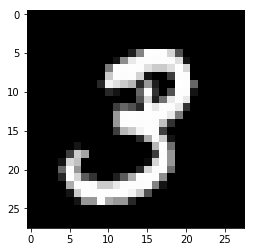

In [14]:
plt.imshow(mnist.train.images[1].reshape(28,28),cmap='gist_gray')

In [15]:
mnist.train.images[1].max()

1.0

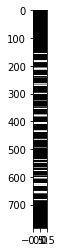

In [16]:
plt.imshow(mnist.train.images[1].reshape(784,1),cmap='gist_gray',aspect=0.02)

## Create the Model

In [17]:
#x = tf.placeholder(tf.float32,shape=[None,784])

In [18]:
# 10 because 0-9 possible numbers
#W = tf.Variable(tf.zeros([784,10]))

In [19]:
#b = tf.Variable(tf.zeros([10]))

In [20]:
# Create the Graph
#y = tf.matmul(x,W) + b 

In [21]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  # Computes 32 features using a 5x5 filter with ReLU activation.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 28, 28, 1]
  # Output Tensor Shape: [batch_size, 28, 28, 32]
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 64]
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 14, 14, 64]
  # Output Tensor Shape: [batch_size, 7, 7, 64]
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 7, 7, 64]
  # Output Tensor Shape: [batch_size, 7 * 7 * 64]
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 7 * 7 * 64]
  # Output Tensor Shape: [batch_size, 1024]
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

  # Add dropout operation; 0.6 probability that element will be kept
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 10]
  logits = tf.layers.dense(inputs=dropout, units=10)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [22]:
#eval_data = tf.convert_to_tensor(mnist.test.images)
eval_data = mnist.test.images
print(eval_data)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [23]:
#eval_labels = tf.convert_to_tensor(np.asarray(mnist.test.labels, dtype=np.int32))
#eval_labels = tf.convert_to_tensor(np.asarray(mnist.test.labels, dtype=np.int64))
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
print(eval_labels)

[7 2 1 ... 4 5 6]


In [24]:
train_data = mnist.train.images
#train_labels = tf.convert_to_tensor(np.asarray(mnist.train.labels, dtype=np.int32))
#train_labels = tf.convert_to_tensor(np.asarray(mnist.train.labels, dtype=np.int64))
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
print(train_labels)

[7 3 4 ... 5 6 8]


In [29]:
# Create the Estimator
PATH = os.getcwd()
print(PATH)
PATH_DATASET = PATH + os.sep + "MNIST_data"

mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir=PATH_DATASET)
    
  #print(model_dir)
  # Set up logging for predictions
  # Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

  # Train the model
  #train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
    
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=20000,
    hooks=[logging_hook])

  # Evaluate the model and print results
  #eval_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data}, y=eval_labels, num_epochs=1, shuffle=False)

eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
    #print(eval_results)

C:\Users\nksingh\Documents\ELY\PythonScripts\Refactored_Py_DS_ML_Bootcamp-master\22-Deep Learning
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\nksingh\\Documents\\ELY\\PythonScripts\\Refactored_Py_DS_ML_Bootcamp-master\\22-Deep Learning\\MNIST_data', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001EAF2389320>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
I

INFO:tensorflow:loss = 0.046335466, step = 38514
INFO:tensorflow:probabilities = [[0.00000721 0.9993851  0.00039023 0.0000131  0.00001912 0.00000102
  0.00009828 0.00003724 0.00004718 0.00000153]
 [0.00885969 0.00036263 0.10091975 0.01091497 0.00004352 0.00057695
  0.00010948 0.00021057 0.87469923 0.00330321]
 [0.00001883 0.00000095 0.00000668 0.00001396 0.00001834 0.00606583
  0.99353325 0.         0.0003421  0.00000009]
 [0.9985033  0.0000027  0.00054411 0.00004438 0.00002838 0.00021274
  0.00033384 0.00006158 0.00000794 0.00026103]
 [0.00000012 0.00000036 0.00001021 0.7647303  0.00000003 0.22262731
  0.         0.00000428 0.00018875 0.01243871]
 [0.00000005 0.         0.00001115 0.00112958 0.00004758 0.00000076
  0.         0.00138657 0.00011685 0.9973074 ]
 [0.00000002 0.00001182 0.00002948 0.9999101  0.00000002 0.00001561
  0.00000002 0.00000011 0.00003281 0.00000002]
 [0.00001484 0.0006974  0.9980818  0.00113026 0.00000005 0.00000188
  0.00000334 0.00000174 0.00006865 0.        ]

INFO:tensorflow:global_step/sec: 5.06803
INFO:tensorflow:probabilities = [[0.00000404 0.1041217  0.19836226 0.28805223 0.00001111 0.00061955
  0.00001807 0.40873474 0.00007371 0.00000266]
 [0.00000054 0.00010025 0.00008675 0.9703352  0.00003437 0.00000834
  0.00000008 0.00091139 0.00716246 0.02136067]
 [0.00000191 0.00005018 0.00005891 0.9977476  0.00000001 0.00197451
  0.00000443 0.00000013 0.00015662 0.00000566]
 [0.00000005 0.00000011 0.00000014 0.00006276 0.00049029 0.0000236
  0.00000001 0.00001875 0.00000873 0.9993956 ]
 [0.00000489 0.9989643  0.00050214 0.00000308 0.00001629 0.00000113
  0.00002423 0.00027574 0.00020637 0.00000183]
 [0.00023376 0.00012185 0.00004069 0.00013872 0.00547446 0.00310012
  0.00000136 0.12151857 0.00024492 0.8691256 ]
 [0.00000086 0.00001117 0.00003872 0.9999101  0.00000258 0.00000868
  0.         0.00000747 0.00001467 0.00000559]
 [0.00002177 0.00000014 0.00000073 0.00033762 0.00000177 0.99688774
  0.00000015 0.00001893 0.00000321 0.00272803]
 [0.0000

INFO:tensorflow:loss = 0.08953653, step = 38614 (19.753 sec)
INFO:tensorflow:probabilities = [[0.00007101 0.00000479 0.00018554 0.00000387 0.00149719 0.00038546
  0.9977615  0.00000093 0.00004421 0.00004545]
 [0.00000002 0.00000045 0.0000155  0.00005638 0.00000056 0.00044727
  0.00001344 0.00000023 0.99941635 0.00004985]
 [0.00000036 0.00000028 0.00000076 0.00002757 0.0000004  0.9999491
  0.00000731 0.00000109 0.00001271 0.00000045]
 [0.00002602 0.00115852 0.9983877  0.00010333 0.00000569 0.00002138
  0.00016828 0.00010325 0.00002036 0.00000534]
 [0.00000079 0.00000153 0.00000014 0.00000426 0.00000099 0.00037032
  0.99961996 0.         0.00000207 0.00000001]
 [0.00001029 0.0023614  0.00003237 0.00028809 0.02923704 0.0002252
  0.00000099 0.10433803 0.00362801 0.85987854]
 [0.00000311 0.00000831 0.00000116 0.00004848 0.0001837  0.00001764
  0.00000002 0.99493486 0.00005223 0.00475056]
 [0.00000014 0.0000008  0.99991775 0.0000756  0.00000111 0.00000004
  0.00000005 0.00000441 0.00000023 0

INFO:tensorflow:global_step/sec: 5.02161
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.99994326 0.00000001
  0.         0.00000736 0.00000014 0.00004921]
 [0.00000024 0.         0.00000005 0.0000619  0.00073918 0.00000218
  0.         0.000034   0.00008456 0.9990778 ]
 [0.00000201 0.00000382 0.00027938 0.00085621 0.00000758 0.0000094
  0.00000152 0.00000098 0.9987895  0.00004969]
 [0.00000294 0.00001036 0.00000324 0.00001047 0.00018688 0.00282288
  0.9966438  0.00000001 0.00031913 0.00000031]
 [0.00000577 0.         0.00000012 0.00000038 0.00000031 0.00000013
  0.         0.99987066 0.00000069 0.00012194]
 [0.18657061 0.00005375 0.8122205  0.00024602 0.00011154 0.00066616
  0.00007908 0.00000402 0.00002722 0.00002106]
 [0.00428185 0.0000558  0.0013194  0.00008845 0.00036317 0.00000669
  0.000061   0.0019599  0.98795575 0.00390801]
 [0.00074878 0.00030532 0.00005071 0.00199097 0.00054689 0.9686193
  0.01648999 0.00001792 0.01120046 0.00002969]
 [0.00000

INFO:tensorflow:loss = 0.12791632, step = 38714 (19.893 sec)
INFO:tensorflow:probabilities = [[0.00059621 0.00111816 0.67691964 0.02826142 0.00001382 0.00013383
  0.00003933 0.00000022 0.2929155  0.00000197]
 [0.9892013  0.00000055 0.00020944 0.00001045 0.00002924 0.00003622
  0.00004418 0.00010562 0.0000057  0.01035724]
 [0.00014295 0.00039311 0.99824107 0.00077121 0.00013563 0.0000031
  0.00002555 0.00004487 0.00021907 0.00002331]
 [0.00000165 0.00000007 0.00001379 0.00160966 0.00040235 0.00095533
  0.00000104 0.00039609 0.00046641 0.99615365]
 [0.00067881 0.00003481 0.98221165 0.00496822 0.00050634 0.00001231
  0.00000449 0.00008022 0.01138477 0.00011855]
 [0.00000002 0.00012431 0.00030477 0.00061541 0.00000155 0.00000143
  0.00000001 0.9989033  0.00004559 0.00000354]
 [0.0000001  0.00000029 0.00000111 0.00018902 0.00910425 0.00006367
  0.00000059 0.00020801 0.00017812 0.9902548 ]
 [0.00000007 0.00000707 0.00001946 0.984969   0.00000233 0.00018189
  0.         0.00020476 0.00001316 

INFO:tensorflow:global_step/sec: 5.07278
INFO:tensorflow:probabilities = [[0.00000096 0.00000001 0.00000477 0.00000003 0.00006575 0.00000243
  0.99992573 0.         0.00000027 0.00000007]
 [0.         0.00000005 0.00000053 0.0000045  0.00000003 0.00000001
  0.         0.99997807 0.00000119 0.00001561]
 [0.00000041 0.00008008 0.00005171 0.00048728 0.00000014 0.00003931
  0.         0.9982185  0.00111863 0.00000407]
 [0.00000611 0.00000012 0.0000008  0.00106383 0.00342075 0.00012415
  0.00000051 0.0000179  0.00006232 0.9953035 ]
 [0.00002124 0.00027736 0.9982644  0.00138217 0.         0.00000036
  0.00000008 0.00000069 0.00005366 0.00000005]
 [0.00000528 0.00000982 0.00003989 0.99963677 0.00000322 0.00021014
  0.00000135 0.00000036 0.0000337  0.00005958]
 [0.00000002 0.00000011 0.00000026 0.00000417 0.02459886 0.00000106
  0.00000002 0.00025505 0.00000228 0.97513825]
 [0.00000027 0.00000019 0.00000013 0.00019133 0.00000004 0.9997944
  0.00000127 0.00000023 0.00000578 0.00000617]
 [0.0013

INFO:tensorflow:loss = 0.100099854, step = 38814 (19.715 sec)
INFO:tensorflow:probabilities = [[0.99998033 0.00000003 0.00000183 0.00000002 0.00000001 0.00001255
  0.00000046 0.00000236 0.00000004 0.00000255]
 [0.00008928 0.0000292  0.00041651 0.0005253  0.00001021 0.99492764
  0.0013595  0.00002373 0.00260251 0.00001612]
 [0.99994063 0.00000024 0.00004445 0.00000075 0.00000114 0.00000048
  0.00000302 0.00000063 0.00000095 0.0000077 ]
 [0.00002517 0.00007672 0.99063265 0.00872292 0.00005424 0.00001644
  0.00000353 0.00004939 0.00036432 0.00005472]
 [0.00001378 0.9889026  0.00262373 0.00494854 0.00084577 0.00037768
  0.00016728 0.00013009 0.00191567 0.00007498]
 [0.00000444 0.988518   0.00017259 0.00018766 0.00479577 0.00037146
  0.00040993 0.00044696 0.0047728  0.00032037]
 [0.00000005 0.00000087 0.00027904 0.9989779  0.         0.0000002
  0.         0.00002686 0.00070651 0.00000845]
 [0.00332449 0.00006529 0.00428478 0.00117543 0.02221463 0.0078884
  0.00348189 0.02765008 0.00928181 

INFO:tensorflow:global_step/sec: 4.90352
INFO:tensorflow:probabilities = [[0.00001716 0.00000006 0.00004865 0.00003343 0.00086458 0.00000002
  0.00000193 0.0031623  0.00069479 0.99517703]
 [0.00000017 0.00000006 0.00000017 0.00011129 0.00000025 0.9995203
  0.00001279 0.         0.00034804 0.00000704]
 [0.00005436 0.00026273 0.00756849 0.00004846 0.00428052 0.00183738
  0.98495525 0.00001899 0.00096944 0.00000439]
 [0.00000005 0.         0.         0.00000729 0.00000001 0.99980897
  0.         0.00001407 0.00000013 0.00016954]
 [0.00002655 0.00000003 0.0000747  0.00003349 0.00112186 0.00000024
  0.00000011 0.0004129  0.01375902 0.9845711 ]
 [0.00000485 0.00001394 0.00020232 0.00146159 0.00001396 0.00107012
  0.00003659 0.00000443 0.9969554  0.00023689]
 [0.0000003  0.00000001 0.00000002 0.02539735 0.00000001 0.9717643
  0.         0.00000299 0.00000248 0.00283254]
 [0.99944097 0.00000189 0.00041172 0.00000015 0.00000004 0.00007677
  0.00006657 0.00000002 0.00000008 0.00000175]
 [0.00000

INFO:tensorflow:loss = 0.064216904, step = 38914 (20.391 sec)
INFO:tensorflow:probabilities = [[0.00000024 0.00000724 0.00082925 0.00616601 0.00005371 0.00000112
  0.00000175 0.99264777 0.00001295 0.00028014]
 [0.00001594 0.00000089 0.9965659  0.00014095 0.00029967 0.00000015
  0.00002739 0.00027483 0.00264498 0.00002944]
 [0.00000725 0.0000005  0.00018336 0.00060911 0.00000319 0.00029174
  0.00000107 0.00000041 0.9980196  0.00088376]
 [0.00367936 0.00180151 0.7345652  0.05420112 0.00002715 0.00036898
  0.00000559 0.16655527 0.00014651 0.03864936]
 [0.33304122 0.00045682 0.04780328 0.00018372 0.00075907 0.00004421
  0.00668433 0.00001548 0.6099421  0.00106977]
 [0.00075911 0.00005795 0.99666995 0.00145871 0.00000001 0.00000342
  0.00000081 0.00103304 0.0000035  0.00001354]
 [0.9998965  0.00000001 0.00002205 0.00000002 0.00000004 0.000052
  0.00002143 0.00000117 0.00000525 0.0000015 ]
 [0.00000522 0.00000046 0.00004804 0.00003629 0.00000144 0.00000223
  0.00000074 0.999833   0.00000991 

INFO:tensorflow:global_step/sec: 5.16233
INFO:tensorflow:probabilities = [[0.00000141 0.0000009  0.00020505 0.0016128  0.00000255 0.00000386
  0.00000029 0.00000094 0.99811447 0.00005776]
 [0.00037513 0.00017377 0.04619454 0.00010253 0.9352472  0.00053143
  0.00221683 0.00955134 0.00090177 0.00470543]
 [0.00003676 0.00000046 0.00049892 0.00000254 0.00003268 0.00260606
  0.99648595 0.00000005 0.00033591 0.00000072]
 [0.32407615 0.00724938 0.02296332 0.13192505 0.00025903 0.46591392
  0.01720819 0.01814592 0.00698744 0.00527148]
 [0.00016924 0.00003125 0.96554047 0.03364271 0.00003701 0.00003612
  0.00000862 0.00005646 0.00047326 0.00000477]
 [0.         0.00000015 0.00000021 0.00000002 0.9999875  0.00000007
  0.00001114 0.00000058 0.00000007 0.0000003 ]
 [0.00000365 0.00000005 0.00000081 0.00000003 0.00002207 0.00000577
  0.9999676  0.         0.00000011 0.00000005]
 [0.00000046 0.00000007 0.00000026 0.00000003 0.00000023 0.00000381
  0.999995   0.         0.00000008 0.        ]
 [0.997

INFO:tensorflow:loss = 0.07521765, step = 39014 (19.372 sec)
INFO:tensorflow:probabilities = [[0.00011407 0.00002501 0.00135713 0.00011923 0.00014694 0.9762415
  0.02187387 0.00000098 0.00012005 0.00000122]
 [0.00002945 0.00000171 0.00000395 0.00000032 0.00036365 0.00000164
  0.99959105 0.00000097 0.00000597 0.00000129]
 [0.00001443 0.00000014 0.00028313 0.0000018  0.0000003  0.00004186
  0.00000943 0.00000012 0.99964774 0.00000105]
 [0.00000006 0.00000064 0.00000512 0.00147764 0.00034096 0.00001061
  0.00000001 0.00050453 0.00017485 0.9974855 ]
 [0.00000451 0.00000332 0.00017472 0.00134426 0.00000015 0.00000105
  0.         0.9932213  0.00000287 0.00524784]
 [0.00007713 0.00001539 0.00007512 0.00005856 0.00000311 0.00012988
  0.00000566 0.00000098 0.9995771  0.0000571 ]
 [0.99988675 0.00000001 0.00000005 0.         0.00000008 0.00000064
  0.0001123  0.         0.00000007 0.00000014]
 [0.00000001 0.00000983 0.00002283 0.00099217 0.         0.
  0.         0.9989699  0.00000165 0.000003

INFO:tensorflow:global_step/sec: 5.23157
INFO:tensorflow:probabilities = [[0.99995446 0.00000009 0.00000962 0.00000001 0.00000003 0.00000028
  0.00002884 0.00000003 0.00000035 0.00000633]
 [0.00000058 0.00000003 0.00010044 0.00001452 0.00000003 0.00000644
  0.00000126 0.00000001 0.9998759  0.00000088]
 [0.00010521 0.00000003 0.00160996 0.00615165 0.00000024 0.00017187
  0.00000019 0.00000006 0.9915888  0.00037204]
 [0.00001573 0.03631885 0.00012514 0.8419599  0.00051226 0.0001349
  0.00000054 0.09440395 0.0050246  0.0215041 ]
 [0.00543656 0.00011618 0.00174776 0.00504795 0.20388882 0.06635797
  0.00105934 0.15332176 0.0025576  0.5604661 ]
 [0.00000005 0.         0.00000006 0.00000001 0.9999784  0.00000004
  0.00000025 0.00000143 0.00000052 0.00001932]
 [0.00000024 0.00000077 0.00006763 0.00000001 0.0031518  0.00001056
  0.9967609  0.00000001 0.00000758 0.00000052]
 [0.00000068 0.00320715 0.00110574 0.33583847 0.00002952 0.0000488
  0.         0.65194166 0.0009999  0.00682792]
 [0.     

INFO:tensorflow:loss = 0.123331964, step = 39114 (19.116 sec)
INFO:tensorflow:probabilities = [[0.         0.00000002 0.00000002 0.00000016 0.9995894  0.0000176
  0.00000042 0.00002223 0.00006839 0.00030169]
 [0.00002172 0.99931777 0.00003597 0.00000449 0.00006785 0.00000872
  0.00024603 0.00002897 0.00026341 0.00000507]
 [0.00000008 0.00000228 0.00009467 0.9998553  0.00000001 0.00003872
  0.00000001 0.00000001 0.0000017  0.00000724]
 [0.00000302 0.00000046 0.00001681 0.00013489 0.000496   0.0000175
  0.00000001 0.00114253 0.00013071 0.998058  ]
 [0.99965143 0.00000004 0.00002297 0.00007844 0.00000192 0.00001995
  0.00002233 0.00005844 0.00000484 0.00013975]
 [0.00000114 0.00000251 0.00018126 0.00027707 0.00000061 0.00000057
  0.         0.9994319  0.00001363 0.00009144]
 [0.00000285 0.00000494 0.00001044 0.00033227 0.00073521 0.00000872
  0.00000003 0.00736673 0.00024875 0.9912901 ]
 [0.00000004 0.00000632 0.00000169 0.0000069  0.9989366  0.00000793
  0.00000319 0.00006773 0.00017443 

INFO:tensorflow:global_step/sec: 5.42301
INFO:tensorflow:probabilities = [[0.00000154 0.00000506 0.00000104 0.00012608 0.00000056 0.99941754
  0.00033143 0.00000003 0.00011271 0.00000407]
 [0.00000249 0.9989291  0.00006624 0.00000752 0.00049041 0.00000193
  0.00001981 0.00039448 0.00007622 0.00001185]
 [0.00000001 0.         0.         0.00000112 0.00000001 0.9999764
  0.00000272 0.00000016 0.00001938 0.00000017]
 [0.00000002 0.00000053 0.00000835 0.00000089 0.9999713  0.00000038
  0.00000655 0.0000094  0.00000166 0.00000096]
 [0.00002574 0.9958807  0.00071546 0.00013521 0.00053668 0.00000219
  0.0000199  0.00245911 0.0002018  0.00002297]
 [0.         0.         0.00000003 0.         0.99998176 0.00000003
  0.00000001 0.0000155  0.00000013 0.00000259]
 [0.00000103 0.00003884 0.00001108 0.9965585  0.00000237 0.00203967
  0.00000087 0.00000846 0.00098889 0.00035035]
 [0.00048383 0.9875886  0.00104286 0.00027818 0.00060344 0.00007533
  0.0009098  0.00557396 0.00321577 0.00022822]
 [0.0000

INFO:tensorflow:loss = 0.052001927, step = 39214 (18.438 sec)
INFO:tensorflow:probabilities = [[0.00001835 0.00031807 0.00001724 0.00361417 0.00023214 0.6367179
  0.3272274  0.00000089 0.03114861 0.00070519]
 [0.00000002 0.00000021 0.00083481 0.00025336 0.00000013 0.00000002
  0.         0.99889636 0.00000604 0.00000893]
 [0.00000001 0.         0.00000192 0.         0.9999957  0.00000002
  0.00000016 0.         0.0000003  0.00000191]
 [0.00000524 0.99968433 0.00008024 0.00000204 0.00003012 0.00000084
  0.00006269 0.00008491 0.00004905 0.00000057]
 [0.00011069 0.00000666 0.00005302 0.00257122 0.00030441 0.9953962
  0.00139813 0.00004717 0.00009336 0.00001897]
 [0.00019742 0.00043781 0.20380539 0.10398263 0.00016988 0.0001202
  0.00000868 0.3893629  0.2982435  0.00367158]
 [0.07190232 0.00019802 0.6869657  0.07854528 0.00934393 0.02984475
  0.00272613 0.00007007 0.10446817 0.01593564]
 [0.00002196 0.00010635 0.00090409 0.00009711 0.00152533 0.0027165
  0.9942419  0.00000166 0.00036408 0.

INFO:tensorflow:global_step/sec: 5.32579
INFO:tensorflow:probabilities = [[0.00078688 0.00002413 0.00022423 0.00012456 0.00000789 0.00063211
  0.00000841 0.00005157 0.99807346 0.00006676]
 [0.00013115 0.00000275 0.00001299 0.00000013 0.00001369 0.00023555
  0.9995994  0.         0.00000433 0.00000011]
 [0.00000012 0.00001322 0.99983335 0.0001482  0.00000003 0.00000002
  0.00000001 0.00000408 0.00000104 0.        ]
 [0.00001184 0.00007909 0.00251712 0.00001996 0.99593747 0.00032017
  0.00032589 0.00005371 0.00023852 0.00049628]
 [0.00000115 0.00000003 0.00084146 0.00009898 0.00000001 0.00000002
  0.00000004 0.00000002 0.9990582  0.00000018]
 [0.0000148  0.9994456  0.00002618 0.00000089 0.00000186 0.00001081
  0.00002565 0.00000406 0.00046853 0.0000016 ]
 [0.00000108 0.00000239 0.00002977 0.00001007 0.9786912  0.0000075
  0.00002944 0.00379294 0.00003514 0.01740065]
 [0.00000006 0.00000063 0.0000017  0.00006793 0.02580674 0.00021454
  0.00000224 0.00008044 0.00046313 0.97336257]
 [0.0000

INFO:tensorflow:loss = 0.05155463, step = 39314 (18.800 sec)
INFO:tensorflow:probabilities = [[0.         0.00000003 0.00000024 0.00001575 0.00000023 0.00000019
  0.         0.9999757  0.00000057 0.00000727]
 [0.00000431 0.99895006 0.0001074  0.00003425 0.00003977 0.00002702
  0.00003969 0.00004912 0.00074243 0.00000603]
 [0.         0.00000006 0.00000002 0.000005   0.00024199 0.00000239
  0.         0.0000106  0.00002539 0.99971455]
 [0.000035   0.00012879 0.9866541  0.0053354  0.0001054  0.00001256
  0.00000246 0.00583802 0.00188549 0.00000269]
 [0.00002184 0.00075865 0.00894747 0.81923777 0.00001253 0.00003136
  0.00000056 0.00096517 0.16896449 0.0010601 ]
 [0.99803346 0.0000101  0.00007181 0.00000536 0.00000084 0.00020487
  0.00167119 0.00000018 0.00000116 0.0000008 ]
 [0.00000452 0.99906    0.00006395 0.0000258  0.00010541 0.0000056
  0.00000977 0.00009723 0.00060989 0.00001792]
 [0.00003322 0.00035961 0.00634035 0.00866232 0.00058368 0.00018787
  0.00005256 0.00004909 0.98261905 

INFO:tensorflow:global_step/sec: 4.93317
INFO:tensorflow:probabilities = [[0.99990606 0.00000009 0.00005003 0.0000001  0.00000047 0.00001067
  0.0000105  0.00000749 0.0000009  0.00001348]
 [0.00000011 0.00064065 0.00001153 0.00187617 0.00006423 0.00002686
  0.0000077  0.00000135 0.9973464  0.00002503]
 [0.00000284 0.997535   0.00005135 0.00010227 0.00001728 0.00000039
  0.00001998 0.0000654  0.00218699 0.00001856]
 [0.00000026 0.00000246 0.00000159 0.00006763 0.9773981  0.0000343
  0.00325114 0.01850827 0.00041497 0.00032136]
 [0.0057266  0.00000318 0.00024963 0.00002783 0.00821013 0.00150997
  0.9795426  0.00004311 0.00457323 0.00011373]
 [0.00000036 0.00081221 0.00004282 0.9991041  0.         0.00000831
  0.         0.00000002 0.00002649 0.00000571]
 [0.9758892  0.00002855 0.00358386 0.00019835 0.00005631 0.00838064
  0.00039751 0.00974828 0.00093447 0.00078279]
 [0.00065993 0.0000008  0.00000741 0.00001172 0.00002959 0.00013725
  0.00000021 0.9982893  0.00011802 0.00074568]
 [0.0001

INFO:tensorflow:loss = 0.03208169, step = 39414 (20.248 sec)
INFO:tensorflow:probabilities = [[0.00008662 0.00000198 0.00008565 0.00063647 0.00653464 0.000233
  0.00002237 0.00911541 0.00464022 0.9786436 ]
 [0.00211379 0.00000077 0.00009618 0.00000002 0.00073835 0.00006959
  0.9969806  0.0000003  0.00000036 0.00000005]
 [0.00007897 0.00036307 0.00050794 0.00182202 0.0976464  0.02232891
  0.00330547 0.00474466 0.7231791  0.14602336]
 [0.8295828  0.0001143  0.13473621 0.00122787 0.00075993 0.00020819
  0.00013417 0.00155187 0.00042344 0.03126118]
 [0.00000078 0.00000718 0.00011119 0.9995447  0.00000092 0.00010196
  0.         0.00000209 0.00022374 0.00000732]
 [0.00276917 0.00144975 0.02953656 0.00398384 0.03190184 0.03488576
  0.01225167 0.08415401 0.7782523  0.02081506]
 [0.00000387 0.00004398 0.00039861 0.0005158  0.01482632 0.00072184
  0.00003694 0.00469348 0.9772469  0.00151221]
 [0.00003744 0.99852043 0.00017594 0.00000235 0.00008682 0.0000474
  0.0007876  0.00017536 0.00015082 0.

INFO:tensorflow:global_step/sec: 5.15875
INFO:tensorflow:probabilities = [[0.00005308 0.00000011 0.00008525 0.00043657 0.00014574 0.00000901
  0.00000069 0.00177209 0.00010689 0.99739057]
 [0.00000422 0.00011626 0.00000098 0.00023872 0.00474134 0.00023613
  0.00000172 0.0053121  0.00009664 0.9892519 ]
 [0.00002727 0.00000219 0.00000986 0.00000042 0.00386539 0.0000538
  0.99603784 0.00000088 0.00000209 0.00000025]
 [0.00000024 0.00001549 0.00000138 0.00014714 0.9702406  0.00004232
  0.00000339 0.00012909 0.00006477 0.02935566]
 [0.00003289 0.00002257 0.00004453 0.00010161 0.00015882 0.99761105
  0.00076336 0.00002513 0.00122964 0.00001035]
 [0.00000228 0.00000077 0.00000571 0.00001991 0.00587462 0.0000009
  0.00000014 0.0001468  0.00000423 0.9939446 ]
 [0.00007969 0.00004313 0.0013131  0.00226651 0.00003172 0.00000429
  0.00000008 0.9939009  0.00011324 0.00224731]
 [0.00002325 0.998315   0.00003088 0.00005583 0.00037991 0.00002347
  0.00024509 0.00004601 0.00084089 0.00003981]
 [0.00000

INFO:tensorflow:loss = 0.056383457, step = 39514 (19.385 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.0000039  0.99999046 0.00000323 0.00000004 0.00000002
  0.00000023 0.00000022 0.00000187 0.        ]
 [0.03148215 0.00600651 0.02104983 0.00402087 0.7041358  0.0869874
  0.01347066 0.1303537  0.00151857 0.0009745 ]
 [0.00036661 0.00000407 0.00102021 0.00002122 0.83989    0.00003334
  0.06291331 0.04288397 0.00450469 0.04836252]
 [0.00060332 0.00219747 0.00247133 0.00338156 0.00062133 0.00055631
  0.01077633 0.00000974 0.9778807  0.00150193]
 [0.0001823  0.00000016 0.00033348 0.00007423 0.00000003 0.0000066
  0.00000025 0.0000036  0.9993992  0.00000013]
 [0.00000874 0.99942005 0.00013462 0.00001752 0.00006508 0.00000649
  0.00004688 0.00016254 0.00012384 0.00001453]
 [0.01525848 0.00000015 0.0005687  0.00003786 0.00011429 0.00000076
  0.00004968 0.00000133 0.98288375 0.00108494]
 [0.00000121 0.00007903 0.00005707 0.00005667 0.00014611 0.0012179
  0.9984176  0.00000004 0.00002407 0

INFO:tensorflow:global_step/sec: 5.20553
INFO:tensorflow:probabilities = [[0.00000002 0.00000017 0.00000014 0.00000002 0.998936   0.0000009
  0.00001578 0.00006709 0.00097119 0.0000087 ]
 [0.00000007 0.00000766 0.00010758 0.00607961 0.00154259 0.0000143
  0.00004296 0.00000013 0.9921504  0.00005469]
 [0.0000089  0.99750704 0.00008451 0.00002326 0.00039518 0.00008775
  0.00084476 0.00001095 0.00102873 0.00000892]
 [0.00013778 0.20327789 0.00065868 0.01168362 0.00208479 0.00183876
  0.00000932 0.34553763 0.00158412 0.43318743]
 [0.92917484 0.00000844 0.00085757 0.00000499 0.00035692 0.00275915
  0.06493036 0.00003014 0.00162634 0.0002512 ]
 [0.00000002 0.00000004 0.00000022 0.00000132 0.00000007 0.00000026
  0.         0.9999888  0.00000001 0.00000933]
 [0.99868196 0.00000296 0.00028403 0.00000706 0.00000218 0.00003559
  0.00000927 0.00093816 0.00002223 0.0000165 ]
 [0.         0.00000001 0.00000029 0.9999528  0.         0.00001218
  0.         0.00000001 0.00001133 0.0000234 ]
 [0.00000

INFO:tensorflow:loss = 0.13125214, step = 39614 (19.211 sec)
INFO:tensorflow:probabilities = [[0.00000002 0.         0.00005699 0.00000001 0.00003994 0.00001755
  0.9998839  0.         0.00000154 0.        ]
 [0.00004727 0.00000492 0.00002254 0.00000106 0.00000295 0.00281301
  0.99621296 0.00000001 0.00089491 0.00000031]
 [0.00000001 0.00000763 0.9971974  0.00182543 0.00000215 0.
  0.         0.00096683 0.00000053 0.00000013]
 [0.00000238 0.00000005 0.00000273 0.00000001 0.0000039  0.00001295
  0.99997115 0.         0.00000682 0.00000003]
 [0.00000001 0.         0.00000001 0.00005825 0.00011119 0.00000044
  0.         0.00009344 0.00000017 0.9997365 ]
 [0.00009631 0.00002089 0.00400519 0.00015389 0.9914799  0.00000652
  0.0026613  0.00023729 0.00010061 0.00123818]
 [0.00000044 0.00004755 0.00000198 0.00346532 0.00206462 0.00173678
  0.0000006  0.01237351 0.00161759 0.9786916 ]
 [0.00000071 0.00000001 0.00000004 0.00000021 0.00000007 0.0000016
  0.         0.9999838  0.00000074 0.000012

INFO:tensorflow:global_step/sec: 5.12298
INFO:tensorflow:probabilities = [[0.00000155 0.00000309 0.999546   0.00044228 0.00000005 0.00000568
  0.00000029 0.0000003  0.00000087 0.00000004]
 [0.994453   0.00001525 0.00180824 0.00007624 0.00008708 0.00023216
  0.00269966 0.00003295 0.00047492 0.00012043]
 [0.00000832 0.01659759 0.01919119 0.01400079 0.00002046 0.00000005
  0.00000002 0.94792134 0.00024949 0.00201069]
 [0.00001005 0.00000007 0.00000012 0.         0.00000876 0.00000051
  0.99997914 0.00000001 0.00000121 0.00000012]
 [0.00009071 0.00011298 0.00004431 0.00024121 0.00059643 0.00327983
  0.99530655 0.00000014 0.00032585 0.00000207]
 [0.00000303 0.00003641 0.00117135 0.99515104 0.00000385 0.00011794
  0.00000006 0.00042    0.00309255 0.00000383]
 [0.00000004 0.0000036  0.0000035  0.0002695  0.00000021 0.0000001
  0.         0.9994735  0.00000258 0.00024698]
 [0.00000031 0.00002877 0.00000275 0.0014633  0.606434   0.00047894
  0.00003892 0.00129878 0.00052244 0.38973173]
 [0.0000

INFO:tensorflow:loss = 0.07783444, step = 39714 (19.519 sec)
INFO:tensorflow:probabilities = [[0.00000029 0.00000004 0.00000214 0.00002553 0.00000001 0.00000027
  0.         0.9998927  0.00000142 0.00007764]
 [0.00003931 0.00315296 0.00043305 0.00085724 0.95733964 0.00007382
  0.00020496 0.0039277  0.00434216 0.02962911]
 [0.00014559 0.00000251 0.00046731 0.00002184 0.00051783 0.00027919
  0.998434   0.00000077 0.00012846 0.00000265]
 [0.00004477 0.00006533 0.00015518 0.05790542 0.00000598 0.9368319
  0.00358999 0.00000137 0.00027425 0.00112582]
 [0.9994165  0.00000005 0.00009754 0.00000085 0.00000051 0.00000342
  0.00001403 0.00002378 0.00043076 0.00001247]
 [0.00000002 0.00000001 0.00000705 0.00001564 0.         0.00000002
  0.         0.9998567  0.00000003 0.0001205 ]
 [0.02021688 0.00000275 0.0224946  0.03477717 0.00000007 0.01093059
  0.00000005 0.90891063 0.00015228 0.00251507]
 [0.00000204 0.00000068 0.00002087 0.94024    0.00000214 0.00175504
  0.         0.0000984  0.00054991 

INFO:tensorflow:global_step/sec: 5.40343
INFO:tensorflow:probabilities = [[0.00000071 0.00074024 0.9590125  0.04014889 0.00000002 0.00006543
  0.00000001 0.00001404 0.00000835 0.00000981]
 [0.00000001 0.00000102 0.05894161 0.01719155 0.00000024 0.00000001
  0.         0.9238424  0.00002177 0.00000127]
 [0.9985958  0.00000221 0.00106962 0.00003423 0.00000148 0.00023913
  0.0000103  0.00003795 0.0000071  0.00000202]
 [0.00000016 0.0000078  0.00002299 0.99132556 0.00000019 0.00860982
  0.0000005  0.00000071 0.00000445 0.00002779]
 [0.97896016 0.00000654 0.01776335 0.00007218 0.00001341 0.0007066
  0.00001662 0.00039866 0.00190507 0.00015753]
 [0.00010749 0.00001152 0.00610457 0.9915175  0.00000462 0.00001914
  0.00000531 0.00186089 0.00035624 0.00001269]
 [0.00005808 0.00008582 0.00015335 0.01280325 0.00006629 0.96817446
  0.00001741 0.00007504 0.00146711 0.01709916]
 [0.00002061 0.00077161 0.0001045  0.00015033 0.00003243 0.00007406
  0.00000951 0.00002856 0.99872094 0.00008733]
 [0.9911

INFO:tensorflow:loss = 0.09614217, step = 39814 (18.507 sec)
INFO:tensorflow:probabilities = [[0.00048682 0.00000005 0.00035661 0.00023682 0.00000032 0.0000725
  0.00000031 0.00006641 0.9848828  0.01389739]
 [0.00000056 0.99955446 0.00000523 0.00008469 0.00003278 0.00000223
  0.00000598 0.00000594 0.00029984 0.00000821]
 [0.00000472 0.00002925 0.9995272  0.00003167 0.00000401 0.00000367
  0.00000075 0.00035168 0.0000471  0.00000001]
 [0.00033883 0.00016121 0.00056783 0.00291142 0.00000301 0.99551255
  0.00033182 0.00001782 0.00013764 0.0000178 ]
 [0.9999026  0.00000002 0.00003569 0.0000001  0.         0.00001179
  0.00002626 0.00000016 0.00002346 0.00000001]
 [0.0000068  0.00000003 0.00000003 0.00100302 0.00000024 0.9977102
  0.0000002  0.00002777 0.00025782 0.00099388]
 [0.00001188 0.00000001 0.00000605 0.00001619 0.00082607 0.00000007
  0.00000006 0.00021727 0.00010028 0.99882215]
 [0.         0.         0.00000001 0.00000006 0.         0.00000002
  0.         0.9999994  0.         0

INFO:tensorflow:global_step/sec: 5.07425
INFO:tensorflow:probabilities = [[0.         0.         0.00000021 0.00009199 0.00009607 0.00000254
  0.         0.01097568 0.00004387 0.9887897 ]
 [0.00000012 0.00004209 0.00001666 0.98761976 0.00000001 0.01230921
  0.0000012  0.         0.00000666 0.00000439]
 [0.00008094 0.00023758 0.00061874 0.00293912 0.01250725 0.0002431
  0.00016869 0.00394864 0.00134454 0.9779114 ]
 [0.00000003 0.99997747 0.00000177 0.00000527 0.00000217 0.00000024
  0.00000124 0.00000101 0.00001081 0.00000007]
 [0.00002309 0.03985545 0.95897686 0.00102824 0.00000194 0.0000056
  0.00000014 0.00006658 0.0000278  0.00001431]
 [0.00000149 0.00000512 0.00000063 0.00013839 0.00944941 0.00000286
  0.00000001 0.00195232 0.00005887 0.9883909 ]
 [0.00000086 0.00000721 0.00000718 0.00031129 0.0001004  0.000027
  0.00000002 0.00310339 0.00007917 0.99636346]
 [0.00000003 0.00000019 0.0000127  0.00009846 0.00028623 0.00000117
  0.00000001 0.0000561  0.00004753 0.99949753]
 [0.0037266

INFO:tensorflow:loss = 0.02438692, step = 39914 (19.707 sec)
INFO:tensorflow:probabilities = [[0.00002167 0.00006598 0.0000394  0.00001529 0.00003844 0.00035293
  0.99819905 0.         0.00126725 0.00000004]
 [0.00000027 0.00000061 0.00000362 0.00000425 0.         0.99975914
  0.00000018 0.00000005 0.00023205 0.        ]
 [0.00007855 0.00118174 0.00041155 0.0003193  0.00009486 0.0000048
  0.00000002 0.98141575 0.00007529 0.01641813]
 [0.9999912  0.         0.00000711 0.         0.         0.00000022
  0.00000143 0.         0.         0.        ]
 [0.         0.00000113 0.9999862  0.000012   0.         0.
  0.         0.00000005 0.00000063 0.        ]
 [0.00004129 0.00000049 0.000006   0.00014617 0.00000089 0.99916565
  0.00000079 0.00052308 0.00010683 0.00000872]
 [0.00000017 0.00000158 0.00000047 0.00000582 0.00000009 0.00000015
  0.         0.99977916 0.00000017 0.00021255]
 [0.00000624 0.00000474 0.00017172 0.0046463  0.00050013 0.00031648
  0.00000735 0.00275832 0.00069269 0.990896

INFO:tensorflow:global_step/sec: 4.97237
INFO:tensorflow:probabilities = [[0.00000006 0.00000695 0.99830616 0.00079839 0.         0.00000228
  0.         0.00000001 0.0008861  0.00000001]
 [0.00002513 0.00006629 0.00002299 0.7711786  0.00012883 0.0201548
  0.00000051 0.00000147 0.00468111 0.20374031]
 [0.         0.00000129 0.99948895 0.00012761 0.00000002 0.00000009
  0.00000012 0.         0.00038182 0.        ]
 [0.00006216 0.00002561 0.00003348 0.00820863 0.00019296 0.98765
  0.0000317  0.00086053 0.00218874 0.00074625]
 [0.00001303 0.00000209 0.00000985 0.00120887 0.00001956 0.00530358
  0.         0.9891306  0.00019248 0.00411997]
 [0.         0.         0.         0.00000001 0.9997609  0.00000282
  0.00000002 0.0000021  0.00000043 0.00023358]
 [0.00010567 0.00003286 0.00019279 0.01543528 0.00000338 0.04587386
  0.00111599 0.00000487 0.9371155  0.00011972]
 [0.00000015 0.00000006 0.00001923 0.00000001 0.00000673 0.00000031
  0.9999734  0.00000001 0.00000014 0.        ]
 [0.0000005

INFO:tensorflow:loss = 0.06618195, step = 40014 (20.133 sec)
INFO:tensorflow:probabilities = [[0.00000015 0.6047014  0.39092603 0.00429919 0.00000012 0.00003834
  0.00001428 0.00000758 0.00001275 0.00000008]
 [0.0000004  0.00000053 0.00000609 0.00000788 0.00000011 0.00000061
  0.         0.99930096 0.00000005 0.00068341]
 [0.00000003 0.00000003 0.00015381 0.9998342  0.         0.00000472
  0.         0.         0.00000439 0.00000277]
 [0.00001815 0.9978709  0.00006805 0.00009069 0.00009891 0.00007034
  0.00004173 0.00056274 0.00099061 0.00018785]
 [0.00019779 0.98206586 0.00163957 0.00132205 0.00711849 0.00052087
  0.00156307 0.00264095 0.00170237 0.00122917]
 [0.00000111 0.98704046 0.00203353 0.00033039 0.00068154 0.00049153
  0.00001737 0.00663268 0.00268094 0.00009064]
 [0.00000108 0.999808   0.00002212 0.00000712 0.00001128 0.00000005
  0.00000404 0.00006939 0.00007581 0.00000105]
 [0.00000012 0.00000004 0.00000074 0.00000001 0.99981767 0.00010654
  0.00001213 0.0000521  0.00000154

INFO:tensorflow:global_step/sec: 5.08315
INFO:tensorflow:probabilities = [[0.00000592 0.9984654  0.00028465 0.00001106 0.000152   0.00001475
  0.00034557 0.00000544 0.00071283 0.00000232]
 [0.99992526 0.00000012 0.00001858 0.00000045 0.00000198 0.00000142
  0.00003451 0.00001607 0.00000048 0.00000092]
 [0.00000408 0.00000143 0.00003822 0.00000067 0.00000935 0.004207
  0.9952199  0.         0.0005185  0.00000096]
 [0.00000182 0.9994336  0.00000632 0.00001442 0.00027685 0.00000625
  0.00001623 0.00004965 0.0001747  0.0000203 ]
 [0.00422702 0.00008446 0.98976517 0.00073237 0.00006512 0.00002952
  0.00095472 0.00000697 0.00348185 0.0006528 ]
 [0.00000158 0.00000902 0.00021602 0.99536693 0.00000539 0.00031344
  0.00000004 0.00005293 0.00306043 0.00097428]
 [0.00000001 0.00000009 0.00000116 0.9999908  0.         0.00000578
  0.         0.00000022 0.00000036 0.00000144]
 [0.0000002  0.00000002 0.00003369 0.9999398  0.00000001 0.000011
  0.         0.         0.0000024  0.00001301]
 [0.       

INFO:tensorflow:loss = 0.114884004, step = 40114 (19.654 sec)
INFO:tensorflow:probabilities = [[0.0001612  0.00000794 0.00025011 0.00000236 0.00008437 0.00024846
  0.9991874  0.00000022 0.0000575  0.00000039]
 [0.00000137 0.         0.00000186 0.69281054 0.00000009 0.00207895
  0.         0.00000014 0.04017689 0.26493016]
 [0.00034646 0.00001078 0.00002807 0.00040059 0.00008804 0.99043685
  0.00379763 0.0004984  0.00380355 0.00058958]
 [0.00000926 0.00000052 0.99983096 0.0000854  0.00000039 0.00000001
  0.00000005 0.00003786 0.00003519 0.00000035]
 [0.00000075 0.00000181 0.00000076 0.00491433 0.00023255 0.9430551
  0.00000173 0.00037242 0.00099857 0.05042207]
 [0.00032158 0.00000935 0.00012062 0.00092918 0.00000018 0.99837387
  0.00003788 0.00000014 0.00016655 0.00004072]
 [0.00000002 0.0000001  0.00031851 0.00026289 0.00000002 0.00000088
  0.00000006 0.         0.9994167  0.00000084]
 [0.00000169 0.         0.00000004 0.         0.0000006  0.00000029
  0.9999974  0.         0.00000002

INFO:tensorflow:global_step/sec: 4.853
INFO:tensorflow:probabilities = [[0.         0.00000007 0.99978715 0.00020959 0.         0.
  0.         0.00000262 0.00000043 0.        ]
 [0.99855167 0.00000226 0.00087442 0.00000462 0.00013009 0.00000482
  0.00032345 0.00000084 0.0000085  0.0000994 ]
 [0.00000001 0.00000001 0.00000014 0.00009785 0.00005624 0.00000052
  0.         0.00009805 0.00004514 0.99970204]
 [0.00000005 0.00000014 0.00000185 0.00000154 0.9996979  0.00000211
  0.00000243 0.00000235 0.00000344 0.00028818]
 [0.00000001 0.00000403 0.99994135 0.00005146 0.         0.
  0.         0.00000307 0.00000002 0.        ]
 [0.00000115 0.00000657 0.00000521 0.00001168 0.98262906 0.00025433
  0.00000872 0.01302559 0.00000837 0.00404946]
 [0.         0.         0.         0.         0.9999802  0.00000001
  0.00000001 0.00001423 0.00000005 0.00000558]
 [0.00699875 0.00013323 0.00006287 0.00014386 0.00254528 0.01023273
  0.00003614 0.8726147  0.00059951 0.10663302]
 [0.00000058 0.00000067 0

INFO:tensorflow:loss = 0.06370527, step = 40214 (20.604 sec)
INFO:tensorflow:probabilities = [[0.00000233 0.00071634 0.00005749 0.00137967 0.00000139 0.00000239
  0.         0.99749434 0.00020667 0.00013934]
 [0.00011376 0.00001072 0.00006637 0.00375378 0.00002412 0.9772677
  0.00033707 0.00000088 0.00653578 0.01188977]
 [0.00000276 0.9981969  0.00004286 0.00050042 0.00026999 0.00000551
  0.0000121  0.00009392 0.00086152 0.00001421]
 [0.00014835 0.02606506 0.01674976 0.00015767 0.8332177  0.0003963
  0.10906786 0.00032724 0.01098106 0.00288904]
 [0.00000143 0.00000716 0.00012883 0.00064569 0.00000027 0.00000023
  0.         0.9990619  0.00004409 0.00011038]
 [0.00000108 0.00000028 0.00000461 0.00001705 0.00000027 0.00000025
  0.         0.9999304  0.00000078 0.00004527]
 [0.00000083 0.         0.00000396 0.         0.99996424 0.
  0.00002914 0.00000005 0.00000085 0.00000112]
 [0.00005299 0.99889743 0.00079699 0.00000731 0.00000606 0.00000018
  0.00001062 0.00010835 0.00011031 0.0000097

INFO:tensorflow:global_step/sec: 5.06149
INFO:tensorflow:probabilities = [[0.00009193 0.00001672 0.00002438 0.00959775 0.00071615 0.00719824
  0.00000227 0.01010149 0.00733877 0.9649123 ]
 [0.00000716 0.00000176 0.0000015  0.00024215 0.00000001 0.99974376
  0.00000057 0.00000006 0.00000261 0.00000039]
 [0.00000085 0.0000004  0.00000083 0.00046894 0.00085432 0.00004164
  0.00000024 0.00035793 0.00013876 0.99813604]
 [0.00001434 0.00003014 0.0000496  0.0002838  0.00194989 0.01269725
  0.00005757 0.00017567 0.00129606 0.9834457 ]
 [0.00001479 0.00022955 0.997526   0.00021585 0.00000001 0.00000014
  0.00000001 0.00201151 0.00000219 0.        ]
 [0.         0.         0.00000043 0.00000076 0.00001904 0.0000164
  0.00000043 0.00000126 0.99995387 0.00000789]
 [0.0000215  0.00000113 0.00017668 0.000204   0.00001029 0.00370797
  0.0000492  0.00000044 0.9958211  0.00000756]
 [0.00000003 0.00000003 0.00000229 0.00003861 0.00000544 0.9992594
  0.00001519 0.00000017 0.00067572 0.00000293]
 [0.00000

INFO:tensorflow:loss = 0.03778715, step = 40314 (19.757 sec)
INFO:tensorflow:probabilities = [[0.         0.00000365 0.9999924  0.00000093 0.00000295 0.
  0.00000005 0.         0.00000005 0.        ]
 [0.00193399 0.02407986 0.01228118 0.04092889 0.7588974  0.00497115
  0.00104172 0.11120604 0.00412826 0.04053148]
 [0.00004073 0.9987822  0.0004347  0.00000504 0.0001987  0.00000898
  0.00004236 0.00019734 0.00028683 0.00000318]
 [0.00000052 0.9992592  0.00012567 0.00000706 0.00011721 0.0000013
  0.00001282 0.00042527 0.00004988 0.00000109]
 [0.00513559 0.00098156 0.98929507 0.00321783 0.00001168 0.00027343
  0.00000419 0.00067907 0.00031971 0.00008185]
 [0.00000329 0.00000005 0.0000005  0.         0.0000167  0.00000218
  0.99997604 0.         0.00000105 0.00000009]
 [0.00001031 0.00000388 0.00001097 0.00522851 0.00005278 0.9769932
  0.00021807 0.00000507 0.00521962 0.0122577 ]
 [0.00003571 0.00268283 0.00002962 0.05911542 0.00041549 0.8638493
  0.00009578 0.00003245 0.00439407 0.06934936

INFO:tensorflow:global_step/sec: 4.96447
INFO:tensorflow:probabilities = [[0.00002639 0.0000068  0.0000994  0.00000056 0.00129561 0.00003013
  0.9985386  0.00000034 0.00000138 0.00000076]
 [0.2508276  0.00036433 0.00635713 0.00245714 0.00038836 0.02385902
  0.00112509 0.69798803 0.0028214  0.01381189]
 [0.00000035 0.00007175 0.00012649 0.00044704 0.00000007 0.00000056
  0.         0.9992895  0.00001451 0.00004973]
 [0.00000005 0.         0.00000006 0.         0.00000077 0.00040023
  0.9995982  0.         0.00000073 0.00000001]
 [0.         0.00000174 0.9999839  0.00001188 0.         0.
  0.         0.         0.00000236 0.        ]
 [0.6613467  0.00082364 0.05159914 0.28354058 0.00000721 0.00127382
  0.0000184  0.00075267 0.00003727 0.0006007 ]
 [0.00158831 0.00000252 0.00387944 0.00051906 0.00004987 0.00001155
  0.00000034 0.95669764 0.00044247 0.03680873]
 [0.00000001 0.00000004 0.00000014 0.         0.9999008  0.00000006
  0.00000045 0.00000029 0.00000001 0.00009823]
 [0.0000091  0.

INFO:tensorflow:loss = 0.15880789, step = 40414 (20.143 sec)
INFO:tensorflow:probabilities = [[0.00000021 0.00000005 0.00000222 0.99964964 0.00000044 0.0002277
  0.         0.         0.00001262 0.00010702]
 [0.00000005 0.00000492 0.00001008 0.00007154 0.9989079  0.00001598
  0.00000915 0.00031224 0.00061076 0.00005736]
 [0.         0.00000003 0.         0.00000756 0.00000002 0.99990475
  0.00001987 0.         0.00006768 0.00000003]
 [0.00000357 0.99824774 0.00005206 0.00015381 0.00049348 0.00000695
  0.00011252 0.00004425 0.00083728 0.00004838]
 [0.00000691 0.00000869 0.04560357 0.00000144 0.00327586 0.00022738
  0.95038176 0.00047152 0.0000202  0.00000268]
 [0.00001206 0.00126568 0.00192517 0.02113181 0.00001741 0.971238
  0.00130925 0.00000213 0.00307261 0.00002591]
 [0.9999435  0.00000001 0.00000013 0.00000003 0.         0.00005586
  0.00000008 0.00000024 0.00000008 0.00000005]
 [0.00000085 0.00000072 0.00000013 0.00007862 0.00003737 0.00000515
  0.         0.9961396  0.00000054 0.

INFO:tensorflow:global_step/sec: 5.08242
INFO:tensorflow:probabilities = [[0.00000451 0.00001542 0.00002798 0.00000422 0.00003422 0.00039542
  0.9994967  0.         0.00002103 0.00000052]
 [0.00000125 0.00000371 0.0008735  0.998558   0.00000465 0.00005787
  0.00000001 0.00000008 0.0004218  0.00007911]
 [0.00000003 0.000002   0.00001342 0.00000319 0.9896103  0.00005179
  0.0000011  0.00000825 0.00000341 0.01030647]
 [0.00003832 0.00008971 0.00036883 0.00148067 0.05308351 0.00053858
  0.00005177 0.00343899 0.03809156 0.9028181 ]
 [0.00000695 0.9976065  0.00030177 0.00023993 0.00033389 0.00000547
  0.00005098 0.00104377 0.00026296 0.00014777]
 [0.00002651 0.00000012 0.00036405 0.00071193 0.00000012 0.00015335
  0.00000133 0.00000125 0.9972784  0.00146294]
 [0.00000017 0.00000001 0.00000076 0.00051736 0.00000014 0.9991371
  0.00000001 0.0000474  0.00020534 0.00009167]
 [0.9997683  0.00000063 0.00012479 0.0000009  0.00000069 0.00001998
  0.00001707 0.0000254  0.0000329  0.00000928]
 [0.0000

INFO:tensorflow:loss = 0.05638258, step = 40514 (19.676 sec)
INFO:tensorflow:probabilities = [[0.99887115 0.00000015 0.00075945 0.00000211 0.00000549 0.0000021
  0.00035339 0.00000094 0.00000363 0.00000149]
 [0.7399619  0.0031089  0.00029967 0.00003926 0.00004814 0.2524866
  0.00115345 0.00052324 0.00236458 0.00001427]
 [0.00008359 0.00021966 0.11053566 0.8850117  0.00000058 0.00021571
  0.00000833 0.00001393 0.00390986 0.00000081]
 [0.99999857 0.         0.00000024 0.         0.00000012 0.00000003
  0.00000019 0.00000034 0.00000048 0.00000002]
 [0.00011212 0.00003538 0.00596818 0.00000866 0.9907382  0.00000581
  0.00067523 0.00176494 0.00008519 0.00060633]
 [0.00008606 0.00000297 0.00395106 0.00593807 0.00001257 0.00088928
  0.00000586 0.00001805 0.9843978  0.00469833]
 [0.00000008 0.00000003 0.00000431 0.00000006 0.99997234 0.00000016
  0.00000363 0.00000003 0.00000026 0.0000192 ]
 [0.00000015 0.00000652 0.00000108 0.00004532 0.99376327 0.000033
  0.00000282 0.0004511  0.00006069 0.0

INFO:tensorflow:global_step/sec: 5.00056
INFO:tensorflow:probabilities = [[0.00000293 0.         0.00002969 0.00025773 0.000002   0.00000081
  0.00000001 0.00000116 0.99882156 0.00088414]
 [0.00000006 0.00001758 0.999481   0.00050037 0.         0.
  0.         0.00000001 0.00000096 0.        ]
 [0.         0.00000001 0.         0.00000002 0.99922824 0.00000026
  0.         0.0000013  0.00000038 0.00076987]
 [0.00001235 0.00000002 0.00000589 0.00000001 0.00000479 0.00000248
  0.9999727  0.         0.00000126 0.00000051]
 [0.0017369  0.8784753  0.00037901 0.00011294 0.02715073 0.00000158
  0.00023983 0.07713141 0.01451421 0.00025807]
 [0.         0.00000014 0.00000004 0.9999957  0.         0.00000302
  0.         0.00000003 0.00000109 0.00000008]
 [0.00001206 0.00021016 0.0000011  0.00002362 0.00056659 0.00034231
  0.00000176 0.9827528  0.00003896 0.01605055]
 [0.999683   0.00000004 0.0000061  0.00000041 0.00000027 0.00005085
  0.00000376 0.00024587 0.00000012 0.00000966]
 [0.00000408 0.

INFO:tensorflow:loss = 0.073303506, step = 40614 (19.998 sec)
INFO:tensorflow:probabilities = [[0.00000015 0.0407697  0.95670426 0.00249875 0.0000048  0.00000378
  0.00000006 0.00001151 0.0000028  0.0000041 ]
 [0.00000354 0.9995567  0.00001408 0.00002014 0.00001744 0.00000097
  0.00000624 0.00001136 0.00036101 0.00000857]
 [0.00002644 0.00005918 0.000008   0.00000497 0.00002773 0.00003669
  0.9993881  0.         0.00044875 0.00000015]
 [0.0000267  0.9992047  0.00002653 0.0000073  0.00008636 0.0000009
  0.00000351 0.00009072 0.00055024 0.00000303]
 [0.00000438 0.00000577 0.00005078 0.00151993 0.03125738 0.00029485
  0.00005995 0.00006957 0.00356895 0.9631685 ]
 [0.00000855 0.01361757 0.00021092 0.00062348 0.10818142 0.00017833
  0.00001374 0.00420681 0.00783177 0.86512744]
 [0.00000001 0.00000194 0.00004537 0.9999337  0.00000003 0.00000798
  0.         0.         0.00001069 0.0000002 ]
 [0.00000107 0.999908   0.00001041 0.00000229 0.00004664 0.00000005
  0.00000114 0.00001674 0.00001077

INFO:tensorflow:global_step/sec: 4.90266
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.99999964 0.
  0.         0.00000001 0.00000034 0.00000001]
 [0.00000882 0.00007255 0.00000124 0.00010002 0.00000143 0.9993113
  0.00000599 0.00009382 0.00040433 0.0000005 ]
 [0.00000015 0.00000194 0.00000735 0.00012898 0.00000098 0.00001257
  0.         0.99960786 0.00000085 0.00023935]
 [0.00036117 0.17052437 0.75385225 0.02959177 0.0000101  0.00037056
  0.00007144 0.00002289 0.04517401 0.00002135]
 [0.9911442  0.00000813 0.00428807 0.00027635 0.00000027 0.0014951
  0.00000043 0.00091736 0.00002731 0.00184282]
 [0.00019921 0.00000649 0.00024781 0.00000044 0.00073309 0.00001277
  0.99879944 0.         0.0000007  0.        ]
 [0.00000531 0.         0.0000241  0.00000001 0.00003797 0.00001906
  0.99990845 0.         0.00000513 0.00000004]
 [0.00001579 0.00000021 0.00038365 0.9778591  0.         0.00119945
  0.         0.00005287 0.01980757 0.00068139]
 [0.00000092 0.  

INFO:tensorflow:loss = 0.0579613, step = 40714 (20.412 sec)
INFO:tensorflow:probabilities = [[0.00000088 0.00002786 0.00025538 0.9992061  0.00000336 0.00043999
  0.00000045 0.00000129 0.00004952 0.00001517]
 [0.00000829 0.00000347 0.00000197 0.00000264 0.00000422 0.00222867
  0.99762064 0.         0.00012587 0.00000427]
 [0.0010703  0.00447579 0.00314555 0.8347164  0.00009363 0.12819509
  0.00008517 0.001216   0.0000573  0.02694479]
 [0.00000164 0.9978217  0.00002702 0.00002445 0.00005395 0.00000734
  0.00002241 0.00001082 0.00202685 0.0000037 ]
 [0.0000713  0.00000723 0.00000212 0.00039192 0.00000335 0.9988738
  0.00009303 0.00020907 0.00033314 0.00001495]
 [0.03010161 0.00005269 0.94026065 0.02352848 0.00000425 0.00065285
  0.00000146 0.00138919 0.00388932 0.00011949]
 [0.7457664  0.00000248 0.00011589 0.02018848 0.00000263 0.04584914
  0.00006368 0.05815714 0.00558025 0.12427395]
 [0.00001097 0.00000002 0.00000006 0.00000024 0.0000034  0.00000511
  0.         0.9997793  0.00000021 0

INFO:tensorflow:global_step/sec: 5.21977
INFO:tensorflow:probabilities = [[0.00000002 0.         0.00000047 0.         0.99999285 0.00000003
  0.00000044 0.00000059 0.00000056 0.00000495]
 [0.99994886 0.00000002 0.00001175 0.00000011 0.00000002 0.00001255
  0.00000124 0.00000879 0.00000039 0.00001632]
 [0.00000007 0.00000232 0.00000298 0.99971884 0.00000157 0.0001793
  0.00000016 0.00005779 0.00000447 0.00003249]
 [0.00004379 0.00000416 0.00001508 0.00000542 0.00043656 0.00002657
  0.00000004 0.9992337  0.0000055  0.00022915]
 [0.00000728 0.9968354  0.00004129 0.00001689 0.00011561 0.00000155
  0.0000693  0.00268752 0.00019925 0.00002605]
 [0.00000059 0.0000001  0.00000054 0.         0.00003394 0.00000067
  0.9999639  0.         0.00000026 0.00000001]
 [0.00000001 0.00000006 0.00000048 0.00157125 0.00008273 0.00000201
  0.         0.00700265 0.00005428 0.9912866 ]
 [0.00000542 0.9846741  0.00012988 0.00002148 0.00014325 0.00000012
  0.00000181 0.01468752 0.00028185 0.00005476]
 [0.0000

INFO:tensorflow:loss = 0.06597829, step = 40814 (19.143 sec)
INFO:tensorflow:probabilities = [[0.00001003 0.99398994 0.0000413  0.00061657 0.00336366 0.00000206
  0.0000878  0.00156747 0.00020249 0.00011875]
 [0.00000165 0.00002318 0.00022172 0.00000124 0.99884003 0.00000728
  0.00005445 0.00037965 0.00035635 0.00011452]
 [0.00015308 0.00000025 0.0000232  0.00000041 0.00014181 0.00003793
  0.9996346  0.00000009 0.00000717 0.00000144]
 [0.00002828 0.00000464 0.00123975 0.00002828 0.00099358 0.00001566
  0.00000246 0.00043787 0.00007985 0.9971697 ]
 [0.00033189 0.00116596 0.00115826 0.00168918 0.00325757 0.00013125
  0.00000053 0.9172214  0.01355846 0.06148546]
 [0.00000002 0.00000001 0.00000031 0.         0.99990654 0.00000055
  0.00000109 0.00000558 0.0000043  0.00008156]
 [0.98894125 0.00001591 0.00124996 0.0000994  0.00004117 0.00070583
  0.00005679 0.00617932 0.0009613  0.00174908]
 [0.00000353 0.00002637 0.0000093  0.00420537 0.01761129 0.00059037
  0.00000519 0.00248942 0.00014779

INFO:tensorflow:global_step/sec: 5.28703
INFO:tensorflow:probabilities = [[0.00007391 0.00006638 0.00799035 0.98058677 0.00000005 0.00001945
  0.00000002 0.00009506 0.01116504 0.0000032 ]
 [0.00000014 0.00000098 0.00001059 0.99994767 0.         0.00002573
  0.00000003 0.         0.00001466 0.0000002 ]
 [0.00004358 0.00199609 0.00044278 0.4297838  0.00004977 0.56536674
  0.00026067 0.0000107  0.00175021 0.00029569]
 [0.         0.         0.00000039 0.00000129 0.         0.00000001
  0.         0.9999976  0.00000015 0.00000065]
 [0.00000001 0.00000157 0.00000461 0.99998176 0.         0.00000106
  0.         0.00000015 0.00001046 0.00000037]
 [0.9999814  0.00000001 0.00000324 0.00000002 0.         0.00000057
  0.00000514 0.00000119 0.00000717 0.00000136]
 [0.00000089 0.99984133 0.00000879 0.00000513 0.00005837 0.00000006
  0.00000048 0.00007219 0.00000714 0.00000546]
 [0.00070712 0.00345008 0.0000819  0.00059794 0.00034976 0.74533147
  0.03013994 0.00010946 0.21923175 0.00000054]
 [0.000

INFO:tensorflow:loss = 0.06539089, step = 40914 (18.915 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00000018 0.00000008 0.00005192 0.00000002 0.99993277
  0.00000039 0.         0.00001315 0.00000153]
 [0.         0.00001429 0.99996424 0.000021   0.00000002 0.
  0.         0.         0.00000042 0.        ]
 [0.         0.0000004  0.9999969  0.00000278 0.00000001 0.
  0.         0.         0.00000001 0.        ]
 [0.00000011 0.00000008 0.00000299 0.00130462 0.00022134 0.00005833
  0.         0.0001571  0.00065154 0.99760395]
 [0.00003282 0.00020404 0.00001251 0.00009352 0.00010053 0.0061673
  0.993048   0.00000015 0.00034025 0.00000094]
 [0.00000499 0.00153575 0.99819833 0.00020812 0.00000032 0.00000116
  0.00004118 0.00000005 0.0000101  0.        ]
 [0.0000441  0.9995751  0.00007412 0.00000209 0.00010176 0.00000007
  0.00000536 0.00005594 0.00013597 0.00000544]
 [0.00005144 0.00000239 0.00184413 0.00036538 0.00000011 0.00006652
  0.00000172 0.00000426 0.9976023  0.00006189]
 [0.

INFO:tensorflow:global_step/sec: 5.19096
INFO:tensorflow:probabilities = [[0.00000511 0.00000315 0.00000728 0.00000357 0.00033237 0.00000787
  0.         0.9914895  0.00001259 0.00813864]
 [0.0000018  0.         0.00000041 0.0000006  0.00001851 0.00000057
  0.         0.00137048 0.00000777 0.9985998 ]
 [0.00002394 0.00000351 0.00024607 0.0106783  0.00003847 0.02051285
  0.00005568 0.00000177 0.9661162  0.00232316]
 [0.00000017 0.00000014 0.00000227 0.00000019 0.9998342  0.00000204
  0.00000019 0.00000851 0.00000007 0.00015224]
 [0.00002227 0.0000569  0.0010546  0.00078817 0.0000318  0.00035953
  0.00011588 0.00000325 0.9969524  0.00061511]
 [0.02886738 0.00448785 0.0807843  0.7891862  0.00012744 0.06992663
  0.00061553 0.00210011 0.00131355 0.02259102]
 [0.00000006 0.00000001 0.         0.00008232 0.00000003 0.99975854
  0.00000599 0.         0.00014804 0.00000504]
 [0.00000387 0.00000023 0.00016984 0.00000002 0.00042427 0.00000669
  0.99939394 0.         0.00000104 0.00000002]
 [0.000

INFO:tensorflow:loss = 0.061525866, step = 41014 (19.264 sec)
INFO:tensorflow:probabilities = [[0.00000166 0.00000144 0.00072934 0.0000599  0.0000011  0.00000116
  0.00000002 0.00000005 0.99918014 0.00002516]
 [0.00001522 0.00016307 0.00005609 0.00013511 0.01916187 0.00003605
  0.00000656 0.00240718 0.00739552 0.9706233 ]
 [0.00014202 0.0001534  0.00148278 0.89228266 0.00000032 0.09371284
  0.00000085 0.00000006 0.01116075 0.00106432]
 [0.00000175 0.00000413 0.00009262 0.00000129 0.9995944  0.00008527
  0.00000729 0.0000193  0.00003626 0.00015775]
 [0.00013571 0.0128701  0.01237652 0.00074745 0.00748194 0.00288922
  0.9620072  0.00010263 0.00129424 0.00009488]
 [0.00000001 0.00000001 0.00000704 0.99946386 0.         0.00000413
  0.         0.00000006 0.00019451 0.00033035]
 [0.00000081 0.00000002 0.00000399 0.         0.9987803  0.00000051
  0.00121175 0.00000001 0.00000256 0.00000009]
 [0.00000526 0.90915877 0.08884674 0.00178433 0.0000002  0.0001499
  0.00000363 0.00000807 0.00004236

INFO:tensorflow:global_step/sec: 5.4001
INFO:tensorflow:probabilities = [[0.99794394 0.00011438 0.00008698 0.00022745 0.00000161 0.00079476
  0.00004876 0.000106   0.00062419 0.00005187]
 [0.         0.00000029 0.9999696  0.00002932 0.         0.
  0.         0.         0.00000082 0.        ]
 [0.99978405 0.0000001  0.00007914 0.00000048 0.00000865 0.00000083
  0.00000359 0.00001998 0.00000067 0.00010241]
 [0.00005141 0.98866165 0.00026561 0.00018319 0.00070814 0.00024974
  0.0040353  0.00007549 0.00568575 0.00008385]
 [0.         0.00000001 0.00000345 0.9999752  0.         0.00000257
  0.         0.         0.00001722 0.00000158]
 [0.9995579  0.00000004 0.00043076 0.00000043 0.00000004 0.0000058
  0.00000232 0.00000035 0.00000216 0.00000022]
 [0.00001869 0.00000907 0.00013842 0.00000207 0.99930525 0.00001022
  0.00046897 0.00000645 0.00001069 0.00003008]
 [0.00000007 0.00000325 0.00002687 0.9996728  0.00000001 0.00029379
  0.         0.         0.00000148 0.00000191]
 [0.00000123 0.99

INFO:tensorflow:loss = 0.06183162, step = 41114 (18.519 sec)
INFO:tensorflow:probabilities = [[0.00007441 0.00054943 0.00158725 0.00139765 0.22296607 0.00013768
  0.00013352 0.00336024 0.03264383 0.73714995]
 [0.         0.0000013  0.00000046 0.9999951  0.         0.00000256
  0.00000001 0.00000002 0.00000019 0.00000038]
 [0.00000138 0.00000166 0.00010823 0.00064204 0.00000004 0.00000011
  0.         0.99920493 0.00000374 0.00003795]
 [0.9971841  0.00000078 0.00262416 0.00001185 0.00010084 0.00000008
  0.00002659 0.00000335 0.00004044 0.00000773]
 [0.00000001 0.00000281 0.00000221 0.00000358 0.9999138  0.00003497
  0.00000484 0.00000975 0.00001508 0.0000129 ]
 [0.         0.00000283 0.00000002 0.00000016 0.999705   0.00000282
  0.00000007 0.0001244  0.00000043 0.00016409]
 [0.00001727 0.00003077 0.00226935 0.00452534 0.00000064 0.00002163
  0.0000014  0.00000461 0.9927013  0.00042769]
 [0.00085699 0.00002584 0.00002575 0.00000051 0.00000173 0.00085256
  0.9981933  0.00000006 0.00004312

INFO:tensorflow:global_step/sec: 5.38393
INFO:tensorflow:probabilities = [[0.00001601 0.00000251 0.9971847  0.00139232 0.00000026 0.00000253
  0.00000022 0.00048037 0.00092095 0.00000008]
 [0.         0.00000002 0.00000007 0.9999999  0.         0.00000003
  0.         0.         0.00000001 0.00000001]
 [0.00002062 0.00000854 0.00000098 0.00000224 0.00001082 0.00284337
  0.99466914 0.00000004 0.00244411 0.00000006]
 [0.00007933 0.00042873 0.00006975 0.16108029 0.00000877 0.00003738
  0.00000042 0.00181329 0.8327439  0.00373814]
 [0.00019737 0.9978897  0.00016814 0.00000893 0.00055807 0.0000006
  0.00001795 0.0002181  0.00093289 0.0000084 ]
 [0.0026016  0.91029036 0.00541959 0.00596927 0.00848601 0.00266288
  0.00601793 0.01664525 0.03522343 0.00668366]
 [0.00000033 0.00003935 0.0000445  0.9983852  0.00000661 0.00145465
  0.00000114 0.00000017 0.00005037 0.00001775]
 [0.00000112 0.         0.0000001  0.         0.00168462 0.00000099
  0.99830496 0.00000002 0.00000677 0.00000148]
 [0.0000

INFO:tensorflow:loss = 0.09601015, step = 41214 (18.574 sec)
INFO:tensorflow:probabilities = [[0.00000003 0.0000002  0.99998665 0.00001206 0.         0.
  0.         0.00000012 0.00000091 0.        ]
 [0.00000269 0.00028453 0.43200657 0.56499135 0.00009265 0.00003906
  0.00014719 0.00001534 0.00242066 0.00000002]
 [0.00000414 0.00005434 0.00039772 0.00000619 0.00029745 0.00031548
  0.99861276 0.00000074 0.00030934 0.00000176]
 [0.00000092 0.00016202 0.00002865 0.0002494  0.89743936 0.00032249
  0.00012645 0.0987795  0.00080148 0.0020897 ]
 [0.00000608 0.00000027 0.00008541 0.00164159 0.00024912 0.00012991
  0.00000003 0.02504421 0.00153169 0.9713117 ]
 [0.00001086 0.00000906 0.00006042 0.00000577 0.00006268 0.00007035
  0.99977    0.00000007 0.00001053 0.00000025]
 [0.00000002 0.00000004 0.00000004 0.99950147 0.00000002 0.00047815
  0.         0.         0.00000145 0.00001879]
 [0.00000098 0.00001549 0.01184186 0.00192937 0.00000013 0.00000198
  0.00000001 0.98581797 0.00038559 0.00000

INFO:tensorflow:global_step/sec: 5.11405
INFO:tensorflow:probabilities = [[0.00000137 0.9999286  0.00002771 0.0000005  0.00001878 0.00000002
  0.00000029 0.00000525 0.00001736 0.00000019]
 [0.00000792 0.00003115 0.0001042  0.00094734 0.00003058 0.00001105
  0.         0.95150155 0.00003055 0.04733574]
 [0.00000031 0.00000006 0.00000103 0.00001605 0.00000191 0.9995289
  0.00030808 0.00000009 0.00014257 0.00000087]
 [0.00000867 0.9996407  0.00003405 0.0000127  0.00002004 0.00000013
  0.00004776 0.00010744 0.00012763 0.00000072]
 [0.00000676 0.00000399 0.99936527 0.00061636 0.00000235 0.00000031
  0.00000413 0.         0.00000072 0.00000001]
 [0.00000592 0.9990688  0.00026971 0.00001477 0.00001791 0.00000251
  0.00002731 0.00003162 0.00055174 0.00000982]
 [0.00001396 0.9980324  0.00008111 0.00004477 0.00007823 0.00000679
  0.00002125 0.0002943  0.0014156  0.0000115 ]
 [0.00000024 0.0000004  0.00000009 0.00290951 0.00001428 0.00041851
  0.         0.0010398  0.00002106 0.9955961 ]
 [0.    

INFO:tensorflow:loss = 0.09765054, step = 41314 (19.554 sec)
INFO:tensorflow:probabilities = [[0.00001086 0.0000476  0.99486005 0.00001705 0.00241179 0.00012688
  0.00106086 0.0000001  0.00145791 0.00000684]
 [0.00000212 0.00000246 0.0000005  0.0000369  0.00060585 0.00000006
  0.00000001 0.00052381 0.00001791 0.9988104 ]
 [0.00006556 0.99844223 0.0002133  0.00003856 0.00011032 0.00000233
  0.00029054 0.00057788 0.00025245 0.0000068 ]
 [0.00000355 0.00000122 0.00000462 0.00032516 0.00000181 0.9993468
  0.00007259 0.00000007 0.00000718 0.00023703]
 [0.00000096 0.00204273 0.00548557 0.986305   0.00000005 0.00000173
  0.         0.00000159 0.0061345  0.00002796]
 [0.00079521 0.00002203 0.00144667 0.02000753 0.00000044 0.00003279
  0.00000065 0.00000752 0.9773971  0.00029007]
 [0.00000058 0.00000001 0.00000065 0.00002555 0.00000001 0.9992778
  0.00000374 0.00001017 0.00067492 0.00000663]
 [0.00000233 0.00000404 0.00028113 0.00021322 0.00000064 0.00003012
  0.00001527 0.00000181 0.999446   0

INFO:tensorflow:global_step/sec: 5.03754
INFO:tensorflow:probabilities = [[0.00000112 0.00001671 0.00000996 0.99764794 0.00000101 0.00044547
  0.00000078 0.00000445 0.00064184 0.00123062]
 [0.9991867  0.00000513 0.00008313 0.00000052 0.00005152 0.00002707
  0.00061212 0.00001271 0.00000675 0.00001433]
 [0.93925965 0.00393576 0.00079986 0.00980025 0.00029733 0.00210507
  0.00041862 0.00329766 0.03767645 0.00240897]
 [0.0000002  0.00000519 0.00001307 0.00000641 0.9969791  0.00000174
  0.00000038 0.00058681 0.00004127 0.00236588]
 [0.00000128 0.00000798 0.00009507 0.00002256 0.9974905  0.00001696
  0.0000182  0.00129435 0.00003425 0.00101886]
 [0.00000208 0.9969355  0.00010111 0.00064581 0.00044372 0.00003254
  0.00000596 0.0002142  0.00153749 0.00008158]
 [0.00000003 0.00000014 0.00003393 0.9998894  0.00000003 0.00001527
  0.         0.00000001 0.00000103 0.00006025]
 [0.00000321 0.00002079 0.00000469 0.00014528 0.00001407 0.00122798
  0.9985268  0.00000003 0.00005483 0.00000229]
 [0.998

INFO:tensorflow:loss = 0.029848836, step = 41414 (19.872 sec)
INFO:tensorflow:probabilities = [[0.00004641 0.00000028 0.0000221  0.00000009 0.00000429 0.00999089
  0.9899172  0.00000001 0.00001843 0.00000031]
 [0.00002507 0.99359965 0.00169636 0.0000826  0.00073264 0.00000641
  0.00013707 0.00351387 0.00019746 0.00000905]
 [0.00000047 0.00001104 0.99888915 0.0001266  0.00000015 0.00000004
  0.00000012 0.00095503 0.00001752 0.00000002]
 [0.00000459 0.00001931 0.00001746 0.0003474  0.00002223 0.9734712
  0.00773576 0.00000048 0.01732099 0.00106049]
 [0.00000005 0.00986053 0.00009839 0.00163206 0.00039724 0.00046635
  0.00000836 0.00006696 0.9873985  0.00007156]
 [0.00000646 0.00000001 0.00000288 0.         0.00000044 0.00000061
  0.9999895  0.         0.00000015 0.        ]
 [0.0026126  0.14399923 0.00514047 0.0004723  0.00074386 0.22680888
  0.00368903 0.00335034 0.6131609  0.00002247]
 [0.00000039 0.00000343 0.00000659 0.00055913 0.00000059 0.99753475
  0.00007704 0.         0.00181648

INFO:tensorflow:global_step/sec: 5.10679
INFO:tensorflow:probabilities = [[0.00000373 0.00000233 0.00001586 0.9661651  0.00000171 0.00013244
  0.         0.0000008  0.00012178 0.03355626]
 [0.00000135 0.00000022 0.00000009 0.00000096 0.00000091 0.0000268
  0.         0.99877506 0.00000002 0.00119458]
 [0.99970967 0.00000083 0.00002172 0.00000019 0.00000254 0.00000628
  0.00000476 0.00000993 0.00000232 0.00024179]
 [0.99996185 0.00000026 0.00002336 0.00000029 0.00000014 0.00000033
  0.00000013 0.00001005 0.00000114 0.00000252]
 [0.00000035 0.00000017 0.00000292 0.         0.00002583 0.00001814
  0.9999341  0.00000001 0.00001851 0.00000001]
 [0.00008289 0.00000231 0.0022169  0.00333449 0.00000036 0.00000118
  0.         0.9869055  0.00729645 0.00015988]
 [0.00880422 0.00107219 0.90407354 0.04062028 0.00054564 0.00034352
  0.00022473 0.00587535 0.03507154 0.00336886]
 [0.00000826 0.00000323 0.00003613 0.00002347 0.9232016  0.00000612
  0.00007489 0.00071502 0.00000494 0.07592633]
 [0.0000

INFO:tensorflow:loss = 0.046095245, step = 41514 (19.561 sec)
INFO:tensorflow:probabilities = [[0.00000289 0.00000984 0.00011228 0.0000015  0.00113357 0.00042977
  0.99830437 0.00000005 0.00000564 0.00000013]
 [0.00004223 0.00109647 0.01048654 0.00387969 0.00000414 0.00000613
  0.00000056 0.00028231 0.9841204  0.00008153]
 [0.00000001 0.00000001 0.         0.00000253 0.         0.999987
  0.00000009 0.00000001 0.00000992 0.00000044]
 [0.00156016 0.00000033 0.00002173 0.00000704 0.00000671 0.00000617
  0.00000044 0.00652158 0.00000408 0.99187183]
 [0.00000586 0.00000006 0.00000123 0.00000011 0.00011153 0.00000294
  0.99982554 0.         0.00005276 0.00000001]
 [0.         0.00000003 0.00000083 0.99999845 0.         0.00000046
  0.         0.         0.00000022 0.        ]
 [0.00000041 0.00003533 0.00144753 0.00110599 0.0000059  0.00000079
  0.         0.9970511  0.00000368 0.0003492 ]
 [0.00000001 0.00000009 0.00000003 0.0000001  0.00000044 0.00000002
  0.         0.99990404 0.00000006 

INFO:tensorflow:Saving checkpoints for 41583 into C:\Users\nksingh\Documents\ELY\PythonScripts\Refactored_Py_DS_ML_Bootcamp-master\22-Deep Learning\MNIST_data\model.ckpt.
INFO:tensorflow:global_step/sec: 4.94953
INFO:tensorflow:probabilities = [[0.0000601  0.00000064 0.00000477 0.00000044 0.00001457 0.00005897
  0.9996431  0.         0.00021731 0.00000005]
 [0.00000397 0.99884343 0.00009095 0.00009705 0.00039578 0.00002051
  0.00002938 0.00004074 0.00042964 0.00004853]
 [0.00055283 0.00000199 0.00000082 0.00000044 0.01318145 0.00015423
  0.98601973 0.00003391 0.0000469  0.00000778]
 [0.9993284  0.00000326 0.00006697 0.00000069 0.00000884 0.00004152
  0.00010107 0.00027348 0.00015217 0.00002375]
 [0.00000084 0.00003467 0.00000161 0.00016122 0.00001963 0.9996729
  0.00003568 0.00000051 0.00005208 0.000021  ]
 [0.00001758 0.00029468 0.00012299 0.9857736  0.00000001 0.01359769
  0.00000048 0.00000667 0.00011073 0.00007557]
 [0.00000002 0.00000013 0.00031331 0.9987458  0.00000001 0.00000113

INFO:tensorflow:loss = 0.042049184, step = 41614 (20.204 sec)
INFO:tensorflow:probabilities = [[0.00077597 0.00010316 0.0000171  0.00001176 0.00089255 0.98746765
  0.00190128 0.00095315 0.00784533 0.00003185]
 [0.00005355 0.00516027 0.9690249  0.02178675 0.00000934 0.00012928
  0.00013645 0.00001157 0.00368685 0.00000103]
 [0.00000017 0.00000044 0.00000983 0.00000013 0.00000069 0.00006795
  0.99990237 0.         0.00001846 0.        ]
 [0.00000168 0.00000032 0.0000079  0.00000179 0.00001919 0.0000632
  0.9997714  0.         0.00013461 0.00000001]
 [0.00000106 0.9989945  0.00000885 0.00002991 0.00009139 0.00000022
  0.00000177 0.00052514 0.0003437  0.00000348]
 [0.0000003  0.00000002 0.00000576 0.00000086 0.9999163  0.00000127
  0.00000749 0.00005255 0.00000091 0.00001446]
 [0.9999441  0.00000002 0.00001044 0.00000001 0.00000001 0.00001697
  0.00002671 0.0000004  0.00000145 0.00000004]
 [0.00001832 0.00002903 0.9985468  0.00079139 0.00000262 0.00000078
  0.00000004 0.00006681 0.00052783

INFO:tensorflow:global_step/sec: 5.11883
INFO:tensorflow:probabilities = [[0.0000201  0.00056783 0.00204128 0.00807503 0.00000104 0.00003766
  0.00000002 0.98741174 0.00042557 0.00141986]
 [0.00021125 0.00015054 0.99813473 0.00104984 0.00007524 0.00001944
  0.00000768 0.00001208 0.00029559 0.00004352]
 [0.00000226 0.9983223  0.00001552 0.00000734 0.00004136 0.00000175
  0.00032078 0.00000071 0.00128775 0.00000017]
 [0.00000006 0.00000298 0.00000796 0.99942684 0.00003273 0.00042141
  0.00000046 0.00000486 0.0000741  0.00002862]
 [0.00000811 0.00000108 0.99917513 0.00001364 0.00000052 0.00000002
  0.00000007 0.00079087 0.00001056 0.00000002]
 [0.99988365 0.00000001 0.00000212 0.00000005 0.00000002 0.00000029
  0.00011292 0.0000003  0.00000018 0.00000052]
 [0.99524397 0.00000212 0.00033049 0.00021708 0.00000156 0.00082224
  0.00000274 0.00180395 0.00009657 0.00147921]
 [0.00000694 0.00000056 0.0000001  0.00075424 0.00000015 0.9991659
  0.00002046 0.00000013 0.00003361 0.00001803]
 [0.0000

INFO:tensorflow:loss = 0.061448086, step = 41714 (19.536 sec)
INFO:tensorflow:probabilities = [[0.00003938 0.00052539 0.00674192 0.00221006 0.00000983 0.00000123
  0.00000539 0.00003909 0.9903881  0.00003963]
 [0.00000694 0.00000005 0.00000241 0.00000001 0.00003843 0.00000066
  0.9999515  0.         0.00000002 0.        ]
 [0.00000219 0.9990048  0.00027833 0.0005316  0.00001769 0.00000093
  0.00000302 0.00000617 0.00015478 0.00000052]
 [0.00012063 0.00047922 0.00086188 0.00006268 0.00010583 0.0066139
  0.98333365 0.0000002  0.00842032 0.00000169]
 [0.00000147 0.00000001 0.00000115 0.         0.00017475 0.00000023
  0.9998215  0.         0.00000094 0.        ]
 [0.0000044  0.01040638 0.9888043  0.00066368 0.00000732 0.00000148
  0.00000019 0.0000305  0.00007015 0.00001156]
 [0.00000492 0.00001139 0.00000257 0.00006408 0.00001501 0.00062303
  0.9986848  0.00000002 0.00059151 0.00000272]
 [0.00000025 0.0000001  0.00000513 0.00023518 0.00000222 0.99823064
  0.00105917 0.00000009 0.00040175

INFO:tensorflow:global_step/sec: 5.19297
INFO:tensorflow:probabilities = [[0.00000063 0.9934701  0.00003183 0.00010129 0.00000355 0.00000288
  0.00000063 0.00000185 0.00638316 0.00000415]
 [0.00000005 0.00000014 0.00000001 0.0000137  0.00091477 0.00000112
  0.         0.0000431  0.00014857 0.99887854]
 [0.00000184 0.00000027 0.0000011  0.00000004 0.00003695 0.00001415
  0.9999324  0.00000001 0.00001309 0.00000008]
 [0.00000008 0.00000002 0.00000047 0.00014969 0.00010361 0.0006769
  0.00000002 0.00005164 0.00002278 0.99899477]
 [0.00063351 0.9753787  0.00377837 0.00046519 0.00085704 0.00011966
  0.00901643 0.00158951 0.00783221 0.00032936]
 [0.00000873 0.00000006 0.00001187 0.00000001 0.00007429 0.00005354
  0.9998247  0.00000008 0.00001281 0.00001397]
 [0.00000001 0.         0.         0.00000061 0.00005079 0.00000057
  0.         0.00002918 0.00000021 0.9999186 ]
 [0.         0.00000003 0.00000005 0.00068481 0.00000004 0.9993081
  0.0000003  0.         0.00000197 0.00000458]
 [0.00000

INFO:tensorflow:loss = 0.11682434, step = 41814 (19.256 sec)
INFO:tensorflow:probabilities = [[0.11813634 0.00011029 0.7230825  0.00127504 0.13245958 0.00073094
  0.00023158 0.00157351 0.00479798 0.01760222]
 [0.00002292 0.00037857 0.00025722 0.00066038 0.00000044 0.00000635
  0.00000001 0.9971156  0.00025845 0.00129999]
 [0.00000878 0.00007229 0.00001018 0.99701583 0.00000481 0.00278557
  0.00000289 0.00000003 0.00007181 0.00002793]
 [0.00014148 0.00007495 0.00002351 0.00001866 0.00011493 0.00099475
  0.99571437 0.00001003 0.00288325 0.00002398]
 [0.00093041 0.0000541  0.00055662 0.997741   0.0000001  0.0006935
  0.00000112 0.00001163 0.00001098 0.00000057]
 [0.00007657 0.00000054 0.00012413 0.0000001  0.00004266 0.00011993
  0.99957746 0.00000001 0.00005688 0.00000184]
 [0.00008233 0.00016655 0.9991677  0.00046078 0.00009979 0.00000019
  0.00000069 0.00001605 0.00000409 0.00000162]
 [0.00074325 0.00151917 0.0004949  0.9395007  0.00000175 0.05604929
  0.00000555 0.00020837 0.00034519 

INFO:tensorflow:global_step/sec: 5.353
INFO:tensorflow:probabilities = [[0.00244097 0.18756375 0.16944084 0.02224866 0.00412734 0.00682839
  0.00259315 0.44857594 0.06062862 0.09555241]
 [0.00000002 0.00000269 0.00000347 0.00056733 0.         0.9994122
  0.00000222 0.         0.00001114 0.00000098]
 [0.992496   0.00000098 0.0000945  0.00002412 0.00000698 0.00054569
  0.00003235 0.00660674 0.00003356 0.0001591 ]
 [0.00005985 0.99845433 0.00051198 0.00005334 0.00002663 0.00000042
  0.00004062 0.00077651 0.00007131 0.00000496]
 [0.00000021 0.00000031 0.00000066 0.00000899 0.00241054 0.00004363
  0.00000002 0.00113814 0.00001268 0.99638486]
 [0.01364077 0.00020271 0.00030235 0.00000593 0.00247766 0.00002831
  0.00024174 0.04310844 0.00016147 0.93983066]
 [0.00070616 0.00002354 0.00117345 0.00114169 0.00006816 0.00017625
  0.00046394 0.00000147 0.99600035 0.00024489]
 [0.00000011 0.00000004 0.00000352 0.00000054 0.00507815 0.0000015
  0.00000005 0.00002764 0.00144487 0.9934436 ]
 [0.0002618

INFO:tensorflow:loss = 0.08067861, step = 41914 (18.681 sec)
INFO:tensorflow:probabilities = [[0.0000453  0.00103232 0.92608565 0.00052802 0.00000268 0.00000547
  0.00001604 0.00021223 0.07207167 0.00000067]
 [0.9999778  0.00000004 0.00000021 0.         0.00000001 0.00000326
  0.00001857 0.00000008 0.00000003 0.00000003]
 [0.00000005 0.0000024  0.0000085  0.00094605 0.00000012 0.0000002
  0.         0.99841154 0.0000016  0.00062963]
 [0.00000003 0.00000023 0.00000132 0.00038812 0.00022842 0.00000516
  0.00000002 0.00057074 0.00002336 0.9987826 ]
 [0.9999906  0.00000018 0.00000196 0.00000005 0.         0.00000037
  0.00000018 0.00000003 0.         0.00000672]
 [0.00011131 0.0000928  0.00128071 0.00016993 0.00086808 0.00000765
  0.         0.98548084 0.00357646 0.0084122 ]
 [0.00000005 0.00000075 0.00000003 0.00011507 0.00000001 0.99988246
  0.00000104 0.00000001 0.0000004  0.00000021]
 [0.00025447 0.00000079 0.00000036 0.00000002 0.00001091 0.00000456
  0.9995839  0.00000002 0.00014243 

INFO:tensorflow:global_step/sec: 5.33657
INFO:tensorflow:probabilities = [[0.00000001 0.00000008 0.00000341 0.00000038 0.9999372  0.00000571
  0.00000022 0.00001622 0.00000017 0.00003661]
 [0.00000001 0.00000097 0.00000388 0.00000049 0.99956244 0.00000015
  0.0000007  0.00033865 0.00000947 0.0000833 ]
 [0.00038349 0.00000008 0.00000499 0.00000057 0.00320165 0.00001091
  0.         0.9946791  0.0001872  0.00153204]
 [0.00000013 0.00000023 0.00005237 0.9998994  0.00000034 0.00001976
  0.00000001 0.00000149 0.00000221 0.00002411]
 [0.00000054 0.00001609 0.00003377 0.00000149 0.0000454  0.00012517
  0.99977654 0.00000001 0.00000094 0.        ]
 [0.         0.00000096 0.00000495 0.9999366  0.         0.0000474
  0.         0.         0.00000987 0.00000012]
 [0.00000003 0.00000241 0.00029901 0.00008645 0.00000005 0.00000003
  0.         0.9996032  0.00000503 0.00000386]
 [0.99990034 0.00000005 0.00004206 0.00000001 0.00000014 0.00000006
  0.00005605 0.00000012 0.00000066 0.00000043]
 [0.0000

INFO:tensorflow:loss = 0.07881558, step = 42014 (18.739 sec)
INFO:tensorflow:probabilities = [[0.00030293 0.00001622 0.00102248 0.0000509  0.00115586 0.00493861
  0.99246794 0.0000015  0.00003826 0.0000053 ]
 [0.00000077 0.00000023 0.0000132  0.00000163 0.00073235 0.00015824
  0.9990777  0.00000001 0.00001578 0.00000008]
 [0.00000287 0.00076068 0.00000032 0.00047215 0.00173441 0.00005294
  0.00000013 0.00109165 0.00009471 0.9957902 ]
 [0.00011612 0.00000012 0.00022738 0.00000368 0.00000004 0.00000804
  0.00000119 0.00000019 0.9996364  0.00000676]
 [0.0000022  0.00000006 0.00022194 0.00017559 0.         0.00000082
  0.00000002 0.00000001 0.99959797 0.00000148]
 [0.00000294 0.00000705 0.00003057 0.00000033 0.0000399  0.00347606
  0.99605775 0.00000008 0.00038376 0.0000016 ]
 [0.00000956 0.9806009  0.00191283 0.00938029 0.0063307  0.00004181
  0.00003523 0.00053155 0.00032628 0.00083101]
 [0.00000362 0.00000195 0.00000663 0.0000006  0.00000547 0.00010511
  0.9998654  0.         0.00001126

INFO:tensorflow:global_step/sec: 5.41865
INFO:tensorflow:probabilities = [[0.00003845 0.00000004 0.00000531 0.00000004 0.00000016 0.00005274
  0.00000109 0.00000034 0.9999008  0.00000113]
 [0.999887   0.00000005 0.00000523 0.00000148 0.00000006 0.00000389
  0.00000007 0.00004139 0.00000053 0.00006034]
 [0.00000061 0.00009578 0.00000191 0.00010744 0.00834802 0.00119792
  0.00001748 0.00001535 0.00768945 0.98252606]
 [0.00000016 0.9997532  0.00000369 0.00001829 0.00004499 0.00000083
  0.00001109 0.00000174 0.00016568 0.0000004 ]
 [0.         0.00000033 0.00000736 0.9999919  0.         0.00000051
  0.         0.         0.00000006 0.00000001]
 [0.00000468 0.00000421 0.00010847 0.00033024 0.00010025 0.00000075
  0.         0.99849963 0.00005026 0.0009015 ]
 [0.99997985 0.         0.00000063 0.00000001 0.00000001 0.00000705
  0.00001179 0.00000047 0.00000016 0.00000012]
 [0.0000008  0.00000005 0.00005578 0.00000001 0.00086244 0.00000357
  0.99906343 0.00000002 0.0000128  0.00000116]
 [0.000

INFO:tensorflow:loss = 0.06606876, step = 42114 (18.481 sec)
INFO:tensorflow:probabilities = [[0.00001116 0.00000039 0.00000277 0.00002185 0.00000002 0.99981326
  0.00001259 0.00000011 0.00013631 0.00000142]
 [0.00003502 0.9978498  0.0011645  0.000014   0.0002145  0.00000413
  0.00016879 0.00017732 0.00035566 0.0000162 ]
 [0.00000264 0.00000059 0.00034834 0.00032171 0.0000023  0.00002358
  0.00000224 0.00000014 0.99861693 0.00068151]
 [0.00000003 0.00000019 0.00000156 0.00076357 0.00000038 0.00000756
  0.00000008 0.00000005 0.9990275  0.00019918]
 [0.00001496 0.00000603 0.00015613 0.00161801 0.04950332 0.00068017
  0.00000973 0.00221651 0.00027024 0.9455249 ]
 [0.25330856 0.00023651 0.01364074 0.11724538 0.00092839 0.5849916
  0.02613292 0.00029047 0.00009614 0.0031293 ]
 [0.00015062 0.99654895 0.00008714 0.00003485 0.00026852 0.00000669
  0.00004302 0.00267212 0.00009446 0.00009368]
 [0.00017081 0.00000955 0.00004045 0.00412619 0.00006204 0.9953275
  0.00010219 0.0000204  0.00005318 0

INFO:tensorflow:global_step/sec: 5.25083
INFO:tensorflow:probabilities = [[0.00001995 0.0000021  0.0001935  0.00124396 0.00000052 0.00000604
  0.00000006 0.00000365 0.99846613 0.0000641 ]
 [0.00000001 0.00022463 0.99876523 0.00017233 0.         0.
  0.         0.00003923 0.0007987  0.        ]
 [0.00000006 0.00001816 0.99884725 0.00106617 0.00000001 0.00000001
  0.         0.00006251 0.00000574 0.00000014]
 [0.00004088 0.00000253 0.0000366  0.00000018 0.00044593 0.00009959
  0.9993344  0.00000014 0.00003411 0.00000574]
 [0.00000106 0.00000904 0.00000571 0.03068175 0.00001002 0.9540076
  0.00003591 0.00000076 0.0018456  0.01340252]
 [0.00000092 0.00000005 0.00004281 0.00000918 0.00000002 0.00000144
  0.00000113 0.         0.99994445 0.00000006]
 [0.00000342 0.9977138  0.00002398 0.00066277 0.00020239 0.00003958
  0.00002262 0.00040422 0.00072034 0.00020667]
 [0.00031851 0.00001089 0.00007313 0.00002105 0.00032596 0.00091815
  0.99828583 0.00000069 0.00004336 0.00000241]
 [0.00000004 0. 

INFO:tensorflow:loss = 0.08612348, step = 42214 (19.019 sec)
INFO:tensorflow:probabilities = [[0.8923687  0.0000036  0.0000336  0.00000037 0.05616956 0.00000085
  0.05065554 0.00055392 0.00000178 0.00021206]
 [0.00000127 0.9692384  0.0004312  0.00013158 0.00006816 0.00001439
  0.00000123 0.00006433 0.03004885 0.00000051]
 [0.00000001 0.0000006  0.00003703 0.00002596 0.         0.00000012
  0.         0.9999151  0.00000005 0.00002105]
 [0.00002025 0.9855053  0.00027519 0.00225975 0.00251389 0.00008666
  0.00005642 0.00372091 0.00202485 0.00353697]
 [0.00000002 0.00000501 0.00000563 0.9998418  0.00000307 0.00000254
  0.         0.00000007 0.00010083 0.00004096]
 [0.00004309 0.00003714 0.98852813 0.00024049 0.01087311 0.00009729
  0.00005495 0.00011833 0.00000735 0.00000017]
 [0.         0.0000001  0.9999993  0.0000006  0.         0.
  0.         0.         0.         0.        ]
 [0.00000001 0.0000028  0.00000029 0.00023207 0.9950406  0.00000154
  0.00000018 0.00427947 0.00006374 0.00037

INFO:tensorflow:global_step/sec: 5.30729
INFO:tensorflow:probabilities = [[0.00000082 0.00000525 0.00006272 0.9980679  0.00000517 0.00121099
  0.00000051 0.00000004 0.0005476  0.00009919]
 [0.00000154 0.00000067 0.00000063 0.00000805 0.00592389 0.00001165
  0.00000012 0.00022796 0.00006671 0.9937588 ]
 [0.00091186 0.00000524 0.00003474 0.00023788 0.00006116 0.00411051
  0.9944184  0.00000008 0.00021899 0.00000124]
 [0.00000018 0.00021409 0.00001614 0.99924004 0.00000014 0.00051292
  0.00000009 0.00000017 0.00000337 0.00001296]
 [0.00000735 0.00010445 0.00002295 0.00060285 0.00000092 0.9991708
  0.00001011 0.0000643  0.0000121  0.00000421]
 [0.02964684 0.00020919 0.00080041 0.00032188 0.94023246 0.0004709
  0.0205518  0.00054358 0.00025941 0.00696359]
 [0.9991841  0.00000677 0.00003321 0.00006069 0.00000704 0.00003475
  0.00034467 0.00005804 0.00000368 0.00026689]
 [0.00000002 0.00000004 0.00000282 0.00000118 0.00001633 0.00000064
  0.         0.9995116  0.00000045 0.0004669 ]
 [0.00000

INFO:tensorflow:loss = 0.05873571, step = 42314 (18.842 sec)
INFO:tensorflow:probabilities = [[0.00000853 0.00000005 0.00003001 0.00003404 0.00000041 0.00000015
  0.00000001 0.00000023 0.9998796  0.00004698]
 [0.00001304 0.9983999  0.00015354 0.00050303 0.00005074 0.0000027
  0.00013084 0.00004782 0.00062631 0.00007204]
 [0.00001267 0.00000003 0.00000101 0.00005201 0.00000006 0.9977882
  0.00212391 0.00000001 0.00002107 0.00000103]
 [0.00000526 0.00001425 0.00009061 0.9984756  0.00000057 0.00055009
  0.00000013 0.00000173 0.00003356 0.00082812]
 [0.         0.00000001 0.00000002 0.9999416  0.00000001 0.00004887
  0.         0.         0.00000045 0.00000903]
 [0.00000161 0.00187126 0.9912333  0.00579367 0.00000042 0.00002364
  0.00000003 0.00003943 0.00103042 0.00000614]
 [0.00000088 0.00049486 0.00009493 0.00010605 0.02377862 0.00001517
  0.0000008  0.9481444  0.02707262 0.00029171]
 [0.00001489 0.00004246 0.00007339 0.01504506 0.01267311 0.00066133
  0.00005155 0.00036291 0.00761876 0

INFO:tensorflow:global_step/sec: 5.19472
INFO:tensorflow:probabilities = [[0.01876991 0.00016863 0.00001632 0.00007402 0.00008218 0.97551775
  0.00037069 0.00169608 0.00328124 0.00002314]
 [0.         0.00000013 0.00030328 0.99965227 0.00000001 0.00000005
  0.         0.00004104 0.0000033  0.00000004]
 [0.00000294 0.00000155 0.00000164 0.00005396 0.00032156 0.00007319
  0.00000001 0.99714077 0.00000138 0.00240294]
 [0.00245686 0.00000054 0.00002103 0.00000712 0.00000867 0.00001897
  0.99726    0.         0.00022654 0.00000025]
 [0.         0.0000002  0.999992   0.00000376 0.00000001 0.
  0.         0.00000395 0.00000002 0.        ]
 [0.99862707 0.0000001  0.00006756 0.00000009 0.00000015 0.00000128
  0.00130237 0.00000001 0.00000067 0.00000054]
 [0.00000076 0.99267346 0.00016063 0.00020521 0.000217   0.00000799
  0.00003431 0.00002368 0.00667383 0.00000318]
 [0.         0.00000005 0.00000365 0.99941766 0.         0.00001294
  0.         0.00000002 0.00055822 0.0000075 ]
 [0.00000478 0.

INFO:tensorflow:loss = 0.13441382, step = 42414 (19.249 sec)
INFO:tensorflow:probabilities = [[0.00000137 0.00000003 0.00000094 0.00001731 0.00000427 0.00000809
  0.         0.99973184 0.00000238 0.0002337 ]
 [0.00052437 0.00330254 0.01554401 0.02934042 0.00000108 0.00007882
  0.00000005 0.92950904 0.00834483 0.01335495]
 [0.         0.00000003 0.00000004 0.00000053 0.99775404 0.00000226
  0.00000048 0.00014524 0.0000141  0.00208321]
 [0.00000943 0.00024148 0.00046596 0.00000401 0.00033246 0.00104059
  0.99790394 0.00000003 0.0000021  0.00000001]
 [0.00000002 0.00000316 0.00000401 0.00006378 0.00000018 0.00000002
  0.         0.9997167  0.00000043 0.00021172]
 [0.0000011  0.00000008 0.00019007 0.00001046 0.0000003  0.00001801
  0.00001337 0.00000061 0.9997551  0.00001097]
 [0.00038634 0.00000086 0.00007033 0.01000748 0.00000025 0.9669855
  0.00017534 0.00000854 0.00162132 0.02074404]
 [0.00003121 0.00000053 0.99195486 0.00013815 0.0000002  0.00000006
  0.00000002 0.00730897 0.00054564 

INFO:tensorflow:global_step/sec: 5.19969
INFO:tensorflow:probabilities = [[0.0000001  0.00007287 0.9993654  0.00000953 0.         0.
  0.         0.00055209 0.00000004 0.        ]
 [0.0002802  0.00000734 0.00370401 0.00784782 0.00072446 0.00690124
  0.00015935 0.25546646 0.52538806 0.19952105]
 [0.00000005 0.00000087 0.00000046 0.9999378  0.         0.000025
  0.00000001 0.00000007 0.0000338  0.0000018 ]
 [0.00000842 0.00000061 0.0000045  0.00024644 0.00041855 0.00001201
  0.00000003 0.0011966  0.00009797 0.9980148 ]
 [0.00000001 0.00000001 0.00000657 0.9999114  0.         0.00000377
  0.         0.00000109 0.00005813 0.00001897]
 [0.00016487 0.00001012 0.00124273 0.000015   0.00070364 0.00014832
  0.99767417 0.00000074 0.00003356 0.00000689]
 [0.00121093 0.00002947 0.00000732 0.00002856 0.00038569 0.00259862
  0.99541205 0.0000011  0.0003228  0.00000355]
 [0.00000047 0.00000573 0.00040431 0.00046842 0.00000293 0.0000003
  0.00000008 0.00000902 0.9991026  0.00000618]
 [0.00000644 0.000

INFO:tensorflow:loss = 0.05917032, step = 42514 (19.235 sec)
INFO:tensorflow:probabilities = [[0.00000002 0.0000001  0.00000045 0.99911124 0.00000005 0.00011484
  0.         0.00000003 0.00002678 0.0007465 ]
 [0.999443   0.00000007 0.00029646 0.00000726 0.00000353 0.00006396
  0.00009659 0.00006045 0.00000273 0.00002591]
 [0.00000322 0.00000412 0.00008276 0.00012551 0.00000019 0.00043221
  0.00002903 0.00000002 0.9993154  0.00000762]
 [0.00000217 0.         0.00000061 0.00004814 0.00002816 0.0001276
  0.00000026 0.00025071 0.00002874 0.9995136 ]
 [0.00000246 0.9967367  0.00002605 0.00003812 0.00239049 0.00001153
  0.00001987 0.00046215 0.00027813 0.00003443]
 [0.00001624 0.00001185 0.00016112 0.00012268 0.01463652 0.00004437
  0.0000035  0.00256687 0.00026286 0.9821739 ]
 [0.00006049 0.9757909  0.00314142 0.00039773 0.00000494 0.00002319
  0.00001084 0.00003375 0.02052823 0.00000864]
 [0.00010651 0.7959417  0.19563991 0.00328679 0.00019084 0.00029661
  0.00431719 0.00005029 0.00016944 

INFO:tensorflow:global_step/sec: 5.22501
INFO:tensorflow:probabilities = [[0.99989605 0.00000003 0.00000033 0.00000036 0.0000001  0.00001507
  0.00003106 0.00000103 0.00000109 0.00005478]
 [0.00008495 0.00340712 0.00046642 0.9456307  0.00002268 0.01249549
  0.0000077  0.00006698 0.01650351 0.02131455]
 [0.00000134 0.99958855 0.00003304 0.00001017 0.00022617 0.00000011
  0.00000883 0.00009397 0.00003753 0.0000004 ]
 [0.99997926 0.         0.00000196 0.00000001 0.00000011 0.00000054
  0.00000429 0.00000319 0.00000001 0.00001061]
 [0.998013   0.00000101 0.00000075 0.00000037 0.         0.0000012
  0.         0.00001002 0.00000012 0.00197352]
 [0.00025654 0.00005493 0.00009249 0.00020279 0.00947487 0.00069008
  0.0000007  0.7561737  0.00020447 0.23284948]
 [0.00000002 0.00000001 0.00000025 0.00000012 0.99989665 0.00000202
  0.00000127 0.00000671 0.00000162 0.00009134]
 [0.00001715 0.00000435 0.00009824 0.00000429 0.00002769 0.00157895
  0.99547994 0.00000056 0.002778   0.00001083]
 [0.9450

INFO:tensorflow:loss = 0.043638494, step = 42614 (19.137 sec)
INFO:tensorflow:probabilities = [[0.00000435 0.9998888  0.00001092 0.00000044 0.00000723 0.00000021
  0.00000549 0.00000774 0.0000736  0.0000012 ]
 [0.0000012  0.9931768  0.00001105 0.00001521 0.00243643 0.00000025
  0.00000421 0.00251915 0.00177433 0.0000615 ]
 [0.00000003 0.00000001 0.00000002 0.00003052 0.         0.99995077
  0.00000002 0.         0.00001833 0.00000023]
 [0.00000048 0.00002737 0.00000928 0.00040613 0.00215645 0.00000176
  0.00000003 0.01115219 0.00048015 0.9857662 ]
 [0.00000001 0.00000288 0.00000003 0.00000291 0.00000644 0.00000001
  0.         0.9997199  0.00000283 0.00026498]
 [0.00000141 0.00001795 0.00000501 0.9842791  0.00000034 0.01518929
  0.00000004 0.00000023 0.00009441 0.00041218]
 [0.00019539 0.00000001 0.00000022 0.         0.00000217 0.00000063
  0.99979085 0.         0.00001048 0.00000025]
 [0.00000026 0.0003474  0.01973799 0.9778765  0.00000013 0.00056652
  0.         0.         0.0001182

INFO:tensorflow:global_step/sec: 5.1722
INFO:tensorflow:probabilities = [[0.00000059 0.00000007 0.00003201 0.00000001 0.00428686 0.00000204
  0.99567056 0.00000023 0.00000455 0.00000311]
 [0.00006432 0.000013   0.00003236 0.00156046 0.00156499 0.9438779
  0.00004409 0.009759   0.00406562 0.03901825]
 [0.00000004 0.00000048 0.00000076 0.00001977 0.00199754 0.00004103
  0.00000001 0.00432527 0.00010804 0.993507  ]
 [0.         0.0000543  0.00002344 0.99050283 0.00000059 0.00927295
  0.         0.00000004 0.00014574 0.00000024]
 [0.00000002 0.00000134 0.99998486 0.00001248 0.         0.
  0.         0.         0.00000128 0.        ]
 [0.00000015 0.0000001  0.00000012 0.00407925 0.00000071 0.9798232
  0.00000074 0.00000025 0.00024089 0.01585474]
 [0.00000078 0.00000513 0.0000024  0.0001252  0.00089161 0.00000021
  0.         0.00060689 0.00021933 0.99814844]
 [0.0000452  0.00016693 0.00052907 0.00002452 0.995701   0.00008177
  0.00295223 0.00025289 0.00007135 0.0001749 ]
 [0.00000136 0.000

INFO:tensorflow:loss = 0.07707654, step = 42714 (19.336 sec)
INFO:tensorflow:probabilities = [[0.00000057 0.00005473 0.00005321 0.00212577 0.00448136 0.0030673
  0.00000296 0.00071766 0.0009725  0.9885239 ]
 [0.00001734 0.00000064 0.0065723  0.00809195 0.00000011 0.00276538
  0.00018191 0.         0.98209226 0.00027807]
 [0.00002807 0.00000596 0.00156439 0.00000555 0.9953087  0.00001312
  0.0012233  0.00087415 0.00001389 0.00096286]
 [0.00000008 0.00000001 0.00000007 0.00001862 0.00008248 0.00000066
  0.         0.00001966 0.00001145 0.99986696]
 [0.01034619 0.00008942 0.00006506 0.00060348 0.00000054 0.94663435
  0.00004451 0.04179115 0.00017529 0.00025008]
 [0.00007327 0.0007791  0.9969919  0.00007886 0.00000056 0.00022407
  0.000018   0.00000033 0.0018338  0.00000015]
 [0.99999654 0.00000006 0.00000255 0.         0.         0.00000018
  0.0000006  0.00000003 0.00000001 0.00000001]
 [0.03800961 0.00203401 0.00290639 0.00246793 0.00062608 0.4935266
  0.4594838  0.00000227 0.0009356  0

INFO:tensorflow:global_step/sec: 5.20877
INFO:tensorflow:probabilities = [[0.99898523 0.00001384 0.0008423  0.00000578 0.00000044 0.00003701
  0.00000252 0.00009277 0.00001155 0.0000085 ]
 [0.00008379 0.01974048 0.9595475  0.01965887 0.00001743 0.00081027
  0.00000437 0.00011895 0.00001068 0.00000761]
 [0.00000124 0.0000612  0.00000686 0.9495848  0.00000229 0.00193432
  0.00000001 0.00000368 0.00025771 0.04814784]
 [0.00000455 0.00057419 0.9992423  0.00004997 0.         0.00000211
  0.00000132 0.00000029 0.00012514 0.00000003]
 [0.00000321 0.00000084 0.00000488 0.00000002 0.00034005 0.00067763
  0.9989286  0.00000001 0.00004478 0.00000001]
 [0.00004264 0.00005423 0.00003546 0.00001971 0.00003925 0.02559408
  0.97254896 0.00000024 0.001664   0.00000139]
 [0.00000229 0.00000054 0.00001447 0.0000004  0.00003024 0.00000769
  0.9999442  0.         0.00000012 0.        ]
 [0.9998227  0.00000009 0.00009155 0.00000208 0.00000022 0.00001133
  0.00000519 0.00004824 0.00000025 0.00001832]
 [0.000

INFO:tensorflow:loss = 0.058581676, step = 42814 (19.218 sec)
INFO:tensorflow:probabilities = [[0.00000016 0.0000247  0.99837106 0.00160217 0.         0.
  0.         0.00000167 0.00000024 0.        ]
 [0.0000022  0.99499315 0.00011296 0.00002464 0.00022206 0.00003203
  0.00026137 0.00004495 0.0042964  0.00001018]
 [0.00000159 0.9989623  0.00000423 0.00000169 0.00004877 0.0000068
  0.00005279 0.00000878 0.00090994 0.00000315]
 [0.00000012 0.00000001 0.00000027 0.00020532 0.00000095 0.9978186
  0.00000229 0.0000002  0.00191755 0.00005473]
 [0.99793196 0.00002773 0.00014882 0.00001642 0.00001928 0.00029482
  0.00040429 0.00096859 0.00006266 0.00012556]
 [0.00004559 0.998178   0.00022392 0.00003876 0.00028447 0.00001553
  0.00010674 0.0008515  0.0001485  0.00010687]
 [0.00000002 0.00000005 0.00011169 0.9997634  0.         0.00000292
  0.         0.         0.00011988 0.000002  ]
 [0.         0.         0.00000009 0.00002428 0.         0.999954
  0.00000698 0.         0.00001447 0.0000001 

INFO:tensorflow:global_step/sec: 5.45787
INFO:tensorflow:probabilities = [[0.00004634 0.99772114 0.00042294 0.0000068  0.00022575 0.00001994
  0.00069884 0.00002954 0.0008213  0.00000733]
 [0.99999964 0.         0.00000003 0.         0.         0.00000001
  0.         0.00000012 0.00000001 0.00000028]
 [0.00000001 0.00000009 0.00000108 0.00000009 0.9999449  0.00000134
  0.00000149 0.00000075 0.00000081 0.0000495 ]
 [0.         0.00000098 0.0000021  0.99986124 0.00000002 0.00000441
  0.         0.         0.00011218 0.00001908]
 [0.00001543 0.9963961  0.00043374 0.00021057 0.00166276 0.00000017
  0.00001768 0.00029808 0.00096012 0.00000517]
 [0.00805308 0.00004171 0.00081148 0.0001014  0.5333558  0.02375883
  0.00462096 0.00588121 0.00823966 0.41513595]
 [0.00000267 0.00000265 0.00004126 0.00650738 0.00000009 0.99311686
  0.00007136 0.00000019 0.00017534 0.00008215]
 [0.00019025 0.00009679 0.9970126  0.00110753 0.00074934 0.00000391
  0.00001927 0.00064337 0.00016281 0.00001419]
 [0.996

INFO:tensorflow:loss = 0.08125017, step = 42914 (18.299 sec)
INFO:tensorflow:probabilities = [[0.00000057 0.00000308 0.00000412 0.00125531 0.00119688 0.0057171
  0.00000078 0.00085679 0.00010205 0.99086326]
 [0.00000263 0.00000001 0.00000991 0.00012176 0.00000035 0.00001279
  0.00003498 0.         0.99978036 0.00003716]
 [0.00000002 0.0000035  0.9997255  0.00015265 0.         0.
  0.         0.00011611 0.00000226 0.        ]
 [0.9999676  0.00000002 0.00002022 0.00000001 0.00000002 0.00000007
  0.00000016 0.00001026 0.00000065 0.00000103]
 [0.00000017 0.         0.00001095 0.00000125 0.00000001 0.
  0.         0.999985   0.00000121 0.00000141]
 [0.00000078 0.00000021 0.99987376 0.0000075  0.00008593 0.00000002
  0.00000324 0.00002169 0.00000688 0.        ]
 [0.00000052 0.00000006 0.00006718 0.00000012 0.9997861  0.00000617
  0.00000388 0.00001919 0.00008597 0.00003074]
 [0.00001507 0.00004547 0.02451796 0.00848009 0.00030756 0.00000559
  0.00002024 0.96587956 0.00012101 0.00060746]
 [0.

INFO:tensorflow:global_step/sec: 5.48337
INFO:tensorflow:probabilities = [[0.00003111 0.0026233  0.00124914 0.00215708 0.93525624 0.01503349
  0.04137089 0.00034173 0.00066237 0.00127453]
 [0.00000029 0.         0.0000004  0.00000001 0.00000029 0.00001794
  0.99998105 0.         0.00000005 0.        ]
 [0.00000037 0.00000391 0.00001547 0.00244645 0.00000093 0.9941493
  0.00011905 0.00000001 0.00323903 0.00002534]
 [0.00031689 0.0020819  0.99416935 0.00205102 0.00000218 0.00001674
  0.00045087 0.00000039 0.0009103  0.00000042]
 [0.00000009 0.00001337 0.9996623  0.00027811 0.00000001 0.00000061
  0.00000001 0.00000003 0.00004552 0.00000001]
 [0.00001404 0.0000813  0.00023072 0.00000126 0.00319669 0.00019031
  0.9962651  0.00000001 0.0000204  0.00000017]
 [0.00015205 0.0000001  0.00002327 0.         0.9971409  0.00000005
  0.00265626 0.00000111 0.00002338 0.00000297]
 [0.0000001  0.00000805 0.00000957 0.00005025 0.99579406 0.00008948
  0.00000886 0.00002149 0.00018501 0.00383297]
 [0.0000

INFO:tensorflow:loss = 0.07872925, step = 43014 (18.239 sec)
INFO:tensorflow:probabilities = [[0.00025265 0.0001162  0.00006592 0.00052931 0.00018653 0.00004976
  0.00000018 0.9950206  0.00008786 0.00369099]
 [0.00000009 0.00000005 0.00000438 0.00002205 0.00000001 0.00000132
  0.         0.999961   0.00000008 0.00001092]
 [0.00001216 0.00061488 0.0000011  0.00053682 0.00021173 0.00008598
  0.00000007 0.978721   0.00007101 0.01974522]
 [0.         0.         0.00000003 0.00000357 0.00017395 0.00000014
  0.         0.00003764 0.00055993 0.9992248 ]
 [0.00005853 0.         0.0000012  0.00000009 0.0000021  0.00000098
  0.99993026 0.         0.00000676 0.00000004]
 [0.00000018 0.00000333 0.9978294  0.00170957 0.         0.
  0.         0.         0.00045747 0.        ]
 [0.00001342 0.00004822 0.00016132 0.00040186 0.00101578 0.00003008
  0.00000287 0.9932793  0.0001136  0.00493359]
 [0.9999763  0.00000009 0.00002188 0.00000011 0.00000004 0.00000106
  0.0000002  0.00000029 0.00000001 0.00000

INFO:tensorflow:global_step/sec: 5.45939
INFO:tensorflow:probabilities = [[0.19522986 0.00000088 0.00022782 0.00000175 0.36623758 0.00013941
  0.00011744 0.21082252 0.00031273 0.22691   ]
 [0.00032126 0.98836106 0.00018053 0.00005654 0.00046771 0.00000314
  0.0000505  0.00017726 0.01032918 0.00005272]
 [0.00007625 0.00000044 0.00007972 0.00000422 0.00000001 0.00000705
  0.00000052 0.00000005 0.99983144 0.00000027]
 [0.00000031 0.00000094 0.00000764 0.00000074 0.99989474 0.00000565
  0.00000126 0.00002457 0.00000102 0.00006304]
 [0.00000062 0.00000029 0.00001052 0.00000022 0.99938726 0.0000015
  0.00003035 0.00005746 0.00000234 0.0005093 ]
 [0.00000634 0.00001303 0.00002444 0.9434977  0.00000069 0.00744618
  0.00000001 0.00000901 0.00030955 0.04869296]
 [0.0000039  0.00001101 0.00001436 0.00097395 0.00184009 0.00004823
  0.00000022 0.00038764 0.00031813 0.9964025 ]
 [0.9999542  0.         0.00001714 0.         0.         0.00002215
  0.00000007 0.00000599 0.00000008 0.00000024]
 [0.0000

INFO:tensorflow:loss = 0.050760224, step = 43114 (18.316 sec)
INFO:tensorflow:probabilities = [[0.00000061 0.00000092 0.00000509 0.00000093 0.9888545  0.00000014
  0.00000219 0.00920952 0.0000591  0.00186705]
 [0.00000458 0.00000004 0.00000027 0.00000023 0.00000298 0.0000295
  0.99995995 0.         0.00000247 0.00000001]
 [0.00000488 0.00000351 0.00000111 0.00000025 0.00000157 0.0003318
  0.99964786 0.         0.00000901 0.00000005]
 [0.00000399 0.00000172 0.0000003  0.00103278 0.00000003 0.99893516
  0.00000331 0.00000411 0.00001515 0.0000034 ]
 [0.00030018 0.00025796 0.00017553 0.00004846 0.9621845  0.00003729
  0.00191827 0.00004201 0.02496209 0.01007375]
 [0.0000077  0.00005064 0.99233454 0.00041556 0.00000034 0.00001596
  0.00000647 0.         0.0071644  0.00000428]
 [0.00001459 0.0000126  0.0072073  0.77496713 0.0000001  0.00057726
  0.00011615 0.00000012 0.21708791 0.00001691]
 [0.93478084 0.00001731 0.00000254 0.00000046 0.00000423 0.00287117
  0.06226184 0.00000147 0.00001657 

INFO:tensorflow:global_step/sec: 5.46669
INFO:tensorflow:probabilities = [[0.00001358 0.00000004 0.00000256 0.0000846  0.00019977 0.00004922
  0.         0.0483111  0.00004529 0.9512938 ]
 [0.00001005 0.00006821 0.00622685 0.99206233 0.0000002  0.00106537
  0.00000307 0.00000022 0.00051528 0.00004848]
 [0.00000006 0.00000036 0.00002561 0.0007991  0.00000108 0.00020144
  0.00001381 0.00000001 0.9989505  0.00000793]
 [0.00000006 0.00000016 0.00025121 0.00004118 0.         0.
  0.         0.9997049  0.00000016 0.00000239]
 [0.00000394 0.990507   0.0000538  0.00021389 0.00100179 0.00004341
  0.0000536  0.00014605 0.00670916 0.00126731]
 [0.00000068 0.00000031 0.00001539 0.00000049 0.9998338  0.00000048
  0.00002497 0.0000002  0.00000287 0.00012086]
 [0.         0.00002544 0.999453   0.00052152 0.         0.
  0.         0.         0.00000004 0.        ]
 [0.00001563 0.0000013  0.00000027 0.0005622  0.00000014 0.02847889
  0.00000001 0.9706801  0.00001538 0.00024605]
 [0.00000009 0.00000102

INFO:tensorflow:loss = 0.06620708, step = 43214 (18.293 sec)
INFO:tensorflow:probabilities = [[0.00000003 0.00005627 0.00015008 0.00003434 0.00000118 0.00000135
  0.00001399 0.00000012 0.9997423  0.00000039]
 [0.0000001  0.00000126 0.00000055 0.00005875 0.00812788 0.00003495
  0.00000001 0.00016089 0.00003516 0.9915804 ]
 [0.00133261 0.00017801 0.04426331 0.00017971 0.08205055 0.27063027
  0.31387463 0.00840649 0.2784679  0.00061649]
 [0.99900466 0.00000011 0.00014098 0.00000039 0.0000043  0.00000106
  0.00002982 0.00004587 0.00000157 0.00077136]
 [0.00000074 0.         0.00000008 0.00009424 0.00000001 0.9995958
  0.00000623 0.         0.00014722 0.00015567]
 [0.00000003 0.0000188  0.00000046 0.00000005 0.99703085 0.00032045
  0.00001437 0.00000421 0.00257481 0.00003597]
 [0.99969065 0.00000045 0.00004955 0.00000107 0.00000162 0.00004245
  0.00001158 0.00019879 0.00000003 0.00000379]
 [0.00000151 0.00006503 0.00641588 0.99307466 0.00000005 0.00002664
  0.00001524 0.00033827 0.00005874 

INFO:tensorflow:global_step/sec: 5.45813
INFO:tensorflow:probabilities = [[0.9999931  0.         0.00000003 0.         0.00000001 0.00000012
  0.00000507 0.00000126 0.         0.00000034]
 [0.99976677 0.0000001  0.0002182  0.00000008 0.00000129 0.00000089
  0.00000225 0.00000114 0.00000248 0.00000671]
 [0.0000009  0.00000143 0.00094459 0.00090539 0.00000054 0.00000011
  0.         0.9965405  0.00000482 0.00160157]
 [0.00055237 0.0000009  0.00007161 0.00000056 0.00037318 0.00013207
  0.99886876 0.00000001 0.00000053 0.00000005]
 [0.00000004 0.00000029 0.99965537 0.0003333  0.00000066 0.00000001
  0.00000003 0.00000419 0.00000608 0.        ]
 [0.9961765  0.00002099 0.00033604 0.00010176 0.00000055 0.00227166
  0.00000325 0.00021622 0.00065806 0.00021491]
 [0.00000218 0.9991141  0.00003915 0.00004056 0.00027904 0.00002457
  0.00006185 0.0000229  0.00038932 0.00002633]
 [0.00000084 0.00000005 0.00057958 0.00003122 0.00000007 0.00000029
  0.00000045 0.00000036 0.999342   0.00004516]
 [0.000

INFO:tensorflow:loss = 0.07236765, step = 43314 (18.321 sec)
INFO:tensorflow:probabilities = [[0.00000234 0.9969559  0.00012067 0.00036056 0.00041027 0.00004091
  0.00003613 0.00029526 0.00161299 0.00016513]
 [0.00002191 0.99890816 0.00005034 0.00000703 0.00016751 0.00000395
  0.00014776 0.00003961 0.00064985 0.00000383]
 [0.00000404 0.00000272 0.00000533 0.00057848 0.0018427  0.00011036
  0.0000002  0.02223763 0.00006023 0.9751583 ]
 [0.00001844 0.986477   0.00031276 0.00003422 0.00195364 0.0000121
  0.00054987 0.00000653 0.01061968 0.00001553]
 [0.         0.00000884 0.9993838  0.00060462 0.00000003 0.00000002
  0.         0.00000156 0.00000123 0.        ]
 [0.00000094 0.00000476 0.00023771 0.00180292 0.00002361 0.00000616
  0.00000122 0.00000049 0.99777824 0.00014394]
 [0.00000001 0.0000012  0.0000009  0.999992   0.         0.00000235
  0.         0.00000002 0.00000288 0.00000055]
 [0.00000005 0.00000001 0.00000002 0.00000804 0.00000167 0.9999291
  0.00005832 0.00000002 0.00000104 0

INFO:tensorflow:global_step/sec: 5.47434
INFO:tensorflow:probabilities = [[0.00004471 0.00000146 0.0000329  0.00002417 0.00004957 0.00105985
  0.99822503 0.00000008 0.0005462  0.00001589]
 [0.00000001 0.00000207 0.00001331 0.00004366 0.9966055  0.00000146
  0.00000046 0.00002093 0.0000369  0.00327565]
 [0.00015071 0.00000208 0.00000937 0.00000009 0.00071178 0.0000081
  0.9991177  0.00000009 0.0000001  0.00000006]
 [0.000001   0.99976784 0.00000767 0.00000732 0.00007536 0.00000527
  0.000029   0.00001403 0.00009086 0.00000194]
 [0.         0.00000245 0.99990654 0.00008072 0.         0.
  0.         0.00000035 0.00000993 0.        ]
 [0.0000003  0.0000894  0.00000153 0.00006707 0.9992773  0.00000773
  0.00003671 0.00005209 0.00035927 0.00010859]
 [0.0000008  0.9995493  0.00000415 0.00000448 0.00003814 0.00000424
  0.00008415 0.00000051 0.0003132  0.00000096]
 [0.99999666 0.         0.00000005 0.         0.         0.00000319
  0.         0.00000008 0.         0.00000001]
 [0.00000004 0. 

INFO:tensorflow:loss = 0.027113464, step = 43414 (18.267 sec)
INFO:tensorflow:probabilities = [[0.00000652 0.00000198 0.00006395 0.00000752 0.00011495 0.00000117
  0.         0.9992466  0.00000426 0.00055307]
 [0.00000082 0.00000025 0.00000034 0.00360241 0.         0.9963276
  0.00000248 0.00000001 0.00005263 0.00001341]
 [0.00002715 0.9992594  0.00010534 0.00001638 0.00019093 0.00000419
  0.00017972 0.00001304 0.00018591 0.00001772]
 [0.00001419 0.9974498  0.00018057 0.00063549 0.00118668 0.00000797
  0.00007675 0.00027401 0.00015397 0.00002057]
 [0.08466652 0.01840046 0.1079112  0.01842801 0.08559864 0.00354459
  0.00894214 0.02370583 0.12321412 0.52558845]
 [0.00000029 0.00000178 0.00011915 0.00016562 0.00003529 0.00001113
  0.00001132 0.00001898 0.9994184  0.00021802]
 [0.00000326 0.00001138 0.00000865 0.00199941 0.00278998 0.00019451
  0.00000267 0.00008326 0.00054398 0.99436295]
 [0.00000006 0.00000048 0.00019001 0.00000892 0.00000005 0.00000001
  0.         0.99979097 0.00000133

INFO:tensorflow:global_step/sec: 5.43914
INFO:tensorflow:probabilities = [[0.0002416  0.00401329 0.9955759  0.00000073 0.00008085 0.00000306
  0.00008261 0.00000022 0.00000172 0.        ]
 [0.00000332 0.00000064 0.00000108 0.00541531 0.00000038 0.99442565
  0.0000128  0.00000067 0.00000433 0.00013572]
 [0.00000129 0.00035943 0.95218307 0.04649301 0.00007918 0.00033387
  0.         0.00042853 0.00006395 0.0000578 ]
 [0.99995756 0.         0.00000308 0.00000025 0.         0.00000498
  0.0000001  0.00000027 0.00000006 0.00003362]
 [0.00064041 0.00000162 0.00002789 0.00057741 0.00497208 0.02466149
  0.00003741 0.24691312 0.00052286 0.7216458 ]
 [0.00014722 0.00216146 0.000518   0.00002115 0.00054763 0.00153259
  0.9935074  0.00000108 0.00156335 0.0000001 ]
 [0.00000087 0.00000024 0.00001128 0.00000748 0.00000022 0.00000814
  0.00000115 0.         0.99996877 0.00000179]
 [0.00000056 0.00004436 0.99918395 0.00076735 0.         0.00000065
  0.         0.00000303 0.00000008 0.00000016]
 [0.   

INFO:tensorflow:loss = 0.107955396, step = 43514 (18.407 sec)
INFO:tensorflow:probabilities = [[0.0000053  0.9996848  0.0000311  0.00000111 0.00007091 0.0000101
  0.0000092  0.00006013 0.00012431 0.00000312]
 [0.00000041 0.00009554 0.00022244 0.0002143  0.00000139 0.00000013
  0.         0.9994147  0.00001991 0.00003125]
 [0.98818433 0.00000212 0.00086785 0.00000724 0.00000006 0.0107369
  0.00011126 0.0000323  0.00000064 0.00005744]
 [0.00145348 0.00001449 0.8259669  0.1635898  0.00022837 0.00625854
  0.00005776 0.00000068 0.00215398 0.00027613]
 [0.00000173 0.00000541 0.9981688  0.00077478 0.00000329 0.00000005
  0.00008397 0.00048012 0.00048182 0.00000001]
 [0.00217521 0.48090982 0.00044266 0.03518011 0.08584081 0.01090174
  0.00052861 0.09328394 0.00755652 0.2831806 ]
 [0.0009113  0.00000057 0.00000042 0.00000003 0.00000945 0.00000431
  0.99907124 0.00000012 0.00000219 0.00000041]
 [0.00000533 0.00019553 0.00025144 0.00156013 0.00000873 0.00000041
  0.00000099 0.00000229 0.9978612  

INFO:tensorflow:global_step/sec: 5.45936
INFO:tensorflow:probabilities = [[0.00016753 0.00010564 0.00138782 0.00004814 0.00093031 0.00202523
  0.9953212  0.00000053 0.00001164 0.00000202]
 [0.00000027 0.00002026 0.00016376 0.9995664  0.00000002 0.00014999
  0.         0.00000001 0.00006732 0.00003198]
 [0.00003465 0.97111803 0.0002363  0.00014837 0.00731058 0.0000048
  0.00001177 0.01953517 0.00034296 0.00125718]
 [0.00000402 0.9970446  0.00002848 0.00000109 0.00023787 0.00000111
  0.00001118 0.00210408 0.000555   0.00001255]
 [0.00000001 0.00000057 0.00000036 0.00001788 0.99791926 0.00009264
  0.00005122 0.00046134 0.00127631 0.00018033]
 [0.00000404 0.0000002  0.00004152 0.00030042 0.00696305 0.00066976
  0.00000601 0.00040611 0.00002798 0.9915809 ]
 [0.00000001 0.00000001 0.00000001 0.00000501 0.00000002 0.99966586
  0.00030682 0.         0.00002189 0.00000035]
 [0.00000994 0.00004825 0.00150934 0.00002935 0.997867   0.00000998
  0.00009883 0.00004103 0.00000778 0.00037851]
 [0.0000

INFO:tensorflow:loss = 0.026497817, step = 43614 (18.295 sec)
INFO:tensorflow:probabilities = [[0.00000104 0.00005666 0.00003299 0.01676462 0.00000071 0.9831182
  0.00000069 0.00000249 0.00000172 0.00002081]
 [0.99966824 0.00000006 0.00028127 0.00000338 0.00000072 0.00000067
  0.00003448 0.0000007  0.000006   0.00000448]
 [0.9995115  0.00000003 0.00018997 0.0000007  0.00000004 0.00000101
  0.00000013 0.00002307 0.00000424 0.00026935]
 [0.00000261 0.00000208 0.00000116 0.00000002 0.00007315 0.00001463
  0.9999062  0.         0.00000006 0.        ]
 [0.00019334 0.00002359 0.00015339 0.00003319 0.00100404 0.00356679
  0.9948402  0.00000214 0.00016037 0.00002299]
 [0.00000026 0.9988746  0.0001826  0.00000298 0.00004588 0.00000015
  0.00000102 0.00043645 0.00045581 0.00000035]
 [0.00000001 0.00013663 0.00001553 0.9986513  0.00000029 0.00065963
  0.00000001 0.00000002 0.00051342 0.00002322]
 [0.00000252 0.00000153 0.0000003  0.00000006 0.00000053 0.00006369
  0.9999169  0.00000005 0.00001425

INFO:tensorflow:global_step/sec: 5.47992
INFO:tensorflow:probabilities = [[0.00001144 0.99684983 0.00008521 0.00008956 0.0000127  0.00000037
  0.00005068 0.00009725 0.00279775 0.0000052 ]
 [0.         0.00000001 0.00000062 0.9999994  0.         0.00000002
  0.         0.         0.00000001 0.00000002]
 [0.00000008 0.00000018 0.00000175 0.0161636  0.00000007 0.9837738
  0.00000117 0.         0.00000176 0.00005756]
 [0.00000045 0.00044754 0.00849448 0.00272877 0.00241868 0.00000018
  0.00000305 0.9856331  0.00012809 0.00014569]
 [0.00000002 0.00000002 0.00000063 0.00000006 0.99983835 0.00000143
  0.00012209 0.00000678 0.00001866 0.00001188]
 [0.00103345 0.00000161 0.00060008 0.00060742 0.01066374 0.00000187
  0.00000154 0.015062   0.00038583 0.97164243]
 [0.00000022 0.00001065 0.00049793 0.02323142 0.00000888 0.00001033
  0.00000002 0.97254884 0.00002638 0.00366531]
 [0.00000038 0.         0.00000014 0.         0.00008141 0.00000267
  0.99991536 0.00000001 0.00000002 0.00000001]
 [0.9892

INFO:tensorflow:loss = 0.065219894, step = 43714 (18.249 sec)
INFO:tensorflow:probabilities = [[0.00000308 0.00000913 0.00004822 0.99824286 0.00000066 0.00165265
  0.00003575 0.00000026 0.00000111 0.00000632]
 [0.99995625 0.00000003 0.00002034 0.00000091 0.00000031 0.00001257
  0.00000118 0.0000029  0.00000193 0.00000357]
 [0.00026509 0.00010474 0.00003859 0.0034517  0.00015208 0.09060337
  0.9047113  0.00000727 0.00064142 0.00002462]
 [0.00000085 0.00000382 0.00000009 0.00000204 0.00000001 0.99986887
  0.00000154 0.00000074 0.00012207 0.00000005]
 [0.00000007 0.00000012 0.00004796 0.00003312 0.00000001 0.
  0.         0.99991    0.00000033 0.00000829]
 [0.0000273  0.00000018 0.00000076 0.00084395 0.00000037 0.99869055
  0.00001    0.0000468  0.00005845 0.00032164]
 [0.9994493  0.0000001  0.00007395 0.0000001  0.         0.00046738
  0.0000018  0.00000446 0.00000135 0.00000152]
 [0.00000001 0.00000129 0.00000044 0.00112639 0.00000949 0.0004249
  0.00000025 0.99838114 0.0000094  0.00004

INFO:tensorflow:global_step/sec: 5.45043
INFO:tensorflow:probabilities = [[0.00001103 0.00102622 0.00119294 0.00003355 0.00946957 0.00019166
  0.987636   0.00000311 0.0003993  0.00003672]
 [0.00000582 0.00000113 0.00004362 0.00004403 0.0008644  0.00000698
  0.00000039 0.09762331 0.00004222 0.9013681 ]
 [0.00001973 0.00044336 0.99042004 0.00832951 0.00000138 0.0000045
  0.00000164 0.00030814 0.00045671 0.00001498]
 [0.9937868  0.00000013 0.00001629 0.00000426 0.00000008 0.0060602
  0.00003098 0.00008583 0.00000008 0.00001525]
 [0.00000037 0.00000001 0.00000772 0.00000042 0.9996904  0.00000356
  0.00001896 0.00002492 0.00000145 0.00025219]
 [0.0000055  0.00001469 0.00002824 0.00000131 0.00008004 0.00004354
  0.9998197  0.00000001 0.00000705 0.00000003]
 [0.00000279 0.9970477  0.00067711 0.00007155 0.00046964 0.00000143
  0.00000412 0.00153143 0.00016776 0.00002653]
 [0.00000752 0.00000002 0.00001014 0.00000143 0.0012907  0.00000311
  0.0000002  0.00004105 0.00002368 0.9986222 ]
 [0.     

INFO:tensorflow:loss = 0.083845176, step = 43814 (18.347 sec)
INFO:tensorflow:probabilities = [[0.00000017 0.00000751 0.00005683 0.00002362 0.00000001 0.00000446
  0.         0.9997744  0.00000004 0.00013297]
 [0.00039324 0.01160292 0.9473171  0.03507259 0.00001421 0.0000243
  0.00052501 0.00000435 0.00504544 0.00000075]
 [0.00000221 0.00000016 0.0000011  0.00000003 0.99972695 0.00000801
  0.00001368 0.0000823  0.00000473 0.0001608 ]
 [0.0000088  0.99967587 0.00003478 0.00003542 0.00002086 0.00000345
  0.00002168 0.00005372 0.00012911 0.00001633]
 [0.99927145 0.00000001 0.00000975 0.00000003 0.00000425 0.00000392
  0.00062799 0.00000009 0.00000231 0.00008021]
 [0.9985195  0.00000559 0.00046493 0.00000817 0.00000072 0.00032061
  0.00066081 0.00000042 0.00000393 0.00001531]
 [0.00000001 0.01579034 0.98324424 0.00089231 0.         0.00000002
  0.00000001 0.00005858 0.00001452 0.        ]
 [0.99844223 0.00002337 0.00084333 0.00012558 0.00001757 0.0000165
  0.0000386  0.00012026 0.00033157 

INFO:tensorflow:global_step/sec: 5.47827
INFO:tensorflow:probabilities = [[0.00000034 0.0000007  0.0000024  0.00000188 0.99949574 0.00001578
  0.00000559 0.00005691 0.00005917 0.00036134]
 [0.00000013 0.00000002 0.0000001  0.00005668 0.00000001 0.99985874
  0.00000001 0.00000011 0.00000079 0.00008329]
 [0.9980326  0.0000001  0.00044064 0.00000207 0.00050487 0.00000001
  0.0000341  0.0001021  0.00065301 0.00023039]
 [0.         0.00000001 0.00367948 0.99624324 0.         0.00000004
  0.         0.00007083 0.00000647 0.00000002]
 [0.00000568 0.0000019  0.00000212 0.00004774 0.00000288 0.00016332
  0.00000001 0.99858594 0.00000089 0.00118954]
 [0.00020772 0.00001646 0.00000455 0.01785398 0.00000159 0.9789677
  0.00003527 0.00000379 0.000225   0.00268405]
 [0.00000011 0.00000978 0.00001347 0.00005636 0.00000007 0.00000001
  0.         0.99967206 0.00001042 0.00023776]
 [0.00000101 0.00021782 0.00061844 0.9969702  0.00000004 0.00006557
  0.00000003 0.0000007  0.00045185 0.0016743 ]
 [0.0000

INFO:tensorflow:loss = 0.052427035, step = 43914 (18.254 sec)
INFO:tensorflow:probabilities = [[0.00769512 0.00068793 0.01842109 0.9211863  0.0004951  0.04005833
  0.01112283 0.00000324 0.00011724 0.00021258]
 [0.00018587 0.00012182 0.00019468 0.00015549 0.00012247 0.00041144
  0.00000022 0.9728382  0.00006227 0.02590749]
 [0.00000003 0.         0.00000005 0.00001586 0.00010646 0.00000007
  0.         0.00002967 0.0000229  0.99982494]
 [0.00000183 0.9988649  0.00001269 0.0000099  0.00012763 0.00000408
  0.00002377 0.00016206 0.0007775  0.00001559]
 [0.00000008 0.00000001 0.00003362 0.000024   0.00000003 0.00000267
  0.00000022 0.00000003 0.99993837 0.00000098]
 [0.         0.00000001 0.0000085  0.9997633  0.         0.00000036
  0.         0.         0.00021976 0.0000081 ]
 [0.00000007 0.00000007 0.00000032 0.         0.9999887  0.
  0.00000075 0.00000698 0.0000018  0.00000132]
 [0.00000088 0.00038679 0.0000087  0.00044212 0.9450902  0.00026701
  0.00000525 0.00036644 0.00007186 0.0533

INFO:tensorflow:global_step/sec: 5.4819
INFO:tensorflow:probabilities = [[0.00000029 0.9983311  0.00001019 0.0001503  0.00018723 0.00003516
  0.00005297 0.00000582 0.00122021 0.00000673]
 [0.00000007 0.00000004 0.9999814  0.00001527 0.         0.
  0.         0.00000223 0.00000099 0.        ]
 [0.00006159 0.00002419 0.00008052 0.00043319 0.00001445 0.00067484
  0.00010494 0.00000429 0.99566096 0.00294102]
 [0.99955136 0.00000033 0.00006081 0.00000569 0.00000104 0.00003811
  0.00000045 0.00034005 0.00000022 0.00000185]
 [0.         0.00000161 0.00000007 0.00000008 0.9999763  0.00000036
  0.00000002 0.0000002  0.00000537 0.00001592]
 [0.00000992 0.99865603 0.00018107 0.00048091 0.00004499 0.00000063
  0.00000279 0.00051181 0.00009963 0.00001231]
 [0.00000003 0.00000002 0.00000009 0.         0.00003724 0.00000389
  0.99979407 0.         0.00016448 0.00000025]
 [0.00000001 0.00428321 0.7534707  0.24157888 0.0000055  0.00000028
  0.00000001 0.00000006 0.00066094 0.00000042]
 [0.00001601 0.0

INFO:tensorflow:loss = 0.06347392, step = 44014 (18.241 sec)
INFO:tensorflow:probabilities = [[0.00004894 0.00000008 0.9031334  0.00003058 0.00016031 0.00001314
  0.09591162 0.00019052 0.00051143 0.00000002]
 [0.00000001 0.00008138 0.9998086  0.00003357 0.00000889 0.00000046
  0.00000311 0.0000067  0.00005722 0.        ]
 [0.00006329 0.00001629 0.00040476 0.00000773 0.9407627  0.00125807
  0.00329104 0.00002536 0.0012473  0.0529234 ]
 [0.         0.         0.00000001 0.00000002 0.00000003 0.00000002
  0.         0.9999994  0.         0.00000048]
 [0.00109315 0.00002532 0.00018072 0.00006804 0.00015871 0.00067386
  0.00099331 0.00001095 0.9967667  0.00002918]
 [0.00000987 0.00495807 0.00019163 0.9701119  0.00207667 0.01790798
  0.00002253 0.00052206 0.00044847 0.00375084]
 [0.00000653 0.9974946  0.00008938 0.00004139 0.00086809 0.00000124
  0.00001575 0.0013722  0.00010142 0.00000956]
 [0.000723   0.00000064 0.00000339 0.00015998 0.00137286 0.00066857
  0.00000089 0.00923451 0.00003631

INFO:tensorflow:global_step/sec: 5.47947
INFO:tensorflow:probabilities = [[0.00000015 0.00000047 0.99987996 0.00010428 0.00000817 0.
  0.00000012 0.00000096 0.00000568 0.00000012]
 [0.99999917 0.         0.00000021 0.         0.         0.00000043
  0.00000001 0.00000004 0.00000001 0.0000001 ]
 [0.00046106 0.00027322 0.00267737 0.00354156 0.00082115 0.0003815
  0.0000051  0.0795519  0.00123374 0.9110534 ]
 [0.0000001  0.00000016 0.00068768 0.00016794 0.         0.00000001
  0.         0.9991392  0.00000015 0.0000048 ]
 [0.0001739  0.00000845 0.00049208 0.03650544 0.00000854 0.94231987
  0.00073821 0.00003735 0.01260908 0.00710705]
 [0.00010458 0.00277769 0.99686205 0.00007055 0.00000648 0.00009832
  0.00001029 0.00002341 0.00003208 0.00001447]
 [0.         0.         0.00000001 0.         0.999998   0.00000011
  0.0000001  0.00000116 0.00000023 0.00000036]
 [0.00014984 0.0006187  0.7815024  0.00046018 0.00535045 0.03125576
  0.06685765 0.00022084 0.11358161 0.00000262]
 [0.00003508 0.0

INFO:tensorflow:loss = 0.09820894, step = 44114 (18.249 sec)
INFO:tensorflow:probabilities = [[0.00004091 0.9975962  0.00073953 0.00003088 0.00025262 0.00002069
  0.00017915 0.00034667 0.00074533 0.00004807]
 [0.00000237 0.00060946 0.00819468 0.0078101  0.00001868 0.0010902
  0.00054869 0.00000355 0.98171586 0.00000648]
 [0.99919397 0.0000027  0.00039564 0.00001117 0.00000038 0.000023
  0.00000061 0.00011282 0.00000005 0.00025967]
 [0.00000007 0.         0.00000003 0.00000487 0.00000005 0.99998426
  0.00000379 0.         0.0000054  0.00000151]
 [0.00000001 0.00000002 0.00002767 0.0000076  0.         0.
  0.         0.9999629  0.00000122 0.0000006 ]
 [0.00002238 0.00011294 0.00006923 0.00001673 0.4064284  0.00005547
  0.00000089 0.00053528 0.00028714 0.5924715 ]
 [0.00000005 0.00000022 0.00000008 0.00009276 0.         0.99989986
  0.00000168 0.         0.00000076 0.0000046 ]
 [0.9999701  0.00000008 0.00002411 0.00000003 0.00000005 0.00000006
  0.00000194 0.00000025 0.00000335 0.00000006

INFO:tensorflow:global_step/sec: 5.22629
INFO:tensorflow:probabilities = [[0.         0.00000278 0.00001045 0.00002816 0.00000007 0.
  0.         0.99995065 0.00000093 0.00000687]
 [0.00001038 0.00000371 0.00002005 0.00001151 0.00000016 0.00002544
  0.00001347 0.         0.99991477 0.00000046]
 [0.9993467  0.00000007 0.000431   0.00000003 0.00000206 0.00000007
  0.00002759 0.00000491 0.00018474 0.00000271]
 [0.0000077  0.9962598  0.00022152 0.00010568 0.00053712 0.00003631
  0.00022343 0.0008364  0.00172371 0.00004826]
 [0.         0.00000001 0.00000019 0.9999995  0.         0.00000007
  0.         0.         0.00000002 0.00000017]
 [0.9928387  0.00000822 0.00581374 0.00000255 0.00000605 0.00000124
  0.00001205 0.00031001 0.00000156 0.00100597]
 [0.99865806 0.00000059 0.00000966 0.00004901 0.00000096 0.00020732
  0.00031747 0.00007782 0.00000358 0.00067547]
 [0.00004392 0.00070681 0.00072275 0.9707003  0.00000175 0.02748656
  0.00001482 0.00000084 0.00021956 0.00010269]
 [0.00000212 0.

INFO:tensorflow:loss = 0.06825626, step = 44214 (19.173 sec)
INFO:tensorflow:probabilities = [[0.00000087 0.99951243 0.00003771 0.00001004 0.00015738 0.00000011
  0.00000553 0.00014894 0.00012639 0.00000074]
 [0.99970156 0.00000457 0.00022387 0.00000155 0.00000067 0.00000465
  0.00005135 0.00000227 0.00000939 0.00000004]
 [0.00001128 0.998662   0.00004708 0.000029   0.00012042 0.0000009
  0.00007434 0.00038835 0.000636   0.00003065]
 [0.         0.00000202 0.99993014 0.00005918 0.00000291 0.00000001
  0.         0.0000055  0.00000031 0.        ]
 [0.00000099 0.00000086 0.00000806 0.00000119 0.00006039 0.00432727
  0.9952419  0.00000002 0.00035747 0.00000186]
 [0.00073374 0.01962078 0.00127173 0.00225576 0.49334574 0.00406534
  0.00227171 0.00268225 0.0495449  0.42420807]
 [0.00008496 0.9893366  0.00028291 0.00264092 0.00113451 0.00030574
  0.00016126 0.00210299 0.00204323 0.00190693]
 [0.00000001 0.00000025 0.00000262 0.0000398  0.00009932 0.00000136
  0.         0.00008702 0.00015346 

INFO:tensorflow:global_step/sec: 5.32374
INFO:tensorflow:probabilities = [[0.00000001 0.         0.00000005 0.00001708 0.00003008 0.0000007
  0.         0.00033337 0.00001329 0.9996055 ]
 [0.99994564 0.00000456 0.00001647 0.00000008 0.         0.00001474
  0.00001473 0.00000032 0.00000006 0.0000032 ]
 [0.00019752 0.0027614  0.9962475  0.00045095 0.00001161 0.00004351
  0.         0.00020967 0.00000208 0.00007583]
 [0.         0.         0.00000002 0.         0.99999356 0.00000002
  0.00000007 0.00000449 0.00000054 0.00000118]
 [0.00000432 0.00567268 0.00000701 0.0004847  0.0020311  0.00005692
  0.00000011 0.00346244 0.00167096 0.98660976]
 [0.00000003 0.         0.00002712 0.00001231 0.00000003 0.00000001
  0.         0.99989605 0.00005332 0.00001121]
 [0.00002867 0.00001546 0.00035822 0.00000794 0.00376079 0.00870472
  0.9871113  0.00000011 0.00000745 0.00000541]
 [0.0000003  0.00004547 0.00001764 0.998066   0.00000001 0.00036676
  0.00000003 0.00000373 0.00004577 0.00145422]
 [0.    

INFO:tensorflow:loss = 0.08848703, step = 44314 (18.746 sec)
INFO:tensorflow:probabilities = [[0.00000002 0.00000001 0.00000109 0.00000064 0.00000683 0.00000043
  0.0000006  0.00000012 0.9999734  0.00001682]
 [0.00000006 0.00000009 0.00000934 0.         0.9999534  0.00000008
  0.00003634 0.00000009 0.00000034 0.00000007]
 [0.00023557 0.00002022 0.00016056 0.00135376 0.00054564 0.00009769
  0.00010405 0.00001194 0.9732473  0.02422321]
 [0.00000137 0.0000006  0.00005126 0.00000066 0.9998522  0.00000395
  0.00003274 0.00001173 0.00002126 0.00002426]
 [0.00000213 0.00000033 0.00000051 0.00001656 0.00011888 0.00001208
  0.         0.98708737 0.00002007 0.01274207]
 [0.0000078  0.00000008 0.00000902 0.00000051 0.         0.99905103
  0.00000168 0.         0.00092988 0.        ]
 [0.00000853 0.0000003  0.00000331 0.00126075 0.00000015 0.9954423
  0.00019679 0.0000006  0.00308542 0.00000195]
 [0.00000086 0.9997055  0.00002413 0.00001107 0.00007857 0.00000016
  0.00000611 0.00006312 0.00010953 

INFO:tensorflow:global_step/sec: 5.48259
INFO:tensorflow:probabilities = [[0.00004467 0.99810576 0.0000959  0.00000335 0.00012562 0.00000489
  0.00068957 0.00007686 0.00084993 0.00000347]
 [0.00010813 0.00000084 0.00008064 0.00000073 0.00083628 0.00019524
  0.99873286 0.0000001  0.00003897 0.00000617]
 [0.00000056 0.         0.00000943 0.         0.99982494 0.00000024
  0.00011304 0.0000005  0.00005102 0.00000031]
 [0.00000001 0.00000344 0.9998528  0.00001137 0.00000398 0.00000004
  0.00000024 0.0001277  0.00000058 0.        ]
 [0.00001535 0.99935156 0.00005601 0.00002714 0.00017663 0.00000104
  0.00012146 0.00003694 0.00021145 0.00000224]
 [0.         0.00000912 0.17082044 0.8291098  0.00000019 0.00000004
  0.         0.00004249 0.00001606 0.00000176]
 [0.9959407  0.00000191 0.00208776 0.00004024 0.00169128 0.00001622
  0.0001281  0.00000582 0.00001257 0.00007535]
 [0.         0.00000035 0.00000727 0.00000289 0.00000002 0.
  0.         0.9999883  0.00000011 0.00000109]
 [0.00000254 0.

INFO:tensorflow:loss = 0.035935234, step = 44414 (18.240 sec)
INFO:tensorflow:probabilities = [[0.         0.0000002  0.00000017 0.9999571  0.         0.00000328
  0.         0.         0.00001602 0.0000234 ]
 [0.00000185 0.99916494 0.00004566 0.00002428 0.00018777 0.00000186
  0.00027996 0.00005518 0.00022509 0.00001348]
 [0.00631526 0.00009581 0.99258053 0.00013616 0.         0.00081879
  0.         0.00004067 0.00000076 0.00001193]
 [0.00000017 0.00000653 0.00001247 0.9983455  0.         0.00162362
  0.00000006 0.00000212 0.00000516 0.0000045 ]
 [0.0000179  0.00002728 0.00027711 0.98934525 0.00000052 0.00072719
  0.00000153 0.00063042 0.00136456 0.00760822]
 [0.0055058  0.00000067 0.00000097 0.00000451 0.00010078 0.00051165
  0.00000087 0.94160414 0.00000033 0.05227025]
 [0.00225571 0.00028783 0.9698092  0.00066231 0.00481914 0.00945124
  0.00460221 0.00074988 0.00709961 0.00026284]
 [0.00000012 0.00000029 0.99981636 0.00018139 0.         0.
  0.         0.00000048 0.00000141 0.0000

INFO:tensorflow:global_step/sec: 5.45049
INFO:tensorflow:probabilities = [[0.00000045 0.00158839 0.00029541 0.00114961 0.00009421 0.00000452
  0.00000005 0.99631506 0.00023274 0.00031947]
 [0.00000001 0.00000173 0.00000595 0.00000217 0.99986315 0.00000484
  0.00000348 0.00000187 0.00000291 0.00011387]
 [0.00000001 0.         0.00000003 0.00000051 0.00000275 0.00000001
  0.         0.9998659  0.00000018 0.00013046]
 [0.00012808 0.00000597 0.00265572 0.00252664 0.00000004 0.00006036
  0.00000049 0.00000965 0.99454486 0.00006814]
 [0.00025019 0.00002238 0.9992411  0.00028213 0.00002034 0.00000031
  0.0000234  0.00000269 0.00015454 0.00000297]
 [0.0000001  0.00000009 0.00000053 0.00000005 0.99940896 0.00000111
  0.00001569 0.00024642 0.00000341 0.00032372]
 [0.00006929 0.74692994 0.21713758 0.01898936 0.00003488 0.01180658
  0.00261757 0.00005625 0.00235284 0.00000577]
 [0.00000372 0.00000114 0.00001588 0.00000011 0.9989644  0.00017171
  0.0000608  0.00010483 0.00000137 0.0006761 ]
 [0.000

INFO:tensorflow:loss = 0.03598626, step = 44514 (18.347 sec)
INFO:tensorflow:probabilities = [[0.00000515 0.00052586 0.00073919 0.02371433 0.00000156 0.00006487
  0.00000001 0.9742891  0.00019005 0.00046986]
 [0.00001446 0.00000361 0.00073729 0.98241353 0.00000155 0.00025832
  0.00000024 0.0001796  0.01624328 0.00014807]
 [0.00000017 0.00000021 0.00001804 0.00054142 0.0000003  0.00003492
  0.         0.00000242 0.9994011  0.00000145]
 [0.00000003 0.00001156 0.0000006  0.00000808 0.99270517 0.00107542
  0.00004333 0.00007125 0.00000895 0.00607554]
 [0.9998317  0.00000805 0.00003491 0.00000004 0.0001012  0.00000028
  0.00000232 0.00000301 0.00000075 0.00001792]
 [0.0000024  0.00032334 0.99797386 0.00092478 0.00000002 0.00000021
  0.00000017 0.00073043 0.00004407 0.00000083]
 [0.00009518 0.00015817 0.00025905 0.0000653  0.00101937 0.01347424
  0.97926545 0.00000198 0.0055819  0.00007943]
 [0.00000013 0.00000043 0.00000005 0.00133953 0.00000006 0.997959
  0.00000058 0.         0.00005574 0

INFO:tensorflow:global_step/sec: 5.30293
INFO:tensorflow:probabilities = [[0.00000027 0.00001019 0.0000622  0.0003582  0.00000001 0.00000003
  0.         0.999456   0.00000203 0.00011109]
 [0.00000034 0.99987507 0.00001469 0.00002517 0.00000791 0.0000001
  0.00000038 0.00002557 0.00004983 0.00000094]
 [0.00044853 0.00008863 0.0000696  0.02402482 0.00020486 0.89968926
  0.05525719 0.00000421 0.01723535 0.00297759]
 [0.00000005 0.00000001 0.00000119 0.00000047 0.9999429  0.00000077
  0.00000072 0.00000472 0.00000251 0.00004676]
 [0.00001121 0.00000269 0.998767   0.00113465 0.00000093 0.00000042
  0.00000045 0.00007561 0.0000064  0.00000046]
 [0.00021353 0.00002555 0.00012326 0.00000718 0.00002446 0.00028981
  0.00022727 0.00000074 0.99908686 0.00000132]
 [0.00107535 0.00000755 0.00004237 0.06202899 0.00004254 0.9357555
  0.00010983 0.00035115 0.00006219 0.00052437]
 [0.00000022 0.00000001 0.00000001 0.         0.00001898 0.00000062
  0.         0.999966   0.00000005 0.00001416]
 [0.00004

INFO:tensorflow:loss = 0.10216707, step = 44614 (18.858 sec)
INFO:tensorflow:probabilities = [[0.00000596 0.00001285 0.00003693 0.00095308 0.00231692 0.00002616
  0.00000196 0.00102551 0.00032071 0.99529994]
 [0.9999006  0.         0.00000129 0.00000004 0.00000008 0.0000456
  0.00004219 0.00000788 0.00000014 0.00000215]
 [0.9998839  0.00000002 0.00001288 0.00000009 0.00000115 0.00000159
  0.00009152 0.0000003  0.00000503 0.00000348]
 [0.00018614 0.00000622 0.00089842 0.00037879 0.9955902  0.0002814
  0.00035691 0.00040487 0.00002196 0.00187522]
 [0.00000005 0.00000028 0.00000132 0.00000327 0.00000033 0.00000044
  0.         0.9999802  0.000001   0.00001316]
 [0.00003813 0.0000122  0.00159711 0.00092718 0.00031341 0.03462414
  0.00005279 0.00016815 0.95423853 0.00802828]
 [0.00000003 0.00000058 0.00000073 0.00000141 0.99959594 0.00000582
  0.00000288 0.00005249 0.00001189 0.00032827]
 [0.00000013 0.00000206 0.00000342 0.9889537  0.00000002 0.00040412
  0.         0.00106911 0.00000129 0

INFO:tensorflow:global_step/sec: 5.10817
INFO:tensorflow:probabilities = [[0.00000208 0.00000033 0.00000078 0.00343102 0.00000291 0.9961832
  0.0000152  0.0000007  0.00002923 0.00033458]
 [0.00001415 0.9993851  0.00016453 0.00000252 0.00005575 0.00000628
  0.00000964 0.00013855 0.00021621 0.00000716]
 [0.00000771 0.00000022 0.00009057 0.99952805 0.00000071 0.00010247
  0.00000005 0.00000029 0.00011261 0.00015736]
 [0.00000132 0.00000011 0.00000246 0.00001151 0.00062034 0.00001482
  0.00000009 0.00213744 0.00000866 0.99720323]
 [0.00243069 0.00000053 0.00000104 0.00000035 0.00000251 0.00000479
  0.9975581  0.00000014 0.00000175 0.00000002]
 [0.         0.00000008 0.00005618 0.00007567 0.         0.
  0.         0.99986696 0.00000005 0.0000011 ]
 [0.00000108 0.00001084 0.0016257  0.00506868 0.00000104 0.00001476
  0.00000014 0.00000013 0.993256   0.00002166]
 [0.00000003 0.00036647 0.9995957  0.0000364  0.00000005 0.00000012
  0.         0.00000099 0.00000036 0.00000001]
 [0.00000599 0.0

INFO:tensorflow:loss = 0.05747145, step = 44714 (19.577 sec)
INFO:tensorflow:probabilities = [[0.00001386 0.00000094 0.00000779 0.00001116 0.00000289 0.9850181
  0.00031849 0.00000008 0.0146245  0.00000227]
 [0.00001054 0.00146558 0.995291   0.00220627 0.0000061  0.00000162
  0.00000011 0.00000656 0.00094586 0.0000665 ]
 [0.00001155 0.00003585 0.00574049 0.05116798 0.00000564 0.00001656
  0.00000021 0.00188865 0.8898117  0.05132141]
 [0.00000016 0.         0.00000006 0.00036318 0.0000001  0.99561876
  0.00000041 0.00000009 0.00003332 0.00398379]
 [0.00000002 0.00000002 0.00000042 0.99992716 0.         0.00001836
  0.         0.00000008 0.00000165 0.00005223]
 [0.00015543 0.000906   0.00254235 0.00004599 0.00065623 0.00023364
  0.00002235 0.00051279 0.994787   0.00013821]
 [0.0007394  0.00000347 0.01773612 0.00000128 0.00007704 0.00066542
  0.01855449 0.00001316 0.96220887 0.00000076]
 [0.00000211 0.00000002 0.00000156 0.00010259 0.00003703 0.00007447
  0.00000001 0.00064183 0.00279532 

INFO:tensorflow:Saving checkpoints for 44793 into C:\Users\nksingh\Documents\ELY\PythonScripts\Refactored_Py_DS_ML_Bootcamp-master\22-Deep Learning\MNIST_data\model.ckpt.
INFO:tensorflow:global_step/sec: 5.35941
INFO:tensorflow:probabilities = [[0.00000664 0.00003818 0.00001218 0.00452352 0.00000168 0.9939552
  0.00012182 0.00000031 0.00118342 0.00015703]
 [0.0000008  0.00000003 0.00010831 0.0000208  0.         0.00000005
  0.         0.         0.9998696  0.00000031]
 [0.00008048 0.00000022 0.00005544 0.00000202 0.0000017  0.00061399
  0.00001325 0.00000064 0.99914217 0.00009003]
 [0.00000008 0.         0.00000001 0.00005303 0.         0.9998809
  0.         0.         0.00000073 0.00006521]
 [0.00001359 0.00002374 0.00095742 0.00114588 0.00000075 0.0000004
  0.         0.9970335  0.00002643 0.00079831]
 [0.00000189 0.0000001  0.00000246 0.00000023 0.00001615 0.0003839
  0.99957854 0.         0.00001635 0.00000034]
 [0.00001406 0.00021128 0.00019941 0.000095   0.00000301 0.98938715
  

INFO:tensorflow:loss = 0.038129043, step = 44814 (18.658 sec)
INFO:tensorflow:probabilities = [[0.13921893 0.00864332 0.83741534 0.00146877 0.00000003 0.01284551
  0.00000011 0.00013607 0.00000723 0.00026471]
 [0.00000025 0.00000032 0.00009772 0.00008997 0.00000003 0.00000032
  0.         0.99971205 0.00000902 0.00009024]
 [0.0000307  0.00414313 0.00018063 0.00385473 0.83291453 0.00898802
  0.00040708 0.00232926 0.00422803 0.14292389]
 [0.00000002 0.00000218 0.0000597  0.9210658  0.00000003 0.00000469
  0.         0.00000022 0.07874203 0.00012532]
 [0.00000375 0.00000061 0.00000356 0.00000247 0.00006647 0.00015353
  0.9997694  0.         0.00000021 0.00000001]
 [0.00000004 0.99979717 0.00000041 0.00000831 0.00005472 0.00000002
  0.00000131 0.00000043 0.0001364  0.00000135]
 [0.00007632 0.00502562 0.01790972 0.0119162  0.00000854 0.00001044
  0.00000212 0.00113164 0.96134764 0.00257183]
 [0.00000001 0.00000064 0.00000101 0.00000012 0.99991393 0.00000023
  0.00000049 0.00000014 0.0000010

INFO:tensorflow:global_step/sec: 5.35368
INFO:tensorflow:probabilities = [[0.00000744 0.00022881 0.00003474 0.0026207  0.00005066 0.00000468
  0.         0.10947535 0.00008104 0.8874966 ]
 [0.         0.00000049 0.00000004 0.00001886 0.00000001 0.99997985
  0.00000005 0.         0.00000058 0.00000007]
 [0.00000002 0.00000002 0.0000001  0.00000001 0.9992095  0.00000352
  0.00000176 0.00000586 0.00000074 0.00077843]
 [0.00000094 0.00001051 0.00002081 0.0000133  0.00000638 0.00001177
  0.00000309 0.00000026 0.9998776  0.00005527]
 [0.00000056 0.9997038  0.00002128 0.00000079 0.00003951 0.
  0.00000043 0.00005473 0.00017809 0.00000058]
 [0.9739787  0.00008104 0.0020479  0.000311   0.00039473 0.00617809
  0.00056441 0.01104677 0.00168276 0.00371446]
 [0.99353194 0.00002347 0.00046326 0.0000072  0.00011423 0.00065195
  0.00392595 0.00002488 0.00004045 0.00121657]
 [0.00000029 0.00000313 0.00000271 0.00000012 0.00000279 0.00004402
  0.9999459  0.         0.00000104 0.00000002]
 [0.00004524 0.

INFO:tensorflow:loss = 0.06929691, step = 44914 (18.691 sec)
INFO:tensorflow:probabilities = [[0.00000019 0.00000024 0.00000052 0.00001464 0.00137124 0.00000665
  0.00000003 0.0000212  0.00000655 0.9985788 ]
 [0.00000089 0.00000271 0.00000026 0.00008978 0.00058297 0.000239
  0.00000001 0.99123573 0.00072235 0.00712621]
 [0.00004024 0.00003524 0.00008559 0.00433186 0.00206408 0.00045015
  0.00001912 0.00108032 0.00495138 0.986942  ]
 [0.00001647 0.0000527  0.00015286 0.00000305 0.00082042 0.00017656
  0.99872583 0.00000003 0.00005216 0.00000002]
 [0.00002471 0.97693264 0.00049449 0.00220617 0.0094871  0.00011943
  0.00028076 0.00031842 0.00995329 0.00018281]
 [0.7449852  0.00010333 0.0087195  0.01002237 0.00020477 0.20163628
  0.00328697 0.01502021 0.00031598 0.0157054 ]
 [0.00001185 0.9983935  0.00093307 0.00000526 0.00034288 0.00000151
  0.00008308 0.00008515 0.00013664 0.000007  ]
 [0.00004904 0.00000137 0.00012454 0.0004315  0.00002016 0.00022269
  0.         0.9945866  0.0000073  0

INFO:tensorflow:global_step/sec: 5.31948
INFO:tensorflow:probabilities = [[0.00254447 0.0016949  0.00086417 0.00103321 0.86823565 0.00045314
  0.00040036 0.006274   0.03188731 0.0866129 ]
 [0.00025639 0.19853057 0.00033626 0.00024444 0.46849442 0.00000009
  0.00000327 0.01938204 0.00035465 0.31239784]
 [0.00000031 0.00000113 0.00000361 0.00031721 0.00000075 0.00001237
  0.00000132 0.00000065 0.9996617  0.00000101]
 [0.00000106 0.9993297  0.00006121 0.00011948 0.00011481 0.00000004
  0.0000022  0.00000496 0.00036618 0.00000031]
 [0.         0.         0.         0.         0.9999995  0.
  0.         0.00000004 0.         0.0000005 ]
 [0.00000005 0.00000008 0.00000367 0.99890137 0.         0.00078675
  0.         0.         0.0002223  0.00008577]
 [0.9987877  0.00000059 0.00007696 0.00000086 0.00016748 0.00000186
  0.00092873 0.00000838 0.00000309 0.00002439]
 [0.00001777 0.99903107 0.00002755 0.00006744 0.00030215 0.00000061
  0.000016   0.00037349 0.00012981 0.00003427]
 [0.00000014 0.

INFO:tensorflow:loss = 0.09587239, step = 45014 (18.789 sec)
INFO:tensorflow:probabilities = [[0.00000022 0.00000099 0.00000118 0.00006019 0.00000047 0.00000141
  0.         0.9993728  0.00000031 0.00056245]
 [0.0000006  0.99905306 0.00003536 0.0000573  0.00021981 0.00000458
  0.00003302 0.00030853 0.00023515 0.0000527 ]
 [0.00000004 0.         0.00000001 0.         0.99927324 0.00000003
  0.00063942 0.000086   0.00000076 0.00000057]
 [0.00000041 0.00001598 0.00010069 0.99987686 0.00000001 0.00000421
  0.         0.00000097 0.00000008 0.00000086]
 [0.00000034 0.00000003 0.00000061 0.00000996 0.00467034 0.00002469
  0.00000001 0.00179308 0.00005093 0.99345   ]
 [0.00000025 0.00000007 0.00000037 0.00000015 0.00000738 0.00000041
  0.         0.9999796  0.00000088 0.00001086]
 [0.         0.00000001 0.00000012 0.         0.9999964  0.00000001
  0.00000008 0.00000259 0.00000007 0.00000055]
 [0.00006755 0.00000835 0.00001914 0.00017922 0.00002327 0.00005732
  0.00000006 0.99612683 0.00000097

INFO:tensorflow:global_step/sec: 5.1123
INFO:tensorflow:probabilities = [[0.0000027  0.00017601 0.99544877 0.00029025 0.00234336 0.00129183
  0.00004031 0.00039248 0.0000045  0.0000099 ]
 [0.00000263 0.00000039 0.00017537 0.00003645 0.00003574 0.00002572
  0.00000004 0.00013971 0.00007057 0.9995134 ]
 [0.00000001 0.0000008  0.0000006  0.00070867 0.00018918 0.00000851
  0.00000001 0.00041809 0.00007455 0.9985996 ]
 [0.99887294 0.000004   0.0006832  0.00001859 0.0000026  0.00000631
  0.00003559 0.00002436 0.00032322 0.00002904]
 [0.00042681 0.00008182 0.0166085  0.00007226 0.00004351 0.00061619
  0.01553499 0.00000022 0.96659297 0.0000227 ]
 [0.00019172 0.98148704 0.00432317 0.00021062 0.00316296 0.0001242
  0.00215857 0.00357489 0.00452779 0.00023899]
 [0.         0.00002146 0.9998534  0.00008069 0.         0.00000005
  0.         0.00000002 0.00004441 0.        ]
 [0.00001135 0.00000048 0.0000025  0.00000316 0.00000517 0.00052309
  0.9993272  0.00000002 0.00011144 0.00001568]
 [0.00000

INFO:tensorflow:loss = 0.05969245, step = 45114 (19.560 sec)
INFO:tensorflow:probabilities = [[0.00006254 0.00151477 0.9672762  0.03064839 0.00000066 0.00001413
  0.00000773 0.00014191 0.00023326 0.00010035]
 [0.00001485 0.00000022 0.00000374 0.00008534 0.00000066 0.83815354
  0.1616635  0.00000001 0.00007704 0.00000111]
 [0.00020717 0.00000003 0.         0.         0.00000755 0.00000011
  0.9997843  0.00000005 0.00000058 0.00000023]
 [0.00000248 0.00000236 0.0000003  0.00002058 0.00033812 0.00001695
  0.         0.99396634 0.00018067 0.00547212]
 [0.00000074 0.00006399 0.00002705 0.00001057 0.93738616 0.00009912
  0.00003061 0.00171739 0.00417374 0.0564905 ]
 [0.00000843 0.00000418 0.00003177 0.00018704 0.00000706 0.00005743
  0.00000076 0.00000173 0.9923981  0.00730351]
 [0.0000002  0.00000068 0.00000067 0.00002226 0.00679914 0.00001064
  0.00000002 0.00077903 0.0000217  0.99236566]
 [0.0000001  0.         0.00000008 0.         0.9999448  0.00000007
  0.00000044 0.00000009 0.00000017

INFO:tensorflow:global_step/sec: 5.27929
INFO:tensorflow:probabilities = [[0.00005932 0.00002797 0.00005168 0.00041312 0.0530688  0.00076709
  0.00000142 0.00970148 0.00004596 0.9358632 ]
 [0.00001039 0.9997222  0.0001793  0.00000403 0.00001526 0.00000285
  0.00002903 0.00002142 0.000014   0.00000145]
 [0.0000015  0.00000043 0.00000001 0.00000643 0.00000001 0.99997866
  0.00000081 0.00000026 0.00001145 0.00000042]
 [0.         0.00000001 0.0000014  0.0000001  0.         0.
  0.         0.9999982  0.0000003  0.        ]
 [0.         0.00000003 0.00000025 0.00000001 0.99998426 0.00000047
  0.00000019 0.00000264 0.00000601 0.00000617]
 [0.         0.         0.         0.         0.999944   0.0000002
  0.00000031 0.00000009 0.00005517 0.00000016]
 [0.00000013 0.         0.00003869 0.00000584 0.00000002 0.0000104
  0.00000304 0.         0.9999076  0.00003424]
 [0.978518   0.00008648 0.0206836  0.0001003  0.00004144 0.00005535
  0.00040311 0.00000753 0.0000018  0.00010246]
 [0.00000053 0.00

INFO:tensorflow:loss = 0.13777566, step = 45214 (18.942 sec)
INFO:tensorflow:probabilities = [[0.00000069 0.9932747  0.00002719 0.00008136 0.00008989 0.00000449
  0.00000299 0.00600106 0.00003834 0.00047927]
 [0.9995945  0.00000003 0.00004492 0.00000071 0.00000001 0.00023038
  0.00000004 0.00012235 0.0000057  0.0000014 ]
 [0.9995177  0.         0.00038909 0.00000027 0.         0.00000024
  0.00000002 0.00002289 0.00006908 0.00000085]
 [0.00000198 0.00000307 0.00002259 0.00010939 0.00350438 0.00000595
  0.00000001 0.00296853 0.00035636 0.99302775]
 [0.00000245 0.00000045 0.00003123 0.00000048 0.00000005 0.00847191
  0.9904675  0.         0.00102572 0.00000025]
 [0.00000111 0.00010325 0.0000048  0.00020293 0.02853522 0.00003267
  0.00000058 0.00298899 0.00008279 0.9680476 ]
 [0.9581095  0.00218581 0.02375401 0.00188363 0.00012574 0.00000826
  0.00095368 0.00015534 0.01279833 0.00002571]
 [0.00000471 0.00000001 0.00000504 0.00006574 0.00010568 0.0001902
  0.00000007 0.0016125  0.00033087 

INFO:tensorflow:global_step/sec: 5.38653
INFO:tensorflow:probabilities = [[0.9998658  0.00000015 0.00001758 0.00000156 0.00000071 0.00000225
  0.00010751 0.00000366 0.0000002  0.00000044]
 [0.         0.0000007  0.00000001 0.99974114 0.         0.00025161
  0.         0.00000003 0.00000493 0.00000167]
 [0.04497645 0.00013579 0.02371303 0.864738   0.00001733 0.00761517
  0.00002006 0.00001796 0.02086285 0.03790331]
 [0.01361282 0.08772986 0.00446056 0.00194423 0.00272037 0.01781578
  0.8094322  0.00004464 0.0622179  0.00002157]
 [0.00000015 0.00000008 0.00004985 0.00000437 0.00000002 0.00000008
  0.00000162 0.         0.99994373 0.00000007]
 [0.05491205 0.00037362 0.000006   0.00006518 0.00005654 0.04750667
  0.89581513 0.00007573 0.00043578 0.00075325]
 [0.00159095 0.00000006 0.00011335 0.00000009 0.00026281 0.00000068
  0.99803    0.00000002 0.00000094 0.00000105]
 [0.00000135 0.00001794 0.00000829 0.00000277 0.99899226 0.00000671
  0.00005024 0.00007423 0.00018207 0.00066421]
 [0.000

INFO:tensorflow:loss = 0.10054447, step = 45314 (18.565 sec)
INFO:tensorflow:probabilities = [[0.00000167 0.01791267 0.00076372 0.00200659 0.02552295 0.00266123
  0.00004514 0.00000711 0.92114705 0.02993181]
 [0.00000035 0.00000079 0.00000061 0.00666737 0.0000008  0.99191487
  0.00000005 0.00000895 0.00005047 0.0013558 ]
 [0.00000026 0.00537486 0.00003119 0.98914194 0.00000338 0.00021977
  0.00000006 0.00017763 0.00490677 0.00014411]
 [0.9999696  0.         0.00000003 0.00000001 0.         0.000002
  0.0000224  0.00000004 0.00000248 0.00000344]
 [0.00000065 0.00000199 0.00000665 0.00032323 0.00000033 0.00011088
  0.00001142 0.00000025 0.99942183 0.00012278]
 [0.00000164 0.00000021 0.00059224 0.00000082 0.00000481 0.0002529
  0.9990639  0.00000019 0.00008329 0.00000003]
 [0.00000037 0.00022674 0.9996123  0.00011422 0.00001092 0.00000204
  0.0000011  0.00000075 0.00003125 0.00000038]
 [0.01242802 0.03297879 0.01829972 0.7063765  0.00062604 0.0857797
  0.00398433 0.00072933 0.1278033  0.0

INFO:tensorflow:global_step/sec: 5.16535
INFO:tensorflow:probabilities = [[0.99997354 0.00000015 0.00001576 0.00000035 0.         0.00000394
  0.00000048 0.00000029 0.00000058 0.000005  ]
 [0.0000389  0.9990044  0.00003713 0.00000104 0.00003246 0.00000086
  0.00001207 0.00000665 0.00082792 0.00003853]
 [0.00000012 0.00000016 0.00000954 0.00003978 0.0000001  0.00002552
  0.00000213 0.00000004 0.99990904 0.00001362]
 [0.00000005 0.00062809 0.9990915  0.00026228 0.00000001 0.00000008
  0.00000025 0.00000007 0.00001759 0.        ]
 [0.00000065 0.0000006  0.00001442 0.9993925  0.0000069  0.00046004
  0.0000001  0.0000005  0.00000132 0.00012304]
 [0.00000036 0.9995716  0.00000536 0.00012876 0.0000695  0.00000121
  0.00000243 0.00009176 0.0000645  0.00006464]
 [0.00001741 0.00000011 0.00000508 0.00081509 0.00052944 0.00004758
  0.00000001 0.16605316 0.00020541 0.8323267 ]
 [0.00081189 0.00156133 0.9444024  0.03790017 0.00000045 0.00004482
  0.00000017 0.01503075 0.0000358  0.00021237]
 [0.000

INFO:tensorflow:loss = 0.02880211, step = 45414 (19.360 sec)
INFO:tensorflow:probabilities = [[0.00000012 0.00000007 0.00000517 0.00003088 0.         0.00000058
  0.         0.9999584  0.00000001 0.00000479]
 [0.00191681 0.00000159 0.0000606  0.00000132 0.00000894 0.00013588
  0.9974717  0.00000003 0.00032959 0.00007358]
 [0.00016705 0.0018235  0.99452317 0.00201325 0.00003171 0.00001907
  0.00000886 0.00119836 0.00019598 0.0000191 ]
 [0.00000013 0.0000001  0.00000004 0.00012944 0.000002   0.00006971
  0.00000001 0.9996878  0.00001052 0.00010039]
 [0.01230082 0.00389555 0.00738615 0.91934514 0.00020393 0.046881
  0.0000242  0.0023995  0.00006093 0.0075027 ]
 [0.9998338  0.         0.00000484 0.0000002  0.00000216 0.00000024
  0.00010099 0.00000016 0.00000021 0.00005738]
 [0.99986386 0.00000024 0.00004142 0.00000001 0.00000256 0.00000158
  0.00000996 0.00003461 0.00001706 0.00002879]
 [0.00001439 0.00000007 0.00000112 0.00000001 0.9994893  0.00000084
  0.00017903 0.00000469 0.00000512 0

INFO:tensorflow:global_step/sec: 5.13399
INFO:tensorflow:probabilities = [[0.00001144 0.0000055  0.00000913 0.00665825 0.00000037 0.9901584
  0.00265611 0.00000002 0.00043129 0.00006937]
 [0.00000018 0.00000001 0.00010187 0.00002513 0.00000001 0.
  0.         0.9998683  0.0000001  0.00000437]
 [0.00000152 0.         0.0000015  0.0000087  0.         0.00000621
  0.00000001 0.         0.99998105 0.00000112]
 [0.         0.00000001 0.00000003 0.00000142 0.0002558  0.00000686
  0.         0.00000045 0.00002177 0.9997136 ]
 [0.00004299 0.00001347 0.00016253 0.00006044 0.00092757 0.00064056
  0.99798006 0.0000001  0.00017211 0.00000008]
 [0.00000009 0.00000001 0.00002226 0.00002168 0.         0.00000032
  0.00000001 0.         0.99995553 0.00000017]
 [0.00005287 0.         0.00000029 0.         0.9996816  0.00000002
  0.00026441 0.00000002 0.00000006 0.00000088]
 [0.         0.00000507 0.9999882  0.00000675 0.         0.
  0.         0.00000005 0.00000006 0.        ]
 [0.00001234 0.00000578 

INFO:tensorflow:loss = 0.079184435, step = 45514 (19.478 sec)
INFO:tensorflow:probabilities = [[0.0000011  0.00000273 0.00013989 0.00502888 0.00000105 0.00001715
  0.00000039 0.00000054 0.9947403  0.00006796]
 [0.         0.00000008 0.00000018 0.         0.9998733  0.00000021
  0.0000002  0.00000107 0.00000046 0.00012444]
 [0.         0.00000012 0.00000074 0.00000002 0.999977   0.00000002
  0.00000004 0.00000044 0.00000089 0.00002088]
 [0.00000003 0.00000002 0.00000051 0.         0.00000169 0.000003
  0.99999475 0.         0.00000003 0.        ]
 [0.00000002 0.         0.00001655 0.00002816 0.         0.
  0.         0.9999336  0.00000112 0.00002063]
 [0.00002945 0.9963038  0.00065889 0.00003587 0.00010639 0.00000863
  0.00120113 0.00016962 0.00146849 0.00001775]
 [0.8512321  0.00191606 0.01520931 0.00479583 0.00032129 0.08837947
  0.00441023 0.01434926 0.00385483 0.01553171]
 [0.         0.         0.00000004 0.9999964  0.         0.00000007
  0.         0.         0.00000249 0.000000

INFO:tensorflow:global_step/sec: 5.16198
INFO:tensorflow:probabilities = [[0.02649619 0.00017954 0.00137916 0.00007412 0.9076373  0.00369983
  0.0486892  0.00316218 0.00004346 0.00863887]
 [0.02471965 0.00063142 0.20449069 0.00233513 0.00813127 0.3421319
  0.086799   0.02961641 0.2919886  0.00915598]
 [0.00000053 0.00000027 0.00000224 0.00000002 0.99991155 0.00000005
  0.00008493 0.00000014 0.00000024 0.00000002]
 [0.00000001 0.00000066 0.00001137 0.99962914 0.00000002 0.00003474
  0.         0.0000053  0.00023484 0.00008388]
 [0.0000031  0.         0.00000036 0.00000003 0.00000003 0.00000949
  0.99998295 0.         0.00000408 0.        ]
 [0.         0.00000003 0.00000094 0.0000099  0.         0.
  0.         0.99998903 0.00000015 0.00000002]
 [0.00007635 0.00021237 0.00011057 0.00025856 0.00044346 0.00112795
  0.00000178 0.9961152  0.00011052 0.00154327]
 [0.00001801 0.0000006  0.00000984 0.0000593  0.01376583 0.00004241
  0.0000005  0.00439077 0.00125615 0.9804566 ]
 [0.00001463 0.9

INFO:tensorflow:loss = 0.031116147, step = 45614 (19.394 sec)
INFO:tensorflow:probabilities = [[0.00000009 0.00000031 0.00000103 0.00001137 0.0089051  0.00000114
  0.00000014 0.00265453 0.00001056 0.9884157 ]
 [0.00000018 0.00000313 0.00005903 0.00023232 0.         0.00000013
  0.         0.9994168  0.00028142 0.000007  ]
 [0.00148369 0.00009241 0.9715049  0.00207935 0.00014153 0.00759777
  0.00053975 0.00952761 0.00592153 0.00111149]
 [0.0000177  0.00000021 0.00009811 0.00004201 0.00000309 0.00000176
  0.         0.9986866  0.00001263 0.0011379 ]
 [0.00029026 0.00001711 0.44672152 0.01788281 0.00000006 0.0000092
  0.         0.53497803 0.00000155 0.0000995 ]
 [0.00000019 0.         0.         0.00000007 0.00000001 0.99996734
  0.00000004 0.00000025 0.00003197 0.00000028]
 [0.00000205 0.00000007 0.00000035 0.00000009 0.0000064  0.0004158
  0.99957377 0.         0.00000115 0.00000022]
 [0.0000005  0.00000734 0.00005393 0.99352735 0.0000005  0.00261246
  0.00000019 0.         0.00111892 

INFO:tensorflow:global_step/sec: 5.18996
INFO:tensorflow:probabilities = [[0.00000043 0.00000006 0.00000084 0.00000029 0.00000497 0.00022781
  0.00015198 0.00000001 0.9996106  0.00000296]
 [0.00009427 0.0000405  0.00025445 0.00004765 0.9386033  0.00423704
  0.00373253 0.0001271  0.00168158 0.05118166]
 [0.00000016 0.         0.00000124 0.00000003 0.9985923  0.00000015
  0.00003547 0.00000608 0.00002186 0.00134263]
 [0.00000026 0.9990539  0.00001659 0.00004775 0.00014961 0.00000727
  0.00001624 0.00000354 0.00069247 0.00001247]
 [0.00000778 0.00069376 0.00889255 0.04125506 0.00001653 0.00005669
  0.00000008 0.00308655 0.9455183  0.00047277]
 [0.00000036 0.01071079 0.00000625 0.00169806 0.00723865 0.00001269
  0.00000011 0.0075699  0.00629095 0.96647227]
 [0.00002422 0.00105872 0.10853063 0.889155   0.00000129 0.00002328
  0.00000512 0.00070761 0.00049088 0.00000329]
 [0.00000001 0.0000065  0.00160563 0.02097262 0.         0.00000001
  0.         0.9773882  0.00000113 0.00002582]
 [0.000

INFO:tensorflow:loss = 0.075808525, step = 45714 (19.246 sec)
INFO:tensorflow:probabilities = [[0.00000014 0.         0.00000004 0.00000003 0.00000094 0.00000086
  0.         0.9999956  0.00000014 0.0000023 ]
 [0.00021795 0.00002286 0.00008384 0.00005465 0.00011914 0.9990176
  0.00015285 0.00003972 0.00018889 0.00010252]
 [0.00000002 0.00000883 0.9996593  0.00020386 0.00000004 0.00000006
  0.00000002 0.00012735 0.00000064 0.        ]
 [0.00002121 0.00001156 0.00114978 0.00045822 0.09841851 0.00001128
  0.00011855 0.01280128 0.00418413 0.8828255 ]
 [0.99999464 0.00000013 0.00000385 0.         0.00000001 0.00000002
  0.00000136 0.0000001  0.00000002 0.00000005]
 [0.00005971 0.9853635  0.00022679 0.00029808 0.00235582 0.00013589
  0.00010612 0.00930997 0.00124313 0.00090101]
 [0.0000035  0.0000003  0.0000026  0.00000565 0.00000001 0.9999628
  0.00001288 0.00000285 0.00000924 0.0000001 ]
 [0.00000002 0.0000016  0.99999154 0.00000231 0.00000012 0.
  0.         0.00000007 0.00000413 0.000000

INFO:tensorflow:global_step/sec: 5.22799
INFO:tensorflow:probabilities = [[0.00004095 0.9954022  0.00001338 0.00003225 0.00054158 0.00000293
  0.00000262 0.00130017 0.00206137 0.00060244]
 [0.00007293 0.00004018 0.00817312 0.00178561 0.00005859 0.00661215
  0.00032575 0.0000117  0.9828939  0.00002608]
 [0.00000001 0.00000006 0.00000093 0.99997544 0.         0.00000384
  0.         0.         0.00000043 0.00001926]
 [0.0000034  0.00062148 0.00004967 0.00328985 0.06483792 0.00012684
  0.00000027 0.925409   0.00098015 0.00468129]
 [0.99199307 0.00000514 0.00019878 0.00002666 0.00000093 0.00397378
  0.00001146 0.00261124 0.00001881 0.00116022]
 [0.00000002 0.00000065 0.9999981  0.00000029 0.00000007 0.
  0.00000001 0.00000003 0.00000085 0.        ]
 [0.00000001 0.00000005 0.00002151 0.00007931 0.00000017 0.00009875
  0.00000018 0.00000001 0.99977833 0.00002166]
 [0.00000159 0.99885404 0.00003697 0.00000775 0.00001846 0.00000148
  0.00000059 0.00103851 0.0000197  0.00002091]
 [0.00000008 0.

INFO:tensorflow:loss = 0.08457225, step = 45814 (19.128 sec)
INFO:tensorflow:probabilities = [[0.99877936 0.00000014 0.00000513 0.0000001  0.0000011  0.0000136
  0.00119995 0.00000005 0.00000037 0.00000037]
 [0.         0.02179027 0.97801536 0.00019421 0.         0.00000002
  0.00000002 0.00000001 0.0000001  0.        ]
 [0.00002968 0.02327522 0.00018326 0.59987295 0.00002967 0.00237261
  0.0000012  0.3482474  0.01022307 0.01576491]
 [0.9999293  0.         0.00001356 0.         0.00003013 0.00000001
  0.00000522 0.00000142 0.00000581 0.00001441]
 [0.00000001 0.         0.00000004 0.00000146 0.99736685 0.00020389
  0.00002135 0.00095385 0.00068069 0.0007717 ]
 [0.00000001 0.00000071 0.00005059 0.9998741  0.         0.00000025
  0.         0.00000001 0.00007438 0.00000001]
 [0.00000001 0.00000098 0.00004829 0.00000064 0.00000007 0.
  0.         0.9999498  0.00000006 0.00000013]
 [0.982828   0.00000373 0.01551603 0.00000048 0.0000251  0.00000014
  0.00000273 0.0010525  0.00000485 0.000566

INFO:tensorflow:global_step/sec: 5.32329
INFO:tensorflow:probabilities = [[0.00000444 0.00000031 0.00000661 0.00077819 0.00000311 0.9991147
  0.00000629 0.0000015  0.00003514 0.0000497 ]
 [0.00000034 0.00000015 0.00000221 0.00010082 0.00017804 0.00000261
  0.         0.01143043 0.00005124 0.98823416]
 [0.00005428 0.00051245 0.00003384 0.98422617 0.00001646 0.01430309
  0.00000018 0.0000176  0.00009935 0.00073651]
 [0.00009487 0.00000689 0.00196837 0.00783001 0.0000178  0.00298936
  0.0000033  0.00000081 0.9868526  0.00023596]
 [0.00000116 0.00061134 0.00076816 0.02581244 0.00001323 0.00000856
  0.00000003 0.97235537 0.00033217 0.00009746]
 [0.00000014 0.00000002 0.00000262 0.00000007 0.00001289 0.00002974
  0.99995434 0.         0.00000025 0.        ]
 [0.97476995 0.00000179 0.01031779 0.00010276 0.0047994  0.00171747
  0.00004553 0.00034136 0.00016001 0.00774401]
 [0.00011045 0.00424989 0.00716302 0.00884905 0.00009552 0.95360947
  0.00342242 0.00210966 0.02016937 0.00022115]
 [0.0000

INFO:tensorflow:loss = 0.0913027, step = 45914 (18.785 sec)
INFO:tensorflow:probabilities = [[0.9945574  0.00000258 0.00039525 0.00000572 0.00029287 0.00014339
  0.00017286 0.00004041 0.00000557 0.00438401]
 [0.0000017  0.0000031  0.00000158 0.000002   0.00003589 0.00012959
  0.9998197  0.00000001 0.00000594 0.00000047]
 [0.00000371 0.00007331 0.00048944 0.03400863 0.00000868 0.00145616
  0.00001401 0.00001577 0.9639027  0.00002754]
 [0.998604   0.00000035 0.0000365  0.00000021 0.00000005 0.00050749
  0.00084218 0.00000001 0.00000722 0.0000019 ]
 [0.00000035 0.00000017 0.00000191 0.         0.99996746 0.00000001
  0.00000533 0.00000312 0.00001374 0.00000802]
 [0.0000691  0.00004478 0.00589091 0.00046008 0.0000004  0.00007019
  0.00000026 0.9932     0.00002034 0.00024386]
 [0.00000028 0.00000039 0.00000297 0.00000359 0.00000001 0.00000008
  0.         0.99998796 0.00000006 0.00000466]
 [0.0000045  0.0000623  0.04047359 0.0000465  0.00005203 0.00000003
  0.00000001 0.9590497  0.00022009 

INFO:tensorflow:global_step/sec: 5.3816
INFO:tensorflow:probabilities = [[0.00014176 0.00023206 0.00774949 0.00024874 0.00012807 0.03978945
  0.93105435 0.00000165 0.02053406 0.00012033]
 [0.9870935  0.00000008 0.00002014 0.         0.00000023 0.00000397
  0.01286627 0.00000007 0.00001502 0.00000063]
 [0.         0.         0.         0.         0.9999925  0.00000005
  0.0000009  0.00000001 0.00000007 0.00000639]
 [0.00002931 0.00060077 0.00040216 0.00029902 0.00001778 0.00000642
  0.00000182 0.0000217  0.99689317 0.00172775]
 [0.         0.         0.         0.00000193 0.         0.99999416
  0.00000003 0.         0.00000093 0.00000298]
 [0.00001383 0.00000344 0.00000289 0.0000046  0.00008402 0.00011141
  0.9997271  0.00000008 0.00005257 0.00000005]
 [0.0000079  0.00000005 0.00004685 0.00002906 0.00000002 0.9897243
  0.0000319  0.00000654 0.01014881 0.00000469]
 [0.0000007  0.00006716 0.00005606 0.0027325  0.00000603 0.9903869
  0.00537423 0.00000001 0.00136339 0.00001293]
 [0.000002

INFO:tensorflow:loss = 0.025870357, step = 46014 (18.582 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00000154 0.0000015  0.9999951  0.         0.00000129
  0.         0.00000001 0.00000001 0.00000045]
 [0.00000092 0.00000002 0.00000573 0.00000001 0.00000167 0.0000002
  0.99999106 0.         0.00000036 0.        ]
 [0.0000001  0.00003627 0.00000071 0.9987355  0.         0.00115613
  0.00000006 0.00000001 0.00006466 0.00000656]
 [0.00000069 0.00000006 0.00000004 0.0000811  0.00000049 0.9998198
  0.00000066 0.00000011 0.00000219 0.00009493]
 [0.00000027 0.0000082  0.00000912 0.97706705 0.00001302 0.02242854
  0.00000046 0.00000028 0.00040238 0.00007068]
 [0.98952603 0.00002999 0.00017251 0.00000794 0.00250472 0.00001949
  0.00169867 0.00003732 0.00419527 0.00180828]
 [0.00006115 0.00000027 0.00004392 0.00030567 0.00000498 0.0000227
  0.00002752 0.00000008 0.99952495 0.00000885]
 [0.00000004 0.00000193 0.00000065 0.00021168 0.00130689 0.00003923
  0.00000003 0.00027648 0.00001243 0

INFO:tensorflow:global_step/sec: 5.34998
INFO:tensorflow:probabilities = [[0.00000014 0.00000011 0.00002186 0.0000408  0.00000037 0.00000006
  0.         0.9999082  0.00000287 0.00002561]
 [0.00000015 0.         0.00000029 0.         0.9995658  0.00000078
  0.00001121 0.00004715 0.00008207 0.00029244]
 [0.00000001 0.00000289 0.00000016 0.00000771 0.9797324  0.00002531
  0.00000091 0.00030887 0.00002107 0.01990067]
 [0.00026171 0.01838717 0.00172521 0.96637785 0.00040433 0.00613927
  0.0002012  0.00026565 0.00097954 0.00525806]
 [0.0010238  0.00006095 0.00994742 0.00283583 0.00934811 0.00888809
  0.00142937 0.04000188 0.92209995 0.00436456]
 [0.00000008 0.         0.00000001 0.         0.9999095  0.00000011
  0.00008963 0.00000001 0.00000019 0.0000004 ]
 [0.00000039 0.9992322  0.00001266 0.00002391 0.00002992 0.00000165
  0.00000624 0.00004653 0.00064472 0.00000185]
 [0.00000122 0.00000014 0.00122337 0.00251568 0.00000001 0.00000079
  0.         0.995678   0.00000211 0.00057868]
 [0.000

INFO:tensorflow:loss = 0.09196365, step = 46114 (18.691 sec)
INFO:tensorflow:probabilities = [[0.00000013 0.00000011 0.00000043 0.00012557 0.00044683 0.00000036
  0.         0.00398452 0.000115   0.9953271 ]
 [0.000022   0.99465525 0.00014666 0.00017504 0.00124199 0.0000049
  0.00007996 0.00310436 0.00039982 0.00017007]
 [0.00000027 0.00000008 0.00004033 0.00144023 0.00000178 0.000782
  0.00000024 0.00000038 0.99427056 0.00346415]
 [0.00000029 0.00000007 0.00000014 0.00000004 0.00000536 0.00000111
  0.         0.9995104  0.00000007 0.00048238]
 [0.00000306 0.00000084 0.00000144 0.00003556 0.01428097 0.00001158
  0.00000031 0.11404826 0.00002579 0.8715922 ]
 [0.03804607 0.00000247 0.00661644 0.00166034 0.00006299 0.93851316
  0.00823846 0.00016768 0.00571013 0.00098217]
 [0.00001583 0.00014075 0.00072558 0.00006041 0.00166211 0.00013087
  0.00000265 0.99192894 0.00042473 0.00490804]
 [0.99985814 0.00000006 0.00005311 0.00000001 0.00000016 0.000015
  0.00002352 0.00004767 0.00000066 0.00

INFO:tensorflow:global_step/sec: 5.29346
INFO:tensorflow:probabilities = [[0.00000009 0.00000199 0.00000053 0.00000044 0.9991373  0.00000602
  0.00000039 0.00001388 0.00000147 0.00083782]
 [0.00000117 0.99951303 0.00000425 0.00000234 0.00000504 0.
  0.         0.0004307  0.00004235 0.00000102]
 [0.00003586 0.0000169  0.00323927 0.00001395 0.99296135 0.00014699
  0.00128572 0.00199181 0.00016923 0.00013887]
 [0.00000012 0.00000001 0.00000024 0.00000003 0.00000069 0.000358
  0.9996402  0.         0.00000076 0.        ]
 [0.00000065 0.00000765 0.00002583 0.00000191 0.99955493 0.0000023
  0.00000282 0.00033372 0.00001328 0.00005687]
 [0.00000006 0.         0.         0.00000616 0.         0.99998736
  0.00000001 0.0000001  0.00000017 0.0000062 ]
 [0.00001204 0.00000001 0.00001781 0.00002611 0.00001919 0.00006383
  0.00000006 0.00006225 0.8366612  0.16313753]
 [0.00000009 0.00000051 0.00002006 0.00094656 0.0000071  0.00002528
  0.0000002  0.00000001 0.99734396 0.00165629]
 [0.00000089 0.000

INFO:tensorflow:loss = 0.110253744, step = 46214 (18.891 sec)
INFO:tensorflow:probabilities = [[0.9963018  0.00000079 0.0000185  0.0000015  0.00000009 0.00000575
  0.00000014 0.00351176 0.00000377 0.00015577]
 [0.00000002 0.00000221 0.00000463 0.0000915  0.00000001 0.0000002
  0.         0.9998976  0.00000015 0.00000367]
 [0.         0.00000007 0.00000036 0.99949884 0.         0.00000293
  0.         0.00001264 0.00004066 0.00044442]
 [0.00000058 0.         0.00000014 0.00000001 0.00000099 0.0000183
  0.99997973 0.         0.0000002  0.        ]
 [0.00000005 0.00002133 0.9996001  0.0003756  0.         0.
  0.         0.00000179 0.00000116 0.        ]
 [0.00000046 0.00000079 0.00000078 0.00270332 0.00000112 0.9972398
  0.00001262 0.00000002 0.00000222 0.00003884]
 [0.00005654 0.00051038 0.00345706 0.41454986 0.00000133 0.00333907
  0.00002803 0.00000198 0.5780301  0.0000257 ]
 [0.00000029 0.00000067 0.0000017  0.00069322 0.00122128 0.09024314
  0.00000209 0.00006456 0.00047556 0.9072975

INFO:tensorflow:global_step/sec: 5.45151
INFO:tensorflow:probabilities = [[0.00007858 0.00000082 0.00015117 0.00110855 0.00002302 0.00024408
  0.00114365 0.00000076 0.996953   0.00029635]
 [0.00000001 0.         0.00000006 0.00000031 0.00001278 0.00000005
  0.         0.00000823 0.00000094 0.9999776 ]
 [0.00000077 0.00000023 0.00013292 0.99934644 0.00000002 0.00004811
  0.         0.0000051  0.00046211 0.00000424]
 [0.00000001 0.0000051  0.00001319 0.0002782  0.00000002 0.
  0.         0.99970216 0.00000083 0.00000053]
 [0.00000019 0.00000317 0.00006184 0.00014195 0.00001483 0.00020998
  0.00000678 0.00000064 0.9995271  0.00003347]
 [0.98349035 0.00007993 0.00092239 0.00000048 0.00020678 0.00000494
  0.01525917 0.0000275  0.0000078  0.00000067]
 [0.00000405 0.00000037 0.00000647 0.01086686 0.00340631 0.00045163
  0.00000075 0.0006026  0.00016472 0.98449624]
 [0.00001566 0.99895334 0.00037183 0.00001003 0.00013809 0.00000003
  0.00000525 0.00015907 0.0003297  0.00001707]
 [0.00000011 0.

INFO:tensorflow:loss = 0.06579475, step = 46314 (18.367 sec)
INFO:tensorflow:probabilities = [[0.00000594 0.00003966 0.0000255  0.00101289 0.01017088 0.00035023
  0.00000015 0.01920613 0.0043873  0.9648013 ]
 [0.00000051 0.00006057 0.00000215 0.00000348 0.9953792  0.00000309
  0.00000866 0.00010327 0.00134084 0.00309826]
 [0.00005626 0.8774982  0.00095116 0.00019428 0.00439232 0.00569858
  0.02399571 0.00015209 0.08666588 0.0003955 ]
 [0.         0.         0.00000002 0.00000006 0.9999709  0.00000004
  0.00000002 0.00000668 0.00000123 0.00002104]
 [0.00000004 0.         0.00000003 0.00000647 0.00010262 0.00001328
  0.         0.00034723 0.00000538 0.99952495]
 [0.99998343 0.00000011 0.00000075 0.         0.00000011 0.00000714
  0.00000692 0.00000042 0.00000018 0.00000092]
 [0.0017196  0.00001148 0.9949615  0.00330033 0.00000012 0.00000422
  0.00000013 0.00000093 0.00000117 0.0000005 ]
 [0.9977627  0.0000046  0.00203188 0.00002858 0.00000015 0.00006862
  0.00000501 0.00001787 0.00000608

INFO:tensorflow:global_step/sec: 5.45373
INFO:tensorflow:probabilities = [[0.00000115 0.0000006  0.00003589 0.99727964 0.00000017 0.00229686
  0.00000002 0.0000006  0.00004602 0.00033901]
 [0.00000002 0.         0.00000085 0.         0.00000399 0.00003445
  0.99995613 0.         0.00000448 0.00000001]
 [0.00000913 0.9991387  0.00052071 0.00001451 0.00004574 0.00000021
  0.00011106 0.00006958 0.00009005 0.00000023]
 [0.00000518 0.00006695 0.00004616 0.00000054 0.00015579 0.00087822
  0.9988438  0.00000011 0.00000322 0.00000002]
 [0.00128443 0.00833576 0.02751807 0.5748593  0.00001088 0.38499606
  0.0001213  0.00130647 0.00004525 0.00152244]
 [0.00000884 0.00000008 0.00000079 0.00000054 0.000008   0.00003222
  0.99994695 0.         0.0000026  0.00000003]
 [0.00022873 0.00001345 0.00004649 0.00000092 0.9993198  0.00000623
  0.00032612 0.00002757 0.00002782 0.00000285]
 [0.00000351 0.00000008 0.00000137 0.00000009 0.00000216 0.00001813
  0.9999124  0.00000001 0.000062   0.00000018]
 [0.000

INFO:tensorflow:loss = 0.15411489, step = 46414 (18.313 sec)
INFO:tensorflow:probabilities = [[0.00000004 0.00000064 0.00000034 0.00004621 0.00069581 0.00003774
  0.         0.0076891  0.00003202 0.99149805]
 [0.00096664 0.00001291 0.0000385  0.00006965 0.00006186 0.00360944
  0.9951821  0.00000007 0.0000568  0.0000019 ]
 [0.99999964 0.         0.00000002 0.         0.         0.
  0.00000032 0.         0.         0.00000002]
 [0.00000119 0.01719548 0.01735625 0.7471735  0.00002367 0.00000771
  0.00000006 0.21556215 0.00195208 0.00072786]
 [0.00000003 0.00000224 0.00002688 0.9997557  0.00000027 0.00001866
  0.         0.00000038 0.00002378 0.00017199]
 [0.00000006 0.00000783 0.00000258 0.01825707 0.00000003 0.9813307
  0.00005323 0.         0.0003265  0.00002202]
 [0.00000024 0.00000046 0.00001975 0.00004971 0.00000575 0.00000408
  0.         0.00109462 0.00000608 0.9988193 ]
 [0.00000007 0.         0.00000011 0.         0.00000009 0.00000011
  0.9999995  0.         0.00000009 0.      

INFO:tensorflow:global_step/sec: 5.46565
INFO:tensorflow:probabilities = [[0.00000001 0.00001037 0.99989915 0.00001091 0.00000003 0.00000004
  0.00000086 0.         0.00007863 0.        ]
 [0.00000106 0.38794026 0.00002367 0.00161039 0.6083255  0.00064815
  0.00057679 0.00002791 0.00004473 0.00080151]
 [0.00000097 0.00000005 0.997575   0.00006797 0.00001486 0.00000003
  0.00000031 0.00231992 0.00002086 0.00000002]
 [0.0000192  0.00004049 0.01310965 0.00330359 0.00000985 0.0000706
  0.00000193 0.00035447 0.97852796 0.00456226]
 [0.00000229 0.00004555 0.9981117  0.000591   0.         0.00000026
  0.         0.00000001 0.00124917 0.00000002]
 [0.00000001 0.00000068 0.00000256 0.9999052  0.00000002 0.00006118
  0.00000001 0.00000007 0.00000119 0.00002913]
 [0.00000003 0.9999229  0.00000414 0.00000028 0.00003057 0.00000001
  0.00000031 0.00002811 0.00001322 0.00000053]
 [0.00000002 0.00000448 0.00000115 0.00000345 0.98954064 0.00001507
  0.00001909 0.0000068  0.00016527 0.01024393]
 [0.0000

INFO:tensorflow:loss = 0.09723985, step = 46514 (18.297 sec)
INFO:tensorflow:probabilities = [[0.00000005 0.00000515 0.00006249 0.99724317 0.00000002 0.00000138
  0.         0.00000273 0.00268318 0.00000188]
 [0.00004436 0.00308869 0.00012822 0.98800606 0.00001653 0.00193518
  0.00000243 0.00002854 0.00096749 0.00578245]
 [0.9986603  0.00000174 0.00113737 0.00000142 0.00000751 0.0000068
  0.00015322 0.00001916 0.00000832 0.00000407]
 [0.00004454 0.00001483 0.00015336 0.00144712 0.00009453 0.85593325
  0.00369479 0.00001182 0.13856375 0.00004189]
 [0.00000117 0.00000014 0.00003358 0.00000001 0.00022126 0.00000033
  0.99974185 0.00000059 0.00000103 0.        ]
 [0.99981743 0.00000056 0.0000121  0.00000038 0.00000353 0.00000045
  0.00000743 0.00014767 0.00000063 0.00000977]
 [0.00003299 0.00101592 0.00038447 0.0011456  0.00079528 0.8451899
  0.14845517 0.00000303 0.00297192 0.00000563]
 [0.         0.0000002  0.00000031 0.99887437 0.00000001 0.00111666
  0.         0.         0.00000843 0

INFO:tensorflow:global_step/sec: 5.47537
INFO:tensorflow:probabilities = [[0.00000001 0.00000001 0.00000002 0.00000001 0.9999609  0.00000044
  0.00000024 0.00003602 0.00000051 0.00000185]
 [0.00017301 0.9581734  0.00006031 0.00000501 0.0001351  0.00008547
  0.0276193  0.0000081  0.01372568 0.00001459]
 [0.00000024 0.00000078 0.00000359 0.0000089  0.01902022 0.00010632
  0.00000049 0.00007388 0.00014407 0.98064154]
 [0.00006946 0.00004497 0.00218307 0.0095407  0.00001556 0.00364383
  0.0000775  0.00000628 0.98424083 0.00017777]
 [0.         0.00000002 0.00000002 0.9999963  0.         0.00000093
  0.         0.00000003 0.00000002 0.00000273]
 [0.9984621  0.000001   0.00149736 0.00000021 0.00000228 0.00000019
  0.00000114 0.00002867 0.00000436 0.00000266]
 [0.6366743  0.00089919 0.00714312 0.01355717 0.00007036 0.28219962
  0.00288231 0.00489339 0.00088885 0.05079174]
 [0.00000915 0.997497   0.00003373 0.00067072 0.00050612 0.000075
  0.0005714  0.00002989 0.00059289 0.00001405]
 [0.00000

INFO:tensorflow:loss = 0.045833483, step = 46614 (18.264 sec)
INFO:tensorflow:probabilities = [[0.         0.00000002 0.000001   0.99999774 0.         0.00000055
  0.         0.         0.00000024 0.00000042]
 [0.00001694 0.00000017 0.00000036 0.         0.00000113 0.00000034
  0.99997866 0.00000001 0.00000234 0.00000001]
 [0.00007203 0.00000639 0.00003554 0.00000191 0.00279751 0.00043699
  0.99664414 0.00000008 0.00000528 0.0000001 ]
 [0.00000172 0.9987055  0.00000818 0.00001943 0.00011365 0.00002394
  0.00001108 0.0000016  0.00111218 0.0000027 ]
 [0.00000006 0.00000015 0.00004669 0.00002498 0.00000007 0.00000107
  0.00003522 0.         0.9998876  0.00000413]
 [0.         0.00000036 0.9999914  0.00000785 0.         0.
  0.00000001 0.00000038 0.         0.        ]
 [0.0000001  0.0000033  0.00000203 0.99986446 0.00000027 0.00011947
  0.00000016 0.0000003  0.00000233 0.00000758]
 [0.00000029 0.00001572 0.00008886 0.00231502 0.00066095 0.00013626
  0.00000008 0.00346466 0.00024237 0.9930

INFO:tensorflow:global_step/sec: 5.44745
INFO:tensorflow:probabilities = [[0.9967805  0.00000424 0.00005467 0.00015067 0.00008664 0.0003562
  0.0017476  0.00072299 0.00003522 0.00006135]
 [0.         0.00001702 0.00001865 0.00010176 0.00000052 0.00000017
  0.         0.999767   0.00000018 0.00009468]
 [0.00000196 0.00000038 0.01424558 0.00542573 0.00000004 0.
  0.         0.9796236  0.00000094 0.00070168]
 [0.00001599 0.99936146 0.00015285 0.00001403 0.00008422 0.00000014
  0.00001905 0.00015127 0.00017644 0.00002449]
 [0.00000058 0.0000021  0.00000171 0.00021674 0.00159    0.0000073
  0.00000006 0.00363322 0.00007463 0.99447364]
 [0.0000262  0.00001323 0.00000977 0.00009947 0.00001578 0.00061111
  0.00004772 0.00001778 0.99890995 0.000249  ]
 [0.00008588 0.00000016 0.00000005 0.00002911 0.         0.99922884
  0.00000825 0.00000727 0.00064038 0.00000015]
 [0.00000002 0.00000007 0.00000046 0.00000243 0.00000405 0.00000086
  0.         0.99971884 0.00000103 0.00027225]
 [0.00008229 0.99

INFO:tensorflow:loss = 0.042182446, step = 46714 (18.359 sec)
INFO:tensorflow:probabilities = [[0.09847046 0.0011348  0.03111827 0.03334845 0.00467753 0.7000926
  0.01549066 0.00239625 0.01442898 0.09884198]
 [0.0000001  0.00000003 0.00000006 0.00001091 0.00000002 0.9995803
  0.00000021 0.00000001 0.00040541 0.00000297]
 [0.0000898  0.00000435 0.00005499 0.00001031 0.00006532 0.00044071
  0.9993217  0.00000001 0.00001273 0.00000006]
 [0.9994475  0.00000082 0.00010777 0.00000014 0.00004723 0.00001803
  0.00030736 0.00002837 0.00001188 0.00003088]
 [0.         0.         0.         0.00000151 0.00001702 0.00000012
  0.         0.00003871 0.00000106 0.9999416 ]
 [0.00000006 0.         0.00000005 0.00003787 0.         0.9995253
  0.00000181 0.         0.00026663 0.00016825]
 [0.9996667  0.00000023 0.0000238  0.00000403 0.00000108 0.00000088
  0.00000654 0.00002423 0.00000025 0.00027229]
 [0.00000666 0.9962047  0.00003369 0.00001673 0.00032119 0.0000274
  0.00001125 0.00010945 0.00319987 0.

INFO:tensorflow:global_step/sec: 5.4866
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000179 0.         0.9999976
  0.         0.         0.00000001 0.00000057]
 [0.00000438 0.00000238 0.00011919 0.0000336  0.00001006 0.00000525
  0.00000003 0.99970573 0.00000972 0.00010957]
 [0.00016025 0.00173533 0.0000755  0.00006828 0.30689156 0.00025807
  0.00018108 0.00435441 0.00013048 0.686145  ]
 [0.9997465  0.00000067 0.00002734 0.00000009 0.00000064 0.00000081
  0.00021591 0.00000016 0.00000631 0.00000156]
 [0.00000294 0.00000003 0.00000114 0.00184137 0.00008106 0.03686836
  0.00000002 0.00002336 0.00038105 0.96080065]
 [0.         0.00000011 0.00000001 0.00068199 0.         0.999315
  0.0000001  0.         0.00000244 0.00000028]
 [0.00000004 0.00000001 0.0000006  0.00000722 0.00000045 0.00000505
  0.         0.00000022 0.9999659  0.00002053]
 [0.00000109 0.00001874 0.99769443 0.00043926 0.00000002 0.00000003
  0.00000001 0.00004803 0.00179841 0.        ]
 [0.0000000

INFO:tensorflow:loss = 0.061979726, step = 46814 (18.224 sec)
INFO:tensorflow:probabilities = [[0.00000391 0.00000799 0.0011254  0.9962149  0.00000013 0.00013806
  0.00000232 0.00000068 0.00250242 0.00000394]
 [0.         0.00001403 0.99996936 0.00001468 0.00000121 0.00000002
  0.00000001 0.00000005 0.00000073 0.        ]
 [0.99768674 0.00000051 0.00125888 0.00000112 0.00007035 0.00000206
  0.0000079  0.00009079 0.00001138 0.00087039]
 [0.00000024 0.00411622 0.9957261  0.00015544 0.         0.00000009
  0.         0.         0.00000177 0.        ]
 [0.0000001  0.00000015 0.00002688 0.00016106 0.00000976 0.00000096
  0.         0.00003158 0.00001954 0.99974996]
 [0.00000025 0.9999089  0.00000664 0.00000904 0.00004221 0.00000008
  0.00000068 0.00000837 0.0000213  0.00000236]
 [0.         0.         0.         0.00000486 0.99736494 0.00000101
  0.00000007 0.00171801 0.00000296 0.00090809]
 [0.00000216 0.99948174 0.00004203 0.00002194 0.0000756  0.00000361
  0.00007278 0.00000702 0.0002894

INFO:tensorflow:global_step/sec: 5.47719
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00003588 0.00000001 0.999936
  0.00000004 0.00000001 0.00000026 0.00002788]
 [0.00000711 0.00000002 0.00000216 0.00000001 0.00003631 0.00001876
  0.99992657 0.00000002 0.00000892 0.00000014]
 [0.00000435 0.00001428 0.99968636 0.0001626  0.0000139  0.00000067
  0.0000039  0.00000178 0.00009615 0.00001594]
 [0.999943   0.0000001  0.00000896 0.         0.00000021 0.00000304
  0.00001512 0.00000176 0.00000001 0.00002776]
 [0.00000008 0.00000004 0.00000001 0.00007101 0.00000005 0.99983263
  0.00000035 0.00000008 0.00000722 0.00008838]
 [0.00065038 0.00075062 0.00673687 0.5963289  0.00001235 0.00964743
  0.00000665 0.00045781 0.3711428  0.01426613]
 [0.00000389 0.00001232 0.00002461 0.00001305 0.00000435 0.0012406
  0.99855775 0.00000002 0.00014325 0.00000019]
 [0.00108345 0.00000173 0.00003046 0.00000031 0.00029291 0.00000569
  0.99852604 0.00000057 0.00000908 0.0000498 ]
 [0.000000

INFO:tensorflow:loss = 0.09502014, step = 46914 (18.258 sec)
INFO:tensorflow:probabilities = [[0.00000047 0.00144091 0.99844223 0.00003857 0.00000002 0.00000003
  0.         0.00001672 0.00006123 0.        ]
 [0.00001417 0.997447   0.00028076 0.00013769 0.0000004  0.00000206
  0.00000015 0.00000628 0.00210858 0.00000313]
 [0.00000091 0.00000059 0.00000041 0.00043469 0.00000054 0.99755174
  0.00003217 0.00000006 0.00194742 0.00003142]
 [0.00116884 0.00008365 0.00036123 0.81731516 0.00000678 0.18051447
  0.00018365 0.0002544  0.00001091 0.00010086]
 [0.102094   0.00032141 0.5297585  0.35004067 0.00045967 0.00021855
  0.00837374 0.00034056 0.00781579 0.00057712]
 [0.00000076 0.00004379 0.9996315  0.00008463 0.00000088 0.00000038
  0.00000534 0.000077   0.00015564 0.00000014]
 [0.99998677 0.00000045 0.00000821 0.0000002  0.00000011 0.00000119
  0.00000062 0.00000033 0.00000002 0.00000197]
 [0.00018865 0.00000215 0.00000884 0.00000787 0.00102781 0.00000522
  0.00000003 0.99546117 0.00000161

INFO:tensorflow:global_step/sec: 5.44816
INFO:tensorflow:probabilities = [[0.00000001 0.00000256 0.00000331 0.00000007 0.99997663 0.00000838
  0.00000515 0.00000058 0.00000131 0.000002  ]
 [0.00000001 0.00000004 0.00000222 0.00001691 0.00000004 0.00000127
  0.00000002 0.00000001 0.99997795 0.00000154]
 [0.00000481 0.00000177 0.00001036 0.00079853 0.00052694 0.00464826
  0.00000009 0.01776596 0.00041332 0.97582996]
 [0.00000101 0.00001808 0.00244644 0.00016665 0.         0.
  0.         0.9973143  0.00000786 0.00004568]
 [0.00000001 0.         1.         0.00000002 0.         0.
  0.         0.         0.00000003 0.        ]
 [0.00000006 0.         0.00000016 0.00008968 0.00000177 0.00000419
  0.         0.00004615 0.00001144 0.9998466 ]
 [0.00000215 0.00000001 0.00000019 0.00002727 0.00001476 0.00000076
  0.         0.00021707 0.00000134 0.9997365 ]
 [0.00000346 0.00000661 0.00000082 0.0000827  0.00018629 0.00000234
  0.         0.00043911 0.00002264 0.9992561 ]
 [0.00004313 0.9979527 

INFO:tensorflow:loss = 0.045424547, step = 47014 (18.375 sec)
INFO:tensorflow:probabilities = [[0.00001422 0.00002496 0.0000036  0.00000615 0.00001371 0.0005133
  0.99938035 0.         0.00004378 0.00000001]
 [0.00029928 0.02754121 0.00008514 0.00044469 0.00521619 0.00048582
  0.00000531 0.859567   0.00008165 0.10627377]
 [0.00001906 0.9985897  0.00006048 0.00000966 0.00016912 0.00000915
  0.00048818 0.00005816 0.00059403 0.00000243]
 [0.00000003 0.         0.0000327  0.00000308 0.         0.
  0.         0.9999633  0.00000006 0.00000072]
 [0.9926156  0.00015186 0.00082669 0.00031124 0.00002669 0.00091789
  0.000286   0.00160871 0.00259473 0.00066072]
 [0.00058527 0.00000662 0.00088178 0.02054051 0.0000124  0.00943153
  0.00020132 0.00000045 0.9639044  0.00443574]
 [0.00000007 0.00000052 0.00000621 0.9999759  0.         0.00000365
  0.         0.00000004 0.00001346 0.00000013]
 [0.00002056 0.         0.00000008 0.0000001  0.00001745 0.00003755
  0.         0.9996884  0.00000081 0.00023

INFO:tensorflow:global_step/sec: 5.45329
INFO:tensorflow:probabilities = [[0.00137562 0.00102151 0.00183283 0.00053858 0.00019882 0.00064373
  0.00002957 0.02643159 0.92246145 0.04546631]
 [0.00000415 0.00000269 0.00000273 0.0000024  0.00038456 0.00002279
  0.00000032 0.99853456 0.00000375 0.00104203]
 [0.00000002 0.00000001 0.00000002 0.00001141 0.00000009 0.9997738
  0.00000436 0.00000001 0.00001062 0.00019962]
 [0.00000003 0.00002822 0.00392775 0.9958111  0.         0.00000002
  0.         0.00007546 0.00015575 0.00000169]
 [0.00000067 0.00000009 0.0000097  0.00000001 0.00021585 0.00000025
  0.999772   0.00000006 0.00000128 0.00000001]
 [0.00000007 0.         0.         0.         0.00000028 0.00000026
  0.9999994  0.         0.         0.        ]
 [0.00000001 0.00000042 0.00000011 0.00000045 0.99801576 0.0000297
  0.0000018  0.0000406  0.0000026  0.0019085 ]
 [0.00053096 0.00038017 0.01427294 0.8646665  0.00002017 0.00180108
  0.00012818 0.00005446 0.11419363 0.00395185]
 [0.00023

INFO:tensorflow:loss = 0.049050402, step = 47114 (18.316 sec)
INFO:tensorflow:probabilities = [[0.00000004 0.00222165 0.9967795  0.00088966 0.         0.00000001
  0.         0.00008005 0.00002912 0.        ]
 [0.00000034 0.00000103 0.00000055 0.00000343 0.00403193 0.00001401
  0.00000007 0.00038094 0.00001213 0.9955556 ]
 [0.00002102 0.00000094 0.00001985 0.00000058 0.0000115  0.00000812
  0.999938   0.         0.00000005 0.00000002]
 [0.0000088  0.00023671 0.00163525 0.02248547 0.00000004 0.00000023
  0.         0.97424555 0.00002076 0.00136713]
 [0.00000338 0.00000364 0.00000004 0.00000981 0.00000008 0.99966645
  0.00000174 0.00000011 0.00031259 0.00000212]
 [0.0000006  0.00000001 0.00000029 0.00000043 0.00001316 0.00000117
  0.         0.9998073  0.00000039 0.00017672]
 [0.9998865  0.00000081 0.00001614 0.         0.00000002 0.00001248
  0.00007539 0.00000223 0.00000598 0.00000046]
 [0.00002579 0.00000023 0.00096817 0.00003884 0.0000001  0.0000003
  0.00000026 0.00000013 0.9989555 

INFO:tensorflow:global_step/sec: 5.45348
INFO:tensorflow:probabilities = [[0.9999877  0.         0.00001194 0.         0.         0.00000002
  0.00000018 0.00000016 0.00000001 0.00000014]
 [0.03997643 0.00324127 0.02095805 0.00544214 0.05132359 0.37686464
  0.00408214 0.17146301 0.29962343 0.02702537]
 [0.00022262 0.99774027 0.00100013 0.00001215 0.00076284 0.00000091
  0.00001116 0.00014455 0.00009048 0.00001471]
 [0.00004429 0.00000309 0.00126346 0.00022142 0.00000025 0.00001138
  0.00000238 0.00000003 0.99845314 0.00000063]
 [0.         0.         0.00002466 0.00000021 0.         0.
  0.         0.99996734 0.00000001 0.00000774]
 [0.0000033  0.00014801 0.00032824 0.9949538  0.00011955 0.00043683
  0.00000017 0.00019161 0.00006604 0.0037524 ]
 [0.00006877 0.00003997 0.00014533 0.0000087  0.00078987 0.00075145
  0.9979715  0.00000074 0.00021561 0.00000813]
 [0.00000277 0.00000009 0.00001371 0.00000011 0.9970163  0.00000047
  0.00039759 0.00239295 0.00000389 0.00017214]
 [0.00000004 0.

INFO:tensorflow:loss = 0.08120267, step = 47214 (18.339 sec)
INFO:tensorflow:probabilities = [[0.00000324 0.00000644 0.00000039 0.0377007  0.00000002 0.9622572
  0.00000006 0.00000004 0.00002376 0.00000814]
 [0.00000005 0.         0.00000014 0.         0.00000008 0.00183342
  0.9972459  0.         0.00092037 0.        ]
 [0.00000068 0.9987109  0.00000293 0.00001057 0.00025584 0.00000013
  0.00000226 0.00065383 0.00035192 0.00001086]
 [0.00000114 0.99961394 0.00000353 0.00000467 0.00004669 0.00000035
  0.00000162 0.0003064  0.00001006 0.0000115 ]
 [0.         0.00000018 0.00000008 0.00000001 0.99999774 0.00000025
  0.00000025 0.00000013 0.00000025 0.00000114]
 [0.00001831 0.00000153 0.00000017 0.00000115 0.00025085 0.00034006
  0.00007552 0.9990079  0.0000005  0.00030403]
 [0.00000166 0.99966025 0.00014908 0.00000034 0.00003974 0.00000002
  0.00000103 0.00000383 0.00014371 0.00000038]
 [0.         0.00000045 0.00057115 0.9992459  0.         0.00000054
  0.         0.00000002 0.00010531 

INFO:tensorflow:global_step/sec: 5.48282
INFO:tensorflow:probabilities = [[0.00000007 0.00000001 0.00000001 0.00002721 0.00000006 0.9999651
  0.00000007 0.00000001 0.00000244 0.00000505]
 [0.00000342 0.99898785 0.00082824 0.00002779 0.00002465 0.00000018
  0.00001316 0.0000486  0.00006522 0.00000091]
 [0.00000534 0.9920438  0.00003411 0.00000568 0.00031629 0.00001472
  0.00622981 0.00000431 0.0013419  0.00000415]
 [0.00000008 0.00000008 0.00000032 0.00000006 0.99991333 0.00000004
  0.00000462 0.0000086  0.00000212 0.00007064]
 [0.00000058 0.00000013 0.00000008 0.01917048 0.00000002 0.9808101
  0.00000011 0.         0.00000043 0.00001797]
 [0.         0.00000207 0.00000186 0.99994373 0.00000002 0.00000164
  0.         0.00000054 0.00004436 0.00000571]
 [0.00008152 0.00257702 0.99533916 0.00116494 0.00000004 0.00000204
  0.00000007 0.00001951 0.00081538 0.00000035]
 [0.00044338 0.00096547 0.00029226 0.00241749 0.00071679 0.00071599
  0.98110825 0.00000194 0.01326409 0.00007428]
 [0.99971

INFO:tensorflow:loss = 0.059555046, step = 47314 (18.238 sec)
INFO:tensorflow:probabilities = [[0.00000004 0.00000009 0.00000002 0.00000064 0.00013403 0.00000804
  0.         0.9997105  0.00000025 0.0001463 ]
 [0.00082388 0.00000334 0.9407644  0.00020825 0.00036239 0.00003146
  0.00011651 0.00004892 0.0063266  0.05131432]
 [0.         0.00000004 0.00000183 0.00000041 0.9999521  0.00001778
  0.00000193 0.00000112 0.00001304 0.00001194]
 [0.         0.00000039 0.00000027 0.99987745 0.         0.000046
  0.         0.00000009 0.00000212 0.00007351]
 [0.00275967 0.00003239 0.00034391 0.00000114 0.00001002 0.00391552
  0.9929357  0.00000001 0.00000168 0.00000002]
 [0.00000053 0.00000037 0.00000304 0.99911124 0.00000001 0.0007002
  0.00000002 0.00000002 0.00003663 0.00014791]
 [0.00004885 0.00000129 0.999808   0.00012334 0.00000139 0.00000006
  0.00000014 0.00000737 0.00000959 0.00000002]
 [0.00000307 0.00003896 0.00007256 0.00000525 0.0003251  0.00350003
  0.9960323  0.00000004 0.00002264 0

INFO:tensorflow:global_step/sec: 5.47604
INFO:tensorflow:probabilities = [[0.0000012  0.00000167 0.00000021 0.00000001 0.00000247 0.00000718
  0.99998605 0.00000001 0.00000114 0.00000002]
 [0.9999447  0.00000004 0.00004466 0.00000001 0.         0.00000376
  0.00000097 0.00000525 0.00000016 0.00000042]
 [0.9983063  0.00000202 0.00003168 0.00000939 0.00000032 0.00154501
  0.00002255 0.0000427  0.00003738 0.0000027 ]
 [0.         0.00000053 0.00000015 0.00000082 0.0143423  0.00007645
  0.00000001 0.00000719 0.00000165 0.9855709 ]
 [0.0000006  0.00000413 0.9999006  0.00004456 0.         0.
  0.         0.00000043 0.0000496  0.00000002]
 [0.00000085 0.99981207 0.00001674 0.00000219 0.00004728 0.00000024
  0.00000167 0.00009023 0.00002409 0.00000479]
 [0.00000222 0.9994803  0.00022667 0.00000271 0.00004805 0.00000024
  0.00000316 0.00007344 0.00016181 0.0000014 ]
 [0.95810664 0.00000003 0.00000118 0.         0.00005934 0.00000036
  0.04183198 0.         0.00000013 0.0000003 ]
 [0.         0.

INFO:tensorflow:loss = 0.11239425, step = 47414 (18.261 sec)
INFO:tensorflow:probabilities = [[0.05022828 0.00000436 0.01692679 0.00003065 0.00009628 0.00471196
  0.8596874  0.00000182 0.06817778 0.00013468]
 [0.00000812 0.00001108 0.9548641  0.00284813 0.00001198 0.00000007
  0.00000005 0.04029803 0.00026268 0.00169571]
 [0.00000001 0.00000021 0.00000129 0.9999285  0.         0.00000274
  0.         0.00000008 0.00000943 0.00005775]
 [0.00003743 0.9988475  0.00005038 0.00004619 0.00067193 0.00000604
  0.00008971 0.00005025 0.00014823 0.00005245]
 [0.00000001 0.00000005 0.0000368  0.99990153 0.         0.0000108
  0.         0.00000203 0.00000998 0.00003871]
 [0.00003656 0.99270976 0.00016165 0.00015576 0.00138335 0.00001352
  0.00040389 0.00491623 0.00018241 0.00003696]
 [0.00000052 0.00000004 0.00000009 0.00000055 0.00000342 0.00000104
  0.         0.99992704 0.00000002 0.00006726]
 [0.         0.00019873 0.9997986  0.0000027  0.00000001 0.
  0.         0.         0.00000003 0.      

INFO:tensorflow:global_step/sec: 5.47394
INFO:tensorflow:probabilities = [[0.00013716 0.00000908 0.00006292 0.00000023 0.7419732  0.00314345
  0.23847337 0.00000908 0.00139946 0.01479211]
 [0.00006805 0.00033446 0.00008757 0.00001549 0.0000663  0.00087438
  0.9977367  0.00000015 0.00081571 0.00000123]
 [0.00006159 0.0000003  0.00000036 0.00000394 0.00001006 0.99466395
  0.00003291 0.0000128  0.00520313 0.00001086]
 [0.         0.0003459  0.9996136  0.0000401  0.00000003 0.00000001
  0.00000034 0.00000001 0.00000014 0.        ]
 [0.00000001 0.00000035 0.0000003  0.00000981 0.00113556 0.00001413
  0.00000001 0.00143798 0.0000254  0.99737644]
 [0.9995559  0.00000029 0.0000512  0.00000011 0.00000001 0.00033295
  0.00000492 0.00003621 0.00000061 0.00001782]
 [0.00000425 0.9984086  0.00066546 0.00000225 0.000591   0.00000045
  0.0000314  0.00001516 0.00028113 0.0000002 ]
 [0.00000287 0.00000271 0.00002205 0.00001075 0.9988262  0.00002928
  0.00000195 0.00085944 0.00001016 0.00023469]
 [0.000

INFO:tensorflow:loss = 0.16103044, step = 47514 (18.268 sec)
INFO:tensorflow:probabilities = [[0.00000018 0.00001878 0.00000079 0.9992194  0.00000001 0.0006076
  0.         0.00000012 0.00000679 0.00014633]
 [0.99965584 0.00000031 0.00000385 0.00000008 0.00001065 0.00000392
  0.00000329 0.00006642 0.00000033 0.00025522]
 [0.00000001 0.00000002 0.00000092 0.0000272  0.00013163 0.00000001
  0.         0.9997584  0.00000027 0.00008154]
 [0.0000218  0.99446315 0.0014266  0.00035198 0.00036459 0.00002087
  0.00003451 0.00260505 0.00069299 0.00001852]
 [0.0000091  0.00110206 0.00161897 0.9907821  0.00000011 0.00630719
  0.00001062 0.00000001 0.0001442  0.00002568]
 [0.00108537 0.00003821 0.9863275  0.00053087 0.00792879 0.00001008
  0.00004971 0.00000176 0.00345059 0.00057698]
 [0.00000015 0.         0.00000006 0.0000419  0.00000472 0.00004034
  0.         0.00017204 0.00000062 0.9997402 ]
 [0.00000029 0.00008879 0.99967086 0.00014262 0.00000002 0.00000009
  0.         0.00000022 0.00009692 

INFO:tensorflow:global_step/sec: 5.47341
INFO:tensorflow:probabilities = [[0.00000004 0.00000006 0.00001023 0.99985516 0.00000004 0.00006692
  0.         0.00000002 0.00002774 0.00003977]
 [0.9999938  0.         0.00000336 0.         0.         0.00000006
  0.0000027  0.         0.         0.00000003]
 [0.00000184 0.9980574  0.00002099 0.00023456 0.00024488 0.00000217
  0.00000551 0.00125449 0.00007691 0.00010146]
 [0.00000004 0.00000392 0.00000093 0.00000144 0.99186456 0.000013
  0.00000086 0.00100946 0.00000372 0.00710221]
 [0.00001163 0.00000008 0.00031577 0.0000537  0.00052578 0.00000408
  0.00000603 0.00000106 0.9978921  0.00118978]
 [0.00002587 0.0000057  0.00008163 0.00040359 0.00000071 0.9985065
  0.00093451 0.00000028 0.00003151 0.00000966]
 [0.00000305 0.00001169 0.00000383 0.00105284 0.00618423 0.00001117
  0.00000003 0.00270474 0.00001252 0.9900159 ]
 [0.00002066 0.9993886  0.00011438 0.00000799 0.00004555 0.00001658
  0.00008122 0.0000152  0.00030206 0.00000789]
 [0.000000

INFO:tensorflow:loss = 0.02707966, step = 47614 (18.271 sec)
INFO:tensorflow:probabilities = [[0.00000003 0.00000055 0.00002311 0.00007213 0.00000007 0.00000002
  0.         0.9998989  0.00000405 0.00000104]
 [0.         0.00000041 0.00000013 0.00002971 0.00002989 0.000001
  0.         0.00032482 0.0001975  0.9994166 ]
 [0.00000649 0.00071739 0.00349648 0.00169226 0.00000276 0.00000011
  0.00000001 0.9938736  0.0000684  0.00014255]
 [0.00000006 0.00047163 0.00000621 0.11330535 0.04500166 0.00835399
  0.00000057 0.00466845 0.01624419 0.8119479 ]
 [0.00005065 0.00000055 0.00000682 0.00000036 0.00000143 0.00001758
  0.999907   0.         0.00001565 0.00000004]
 [0.00623477 0.00000779 0.00643996 0.0038477  0.00001766 0.00002098
  0.00000482 0.00016164 0.97610676 0.00715778]
 [0.00000022 0.00011672 0.00009377 0.00009947 0.99772567 0.00034942
  0.00013586 0.00000545 0.00031795 0.00115554]
 [0.00001043 0.00008503 0.9959131  0.00139696 0.00001458 0.00008297
  0.00000601 0.00205684 0.00043204 0

INFO:tensorflow:global_step/sec: 5.45465
INFO:tensorflow:probabilities = [[0.00000014 0.18159801 0.8182762  0.00002327 0.00000291 0.00000202
  0.00000024 0.00001834 0.00007862 0.00000008]
 [0.00004366 0.00000089 0.00252915 0.00116508 0.00000067 0.00996694
  0.00001893 0.00000016 0.9834748  0.00279978]
 [0.00053789 0.00119612 0.00346593 0.80229485 0.00000333 0.1785124
  0.0000137  0.00006521 0.00021041 0.01370015]
 [0.00089727 0.00000029 0.00000408 0.00065166 0.00000465 0.99026686
  0.00002225 0.00005435 0.00001585 0.00808266]
 [0.00001977 0.99885917 0.00020387 0.00000522 0.00025444 0.00000021
  0.00058666 0.00000615 0.00006337 0.00000109]
 [0.00001251 0.00342901 0.00410756 0.00758433 0.00000459 0.00000974
  0.00000005 0.9711764  0.00020048 0.01347536]
 [0.00000039 0.00000004 0.00000032 0.00000528 0.00037931 0.00000391
  0.         0.00801265 0.00001903 0.99157906]
 [0.         0.00000001 0.00000002 0.9999982  0.         0.0000001
  0.         0.00000057 0.00000065 0.00000043]
 [0.99832

INFO:tensorflow:loss = 0.027515931, step = 47714 (18.341 sec)
INFO:tensorflow:probabilities = [[0.         0.00000067 0.00000004 0.00003347 0.00050302 0.00000202
  0.         0.0000031  0.000003   0.9994547 ]
 [0.00000008 0.00000001 0.00000008 0.0000002  0.00011074 0.00000299
  0.         0.00035383 0.00000008 0.999532  ]
 [0.00000358 0.99977297 0.00007504 0.00001007 0.00003193 0.00000007
  0.00001243 0.00006656 0.0000163  0.00001109]
 [0.00000039 0.00001051 0.00004929 0.00000596 0.9993032  0.00001961
  0.00000041 0.0005461  0.00000033 0.00006426]
 [0.00000001 0.0032658  0.9956468  0.00087436 0.00000001 0.
  0.00000001 0.00020509 0.0000079  0.00000002]
 [0.         0.00000001 0.         0.         0.99999225 0.00000026
  0.00000001 0.00000014 0.00000037 0.00000703]
 [0.00008198 0.00064488 0.00001984 0.09649874 0.00167719 0.73244256
  0.00070711 0.00042456 0.00241952 0.16508374]
 [0.00000089 0.00000114 0.00056344 0.00012028 0.00000041 0.00048551
  0.00032382 0.00000001 0.998495   0.0000

INFO:tensorflow:global_step/sec: 5.47176
INFO:tensorflow:probabilities = [[0.00000254 0.00000001 0.00000031 0.00027908 0.00000004 0.9984303
  0.000054   0.00000013 0.00120858 0.00002498]
 [0.00001033 0.00000218 0.00003689 0.00009146 0.00000011 0.00061116
  0.0000061  0.00000018 0.999186   0.00005568]
 [0.0004674  0.9877302  0.00006173 0.00007053 0.00014266 0.00042204
  0.00797637 0.00000566 0.00308834 0.00003503]
 [0.00000001 0.00000121 0.00000081 0.00000027 0.9974611  0.00012457
  0.00004963 0.00002532 0.00000061 0.00233653]
 [0.00000211 0.00039966 0.00019966 0.00052388 0.00001994 0.00000029
  0.         0.9491743  0.04950709 0.00017295]
 [0.00000003 0.00000976 0.99964833 0.00032955 0.0000001  0.00000003
  0.         0.00000101 0.00001103 0.00000024]
 [0.00003235 0.00000452 0.00001605 0.00000024 0.0053834  0.00000281
  0.994548   0.0000059  0.00000045 0.00000614]
 [0.00045725 0.00001244 0.99292964 0.00356229 0.00005509 0.00014044
  0.00000668 0.00109042 0.00170085 0.00004526]
 [0.0000

INFO:tensorflow:loss = 0.06019973, step = 47814 (18.267 sec)
INFO:tensorflow:probabilities = [[0.00000077 0.00000001 0.00000115 0.00000005 0.00000006 0.00000277
  0.99998844 0.         0.00000674 0.00000006]
 [0.00000046 0.0000001  0.00000885 0.00000053 0.00000001 0.00805574
  0.0000626  0.00000012 0.9918699  0.00000164]
 [0.98937166 0.00001227 0.00055435 0.00000632 0.00004971 0.00006497
  0.00986432 0.00002903 0.0000242  0.00002322]
 [0.00000041 0.00000002 0.00000014 0.00001375 0.00000008 0.9999616
  0.00000013 0.00002096 0.00000115 0.00000165]
 [0.00000004 0.00000004 0.00000145 0.00000019 0.00000002 0.
  0.00000001 0.         0.9999982  0.00000005]
 [0.00000129 0.9806732  0.0001354  0.00000686 0.00000127 0.00001039
  0.00005014 0.00000017 0.01912065 0.00000064]
 [0.00174641 0.81816554 0.01892623 0.0023842  0.05955563 0.00002889
  0.00103142 0.04536211 0.0420362  0.0107633 ]
 [0.00000001 0.00000004 0.0000038  0.99998736 0.         0.00000681
  0.         0.         0.00000186 0.000000

INFO:tensorflow:global_step/sec: 5.56216
INFO:tensorflow:probabilities = [[0.00002    0.00030269 0.00273099 0.00308299 0.0000392  0.00000036
  0.         0.960932   0.00005371 0.03283801]
 [0.         0.         0.00002859 0.9997663  0.         0.00000054
  0.         0.00000252 0.0001218  0.00008036]
 [0.00208854 0.00001332 0.00280628 0.00173604 0.0008018  0.00021573
  0.00002618 0.30692    0.00054668 0.68484545]
 [0.00000001 0.00000336 0.9999094  0.00008364 0.         0.00000001
  0.         0.00000357 0.         0.        ]
 [0.00001971 0.03571156 0.02066895 0.00113341 0.00035115 0.00005105
  0.00032672 0.00139593 0.9398455  0.00049604]
 [0.00000622 0.00064398 0.00004358 0.00164938 0.01825687 0.00023345
  0.00000673 0.00014122 0.06136806 0.91765046]
 [0.         0.00000002 0.00000003 0.00000002 0.99999774 0.0000002
  0.00000001 0.00000162 0.00000002 0.0000002 ]
 [0.0010767  0.00597882 0.00866325 0.0052342  0.31346112 0.00763022
  0.00752068 0.00251907 0.09551314 0.55240273]
 [0.0000

INFO:tensorflow:loss = 0.13406348, step = 47914 (17.979 sec)
INFO:tensorflow:probabilities = [[0.00000687 0.00000127 0.00067459 0.00005342 0.00000513 0.00000003
  0.00000003 0.9992157  0.00000284 0.00004008]
 [0.00000367 0.9995127  0.00003057 0.00000655 0.00009141 0.00000033
  0.00000609 0.00030765 0.00002669 0.00001432]
 [0.00000014 0.00000015 0.00000249 0.00000016 0.00000043 0.01004421
  0.9897976  0.         0.00015477 0.00000005]
 [0.00000004 0.00000321 0.00001786 0.00021904 0.00000005 0.00000024
  0.         0.99974936 0.00000156 0.00000875]
 [0.00000032 0.00000005 0.00000062 0.00001099 0.00834636 0.00016295
  0.00000631 0.00014918 0.00001639 0.99130684]
 [0.00000212 0.99967384 0.00002271 0.00001998 0.00003747 0.00000067
  0.00003818 0.00005644 0.00013925 0.00000921]
 [0.         0.00000001 0.00000002 0.00002403 0.00002223 0.00001192
  0.         0.00000702 0.00000349 0.99993134]
 [0.9994803  0.00000098 0.00011091 0.00000053 0.00000135 0.0001418
  0.00006306 0.00007859 0.00001181 

INFO:tensorflow:global_step/sec: 5.53174
INFO:tensorflow:probabilities = [[0.00000488 0.00004079 0.0000212  0.00005314 0.00045419 0.00087697
  0.99139553 0.00000001 0.00715308 0.00000026]
 [0.00000031 0.00000049 0.00000005 0.00001319 0.00000109 0.99991775
  0.00000039 0.00005465 0.00000949 0.00000257]
 [0.00000418 0.0000008  0.00113532 0.00000834 0.00000614 0.00000425
  0.00000084 0.00000051 0.9988373  0.00000233]
 [0.00003089 0.0000002  0.00024176 0.00382246 0.         0.00002897
  0.         0.9956821  0.00001189 0.00018175]
 [0.00000024 0.00000743 0.00009179 0.9998234  0.00000026 0.00006858
  0.00000001 0.00000043 0.00000293 0.00000501]
 [0.00000007 0.00087674 0.99789524 0.0007781  0.00003455 0.00000107
  0.         0.00001247 0.00039717 0.00000453]
 [0.00000225 0.00000088 0.00000249 0.0001411  0.00053266 0.00511166
  0.00000046 0.00063974 0.00080531 0.99276346]
 [0.00002519 0.00179101 0.00042569 0.0066065  0.00042265 0.00086098
  0.00003135 0.00078292 0.95224977 0.03680392]
 [0.000

INFO:tensorflow:loss = 0.04801963, step = 48014 (18.078 sec)
INFO:tensorflow:Saving checkpoints for 48020 into C:\Users\nksingh\Documents\ELY\PythonScripts\Refactored_Py_DS_ML_Bootcamp-master\22-Deep Learning\MNIST_data\model.ckpt.
INFO:tensorflow:probabilities = [[0.00002565 0.00051076 0.00006469 0.00032514 0.09073009 0.00024806
  0.00000556 0.01338497 0.00064645 0.89405864]
 [0.00630816 0.00370965 0.00018315 0.00002532 0.00212998 0.00015601
  0.98607165 0.00063396 0.00073096 0.00005123]
 [0.         0.00000001 0.00099653 0.99900216 0.         0.
  0.         0.         0.00000134 0.00000002]
 [0.00000002 0.00000002 0.99993634 0.00004319 0.00000009 0.00000006
  0.00000001 0.         0.00002023 0.00000005]
 [0.00001147 0.99951625 0.00009596 0.00001764 0.00015504 0.00000262
  0.00006215 0.00008976 0.00002587 0.00002336]
 [0.00000166 0.0000001  0.00000128 0.00000002 0.00002169 0.00039954
  0.99957484 0.         0.00000079 0.        ]
 [0.00000022 0.9997787  0.00003836 0.00000202 0.000027

INFO:tensorflow:global_step/sec: 5.41986
INFO:tensorflow:probabilities = [[0.00000762 0.00000001 0.0004535  0.00001217 0.         0.00000068
  0.0000002  0.         0.99952316 0.00000262]
 [0.00013129 0.00000057 0.0000095  0.00000342 0.00005574 0.00001732
  0.99960476 0.00000002 0.00017713 0.00000041]
 [0.00001426 0.00000275 0.00271655 0.00000425 0.00022631 0.00156924
  0.04108867 0.00000333 0.9542256  0.00014906]
 [0.00000001 0.00001066 0.00005824 0.99856454 0.00000001 0.00000076
  0.         0.00000005 0.00136408 0.00000177]
 [0.00279267 0.00007386 0.04299238 0.01251675 0.00145392 0.00123883
  0.0061043  0.00011044 0.92407453 0.00864231]
 [0.00010024 0.00001743 0.01397084 0.01706287 0.0000037  0.00001962
  0.00000001 0.9018155  0.05362375 0.01338613]
 [0.00000056 0.00002493 0.00001851 0.9993261  0.00000001 0.00005748
  0.         0.00000002 0.00000117 0.00057134]
 [0.00001026 0.00000004 0.000001   0.         0.00001103 0.00000005
  0.9999721  0.         0.00000543 0.00000003]
 [0.000

INFO:tensorflow:loss = 0.05348015, step = 48114 (18.449 sec)
INFO:tensorflow:probabilities = [[0.00000396 0.00000697 0.00000008 0.9669913  0.00000013 0.03203933
  0.00000128 0.00000001 0.00077428 0.00018274]
 [0.94824195 0.00002769 0.0001315  0.00024125 0.0012389  0.00047154
  0.04366022 0.00045856 0.00411025 0.00141831]
 [0.0000001  0.00000158 0.00000322 0.00005137 0.00000001 0.
  0.         0.9998858  0.00000037 0.00005757]
 [0.00000521 0.99921834 0.00003475 0.00010718 0.0000832  0.00000353
  0.00001655 0.00035717 0.00007737 0.00009665]
 [0.00000002 0.00000008 0.0000014  0.999946   0.         0.00000062
  0.         0.00000034 0.00000404 0.00004748]
 [0.00000221 0.9984775  0.00010644 0.00000108 0.00034064 0.00000008
  0.00000229 0.00105793 0.00000623 0.00000554]
 [0.00000016 0.00000045 0.0000001  0.00000756 0.00000005 0.00000009
  0.         0.99990416 0.00000114 0.00008613]
 [0.00001719 0.9991322  0.00002005 0.0001518  0.0003379  0.00000423
  0.00001507 0.00005993 0.00024081 0.00002

INFO:tensorflow:global_step/sec: 5.55086
INFO:tensorflow:probabilities = [[0.00000117 0.00000779 0.00711447 0.96858996 0.00000022 0.00001692
  0.         0.00031568 0.02353105 0.00042275]
 [0.00000023 0.00000062 0.00000497 0.00001243 0.9988116  0.0000039
  0.00000066 0.00018768 0.00001817 0.00095963]
 [0.         0.0000004  0.0000017  0.9999348  0.         0.00004386
  0.         0.         0.00000468 0.0000146 ]
 [0.00000165 0.00000025 0.0000182  0.00001378 0.00000008 0.997894
  0.00180368 0.         0.00026726 0.00000102]
 [0.00000001 0.00000155 0.00000144 0.00000159 0.99841714 0.00000192
  0.00000064 0.00000741 0.00004224 0.00152605]
 [0.00000367 0.00000185 0.00000592 0.00003788 0.00000037 0.99945086
  0.00009439 0.00000243 0.00039842 0.0000043 ]
 [0.00166618 0.00013869 0.9929979  0.00264703 0.00015518 0.00003426
  0.00005292 0.00010845 0.00043051 0.00176885]
 [0.00000356 0.99931085 0.00001455 0.0000632  0.00029347 0.00001784
  0.00014904 0.00000375 0.00011383 0.00002988]
 [0.000001

INFO:tensorflow:loss = 0.01836029, step = 48214 (18.016 sec)
INFO:tensorflow:probabilities = [[0.00000076 0.00007143 0.00000316 0.00013883 0.500375   0.00016624
  0.00001134 0.00557204 0.00035888 0.49330235]
 [0.         0.         0.         0.00000294 0.         0.99999654
  0.         0.         0.00000008 0.00000033]
 [0.00000147 0.01299422 0.00486131 0.97973186 0.00000167 0.00090718
  0.00000172 0.0006518  0.00084601 0.00000277]
 [0.         0.00000005 0.00000044 0.         0.999997   0.
  0.00000012 0.00000209 0.00000018 0.00000015]
 [0.00001646 0.9989611  0.00014487 0.00002104 0.00006331 0.00000281
  0.00021367 0.00010805 0.00046435 0.00000425]
 [0.0000254  0.00004905 0.00001948 0.0033649  0.0001585  0.8666426
  0.1290507  0.00000049 0.00049393 0.00019481]
 [0.00000372 0.00458325 0.00017883 0.0002     0.00002307 0.00001151
  0.00000002 0.9926379  0.00004927 0.00231251]
 [0.01343943 0.01070412 0.01127567 0.00508166 0.00031915 0.02179332
  0.936816   0.00005044 0.00041957 0.000100

INFO:tensorflow:global_step/sec: 5.52691
INFO:tensorflow:probabilities = [[0.99982375 0.00000015 0.00002549 0.00000003 0.00000071 0.00006187
  0.00006926 0.0000104  0.00000636 0.00000212]
 [0.00000917 0.0000525  0.99100155 0.00763622 0.         0.00000003
  0.00000038 0.00000029 0.00130003 0.00000001]
 [0.00093849 0.00010451 0.00128648 0.00003499 0.00011978 0.0000007
  0.0000143  0.00024495 0.99525684 0.00199889]
 [0.99962306 0.         0.00024591 0.00000005 0.00006468 0.
  0.00004857 0.00000009 0.0000029  0.00001464]
 [0.99904114 0.00000722 0.00041002 0.00000364 0.00001862 0.00001971
  0.0000063  0.0004008  0.0000025  0.00008993]
 [0.00026856 0.00010889 0.00000514 0.00000486 0.00005696 0.01271997
  0.9868154  0.00000008 0.00001974 0.00000035]
 [0.00001087 0.00181538 0.9775777  0.00148479 0.00000037 0.00000046
  0.00000667 0.00000081 0.01910282 0.00000007]
 [0.00000036 0.00000098 0.00002615 0.99379563 0.         0.00001121
  0.         0.00010601 0.00585422 0.00020546]
 [0.00000029 0.0

INFO:tensorflow:loss = 0.08774906, step = 48314 (18.094 sec)
INFO:tensorflow:probabilities = [[0.00008936 0.00002013 0.00000633 0.00005986 0.0000062  0.9993067
  0.0002698  0.00002115 0.00021851 0.00000193]
 [0.00000001 0.         0.00000014 0.         0.99999917 0.
  0.00000003 0.00000042 0.00000001 0.00000018]
 [0.00030351 0.00000424 0.9976399  0.00020338 0.00010607 0.00000374
  0.00167902 0.00002071 0.00003865 0.00000084]
 [0.00000172 0.0000025  0.00000943 0.99724555 0.00000027 0.00245692
  0.00000032 0.00000057 0.00011645 0.00016617]
 [0.00000019 0.00000023 0.00006616 0.00004101 0.00024002 0.0000001
  0.00000002 0.9953082  0.00000797 0.00433612]
 [0.00000219 0.00082487 0.0000653  0.001315   0.9839557  0.00046996
  0.00007894 0.00062    0.00309349 0.00957446]
 [0.         0.00000003 0.0000336  0.00001248 0.00000182 0.00000001
  0.         0.99994755 0.00000012 0.00000436]
 [0.00000058 0.00000041 0.00001376 0.00000702 0.00000774 0.00013705
  0.0000001  0.00165158 0.99818015 0.0000016

INFO:tensorflow:global_step/sec: 5.48331
INFO:tensorflow:probabilities = [[0.00000002 0.00000002 0.0000001  0.00000003 0.9999851  0.00000003
  0.00000386 0.00001047 0.00000011 0.00000031]
 [0.00001842 0.00187889 0.9963648  0.00165857 0.00000002 0.00000042
  0.0000034  0.0000145  0.0000609  0.        ]
 [0.00000008 0.00001203 0.00000917 0.0000412  0.9827575  0.00000438
  0.00000068 0.01711385 0.00003109 0.00003013]
 [0.         0.00000004 0.00000022 0.00000001 0.9999317  0.00000001
  0.00000013 0.00006503 0.00000025 0.00000265]
 [0.00000074 0.00006097 0.00003968 0.0000054  0.9994123  0.00000952
  0.00003599 0.00009987 0.00002673 0.00030896]
 [0.0000008  0.0000034  0.00110594 0.00040431 0.00002013 0.00000465
  0.00000004 0.00149311 0.99663097 0.00033655]
 [0.00008092 0.00011243 0.0000547  0.94423866 0.00000169 0.04649235
  0.0000102  0.00002849 0.00207813 0.00690232]
 [0.00000187 0.9985518  0.00008081 0.0000037  0.00003777 0.0000003
  0.000051   0.00000097 0.00126661 0.00000508]
 [0.0000

INFO:tensorflow:loss = 0.039043218, step = 48414 (18.259 sec)
INFO:tensorflow:probabilities = [[0.00000003 0.0000013  0.00000003 0.99976987 0.00000001 0.00000748
  0.         0.00002296 0.00018688 0.00001149]
 [0.00000001 0.00000224 0.00034158 0.00818518 0.00000165 0.00000019
  0.         0.9902547  0.00008185 0.0011327 ]
 [0.000003   0.9970469  0.00004472 0.00013426 0.00025377 0.00000235
  0.00006009 0.00001782 0.00239246 0.00004455]
 [0.0000565  0.9762331  0.00143418 0.0007751  0.01324784 0.00000679
  0.0000334  0.00741618 0.00043916 0.0003577 ]
 [0.00000002 0.00000006 0.00000057 0.9999589  0.         0.00003134
  0.         0.00000005 0.00000191 0.00000723]
 [0.00173119 0.00000325 0.00000278 0.00000831 0.00000426 0.99740595
  0.00008991 0.00021146 0.00052516 0.00001783]
 [0.0000035  0.0000008  0.9998437  0.00014422 0.0000031  0.00000089
  0.0000004  0.00000099 0.00000247 0.00000003]
 [0.00000543 0.02436154 0.00014803 0.00017893 0.00017473 0.03280596
  0.9327795  0.00000229 0.0095321

INFO:tensorflow:global_step/sec: 5.50524
INFO:tensorflow:probabilities = [[0.00001334 0.00001045 0.00008742 0.01917692 0.00009251 0.04208573
  0.00000355 0.00010471 0.88971835 0.04870702]
 [0.00000023 0.00002202 0.00005163 0.00027299 0.00000179 0.00000051
  0.         0.9995858  0.00001336 0.00005177]
 [0.00000553 0.00000003 0.00062996 0.00169168 0.00000059 0.0001707
  0.0000012  0.00000008 0.9974679  0.00003235]
 [0.00014844 0.00000903 0.9992549  0.00000323 0.00003189 0.00000057
  0.00023882 0.00000765 0.00030393 0.00000154]
 [0.00001818 0.00000009 0.00000202 0.00000005 0.00001451 0.00002531
  0.9999391  0.         0.00000054 0.00000009]
 [0.00000871 0.00017097 0.00003137 0.00036781 0.00000005 0.9991897
  0.00009061 0.00000009 0.00013823 0.00000241]
 [0.00000004 0.         0.00000124 0.0000163  0.00015426 0.00000017
  0.00000001 0.0000353  0.00003436 0.9997583 ]
 [0.00001045 0.00000093 0.00000412 0.0497731  0.00000028 0.949019
  0.00000001 0.00000046 0.00000178 0.00118982]
 [0.0000002

INFO:tensorflow:loss = 0.15811332, step = 48514 (18.141 sec)
INFO:tensorflow:probabilities = [[0.00013682 0.9911724  0.00042981 0.00004187 0.00021134 0.00003395
  0.00095948 0.00009894 0.00686708 0.00004845]
 [0.9720562  0.00000998 0.00010263 0.00001403 0.00000725 0.00012177
  0.02763469 0.00000944 0.00003656 0.00000734]
 [0.00000021 0.         0.0000093  0.00000001 0.99997795 0.00000045
  0.00000588 0.00000251 0.00000018 0.00000347]
 [0.00000249 0.99705976 0.00005545 0.00000938 0.0014307  0.00000108
  0.00000187 0.00123381 0.00007503 0.00013028]
 [0.00000008 0.00000001 0.00000026 0.00002588 0.00006539 0.00004829
  0.00000001 0.00012648 0.0000494  0.9996842 ]
 [0.00001643 0.99880624 0.00017915 0.00019034 0.00019138 0.00001282
  0.00011636 0.00009902 0.00034489 0.00004328]
 [0.00000181 0.00000217 0.00002417 0.0000009  0.000556   0.00002916
  0.99936503 0.00000001 0.00002067 0.00000008]
 [0.00000144 0.9993807  0.00000139 0.00000621 0.00048389 0.00000059
  0.00001177 0.00000834 0.0000939 

INFO:tensorflow:global_step/sec: 5.55141
INFO:tensorflow:probabilities = [[0.         0.         0.00000001 0.9999999  0.         0.00000017
  0.         0.00000001 0.00000001 0.00000005]
 [0.         0.         0.00000001 0.00001707 0.00002185 0.00000023
  0.         0.00000418 0.00000197 0.9999547 ]
 [0.0000134  0.00024969 0.00023779 0.00000276 0.00430863 0.01986124
  0.9746072  0.00000012 0.00070523 0.00001397]
 [0.00000309 0.00000029 0.00000014 0.00055585 0.00001056 0.99814427
  0.00000657 0.0003769  0.00011775 0.00078448]
 [0.00001811 0.98118776 0.00006418 0.00094382 0.00156417 0.00000061
  0.00000776 0.01495701 0.00107356 0.00018301]
 [0.99996614 0.         0.00002147 0.         0.0000002  0.00000048
  0.00001106 0.00000042 0.00000004 0.00000014]
 [0.9999987  0.         0.00000061 0.         0.00000001 0.00000003
  0.00000054 0.00000016 0.00000001 0.        ]
 [0.00000009 0.00000081 0.00000248 0.00000003 0.00012088 0.00083042
  0.9990446  0.00000001 0.00000072 0.        ]
 [0.000

INFO:tensorflow:loss = 0.19689466, step = 48614 (18.015 sec)
INFO:tensorflow:probabilities = [[0.00014008 0.00000051 0.00001887 0.00078899 0.000001   0.9923632
  0.00543853 0.00000274 0.00075972 0.00048632]
 [0.0000001  0.00001446 0.00029509 0.99790835 0.00000034 0.00132057
  0.00000018 0.00000005 0.00021328 0.00024753]
 [0.99587613 0.00000039 0.00370259 0.00000014 0.00000013 0.00007435
  0.00022773 0.00000056 0.00011191 0.00000614]
 [0.00000007 0.00000241 0.00001744 0.99979025 0.         0.00011853
  0.         0.         0.00005679 0.00001443]
 [0.00000443 0.99405307 0.00002572 0.00000918 0.00055545 0.00000016
  0.00001489 0.00525214 0.0000529  0.00003226]
 [0.00000019 0.00006116 0.00000121 0.00001874 0.99495834 0.00003668
  0.00000565 0.00007839 0.00003293 0.00480671]
 [0.00000007 0.0000002  0.99988675 0.00000901 0.00000011 0.
  0.00000001 0.00000002 0.00010381 0.00000002]
 [0.00834996 0.00001855 0.00885584 0.00067355 0.00573387 0.00024013
  0.0014171  0.00007291 0.02104702 0.953591

INFO:tensorflow:global_step/sec: 5.52768
INFO:tensorflow:probabilities = [[0.00000211 0.00005393 0.00011154 0.9989906  0.00000127 0.00059661
  0.00000339 0.00000161 0.00023606 0.00000291]
 [0.00000027 0.00000011 0.00001752 0.00025382 0.00006797 0.00000479
  0.00000001 0.00048662 0.00002033 0.9991485 ]
 [0.00000002 0.         0.00000001 0.00007048 0.         0.99991226
  0.00000005 0.         0.00000188 0.00001525]
 [0.00000057 0.00000776 0.00000632 0.00081804 0.00006513 0.00012533
  0.00000003 0.003128   0.0002247  0.9956241 ]
 [0.000001   0.00004561 0.00000036 0.00002599 0.00097793 0.00000004
  0.         0.00029761 0.00002119 0.9986303 ]
 [0.00001266 0.00000025 0.00000146 0.00000002 0.00000449 0.00008942
  0.9998876  0.         0.0000041  0.        ]
 [0.9999186  0.00000006 0.000065   0.00000017 0.00000007 0.00000009
  0.00000025 0.00001029 0.00000341 0.0000021 ]
 [0.00000974 0.00002986 0.00000822 0.00019584 0.00571872 0.00000226
  0.00000022 0.00313799 0.00000871 0.9908885 ]
 [0.000

INFO:tensorflow:loss = 0.048403688, step = 48714 (18.089 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.000001   0.9996835  0.00029825 0.0000006  0.00000013
  0.         0.00000009 0.00001617 0.0000002 ]
 [0.9993488  0.00000005 0.00002394 0.0000139  0.00003786 0.00000948
  0.00033224 0.00000352 0.00000043 0.00022957]
 [0.00000061 0.01583882 0.96108615 0.01668877 0.         0.00000463
  0.         0.00637914 0.00000032 0.00000149]
 [0.00000141 0.00002177 0.00002295 0.00001593 0.99611545 0.00008786
  0.00007236 0.00001589 0.00352421 0.00012223]
 [0.04899815 0.00000001 0.00000072 0.00000001 0.00000016 0.00014376
  0.00000002 0.95016515 0.0000004  0.00069156]
 [0.00000056 0.00000018 0.00000025 0.00452876 0.         0.9954684
  0.         0.00000032 0.00000127 0.00000025]
 [0.00000002 0.0000027  0.9999819  0.00000853 0.00000044 0.00000002
  0.00000001 0.00000034 0.00000602 0.        ]
 [0.00000001 0.00000977 0.99284124 0.00002728 0.00000001 0.00000002
  0.00000007 0.0071214  0.00000027

INFO:tensorflow:global_step/sec: 5.53105
INFO:tensorflow:probabilities = [[0.00000003 0.00000003 0.00000004 0.00364254 0.00000003 0.99429506
  0.00000002 0.00000008 0.00000144 0.00206071]
 [0.22166428 0.00055391 0.00007705 0.00563275 0.00003855 0.0004395
  0.7586679  0.00000592 0.01284046 0.00007974]
 [0.00000002 0.00000012 0.00000005 0.000202   0.00077    0.00257434
  0.00000007 0.00004071 0.00015698 0.99625576]
 [0.00000274 0.00000794 0.00062416 0.00013065 0.00000073 0.00000005
  0.         0.99874216 0.00009398 0.00039764]
 [0.00003768 0.0000001  0.00006176 0.00000793 0.00398633 0.0000009
  0.00000581 0.03724874 0.00035143 0.9582993 ]
 [0.00010956 0.00003298 0.00002083 0.00009702 0.00006023 0.00010417
  0.99951994 0.00000004 0.00005532 0.00000003]
 [0.00001108 0.00000044 0.00019538 0.00000323 0.44384488 0.00014241
  0.0000298  0.00064343 0.00894817 0.5461812 ]
 [0.00000006 0.00006552 0.00000067 0.00011698 0.94910794 0.00007748
  0.00000158 0.0008993  0.00004872 0.04968182]
 [0.00006

INFO:tensorflow:loss = 0.06508785, step = 48814 (18.081 sec)
INFO:tensorflow:probabilities = [[0.0000008  0.00000238 0.00003828 0.00030734 0.00000126 0.00002024
  0.00000192 0.00000008 0.9995316  0.00009618]
 [0.00000001 0.         0.00000025 0.00001708 0.00047481 0.00000015
  0.         0.00013371 0.00000324 0.99937075]
 [0.00002964 0.00000751 0.00035626 0.9990951  0.00000021 0.0001632
  0.00000561 0.00000021 0.00032249 0.00001975]
 [0.9999924  0.         0.00000466 0.00000001 0.00000025 0.
  0.00000057 0.0000003  0.00000011 0.00000163]
 [0.99952435 0.00000009 0.00000064 0.0000001  0.000001   0.00001118
  0.00039576 0.00001456 0.00000022 0.00005216]
 [0.00000014 0.0000001  0.00000034 0.00000006 0.99987507 0.00001813
  0.00000007 0.00004409 0.00000391 0.0000581 ]
 [0.         0.         0.00000001 0.         0.9999808  0.00000001
  0.00000003 0.00001838 0.         0.00000086]
 [0.0000046  0.00119668 0.99294347 0.00160831 0.00002303 0.00000365
  0.00000139 0.00353625 0.00064503 0.000037

INFO:tensorflow:global_step/sec: 5.55773
INFO:tensorflow:probabilities = [[0.00000254 0.9949905  0.00049938 0.00080367 0.00075006 0.00115292
  0.00058651 0.00000493 0.00119401 0.00001525]
 [0.00000001 0.00000094 0.00023992 0.00051395 0.00000713 0.00004237
  0.00000001 0.00001103 0.9991805  0.00000417]
 [0.00000571 0.00000041 0.00000368 0.00000018 0.9999572  0.00000007
  0.00002762 0.0000009  0.00000087 0.00000327]
 [0.0000057  0.00000006 0.00000011 0.00055106 0.00000001 0.9994204
  0.00000038 0.00000265 0.00001199 0.00000767]
 [0.00000135 0.00000143 0.00172885 0.00202063 0.00000008 0.00000043
  0.         0.9954255  0.0000448  0.00077689]
 [0.00000001 0.00000359 0.0000002  0.00001443 0.00008863 0.00000042
  0.         0.9645885  0.0000007  0.03530344]
 [0.00000741 0.9976802  0.00000656 0.00000252 0.00036723 0.00000003
  0.00000603 0.000542   0.00135653 0.00003154]
 [0.00000003 0.         0.00000759 0.00017179 0.         0.
  0.         0.9998196  0.00000001 0.00000102]
 [0.99995494 0.0

INFO:tensorflow:loss = 0.0971821, step = 48914 (17.993 sec)
INFO:tensorflow:probabilities = [[0.00000029 0.00000103 0.00000042 0.00008234 0.00059407 0.00197639
  0.0000004  0.00073712 0.00012445 0.99648345]
 [0.9994893  0.00000003 0.0000691  0.00000004 0.00002895 0.00001082
  0.00040126 0.00000013 0.00000004 0.00000039]
 [0.         0.         0.         0.00000013 0.00001125 0.00000001
  0.         0.00000341 0.00000001 0.9999852 ]
 [0.99876153 0.00000001 0.00116864 0.00000006 0.         0.00004747
  0.00002132 0.00000001 0.00000106 0.00000005]
 [0.         0.         0.00000019 0.9999317  0.         0.00000452
  0.         0.00000005 0.00006337 0.00000009]
 [0.00000061 0.99913055 0.00000641 0.00003373 0.00024576 0.0000065
  0.00000206 0.00000736 0.00051126 0.00005575]
 [0.99996316 0.00000002 0.0000263  0.00000002 0.00000007 0.00000027
  0.00000949 0.00000014 0.00000034 0.00000009]
 [0.00003941 0.00103583 0.00032796 0.00028128 0.0007342  0.00277627
  0.99295855 0.00000354 0.00183837 0

INFO:tensorflow:global_step/sec: 5.54495
INFO:tensorflow:probabilities = [[0.00000077 0.00000004 0.00011234 0.00035399 0.00004269 0.00015537
  0.00000022 0.00012191 0.00190725 0.9973054 ]
 [0.99969363 0.00000058 0.00017865 0.00000023 0.00000389 0.00000007
  0.0001178  0.00000006 0.0000004  0.00000469]
 [0.00000222 0.00000008 0.00000351 0.9992774  0.00000002 0.00065273
  0.00000022 0.00000348 0.00000362 0.00005677]
 [0.00000517 0.00001609 0.00001912 0.01149419 0.00000136 0.9642954
  0.0002679  0.00000102 0.0008913  0.02300843]
 [0.00001363 0.00000006 0.00000151 0.00000002 0.00000105 0.00000931
  0.9999727  0.         0.00000169 0.00000001]
 [0.00000658 0.00000045 0.99553066 0.00295596 0.00000002 0.
  0.         0.00105791 0.0004197  0.00002886]
 [0.12259587 0.00399856 0.01528058 0.00168629 0.00045341 0.00173539
  0.7679642  0.00314798 0.00774101 0.07539678]
 [0.00000631 0.99895656 0.00004558 0.00000209 0.00004655 0.00000021
  0.00000662 0.00087324 0.00002959 0.000033  ]
 [0.00000067 0.0

INFO:tensorflow:loss = 0.045342345, step = 49014 (18.033 sec)
INFO:tensorflow:probabilities = [[0.00089603 0.00014944 0.00050071 0.00042571 0.00009904 0.00023509
  0.99733293 0.0000002  0.00036054 0.00000022]
 [0.00001154 0.00031059 0.00078329 0.2911371  0.00050937 0.00920802
  0.00014787 0.0000954  0.6901221  0.00767469]
 [0.00000009 0.         0.00002179 0.00007997 0.00000001 0.00000003
  0.         0.99986374 0.0000004  0.00003393]
 [0.00000008 0.         0.00000002 0.00003748 0.00000002 0.99988747
  0.00001557 0.         0.00001954 0.00003969]
 [0.97265935 0.00000039 0.00008506 0.00002142 0.00000035 0.0000627
  0.00009717 0.00000709 0.02638952 0.00067689]
 [0.00000066 0.00000011 0.00000849 0.00000004 0.00000004 0.98287326
  0.00026441 0.00000006 0.01685295 0.00000001]
 [0.         0.00000004 0.00000001 0.9998585  0.00000001 0.0000059
  0.         0.00000017 0.00000011 0.0001354 ]
 [0.00000033 0.00000573 0.00000215 0.00006813 0.00000136 0.00000248
  0.00000015 0.99981755 0.00000988 

INFO:tensorflow:global_step/sec: 5.51817
INFO:tensorflow:probabilities = [[0.00012304 0.9916732  0.00023785 0.0007484  0.00107134 0.00004106
  0.00015936 0.00431323 0.00122128 0.00041132]
 [0.         0.         1.         0.00000001 0.00000003 0.
  0.         0.         0.         0.        ]
 [0.00001769 0.00000024 0.00000597 0.0000243  0.00000042 0.00002823
  0.         0.9993389  0.00000064 0.00058364]
 [0.99999976 0.         0.00000007 0.         0.         0.00000002
  0.00000007 0.00000001 0.00000004 0.        ]
 [0.00000149 0.00000262 0.01084455 0.00083188 0.00000841 0.0002118
  0.00001771 0.00000045 0.9879865  0.0000946 ]
 [0.00008056 0.00000075 0.00000407 0.00646151 0.0000005  0.9932607
  0.00000185 0.00002432 0.00002354 0.00014217]
 [0.00000885 0.00000018 0.00062916 0.00000359 0.99887866 0.00000874
  0.00013548 0.00029652 0.00003789 0.0000009 ]
 [0.00002035 0.00001289 0.00012374 0.00000925 0.9940767  0.00006687
  0.00009882 0.00015713 0.000042   0.00539228]
 [0.         0.  

INFO:tensorflow:loss = 0.012990356, step = 49114 (18.163 sec)
INFO:tensorflow:probabilities = [[0.00096951 0.00014116 0.00012012 0.00010423 0.0001208  0.04678485
  0.92711335 0.00000439 0.0245461  0.00009551]
 [0.00000017 0.0000346  0.00000139 0.00000457 0.9865892  0.00001255
  0.00000063 0.00004577 0.0000122  0.0132989 ]
 [0.00000087 0.00000017 0.0000014  0.00000693 0.00000008 0.99994993
  0.00000102 0.0000171  0.00001736 0.00000511]
 [0.00000663 0.14773305 0.00047844 0.00980661 0.7802627  0.00143511
  0.00013896 0.00057765 0.000265   0.05929581]
 [0.00000669 0.00091331 0.05178215 0.9210668  0.00001466 0.00000442
  0.         0.00003001 0.02600194 0.00018007]
 [0.99901545 0.00000013 0.00021863 0.00001122 0.00002005 0.00000447
  0.00002718 0.00008765 0.00000967 0.00060554]
 [0.         0.00000003 0.00000002 0.0000001  0.9994941  0.00002835
  0.00000018 0.00002749 0.00000182 0.00044788]
 [0.00000014 0.         0.00000011 0.00000799 0.019085   0.00000064
  0.         0.01073788 0.0003003

INFO:tensorflow:global_step/sec: 5.49406
INFO:tensorflow:probabilities = [[0.99919707 0.00000108 0.00013138 0.00000865 0.0000046  0.00014896
  0.00008063 0.00031141 0.00001647 0.00009965]
 [0.00035973 0.00002794 0.00000198 0.00000001 0.00003287 0.00006531
  0.99947125 0.00000203 0.00001041 0.00002843]
 [0.00067629 0.00000383 0.01257938 0.00002512 0.00002689 0.00011463
  0.00025034 0.00000854 0.9862807  0.00003436]
 [0.99954706 0.00000111 0.00022059 0.00000055 0.00000267 0.00000364
  0.00004169 0.00004775 0.00000033 0.00013449]
 [0.00003062 0.00000125 0.00080122 0.00124491 0.00000005 0.00000039
  0.         0.9968292  0.00002515 0.00106712]
 [0.00000005 0.00099069 0.9974486  0.00147291 0.         0.0000003
  0.         0.00000013 0.00008729 0.        ]
 [0.00000004 0.00000002 0.00000001 0.00000061 0.         0.9999981
  0.00000001 0.00000006 0.00000123 0.        ]
 [0.00000033 0.         0.99999535 0.00000077 0.         0.
  0.         0.00000003 0.00000355 0.00000003]
 [0.00000449 0.00

INFO:tensorflow:loss = 0.07083032, step = 49214 (18.161 sec)
INFO:tensorflow:probabilities = [[0.00000198 0.00000103 0.00000103 0.00006028 0.00037644 0.00007867
  0.00000003 0.00000744 0.00000247 0.99947065]
 [0.         0.         0.         0.00000001 0.00000002 0.
  0.         0.99999976 0.         0.00000022]
 [0.00001008 0.00023529 0.00039401 0.00066051 0.00039975 0.00011228
  0.0027188  0.00000179 0.9946635  0.00080395]
 [0.8082571  0.08667757 0.01015424 0.00684159 0.0009466  0.00138454
  0.06710572 0.00015071 0.01775912 0.00072295]
 [0.00000019 0.9981018  0.00000659 0.00016794 0.0007508  0.00002732
  0.00031487 0.00000149 0.00062847 0.00000068]
 [0.00000013 0.00000239 0.00000552 0.00025035 0.00000004 0.00000019
  0.         0.99929786 0.00002115 0.00042235]
 [0.99757344 0.00000459 0.00216107 0.0000007  0.00003201 0.00000186
  0.00005663 0.00000507 0.00016203 0.00000249]
 [0.00248648 0.97449106 0.0001195  0.00039325 0.00072837 0.00074935
  0.00011524 0.01410913 0.00633209 0.00047

INFO:tensorflow:global_step/sec: 5.54003
INFO:tensorflow:probabilities = [[0.00000001 0.9990338  0.00000334 0.00025467 0.00007905 0.0000036
  0.00000204 0.00000311 0.00061394 0.00000657]
 [0.00000009 0.00002873 0.00000371 0.00000015 0.99955386 0.00000725
  0.00000184 0.00027783 0.00000105 0.00012548]
 [0.99956924 0.         0.00010055 0.00000036 0.00001181 0.00000152
  0.00001614 0.00000112 0.00000287 0.00029647]
 [0.00000137 0.00028067 0.00014679 0.00082018 0.00000008 0.00000467
  0.         0.99823076 0.00003629 0.00047917]
 [0.00038567 0.00000195 0.00017886 0.00001621 0.00009171 0.00055591
  0.99867225 0.00000017 0.00008527 0.00001213]
 [0.00013429 0.00000033 0.00065724 0.00030968 0.00000076 0.00000423
  0.00000255 0.00000032 0.99886715 0.00002348]
 [0.0000031  0.00000501 0.9998851  0.00001672 0.00000094 0.00000011
  0.00000002 0.00005006 0.0000385  0.00000044]
 [0.00264124 0.01148941 0.0121742  0.19059716 0.00279293 0.02054465
  0.00398745 0.0036173  0.72799444 0.02416116]
 [0.    

INFO:tensorflow:loss = 0.054809194, step = 49314 (18.051 sec)
INFO:tensorflow:probabilities = [[0.00000002 0.00000047 0.00000649 0.00011708 0.         0.00000006
  0.         0.99985766 0.00000132 0.00001696]
 [0.         0.         0.         0.00000004 0.99999964 0.00000002
  0.00000001 0.00000017 0.00000004 0.00000024]
 [0.00000001 0.00848593 0.9914573  0.00004883 0.         0.
  0.         0.00000741 0.00000049 0.00000001]
 [0.         0.00000002 0.         0.00000002 0.999926   0.00000009
  0.         0.00002304 0.00000023 0.00005069]
 [0.00000479 0.00000004 0.00000334 0.00000137 0.00000047 0.00000506
  0.         0.99982977 0.00000132 0.00015383]
 [0.00000004 0.00003717 0.99995375 0.00000671 0.         0.
  0.         0.00000055 0.00000179 0.        ]
 [0.         0.00001593 0.9997898  0.00019277 0.00000001 0.
  0.         0.00000007 0.00000138 0.        ]
 [0.00000011 0.00000199 0.99993885 0.00004447 0.         0.00000002
  0.         0.         0.00001456 0.        ]
 [0.009670

INFO:tensorflow:global_step/sec: 5.53331
INFO:tensorflow:probabilities = [[0.00000389 0.99991393 0.000012   0.00000181 0.00002795 0.00000002
  0.00000129 0.00000922 0.00002964 0.00000027]
 [0.00000002 0.00000428 0.000007   0.00003002 0.0420411  0.00002501
  0.00000384 0.00014751 0.0000215  0.95771974]
 [0.         0.         0.00000004 0.99962044 0.         0.00034452
  0.         0.00000001 0.00000471 0.00003028]
 [0.00000354 0.994241   0.00051016 0.0002343  0.00040841 0.00004143
  0.00109602 0.00000302 0.00345505 0.00000714]
 [0.00000014 0.         0.00000001 0.00001165 0.00000001 0.9999691
  0.00000006 0.00000107 0.00000005 0.00001793]
 [0.         0.00000014 0.9999821  0.00000434 0.         0.00000001
  0.         0.         0.0000135  0.        ]
 [0.00000001 0.00000001 0.         0.00000003 0.00002285 0.00000009
  0.         0.99974984 0.00000035 0.00022682]
 [0.         0.         0.         0.         0.00000002 0.00000011
  0.         0.9999995  0.         0.00000036]
 [0.0000

INFO:tensorflow:loss = 0.07525146, step = 49414 (18.072 sec)
INFO:tensorflow:probabilities = [[0.00000005 0.00000002 0.00000019 0.         0.00000028 0.00000295
  0.9999696  0.         0.0000269  0.00000002]
 [0.00001535 0.01484362 0.0004045  0.00082995 0.00082305 0.00027209
  0.00303163 0.0000178  0.97965634 0.00010569]
 [0.00000856 0.0002242  0.00009812 0.549837   0.00010728 0.00579928
  0.00003306 0.01713888 0.00289097 0.42386264]
 [0.00000001 0.00022282 0.00001293 0.00046383 0.00000049 0.00000083
  0.         0.9991339  0.00011396 0.00005121]
 [0.00353626 0.00373998 0.94059855 0.03670572 0.00009436 0.00023634
  0.01189441 0.00000224 0.00319167 0.0000004 ]
 [0.00000182 0.9990723  0.00020717 0.00000341 0.00008969 0.0000115
  0.00012189 0.0004279  0.0000622  0.00000203]
 [0.00003079 0.00000046 0.00060119 0.0000512  0.00000088 0.00000281
  0.00000099 0.00000108 0.99924916 0.0000615 ]
 [0.00000128 0.00003665 0.00007873 0.00658961 0.014062   0.00058239
  0.00000411 0.01392532 0.00568508 

INFO:tensorflow:global_step/sec: 5.40832
INFO:tensorflow:probabilities = [[0.00261956 0.00000064 0.0000316  0.00000129 0.00005937 0.00003049
  0.9972556  0.         0.00000148 0.00000001]
 [0.00000149 0.8697895  0.00154057 0.04105341 0.00641162 0.00035724
  0.00012794 0.01187121 0.06881103 0.00003605]
 [0.00000405 0.00000751 0.0000112  0.00437043 0.00000593 0.00253333
  0.00000426 0.00000012 0.9923671  0.00069604]
 [0.00000002 0.00000001 0.00000088 0.000006   0.00223655 0.00000004
  0.         0.00002886 0.00036325 0.99736434]
 [0.00000351 0.9998361  0.00001109 0.00000024 0.00008483 0.00000004
  0.00000504 0.00004672 0.00001212 0.00000035]
 [0.00000011 0.00001548 0.00006966 0.00071037 0.00555547 0.00015861
  0.00000056 0.00002044 0.00005348 0.99341583]
 [0.00000046 0.999329   0.00000464 0.00056242 0.00002091 0.00000195
  0.00000522 0.00000181 0.0000717  0.00000208]
 [0.00000027 0.00000009 0.00000401 0.00000002 0.0000001  0.00001551
  0.9999713  0.         0.00000871 0.        ]
 [0.000

INFO:tensorflow:loss = 0.066780716, step = 49514 (18.489 sec)
INFO:tensorflow:probabilities = [[0.00000065 0.00000126 0.00000328 0.9989347  0.         0.00000893
  0.         0.00000008 0.00051046 0.00054046]
 [0.00006962 0.00000023 0.00000317 0.00081962 0.00000006 0.99563223
  0.00006186 0.00000272 0.00265259 0.00075793]
 [0.         0.         0.00000083 0.9999974  0.         0.00000152
  0.         0.         0.00000006 0.00000015]
 [0.00000003 0.00000008 0.00000737 0.00192438 0.00000873 0.00000019
  0.         0.00037185 0.00011249 0.99757487]
 [0.000002   0.00000015 0.00008414 0.00000062 0.00000526 0.00005242
  0.9997501  0.00000001 0.00010456 0.00000083]
 [0.         0.00000002 0.00000061 0.00000018 0.99996233 0.00000038
  0.00000003 0.00001478 0.00000013 0.00002157]
 [0.00001519 0.00000124 0.00000475 0.00000507 0.00000527 0.00001303
  0.9999442  0.00000004 0.00001119 0.00000001]
 [0.0000006  0.00000023 0.00000002 0.0009204  0.00000066 0.998995
  0.00004442 0.00000003 0.0000214  

INFO:tensorflow:global_step/sec: 5.53753
INFO:tensorflow:probabilities = [[0.00007405 0.00000107 0.99691415 0.00005326 0.00001601 0.00000035
  0.00000783 0.00010809 0.00281374 0.00001138]
 [0.00000076 0.00002735 0.06227021 0.00026288 0.9342393  0.00142844
  0.00003784 0.00008645 0.00015122 0.00149543]
 [0.00002716 0.0000009  0.00002135 0.00017789 0.00007198 0.9976967
  0.00003192 0.00050387 0.00129811 0.00017015]
 [0.         0.0000004  0.00000038 0.9999968  0.         0.00000004
  0.         0.         0.0000024  0.00000002]
 [0.00053464 0.00359491 0.05002978 0.82221144 0.00000311 0.02199714
  0.00000921 0.00017652 0.05640883 0.04503442]
 [0.00000013 0.0000022  0.00000008 0.00001313 0.00469703 0.00868638
  0.0000068  0.00009791 0.00003298 0.9864633 ]
 [0.00005789 0.00000015 0.00000917 0.00000002 0.00000995 0.00000196
  0.99991655 0.00000001 0.00000433 0.00000006]
 [0.00000003 0.00000005 0.         0.00106766 0.         0.99822396
  0.00000009 0.0000008  0.00070709 0.00000024]
 [0.0000

INFO:tensorflow:loss = 0.035978213, step = 49614 (18.060 sec)
INFO:tensorflow:probabilities = [[0.         0.00000028 0.00000015 0.9999951  0.         0.0000014
  0.         0.         0.00000271 0.00000025]
 [0.         0.00000167 0.00000102 0.99998057 0.         0.00001601
  0.         0.         0.00000074 0.00000002]
 [0.00000005 0.00000323 0.00029265 0.0000031  0.999398   0.00000154
  0.00000281 0.00029246 0.00000001 0.00000612]
 [0.00000039 0.00000001 0.00000035 0.00000019 0.00000004 0.00000067
  0.         0.9999777  0.00000001 0.00002059]
 [0.994862   0.00000218 0.00003514 0.00002966 0.00001326 0.00061831
  0.00003011 0.00123822 0.00017216 0.00299888]
 [0.00000005 0.00000104 0.00000248 0.00000202 0.9998903  0.00000761
  0.00000218 0.00007048 0.00000037 0.00002353]
 [0.00000039 0.00000253 0.00008609 0.84710604 0.00000002 0.11724132
  0.00000022 0.00000004 0.00072074 0.03484278]
 [0.         0.00000752 0.9999796  0.00001222 0.         0.
  0.         0.00000008 0.00000048 0.     

INFO:tensorflow:global_step/sec: 5.51646
INFO:tensorflow:probabilities = [[0.00000009 0.00000163 0.00000608 0.00000083 0.8657596  0.00001417
  0.00000723 0.00019003 0.00005058 0.13396978]
 [0.00000385 0.00000008 0.00183095 0.00001638 0.00021718 0.00001764
  0.0000169  0.000913   0.9969213  0.00006277]
 [0.00000152 0.00000132 0.00000434 0.0000781  0.00159426 0.00000121
  0.00000002 0.00069555 0.00002556 0.9975981 ]
 [0.         0.00000054 0.00000003 0.00000072 0.9999722  0.00000024
  0.00000001 0.00000223 0.0000001  0.00002379]
 [0.00000648 0.00002004 0.00001901 0.00000766 0.00033523 0.00022522
  0.99932015 0.00000044 0.00006028 0.00000547]
 [0.9992174  0.0000005  0.00041585 0.00000041 0.00000217 0.00000279
  0.00000126 0.00032091 0.00001292 0.00002579]
 [0.00001272 0.00000799 0.00000758 0.00810617 0.00030382 0.84771776
  0.0000001  0.04825369 0.00158762 0.09400263]
 [0.00000004 0.00000113 0.00000383 0.999966   0.         0.00001343
  0.         0.00000008 0.00000834 0.00000699]
 [0.999

INFO:tensorflow:loss = 0.17281577, step = 49714 (18.127 sec)
INFO:tensorflow:probabilities = [[0.00001997 0.99849594 0.00002384 0.00000129 0.00007328 0.00000104
  0.00047462 0.0000611  0.00084626 0.00000261]
 [0.00000729 0.9993793  0.00001708 0.00013482 0.00001823 0.00000697
  0.00001426 0.0001579  0.00020497 0.00005926]
 [0.00000397 0.00000001 0.00000003 0.00000011 0.00001588 0.00000055
  0.         0.99973565 0.00000007 0.00024377]
 [0.00000055 0.00000855 0.0000025  0.00002988 0.96316326 0.00416146
  0.00008891 0.02018615 0.00046695 0.01189182]
 [0.00006377 0.00000031 0.00018682 0.00001252 0.00000142 0.00001391
  0.00273673 0.00000001 0.99698216 0.00000239]
 [0.         0.         0.         0.00004641 0.00000002 0.9999529
  0.0000001  0.         0.00000004 0.00000043]
 [0.00000232 0.0000055  0.00003275 0.00053904 0.00000036 0.00001044
  0.00001602 0.00000001 0.999366   0.00002759]
 [0.00004906 0.00000116 0.00001035 0.00051704 0.0007103  0.00106993
  0.00000104 0.06086614 0.00007362 

INFO:tensorflow:global_step/sec: 5.51607
INFO:tensorflow:probabilities = [[0.0000033  0.00000973 0.00009058 0.00045841 0.00000065 0.00002396
  0.00000884 0.00000002 0.99937767 0.00002691]
 [0.00001062 0.00000038 0.00411217 0.00026092 0.00000004 0.00000219
  0.         0.99548006 0.00001761 0.00011609]
 [0.000044   0.00000083 0.00001282 0.000171   0.00000847 0.9982639
  0.0000896  0.0000439  0.00132    0.00004548]
 [0.00005592 0.99797755 0.00152858 0.00000012 0.0000059  0.0000001
  0.00000644 0.00004608 0.00037339 0.00000582]
 [0.0000002  0.00000507 0.00000392 0.9997652  0.00000037 0.00014525
  0.         0.00000035 0.00000451 0.00007509]
 [0.         0.         0.00000004 0.99975866 0.         0.0001413
  0.         0.00000004 0.00000002 0.00009995]
 [0.00001457 0.00000395 0.00000573 0.00000083 0.00000023 0.00000737
  0.00000375 0.00000033 0.99995875 0.00000448]
 [0.00002403 0.00029522 0.00023056 0.0000087  0.00005004 0.00155519
  0.99687624 0.00000016 0.00095969 0.00000016]
 [0.000000

INFO:tensorflow:loss = 0.068674035, step = 49814 (18.153 sec)
INFO:tensorflow:probabilities = [[0.00000118 0.00000004 0.00000629 0.00016288 0.00391881 0.00010956
  0.00000056 0.00047756 0.00158468 0.9937384 ]
 [0.00030307 0.00000916 0.00013139 0.00000472 0.00553501 0.61810344
  0.37582153 0.00001155 0.00007455 0.00000554]
 [0.00000024 0.0000023  0.0000046  0.00260861 0.00010166 0.00039331
  0.00000008 0.00000434 0.01680923 0.9800757 ]
 [0.99450326 0.00000018 0.00039889 0.00000067 0.00007802 0.00000272
  0.00469567 0.00000038 0.00000115 0.00031889]
 [0.00001446 0.9993575  0.00001898 0.00020048 0.0001941  0.00004117
  0.00002391 0.00002352 0.00004436 0.00008155]
 [0.99131835 0.00000001 0.0005423  0.00000156 0.00000665 0.00011473
  0.00795067 0.00000023 0.00005486 0.00001078]
 [0.00000151 0.00000004 0.00009181 0.00029572 0.00000005 0.00000576
  0.00000045 0.00000345 0.9995271  0.00007412]
 [0.00002105 0.9994561  0.00006796 0.00000514 0.00028293 0.00000229
  0.00001256 0.00009781 0.0000515

INFO:tensorflow:global_step/sec: 5.52384
INFO:tensorflow:probabilities = [[0.00011934 0.         0.00000001 0.         0.00000645 0.00000011
  0.9998741  0.         0.00000002 0.        ]
 [0.00001101 0.99831295 0.00086005 0.00000765 0.00001013 0.00000002
  0.00000066 0.00015453 0.00064282 0.00000015]
 [0.00001337 0.00709122 0.99230015 0.00025105 0.00000007 0.00000948
  0.00000414 0.00000004 0.0003303  0.00000019]
 [0.00000042 0.00000002 0.00000727 0.00001796 0.00038883 0.00000046
  0.00000039 0.00071849 0.00061163 0.9982545 ]
 [0.00000144 0.00000066 0.00003804 0.00001424 0.00001392 0.00001817
  0.         0.999482   0.00000804 0.00042354]
 [0.00000002 0.         0.00000177 0.9999219  0.         0.00005208
  0.         0.00000011 0.00000757 0.00001658]
 [0.000001   0.00032169 0.00009131 0.0000003  0.9991055  0.00000182
  0.00030066 0.00001849 0.00002823 0.00013104]
 [0.00007607 0.00000003 0.00000045 0.00000015 0.00003429 0.00001372
  0.         0.99944955 0.00000017 0.00042559]
 [0.999

INFO:tensorflow:loss = 0.05486121, step = 49914 (18.079 sec)
INFO:tensorflow:probabilities = [[0.00000035 0.00000001 0.00000004 0.00000073 0.00000012 0.99993515
  0.00000012 0.00002507 0.00003743 0.00000109]
 [0.00000011 0.00000003 0.00000128 0.00000236 0.0001736  0.00000134
  0.00000002 0.00000978 0.00001193 0.99979955]
 [0.00000183 0.         0.00000006 0.         0.00000034 0.
  0.99999774 0.         0.         0.        ]
 [0.00000002 0.         0.00000014 0.00000007 0.00000028 0.0002721
  0.99972385 0.         0.00000357 0.00000003]
 [0.00002747 0.99721766 0.00004376 0.00065777 0.00010932 0.00000219
  0.00001197 0.00110261 0.00055306 0.00027426]
 [0.00000009 0.00000018 0.0000001  0.00000038 0.00000584 0.00568845
  0.9906219  0.         0.00368025 0.00000279]
 [0.00000391 0.00000084 0.99655825 0.00003376 0.00008868 0.00000011
  0.00000168 0.00123396 0.00206836 0.00001047]
 [0.0000007  0.00005886 0.00001658 0.0021777  0.00597265 0.00009991
  0.00000011 0.00103704 0.00037788 0.990258

INFO:tensorflow:global_step/sec: 5.53989
INFO:tensorflow:probabilities = [[0.00000043 0.00006844 0.00035136 0.00008259 0.00000004 0.00000035
  0.         0.99948907 0.0000003  0.00000753]
 [0.0000004  0.         0.00000026 0.         0.99999535 0.00000001
  0.00000093 0.00000005 0.00000002 0.00000298]
 [0.         0.         0.         0.00000103 0.00000136 0.00000018
  0.         0.0000122  0.00000209 0.9999832 ]
 [0.00002302 0.9990483  0.00007224 0.00001242 0.0000385  0.00000395
  0.00001577 0.00027431 0.00048777 0.00002383]
 [0.9976064  0.0000001  0.00009222 0.00000026 0.00000009 0.0000122
  0.0000003  0.00216565 0.00000045 0.00012242]
 [0.00000009 0.00000001 0.00000041 0.         0.00000322 0.00000013
  0.99999607 0.         0.00000016 0.        ]
 [0.00000053 0.9998969  0.00001238 0.00003018 0.00000281 0.00000051
  0.00001565 0.00001909 0.00002154 0.0000005 ]
 [0.00000583 0.00000006 0.00000048 0.00000001 0.00007225 0.00000106
  0.99991775 0.         0.00000252 0.00000001]
 [0.0000

INFO:tensorflow:loss = 0.028905215, step = 50014 (18.052 sec)
INFO:tensorflow:probabilities = [[0.00000209 0.00000012 0.00000817 0.00000017 0.00000345 0.00000503
  0.9999745  0.         0.00000638 0.        ]
 [0.00000022 0.00000417 0.0000121  0.00002187 0.00000003 0.00000004
  0.         0.99961483 0.0000033  0.00034328]
 [0.00000505 0.0000115  0.0000138  0.00013468 0.00168716 0.0000239
  0.00000019 0.00102991 0.00033056 0.9967632 ]
 [0.9967895  0.00001296 0.00148112 0.0000083  0.00003304 0.00001033
  0.00162494 0.00000532 0.00003151 0.00000283]
 [0.0000009  0.00000002 0.         0.00000002 0.0000003  0.99998176
  0.00000061 0.00000529 0.00001066 0.00000056]
 [0.00000067 0.00000006 0.00000031 0.00006243 0.00006959 0.00056722
  0.00000002 0.00000854 0.00048417 0.99880695]
 [0.00003406 0.01687829 0.00079825 0.14280199 0.00004369 0.00013431
  0.00000066 0.8260577  0.00768531 0.00556583]
 [0.00000034 0.00000003 0.00000579 0.00001093 0.00055354 0.00000564
  0.00000014 0.00026425 0.00318433

INFO:tensorflow:global_step/sec: 5.53761
INFO:tensorflow:probabilities = [[0.00002811 0.00000219 0.00005957 0.00000009 0.00233606 0.00000003
  0.9975733  0.0000003  0.00000008 0.0000001 ]
 [0.00000004 0.00000053 0.00000179 0.00059694 0.00000013 0.00000005
  0.         0.9991123  0.00000487 0.00028337]
 [0.00000021 0.99993193 0.00000634 0.00000059 0.0000076  0.00000011
  0.00000389 0.00002924 0.00001972 0.00000031]
 [0.00000604 0.00000024 0.00020245 0.0008595  0.00000008 0.00000166
  0.00000049 0.00000001 0.99885726 0.00007228]
 [0.00000003 0.         0.00000106 0.00571339 0.000033   0.00004735
  0.         0.00003258 0.00006102 0.9941116 ]
 [0.00089786 0.0000012  0.00000906 0.00000022 0.9925454  0.00000405
  0.00008251 0.00025454 0.00000681 0.0061983 ]
 [0.00001105 0.99614394 0.00001037 0.00092875 0.0006643  0.00000886
  0.0000147  0.00064833 0.00105333 0.00051636]
 [0.00000003 0.00000062 0.00000002 0.7924802  0.00000003 0.19605216
  0.00000005 0.00000002 0.00008167 0.0113852 ]
 [0.000

INFO:tensorflow:loss = 0.063596465, step = 50114 (18.058 sec)
INFO:tensorflow:probabilities = [[0.         0.00000109 0.00000136 0.99997425 0.00000001 0.00000378
  0.         0.         0.00000805 0.00001142]
 [0.00007624 0.00025602 0.00350455 0.00019654 0.9835121  0.00035151
  0.00001537 0.00221489 0.00004952 0.00982334]
 [0.00000001 0.         0.00000012 0.00000746 0.00029339 0.00000014
  0.         0.00016142 0.00000138 0.99953616]
 [0.00000016 0.00000001 0.00000002 0.00003221 0.00000009 0.9998254
  0.00002615 0.00000001 0.0000061  0.00010988]
 [0.00000002 0.00000559 0.99954814 0.00044393 0.         0.
  0.         0.00000215 0.00000007 0.        ]
 [0.00000178 0.00000121 0.0006483  0.00218708 0.00001011 0.00000027
  0.00000001 0.9948421  0.00062426 0.00168488]
 [0.         0.         0.         0.         0.9999999  0.
  0.00000001 0.00000001 0.         0.00000012]
 [0.00000023 0.00000002 0.00000982 0.99970716 0.         0.00008495
  0.         0.00000002 0.0001653  0.00003256]
 [0

INFO:tensorflow:global_step/sec: 5.52905
INFO:tensorflow:probabilities = [[0.9999566  0.         0.00000626 0.         0.00000009 0.00000001
  0.00001019 0.00001023 0.00001486 0.00000179]
 [0.00007505 0.00000102 0.00006498 0.00047058 0.         0.99927014
  0.00006163 0.00000001 0.00004227 0.00001435]
 [0.00000125 0.00000059 0.99669266 0.00000106 0.00005657 0.00000028
  0.00320476 0.         0.00004281 0.00000003]
 [0.00000001 0.00000001 0.00000127 0.         0.9999844  0.00000009
  0.00000118 0.00001282 0.00000011 0.00000003]
 [0.00000886 0.00014299 0.00183359 0.98750615 0.00000001 0.00023105
  0.         0.00911772 0.00107453 0.00008503]
 [0.00031724 0.00039058 0.00005629 0.00009636 0.13814908 0.00023894
  0.00004345 0.8283528  0.0001051  0.0322502 ]
 [0.00012712 0.00000007 0.00003695 0.00000013 0.00041975 0.00000715
  0.9993973  0.0000006  0.00000059 0.00001041]
 [0.9999981  0.         0.00000006 0.         0.         0.00000002
  0.00000012 0.00000004 0.         0.00000179]
 [0.000

INFO:tensorflow:loss = 0.04902881, step = 50214 (18.085 sec)
INFO:tensorflow:probabilities = [[0.00000703 0.9991592  0.00057439 0.00000784 0.00003537 0.00000015
  0.00001352 0.00006151 0.00013888 0.00000217]
 [0.99969375 0.00000074 0.00000904 0.00000002 0.00000012 0.00001116
  0.00028459 0.00000027 0.00000023 0.00000013]
 [0.00204181 0.00498446 0.4696248  0.22435442 0.0023544  0.01051828
  0.00072437 0.0007886  0.2791689  0.00543992]
 [0.00000335 0.00005669 0.00004807 0.0001153  0.9856128  0.00005618
  0.00000098 0.00393105 0.00003646 0.01013924]
 [0.00002963 0.00000022 0.00000061 0.00000002 0.9994461  0.00000362
  0.00037745 0.00003824 0.00003487 0.00006921]
 [0.9999536  0.00000003 0.00004021 0.00000006 0.0000002  0.00000033
  0.00000127 0.00000176 0.0000001  0.00000223]
 [0.00000003 0.00000021 0.00054436 0.99943835 0.         0.00000217
  0.         0.00000005 0.0000098  0.00000516]
 [0.00008134 0.99056995 0.00120895 0.0005634  0.00114792 0.00000903
  0.0004008  0.00504997 0.00085608

INFO:tensorflow:global_step/sec: 5.52558
INFO:tensorflow:probabilities = [[0.0000017  0.99985576 0.00004368 0.00000072 0.0000418  0.00000006
  0.00000102 0.00003172 0.00002196 0.00000159]
 [0.99999523 0.         0.00000217 0.         0.         0.00000254
  0.         0.00000011 0.00000001 0.00000001]
 [0.         0.00000004 0.00000001 0.00010984 0.00000001 0.99981254
  0.00000382 0.         0.00000247 0.00007124]
 [0.00000824 0.9977742  0.00003062 0.00000345 0.00004907 0.00000804
  0.00088155 0.000002   0.00124105 0.00000174]
 [0.00000001 0.00000001 0.00000101 0.00001722 0.00000006 0.00024785
  0.00000001 0.00000041 0.99973243 0.00000094]
 [0.00000003 0.00000003 0.00000025 0.00006593 0.00009528 0.00000076
  0.         0.0001569  0.000132   0.99954885]
 [0.00000002 0.         0.         0.00000048 0.         0.9999994
  0.00000001 0.00000004 0.00000018 0.        ]
 [0.00000022 0.00000003 0.00000019 0.00002544 0.00035225 0.00000051
  0.         0.00095357 0.00005132 0.99861646]
 [0.0000

INFO:tensorflow:loss = 0.017553564, step = 50314 (18.098 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00000211 0.00000007 0.00000482 0.99367815 0.00000024
  0.00000284 0.00048701 0.00299755 0.00282732]
 [0.00117607 0.00012543 0.0008272  0.00350063 0.00025163 0.00125965
  0.00000222 0.9865556  0.00052586 0.00577573]
 [0.00000091 0.00000002 0.00000005 0.00003411 0.00002164 0.9826266
  0.00007516 0.00000025 0.01710683 0.00013434]
 [0.00001285 0.00003621 0.00270631 0.00158388 0.00004219 0.00196826
  0.00020374 0.00000005 0.9930407  0.00040575]
 [0.00000002 0.00000001 0.00000003 0.00002951 0.00006703 0.00000026
  0.         0.00174998 0.00000151 0.9981516 ]
 [0.00001146 0.0019612  0.01806576 0.9559652  0.00000005 0.00004019
  0.00000005 0.00091302 0.02294659 0.00009647]
 [0.00003062 0.00001964 0.9912881  0.00648575 0.00046597 0.00000899
  0.00000418 0.00040516 0.00114573 0.00014577]
 [0.00000002 0.00000017 0.00002011 0.0000271  0.00000013 0.00000002
  0.         0.99994636 0.00000049

INFO:tensorflow:global_step/sec: 5.54189
INFO:tensorflow:probabilities = [[0.00000653 0.09864846 0.90128964 0.00002979 0.00000004 0.00000336
  0.00000013 0.00000221 0.00001995 0.00000003]
 [0.         0.00000005 0.00000004 0.00001296 0.00000022 0.99995327
  0.00002138 0.         0.0000092  0.00000293]
 [0.         0.00004726 0.99982125 0.00013068 0.         0.
  0.         0.00000002 0.00000081 0.        ]
 [0.00008499 0.00000047 0.00201419 0.00000101 0.00031333 0.00002434
  0.00036095 0.00004872 0.9963575  0.00079451]
 [0.00000012 0.00008887 0.00001459 0.00012349 0.99368083 0.00016227
  0.00001303 0.0001891  0.00035844 0.00536928]
 [0.00010239 0.00098123 0.00015314 0.00032538 0.00033767 0.00278273
  0.9935354  0.00000465 0.00177536 0.00000207]
 [0.00000986 0.99909616 0.00010272 0.00000546 0.00021725 0.00000142
  0.00007017 0.00028112 0.00019827 0.00001758]
 [0.         0.00000014 0.00000034 0.99955994 0.         0.00000624
  0.         0.00006331 0.00033956 0.00003047]
 [0.00005694 0.

INFO:tensorflow:loss = 0.074214734, step = 50414 (18.045 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00000002 0.00000007 0.00000088 0.99753475 0.00000563
  0.00000022 0.00016225 0.00063077 0.0016655 ]
 [0.08162585 0.01145727 0.00530335 0.06089921 0.00014275 0.02976049
  0.01080148 0.00072566 0.7929388  0.00634506]
 [0.00000912 0.99457693 0.00002367 0.00010134 0.00014393 0.00000151
  0.00000059 0.00436589 0.00005721 0.00071963]
 [0.         0.         0.00000001 0.         0.0000025  0.00051541
  0.00000007 0.00000001 0.99948174 0.0000002 ]
 [0.00000337 0.00000015 0.00000669 0.00000025 0.00014224 0.00000525
  0.9998416  0.         0.00000032 0.00000011]
 [0.00000072 0.         0.         0.         0.00000041 0.00000005
  0.9999987  0.         0.00000011 0.00000002]
 [0.00000066 0.00000105 0.00000007 0.00010709 0.00257841 0.00163695
  0.00000011 0.02067539 0.00000067 0.9749996 ]
 [0.00000022 0.         0.00000478 0.00000802 0.00000002 0.00000004
  0.         0.99995184 0.0000000

INFO:tensorflow:global_step/sec: 5.52436
INFO:tensorflow:probabilities = [[0.00000041 0.00000056 0.00000004 0.00027139 0.0000001  0.99960905
  0.00000013 0.00000209 0.00011358 0.00000258]
 [0.99969673 0.00000001 0.00000526 0.00000002 0.00000219 0.00000637
  0.00026765 0.00000454 0.00000238 0.00001507]
 [0.00005856 0.00002483 0.00024915 0.99454415 0.00004111 0.00493169
  0.00008445 0.00004767 0.00000642 0.00001199]
 [0.00000001 0.00000054 0.00004908 0.0055978  0.00000154 0.00000001
  0.         0.9943439  0.00000625 0.00000083]
 [0.         0.         0.00000001 0.00000007 0.00000114 0.00000026
  0.         0.99989736 0.00000001 0.00010123]
 [0.00000054 0.00000157 0.00001806 0.00003547 0.00000144 0.00000014
  0.         0.99974364 0.00000718 0.00019198]
 [0.00001767 0.99869734 0.00011897 0.00013119 0.00023487 0.00001237
  0.00012932 0.00014182 0.00050958 0.00000708]
 [0.01624151 0.00141117 0.00189661 0.00165811 0.02856704 0.69716537
  0.00338072 0.06202145 0.17981696 0.0078411 ]
 [0.000

INFO:tensorflow:loss = 0.02751395, step = 50514 (18.118 sec)
INFO:tensorflow:probabilities = [[0.00000646 0.000002   0.5815617  0.00315865 0.         0.00000001
  0.         0.415133   0.00013487 0.00000341]
 [0.00000374 0.00000004 0.00000023 0.00000002 0.0000002  0.00139514
  0.9985896  0.         0.00001111 0.        ]
 [0.9990062  0.00000021 0.00031979 0.00000303 0.00000188 0.00005687
  0.00001178 0.00013289 0.00001006 0.00045726]
 [0.99999344 0.         0.00000499 0.         0.         0.00000001
  0.00000156 0.00000005 0.         0.00000004]
 [0.00021737 0.99039054 0.00001721 0.00000325 0.00151392 0.00000022
  0.00001693 0.00592436 0.00187123 0.00004495]
 [0.00000001 0.00000003 0.00000035 0.00000266 0.99977726 0.00001426
  0.00001105 0.00002631 0.00006344 0.00010452]
 [0.00002001 0.9967649  0.00010766 0.00030019 0.00008096 0.00001635
  0.00002472 0.00003815 0.00263713 0.00000995]
 [0.00000294 0.00000206 0.00000155 0.00026968 0.00002606 0.00010053
  0.00000005 0.00841198 0.0000385 

INFO:tensorflow:global_step/sec: 5.50555
INFO:tensorflow:probabilities = [[0.00000023 0.00000075 0.00000014 0.00135981 0.00007861 0.9484511
  0.00000025 0.00020545 0.00042418 0.04947954]
 [0.00000062 0.000024   0.00006464 0.9988728  0.00000107 0.00102245
  0.00000416 0.00000155 0.00000639 0.00000213]
 [0.00000189 0.00000037 0.00001077 0.00009933 0.00000001 0.00000025
  0.         0.9998165  0.00001395 0.00005698]
 [0.00010157 0.00056042 0.00266234 0.00151253 0.01343575 0.00023423
  0.00003438 0.01676095 0.002751   0.9619468 ]
 [0.9994974  0.00000963 0.00002244 0.00000054 0.00000178 0.00014457
  0.0002946  0.00001747 0.0000043  0.00000723]
 [0.00001226 0.9976755  0.00017558 0.00011369 0.00043794 0.00000242
  0.00011966 0.00101497 0.00043967 0.00000845]
 [0.00001576 0.00000191 0.00001536 0.00000004 0.00001788 0.00003179
  0.9999083  0.         0.00000892 0.00000002]
 [0.00000002 0.00000002 0.00000037 0.9999058  0.         0.00000291
  0.         0.00000007 0.00001482 0.00007602]
 [0.9999

INFO:tensorflow:loss = 0.06221022, step = 50614 (18.148 sec)
INFO:tensorflow:probabilities = [[0.00000239 0.9997814  0.00001488 0.00000033 0.00002511 0.00000134
  0.00000292 0.00012836 0.00002693 0.00001632]
 [0.         0.00000004 0.00000088 0.00000023 0.99987257 0.0000004
  0.00000002 0.00000019 0.00000095 0.00012471]
 [0.00031242 0.000058   0.00723885 0.00005038 0.00013308 0.01598132
  0.9733709  0.00010432 0.0027237  0.00002699]
 [0.000039   0.0000021  0.00000807 0.00001759 0.00000149 0.00011067
  0.         0.9985782  0.00000709 0.00123576]
 [0.00001824 0.00270303 0.00001233 0.00001638 0.00000067 0.83145857
  0.00001511 0.00063953 0.16513102 0.00000522]
 [0.00000387 0.0000002  0.00000164 0.00000602 0.00000005 0.9998209
  0.0000161  0.00000056 0.00015063 0.00000003]
 [0.00000325 0.00000055 0.0010289  0.12837437 0.00000001 0.00000082
  0.         0.00000012 0.8705871  0.00000487]
 [0.         0.00000186 0.         0.00001664 0.00029202 0.00000192
  0.         0.00000218 0.00000041 0

INFO:tensorflow:global_step/sec: 5.53472
INFO:tensorflow:probabilities = [[0.00000007 0.00001283 0.00000897 0.00000561 0.99978966 0.00000553
  0.00001036 0.00001602 0.00000112 0.00014999]
 [0.00000215 0.         0.00000867 0.00001227 0.00000001 0.00000165
  0.00000032 0.         0.9999721  0.00000285]
 [0.00000105 0.00000046 0.00099832 0.00086646 0.0000046  0.00000001
  0.         0.9970499  0.0009361  0.00014304]
 [0.00000001 0.         0.00003395 0.99831176 0.         0.00000193
  0.         0.00000045 0.0015563  0.00009571]
 [0.00000005 0.00000048 0.00001848 0.00000135 0.00000834 0.00000011
  0.         0.9999478  0.00001344 0.00000994]
 [0.00000015 0.00000002 0.00000005 0.00060088 0.00000001 0.99901664
  0.         0.00000041 0.00000131 0.00038057]
 [0.00000003 0.00000045 0.00000001 0.00006422 0.00000013 0.9987882
  0.0007934  0.00000001 0.0003516  0.00000205]
 [0.00000001 0.00000918 0.00000013 0.00000251 0.9289037  0.00011846
  0.00032254 0.00000872 0.07042436 0.00021023]
 [0.0000

INFO:tensorflow:loss = 0.033333424, step = 50714 (18.068 sec)
INFO:tensorflow:probabilities = [[0.         0.00000133 0.0000004  0.9999374  0.         0.00000782
  0.         0.00000025 0.0000127  0.00003995]
 [0.00005441 0.99496955 0.00075636 0.00015275 0.000747   0.00007581
  0.00025432 0.00095423 0.00195363 0.0000819 ]
 [0.00029279 0.00006173 0.00193283 0.01858878 0.00003155 0.00417399
  0.00029434 0.00016775 0.9699981  0.00445811]
 [0.00000301 0.00000218 0.00000874 0.00003002 0.00002004 0.00000986
  0.         0.999355   0.00000031 0.00057071]
 [0.00000007 0.9999864  0.00000094 0.00000009 0.00000249 0.
  0.00000018 0.00000691 0.00000255 0.00000025]
 [0.00000001 0.00000001 0.00000255 0.00000154 0.00000005 0.00000003
  0.         0.99998903 0.00000221 0.00000447]
 [0.00003429 0.00004149 0.00003865 0.00024593 0.00025427 0.00000562
  0.00000002 0.9968015  0.00001029 0.00256791]
 [0.00001865 0.00000087 0.00000683 0.00029464 0.00021497 0.00012754
  0.00000009 0.00093746 0.00017804 0.9982

INFO:tensorflow:global_step/sec: 5.4972
INFO:tensorflow:probabilities = [[0.00000009 0.99997413 0.00000496 0.00000016 0.000012   0.
  0.0000003  0.00000256 0.00000543 0.00000023]
 [0.00000076 0.00041418 0.9994634  0.00007819 0.00002708 0.00000669
  0.00000048 0.00000126 0.00000573 0.00000232]
 [0.00000144 0.00000005 0.00000268 0.00029165 0.00040016 0.00020482
  0.00000001 0.00021279 0.01629804 0.9825883 ]
 [0.00006494 0.00000008 0.00000947 0.0006379  0.00064464 0.00027058
  0.00000016 0.64056975 0.00047574 0.35732675]
 [0.9925424  0.00000116 0.00211403 0.00001338 0.00000002 0.00520579
  0.0000231  0.0000219  0.00007371 0.00000459]
 [0.         0.         0.         0.         0.99999404 0.
  0.00000361 0.00000084 0.00000052 0.00000103]
 [0.         0.         0.00000001 0.00000015 0.00002596 0.00000004
  0.         0.0000001  0.0000003  0.9999734 ]
 [0.00035968 0.00000179 0.00000046 0.00000001 0.0002499  0.00000282
  0.9993825  0.00000061 0.00000173 0.00000051]
 [0.00000008 0.00000128 

INFO:tensorflow:loss = 0.124182835, step = 50814 (18.191 sec)
INFO:tensorflow:probabilities = [[0.00000596 0.00029557 0.9825717  0.01609269 0.0002094  0.00051138
  0.00000008 0.00024549 0.00001613 0.00005145]
 [0.00000108 0.9987477  0.00002148 0.00027811 0.00012947 0.00001529
  0.00002399 0.00001764 0.00073032 0.00003507]
 [0.0000029  0.00000002 0.00000018 0.00000012 0.9984571  0.00000004
  0.00018669 0.00053103 0.00002758 0.0007944 ]
 [0.00008565 0.00000013 0.00107017 0.00156668 0.00092936 0.00000369
  0.00000016 0.03983344 0.00866633 0.94784445]
 [0.0018908  0.0008561  0.01053173 0.00247248 0.00230078 0.03286252
  0.00029205 0.03956402 0.02214228 0.8870872 ]
 [0.00122596 0.6699611  0.00033719 0.00108837 0.00017442 0.00038887
  0.00490161 0.00000735 0.3218464  0.00006879]
 [0.00000001 0.7174219  0.00013994 0.00746473 0.0008952  0.00020211
  0.00000216 0.00001689 0.2724373  0.00141987]
 [0.0000003  0.00001713 0.00000094 0.00102077 0.00000037 0.9987956
  0.00001161 0.00000045 0.0001478 

INFO:tensorflow:global_step/sec: 5.53222
INFO:tensorflow:probabilities = [[0.00006596 0.00312305 0.0061197  0.87641454 0.00105251 0.10972644
  0.00000177 0.00114299 0.00026341 0.00208977]
 [0.         0.         0.         0.00000019 0.         0.999997
  0.00000047 0.         0.00000218 0.0000001 ]
 [0.99998915 0.00000003 0.00000453 0.         0.         0.00000036
  0.00000125 0.00000006 0.00000463 0.00000003]
 [0.00000076 0.00000666 0.00000013 0.9220199  0.00000004 0.07778101
  0.00000016 0.00000001 0.00007282 0.00011847]
 [0.         0.00000018 0.00000013 0.0000003  0.9993167  0.00000001
  0.00000012 0.0001585  0.00010388 0.00042011]
 [0.00000039 0.00000009 0.00005203 0.00067979 0.00014154 0.00000083
  0.00000052 0.9575024  0.000069   0.04155333]
 [0.         0.         0.         0.00000353 0.         0.99999475
  0.00000006 0.         0.00000155 0.00000007]
 [0.00000249 0.00000202 0.0000664  0.00002427 0.00000003 0.0000001
  0.         0.99978346 0.00000066 0.00012046]
 [0.000001

INFO:tensorflow:loss = 0.07665816, step = 50914 (18.075 sec)
INFO:tensorflow:probabilities = [[0.         0.00000002 0.00000004 0.00000132 0.99754816 0.00000066
  0.00000022 0.00159913 0.00027846 0.00057185]
 [0.00066237 0.0001068  0.00144223 0.03261232 0.00009905 0.58915555
  0.00897371 0.00002123 0.36659816 0.00032854]
 [0.00000217 0.9948205  0.00005998 0.00065629 0.00094333 0.00022311
  0.00002203 0.00013247 0.00192973 0.00121046]
 [0.         0.00000001 0.00000002 0.         0.9998567  0.00000047
  0.00000004 0.000017   0.00000095 0.00012477]
 [0.00002301 0.00000091 0.00000161 0.00671044 0.00007598 0.96812785
  0.00017222 0.00021692 0.00112503 0.023546  ]
 [0.00000119 0.00000003 0.00000075 0.00072522 0.00000299 0.00001364
  0.00000001 0.00360625 0.00005165 0.99559826]
 [0.9999944  0.00000001 0.00000044 0.00000004 0.         0.00000046
  0.00000035 0.00000021 0.00000226 0.00000179]
 [0.00000235 0.99680495 0.00253401 0.00007324 0.00012698 0.00000025
  0.00000863 0.00033397 0.0001129 

INFO:tensorflow:global_step/sec: 5.52998
INFO:tensorflow:probabilities = [[0.         0.00035459 0.99963665 0.00000257 0.         0.
  0.         0.00000002 0.0000061  0.        ]
 [1.         0.         0.00000005 0.         0.         0.00000005
  0.00000003 0.00000002 0.00000003 0.00000003]
 [0.00000001 0.00000102 0.00000318 0.99934167 0.         0.00004859
  0.00000001 0.00000015 0.00060104 0.00000442]
 [0.00001804 0.99676126 0.00041002 0.00003279 0.00013009 0.00001278
  0.00027137 0.0000132  0.00234221 0.0000081 ]
 [0.00000538 0.00000007 0.00003467 0.00000006 0.00000027 0.00023338
  0.9988562  0.         0.00086966 0.00000026]
 [0.00432105 0.01464906 0.00125915 0.01509308 0.00000448 0.00001442
  0.00000206 0.00048668 0.9584609  0.00570911]
 [0.00000035 0.00000001 0.00000071 0.00000007 0.9999409  0.00000025
  0.0000004  0.00005683 0.00000034 0.00000016]
 [0.00000022 0.04024963 0.9137278  0.04601583 0.00000098 0.00000041
  0.         0.00000193 0.0000012  0.00000188]
 [0.00002141 0.

INFO:tensorflow:loss = 0.079373956, step = 51014 (18.085 sec)
INFO:tensorflow:probabilities = [[0.00000034 0.00000225 0.00000017 0.00000155 0.00518962 0.00001251
  0.00000002 0.00013248 0.00001647 0.99464464]
 [0.00003767 0.00000047 0.00031395 0.0000006  0.00139787 0.13156602
  0.8495999  0.00000008 0.01707282 0.0000106 ]
 [0.00000508 0.00000701 0.00006511 0.39616182 0.00002485 0.00264037
  0.0000036  0.00000027 0.01478299 0.58630896]
 [0.00000288 0.00000013 0.00000094 0.00075073 0.0000012  0.99863535
  0.00007265 0.00000015 0.0003322  0.00020394]
 [0.00000964 0.00012362 0.00003769 0.00024406 0.02263168 0.00003013
  0.00000074 0.01362624 0.00009681 0.9631993 ]
 [0.00000009 0.00000002 0.00000016 0.0000329  0.         0.99995935
  0.00000078 0.         0.0000049  0.00000183]
 [0.00000282 0.00001543 0.00016233 0.00366972 0.00491609 0.00326689
  0.00000137 0.9839061  0.00097262 0.00308677]
 [0.00000937 0.00082652 0.00007106 0.00007961 0.00004249 0.9968515
  0.00048614 0.00001926 0.00160356

INFO:tensorflow:global_step/sec: 5.23082
INFO:tensorflow:probabilities = [[0.00000112 0.00000006 0.00000001 0.00002479 0.00000004 0.9999567
  0.00000091 0.00000611 0.00000533 0.00000488]
 [0.00000024 0.00001829 0.9999137  0.00000356 0.00000143 0.00000001
  0.00000028 0.00000001 0.00006245 0.00000005]
 [1.         0.00000001 0.00000001 0.         0.         0.
  0.         0.00000002 0.         0.        ]
 [0.00000685 0.99992645 0.00000493 0.00000026 0.00001543 0.00000019
  0.00000636 0.00000391 0.00003398 0.00000175]
 [0.00000489 0.00000044 0.00000484 0.00000014 0.99837214 0.0000092
  0.00004165 0.0013491  0.00001538 0.00020231]
 [0.0000001  0.00000008 0.00000236 0.         0.999992   0.
  0.00000546 0.00000002 0.00000002 0.00000001]
 [0.00002007 0.00000112 0.00000129 0.0000279  0.00000012 0.9998921
  0.00000692 0.00000727 0.00004034 0.00000287]
 [0.00021869 0.00028604 0.998958   0.00003447 0.00034242 0.00000062
  0.00003089 0.00000126 0.00012693 0.00000089]
 [0.00000001 0.00000169 0.

INFO:tensorflow:loss = 0.037503473, step = 51114 (19.118 sec)
INFO:tensorflow:probabilities = [[0.00000162 0.00000109 0.00000393 0.99470574 0.00000008 0.00014671
  0.00000001 0.00000223 0.00024093 0.0048976 ]
 [0.00000001 0.00000025 0.0000091  0.99993706 0.         0.00001245
  0.         0.00000097 0.00003709 0.00000326]
 [0.99991155 0.00000124 0.00006535 0.00000011 0.00000073 0.00000165
  0.00001263 0.00000163 0.00000108 0.00000401]
 [0.0000102  0.00000004 0.9999876  0.00000138 0.0000002  0.
  0.00000004 0.00000001 0.00000044 0.00000002]
 [0.00000336 0.00297432 0.00002715 0.00093965 0.26036692 0.00002402
  0.00000191 0.00047748 0.00146737 0.73371786]
 [0.00000001 0.00000001 0.00000011 0.         0.99999785 0.00000002
  0.00000067 0.00000033 0.00000041 0.00000057]
 [0.00000022 0.9998117  0.00001381 0.00000015 0.00002072 0.00000091
  0.00003096 0.00000011 0.00012125 0.00000006]
 [0.00000026 0.         0.0000547  0.00001317 0.         0.0000002
  0.00000001 0.         0.99993134 0.00000

INFO:tensorflow:global_step/sec: 5.25156
INFO:tensorflow:probabilities = [[0.00006946 0.99872416 0.00039485 0.00000734 0.00031425 0.00000193
  0.00000957 0.00027843 0.00019788 0.0000022 ]
 [0.00033517 0.00010496 0.00019464 0.00000241 0.00000145 0.01573489
  0.9566154  0.00000014 0.02701108 0.00000005]
 [0.00000054 0.00000001 0.00002825 0.00005636 0.00000001 0.00000019
  0.         0.9998976  0.00000004 0.00001705]
 [0.00021159 0.00368339 0.00016309 0.0010775  0.00056847 0.00024343
  0.99029666 0.00000136 0.0037434  0.00001102]
 [0.00000171 0.00000093 0.00000158 0.00563101 0.00006233 0.9802539
  0.00676323 0.00000197 0.00191879 0.00536455]
 [0.00009954 0.00039339 0.00025644 0.00095496 0.00071045 0.00003615
  0.00000014 0.5881097  0.00045117 0.40898812]
 [0.00000001 0.00000015 0.00000001 0.00018214 0.00000002 0.999811
  0.00000092 0.         0.00000355 0.00000212]
 [0.00006636 0.00001377 0.00000051 0.00001208 0.00037106 0.0000084
  0.00000006 0.98877525 0.00001478 0.01073788]
 [0.9999989

INFO:tensorflow:loss = 0.07282538, step = 51214 (19.049 sec)
INFO:tensorflow:probabilities = [[0.0000018  0.0000002  0.00000067 0.         0.99974173 0.00000011
  0.0002422  0.00000189 0.00000476 0.00000662]
 [0.99990284 0.00000014 0.0000229  0.00000002 0.00000342 0.00000397
  0.00004801 0.00000759 0.00000422 0.00000686]
 [0.0000248  0.000903   0.00027923 0.00016383 0.9156228  0.00035094
  0.00003975 0.01265693 0.00002945 0.0699294 ]
 [0.00000001 0.00000065 0.00006185 0.99931145 0.00000002 0.00060373
  0.00000001 0.         0.00002139 0.0000008 ]
 [0.00000174 0.00000053 0.00152523 0.00026899 0.00000004 0.00000001
  0.         0.99790263 0.00009773 0.00020305]
 [0.00000085 0.00000404 0.7349281  0.00051593 0.00001126 0.00000884
  0.00008475 0.26303467 0.00140853 0.00000298]
 [0.00000209 0.00000272 0.00002161 0.9843141  0.00000042 0.01256634
  0.00000429 0.00000002 0.00227508 0.00081322]
 [0.00000011 0.00003324 0.002212   0.00042871 0.9922382  0.00472448
  0.00002444 0.00009291 0.00015431

INFO:tensorflow:global_step/sec: 5.28458
INFO:tensorflow:probabilities = [[0.00000276 0.00000059 0.00087885 0.04763229 0.00000007 0.00000083
  0.00000003 0.0000004  0.9514257  0.00005853]
 [0.00000646 0.00000083 0.00000779 0.00002009 0.00000328 0.9998056
  0.00001154 0.00002894 0.00010785 0.00000745]
 [0.00004145 0.00000274 0.9996195  0.00022825 0.00000607 0.00000669
  0.00000369 0.00000147 0.00008518 0.00000506]
 [0.000211   0.00014536 0.99767226 0.00134506 0.00020508 0.00002546
  0.00000864 0.00009068 0.00024781 0.00004874]
 [0.00000001 0.00000007 0.9999852  0.00000009 0.00000024 0.
  0.00000008 0.00000047 0.00001369 0.        ]
 [0.         0.         0.00000002 0.00000002 0.99998105 0.00000017
  0.00000019 0.00001452 0.00000003 0.00000411]
 [0.99875736 0.000059   0.00034908 0.00000711 0.00000136 0.00009836
  0.0003111  0.00034744 0.00001103 0.00005805]
 [0.         0.         0.99999785 0.00000121 0.         0.
  0.         0.         0.00000097 0.        ]
 [0.00000888 0.00000012 

INFO:tensorflow:loss = 0.051907387, step = 51314 (18.916 sec)
INFO:tensorflow:Saving checkpoints for 51317 into C:\Users\nksingh\Documents\ELY\PythonScripts\Refactored_Py_DS_ML_Bootcamp-master\22-Deep Learning\MNIST_data\model.ckpt.
INFO:tensorflow:probabilities = [[0.00001309 0.00009541 0.00004362 0.00018817 0.00008537 0.9973131
  0.00054524 0.00017588 0.00151881 0.00002136]
 [0.         0.00000083 0.0000014  0.9999759  0.         0.00001939
  0.         0.         0.00000154 0.00000087]
 [0.02827498 0.00003929 0.00357411 0.00321378 0.4696804  0.00004748
  0.00014874 0.0144698  0.0040779  0.47647342]
 [0.00004954 0.00000043 0.00000041 0.00000011 0.00000836 0.00005541
  0.9998356  0.00000011 0.00004727 0.00000266]
 [0.         0.         0.00000003 0.00000017 0.99920684 0.00000066
  0.00000167 0.00063294 0.00015405 0.0000036 ]
 [0.0000006  0.00000004 0.00000015 0.00000128 0.00000016 0.00000012
  0.         0.99983346 0.00000033 0.00016375]
 [0.00000003 0.00000023 0.9997209  0.00022933 

INFO:tensorflow:global_step/sec: 5.27316
INFO:tensorflow:probabilities = [[0.00000047 0.00000022 0.00000106 0.00086611 0.00029574 0.00000151
  0.         0.00372413 0.00009008 0.9950206 ]
 [0.00000058 0.00101729 0.99597675 0.00014366 0.         0.00000004
  0.00000003 0.00000004 0.00286172 0.00000005]
 [0.         0.00000032 0.00000045 0.9999907  0.         0.00000773
  0.         0.         0.00000056 0.00000014]
 [0.99934393 0.00000159 0.00002684 0.00002766 0.00000015 0.00011896
  0.00001703 0.0000633  0.0000084  0.00039214]
 [0.00000263 0.9961802  0.00057379 0.00002802 0.00006061 0.00000009
  0.00000025 0.00004173 0.00311228 0.00000049]
 [0.00267999 0.00000006 0.00018156 0.00000007 0.00004249 0.00000126
  0.99657625 0.         0.00051735 0.00000097]
 [0.99674714 0.00000276 0.0021334  0.00000688 0.00009205 0.00000369
  0.00000288 0.00000408 0.00000187 0.00100527]
 [0.00001436 0.0000132  0.00017773 0.00037522 0.00000027 0.00546943
  0.00208718 0.00000106 0.9918247  0.00003692]
 [0.999

INFO:tensorflow:loss = 0.08306183, step = 51414 (18.965 sec)
INFO:tensorflow:probabilities = [[0.         0.00000001 0.00000002 0.00022324 0.         0.9993789
  0.0000013  0.         0.0003965  0.00000004]
 [0.00000012 0.00023038 0.00000123 0.00057621 0.73679423 0.00040235
  0.00009049 0.00003163 0.00008273 0.26179057]
 [0.00045275 0.00000615 0.87208635 0.00312417 0.00008242 0.00017512
  0.00005779 0.12299232 0.00075489 0.00026804]
 [0.00002181 0.9979621  0.00006108 0.00019244 0.00055091 0.00004944
  0.00002301 0.00020003 0.00084224 0.0000969 ]
 [0.00000155 0.99964345 0.00006363 0.00000071 0.00021668 0.00000022
  0.0000111  0.00003891 0.00001789 0.00000585]
 [0.00013207 0.00298651 0.02946704 0.03226991 0.0000006  0.00009054
  0.         0.8098501  0.11810723 0.00709599]
 [0.9999963  0.         0.00000006 0.         0.         0.00000001
  0.00000117 0.00000053 0.00000205 0.00000004]
 [0.00003245 0.00000161 0.00255052 0.00370433 0.00000361 0.00108923
  0.00001608 0.00000315 0.9882911  

INFO:tensorflow:global_step/sec: 5.30947
INFO:tensorflow:probabilities = [[0.00000002 0.00000031 0.00000211 0.00000026 0.9996506  0.00000049
  0.00000689 0.00032738 0.00000621 0.00000572]
 [0.00000013 0.00000018 0.00000003 0.00000153 0.0000023  0.00000334
  0.         0.9998468  0.00000004 0.00014562]
 [0.00001534 0.96011484 0.00113453 0.0006511  0.02937086 0.00039613
  0.00465366 0.00002167 0.00355137 0.00009052]
 [0.00000001 0.00000014 0.00000837 0.00000065 0.         0.
  0.         0.9999902  0.00000012 0.00000044]
 [0.         0.00000003 0.00000007 0.00000025 0.         0.
  0.         0.9999995  0.00000002 0.00000015]
 [0.00057186 0.00025117 0.9870358  0.00590323 0.00022597 0.00231515
  0.00002817 0.00011648 0.00322433 0.00032792]
 [0.00000019 0.00031209 0.00000691 0.99328434 0.00000029 0.00627589
  0.00000026 0.00000012 0.0001168  0.00000324]
 [0.00000487 0.00000193 0.00001972 0.00001254 0.00000528 0.00000016
  0.         0.99955696 0.00003967 0.00035886]
 [0.00000009 0.        

INFO:tensorflow:loss = 0.06237083, step = 51514 (18.831 sec)
INFO:tensorflow:probabilities = [[0.00000124 0.03146406 0.00422151 0.00195106 0.95601934 0.00293717
  0.00007919 0.00000032 0.0032129  0.00011316]
 [0.00000002 0.         0.00000007 0.         0.00000109 0.00000003
  0.9999982  0.         0.00000054 0.        ]
 [0.         0.00000002 0.0000001  0.9999908  0.         0.00000787
  0.         0.00000001 0.00000086 0.00000042]
 [0.0000006  0.00000662 0.00001806 0.0095432  0.0000104  0.00008254
  0.00000279 0.00000446 0.98988765 0.00044375]
 [0.00000766 0.00030181 0.0000442  0.06326168 0.00007812 0.02045081
  0.00000075 0.00017573 0.00890612 0.9067731 ]
 [0.0000001  0.00000001 0.00000363 0.00007161 0.00512577 0.00001923
  0.00000026 0.00003372 0.00114807 0.9935976 ]
 [0.00000004 0.00000669 0.00005662 0.99978083 0.00000005 0.00005797
  0.00000008 0.00000003 0.00009668 0.00000123]
 [0.         0.         0.00000005 0.00027374 0.00000141 0.00000391
  0.         0.00098417 0.00000382

INFO:tensorflow:global_step/sec: 5.184
INFO:tensorflow:probabilities = [[0.0000001  0.00000043 0.00002007 0.99984574 0.         0.00000391
  0.         0.00000534 0.00004885 0.00007549]
 [0.00000001 0.00000007 0.00000029 0.00000002 0.9998349  0.00000004
  0.0000004  0.00009786 0.00000148 0.00006508]
 [0.00001595 0.00036548 0.00032673 0.00247363 0.00579678 0.00033568
  0.00000052 0.01137624 0.00126571 0.9780433 ]
 [0.         0.00000016 0.00000338 0.9999856  0.         0.00000311
  0.         0.         0.00000711 0.00000061]
 [0.00011437 0.00000515 0.00003311 0.00000259 0.00032634 0.00041861
  0.99900645 0.00000058 0.00008859 0.00000411]
 [0.99943084 0.00000097 0.00050256 0.00000123 0.00001226 0.00000062
  0.00001423 0.00001099 0.0000103  0.00001616]
 [0.00000022 0.         0.00000026 0.00203462 0.0000001  0.97915286
  0.         0.00095094 0.00008508 0.01777593]
 [0.0001148  0.00002604 0.00002916 0.00019025 0.00032439 0.9940375
  0.00164749 0.00000564 0.00206815 0.00155649]
 [0.980402

INFO:tensorflow:loss = 0.034972653, step = 51614 (19.292 sec)
INFO:tensorflow:probabilities = [[0.00000522 0.00015274 0.00004005 0.9532429  0.00000235 0.0086217
  0.00000005 0.00000039 0.01923809 0.01869638]
 [0.         0.00000038 0.00000021 0.00001075 0.00000002 0.
  0.         0.9999846  0.00000009 0.0000039 ]
 [0.00107585 0.00003766 0.99815387 0.00041807 0.00004858 0.00000873
  0.00000053 0.00017577 0.00001655 0.00006446]
 [0.91461676 0.00055442 0.02984987 0.00091449 0.03152041 0.0005655
  0.00032308 0.0096362  0.00243042 0.00958879]
 [0.00000616 0.00003668 0.24040028 0.00619301 0.0000659  0.000008
  0.00000148 0.7520312  0.00039784 0.00085947]
 [0.00000732 0.99938273 0.00002398 0.00001057 0.00034899 0.00000002
  0.00000115 0.00018114 0.0000313  0.0000129 ]
 [0.00000001 0.00000025 0.00000144 0.9999578  0.00000003 0.00001708
  0.         0.00000018 0.00000874 0.00001469]
 [0.00000099 0.00276737 0.000035   0.00258761 0.00364251 0.00005256
  0.00000577 0.975037   0.01187269 0.00399855

INFO:tensorflow:global_step/sec: 5.10114
INFO:tensorflow:probabilities = [[0.00001357 0.00000094 0.00004889 0.00068293 0.00000002 0.00003945
  0.00000035 0.00000058 0.9991922  0.0000211 ]
 [0.00010545 0.00107229 0.00045569 0.0000497  0.00141354 0.00788426
  0.9882308  0.000002   0.00077446 0.00001173]
 [0.00001189 0.00000096 0.98090774 0.0169705  0.00000975 0.00000217
  0.00000105 0.00000266 0.00207316 0.00002012]
 [0.00000418 0.00002421 0.00015948 0.00112127 0.05887517 0.00146556
  0.00000276 0.00107822 0.00445553 0.9328136 ]
 [0.         0.00000003 0.9999981  0.00000005 0.0000019  0.
  0.00000001 0.         0.         0.        ]
 [0.00000331 0.00001984 0.04307394 0.94038284 0.00000527 0.00019725
  0.00000105 0.00169174 0.00603227 0.00859259]
 [0.00000051 0.999959   0.00000555 0.0000002  0.00001148 0.00000002
  0.0000036  0.00000053 0.00001924 0.00000005]
 [0.00100222 0.00006143 0.00100201 0.00002774 0.00030036 0.0001138
  0.99741    0.0000354  0.00004426 0.0000029 ]
 [0.         0.0

INFO:tensorflow:loss = 0.051270664, step = 51714 (19.602 sec)
INFO:tensorflow:probabilities = [[0.         0.00000017 0.00001005 0.0000131  0.00000001 0.00000001
  0.         0.9999577  0.00000082 0.00001816]
 [0.         0.         0.00000001 0.         0.9999982  0.00000015
  0.00000003 0.00000009 0.00000079 0.00000072]
 [0.         0.         0.99999607 0.00000274 0.         0.
  0.         0.         0.00000121 0.        ]
 [0.00000014 0.00000466 0.00010754 0.00045315 0.00000088 0.00000045
  0.         0.9994074  0.00000197 0.00002376]
 [0.00000083 0.00000005 0.00000534 0.00002893 0.00000015 0.00001428
  0.00002575 0.         0.9999137  0.00001102]
 [0.00004041 0.00047394 0.00024836 0.00000081 0.00074733 0.00010162
  0.99838746 0.00000005 0.0000001  0.00000001]
 [0.00001543 0.00000019 0.00000342 0.00011387 0.00516006 0.00125318
  0.00000014 0.17908192 0.00112316 0.8132487 ]
 [0.00000001 0.00000298 0.00001479 0.00000488 0.999798   0.00003933
  0.0000041  0.00009221 0.00001049 0.0000

INFO:tensorflow:global_step/sec: 5.17325
INFO:tensorflow:probabilities = [[0.00000016 0.00000004 0.00000251 0.00064718 0.0002536  0.00000653
  0.00000001 0.00002498 0.00130012 0.9977648 ]
 [0.002565   0.98625356 0.00037991 0.00001161 0.00002778 0.00000373
  0.00015784 0.00001876 0.01058159 0.00000014]
 [0.00009959 0.99226236 0.00091518 0.00020912 0.00188831 0.00002877
  0.00029801 0.00356042 0.00039141 0.00034686]
 [0.00000003 0.00000073 0.00000342 0.99998724 0.00000007 0.00000152
  0.         0.00000026 0.00000656 0.00000006]
 [0.00000018 0.00004989 0.9987991  0.00002142 0.00000005 0.00000003
  0.         0.00112736 0.00000122 0.00000084]
 [0.00000055 0.00000017 0.00000039 0.00000001 0.0000002  0.00000146
  0.9999926  0.         0.00000468 0.00000001]
 [0.00771009 0.00279882 0.00174506 0.00550718 0.00015026 0.0010168
  0.00191754 0.00007456 0.9769016  0.00217809]
 [0.00000448 0.00000131 0.00000834 0.00012573 0.         0.00001199
  0.00000064 0.00000001 0.9998474  0.0000001 ]
 [0.0000

INFO:tensorflow:loss = 0.15122077, step = 51814 (19.330 sec)
INFO:tensorflow:probabilities = [[0.00000004 0.00000464 0.00000883 0.999948   0.         0.00003549
  0.         0.00000001 0.00000205 0.00000093]
 [0.00009159 0.00011554 0.5211249  0.00033838 0.00000029 0.00000024
  0.0000001  0.47823206 0.00009452 0.00000244]
 [0.00007805 0.994007   0.00031098 0.00000463 0.00033803 0.00001036
  0.00008882 0.00496827 0.00016324 0.00003063]
 [0.00014728 0.00000063 0.00017355 0.00026628 0.0000158  0.01189483
  0.41936782 0.00000004 0.5677034  0.00043038]
 [0.00000001 0.         0.         0.00000875 0.00000004 0.99992263
  0.00000514 0.00000001 0.00002102 0.00004246]
 [0.00000001 0.         0.00000177 0.00001156 0.00000003 0.00001496
  0.00000055 0.         0.99996984 0.00000129]
 [0.9999825  0.00000002 0.00000775 0.00000003 0.         0.00000012
  0.00000011 0.00000613 0.00000098 0.00000247]
 [0.00000013 0.00000023 0.00001674 0.000205   0.00000958 0.00001505
  0.00000039 0.0000012  0.9982786 

INFO:tensorflow:global_step/sec: 5.15498
INFO:tensorflow:probabilities = [[0.00000433 0.00000019 0.00009812 0.00000005 0.00011362 0.0000036
  0.9997801  0.00000001 0.00000001 0.00000002]
 [0.99988973 0.00000006 0.00000103 0.00000001 0.00000009 0.00001296
  0.00009324 0.00000264 0.00000017 0.00000005]
 [0.00000232 0.0001903  0.9993455  0.00030205 0.00000185 0.0000014
  0.00000102 0.00015092 0.00000427 0.00000027]
 [0.00000353 0.00000001 0.00000057 0.00000002 0.00000066 0.00000719
  0.99998784 0.         0.00000028 0.00000002]
 [0.00000001 0.         0.00000001 0.00000928 0.00006672 0.00004561
  0.         0.00003681 0.00003536 0.9998062 ]
 [0.0000042  0.00000001 0.00000013 0.00000001 0.00000008 0.00011293
  0.999819   0.         0.00006365 0.        ]
 [0.00173176 0.00654957 0.00232049 0.00198777 0.78048855 0.00086891
  0.00241294 0.00793156 0.0155136  0.18019488]
 [0.         0.00000054 0.00004166 0.00256896 0.00000119 0.
  0.         0.9973864  0.00000032 0.00000093]
 [0.00000043 0.00

INFO:tensorflow:loss = 0.094123006, step = 51914 (19.421 sec)
INFO:tensorflow:probabilities = [[0.00002937 0.00000407 0.0004449  0.00801303 0.00000996 0.00099285
  0.00003829 0.00000011 0.9904218  0.00004565]
 [0.9818954  0.00001524 0.0002965  0.00035924 0.00073271 0.00007435
  0.01467944 0.00000449 0.00143252 0.00051026]
 [0.05081768 0.00000085 0.0006236  0.007658   0.00010129 0.00028311
  0.00013797 0.00005321 0.9061543  0.0341701 ]
 [0.00010567 0.00051096 0.00005823 0.00000374 0.00056869 0.00259915
  0.9958261  0.00000244 0.0002408  0.00008432]
 [0.00004483 0.00004995 0.00001981 0.00341619 0.00268503 0.9654785
  0.01050665 0.00026656 0.00039539 0.0171372 ]
 [0.0000048  0.00000045 0.00007894 0.00000001 0.9993569  0.00000145
  0.00047938 0.00001846 0.00004874 0.00001086]
 [0.00000001 0.00000029 0.00006251 0.9991485  0.         0.00000005
  0.         0.00000019 0.00077893 0.00000957]
 [0.99999416 0.00000001 0.00000046 0.         0.00000008 0.00000257
  0.00000145 0.00000118 0.        

INFO:tensorflow:global_step/sec: 5.17391
INFO:tensorflow:probabilities = [[0.9967943  0.00000008 0.00017284 0.00000077 0.0000233  0.00000368
  0.00195949 0.00010502 0.0000034  0.00093702]
 [0.9991167  0.00000013 0.00003454 0.00000004 0.00024509 0.00000069
  0.00028954 0.00000091 0.00000234 0.00030987]
 [0.997889   0.00001417 0.00011649 0.00000116 0.00000202 0.00033665
  0.00000575 0.00139972 0.00001703 0.00021802]
 [0.99556386 0.00000028 0.00024218 0.00000017 0.00000264 0.00001358
  0.00000523 0.00003807 0.00000141 0.00413268]
 [0.         0.00000008 0.00000001 0.00000587 0.         0.999972
  0.00000016 0.         0.0000219  0.00000001]
 [0.00000005 0.00000021 0.00006511 0.00000044 0.9999018  0.00000016
  0.00000002 0.00000144 0.0000011  0.0000298 ]
 [0.99993455 0.00000072 0.00004306 0.00000014 0.00000001 0.00000468
  0.00000938 0.00000171 0.00000015 0.00000572]
 [0.9999751  0.00000007 0.00000413 0.00000002 0.00000003 0.00000053
  0.0000189  0.00000002 0.00000019 0.00000096]
 [0.00001

INFO:tensorflow:loss = 0.018999767, step = 52014 (19.305 sec)
INFO:tensorflow:probabilities = [[0.00000027 0.00000219 0.00000038 0.00014257 0.00377354 0.0000013
  0.00000003 0.00079015 0.00000544 0.99528414]
 [0.999376   0.00000001 0.00004317 0.         0.00000452 0.00000011
  0.0005759  0.00000008 0.00000002 0.00000026]
 [0.99876803 0.00002141 0.00041985 0.0000938  0.00003021 0.00000416
  0.00042949 0.00000752 0.0001896  0.00003594]
 [0.00004786 0.00000033 0.0008929  0.00065729 0.00002927 0.00078114
  0.00000079 0.00267693 0.9505489  0.04436452]
 [0.0000016  0.00000013 0.00001221 0.00001056 0.00000052 0.00000568
  0.00000028 0.00000003 0.9999243  0.00004466]
 [0.0006154  0.00087255 0.14638238 0.00614916 0.00053304 0.00316554
  0.00017345 0.8274273  0.01365516 0.00102604]
 [0.00002157 0.9959745  0.00022176 0.00012951 0.00162341 0.00000242
  0.00003273 0.00085106 0.00089618 0.00024682]
 [0.00000065 0.00329293 0.99151504 0.0036789  0.00003061 0.00000144
  0.         0.00031795 0.00115833

INFO:tensorflow:global_step/sec: 5.13774
INFO:tensorflow:probabilities = [[0.00000795 0.00000135 0.014401   0.02115388 0.00000007 0.00000179
  0.00000106 0.00000009 0.9644327  0.00000014]
 [0.00000519 0.00000007 0.00007682 0.00012545 0.00000019 0.00001679
  0.00000001 0.00049513 0.996802   0.00247844]
 [0.00000019 0.00000254 0.00018277 0.00060296 0.00000022 0.
  0.         0.9990984  0.00002779 0.00008518]
 [0.00000004 0.0000026  0.00000024 0.00005684 0.00059403 0.0000691
  0.00000001 0.00037932 0.00009498 0.9988028 ]
 [0.00002253 0.00003631 0.00020592 0.0015927  0.00020887 0.9834124
  0.01412264 0.00000237 0.0003866  0.00000959]
 [0.00000004 0.00001529 0.9997882  0.00019577 0.         0.
  0.         0.00000002 0.00000054 0.        ]
 [0.         0.00013017 0.9974324  0.00243157 0.         0.
  0.         0.00000551 0.00000037 0.        ]
 [0.         0.         0.00000002 0.9999167  0.         0.00008136
  0.         0.         0.00000009 0.00000181]
 [0.         0.00000009 0.       

INFO:tensorflow:loss = 0.06661381, step = 52114 (19.465 sec)
INFO:tensorflow:probabilities = [[0.         0.00006146 0.9998951  0.0000431  0.         0.
  0.         0.00000018 0.         0.        ]
 [0.00000046 0.00003754 0.00000992 0.00405835 0.00001042 0.9941976
  0.00000434 0.0000002  0.00050182 0.00117924]
 [0.00000035 0.00000312 0.00000266 0.96988183 0.00000038 0.03000582
  0.00000005 0.00006858 0.00002164 0.00001576]
 [0.03888953 0.24873602 0.0225173  0.03023559 0.63699466 0.00904636
  0.00026166 0.00980059 0.00006385 0.00345444]
 [0.         0.00000001 0.         0.00000019 0.00000125 0.00000005
  0.         0.999984   0.         0.00001444]
 [0.00000005 0.00002212 0.99996877 0.00000748 0.         0.
  0.         0.00000002 0.00000155 0.        ]
 [0.00000158 0.00000004 0.00000495 0.00000028 0.00236267 0.00016405
  0.9974656  0.00000001 0.00000074 0.00000012]
 [0.00000141 0.00059269 0.00030343 0.0000211  0.00019368 0.00451512
  0.99391276 0.00000065 0.00045541 0.00000365]
 [0.

INFO:tensorflow:global_step/sec: 5.18503
INFO:tensorflow:probabilities = [[0.00000161 0.0000958  0.00008805 0.00072507 0.0371686  0.00046598
  0.00000415 0.00016658 0.0139247  0.9473595 ]
 [0.00000013 0.         0.00000001 0.00000055 0.00000001 0.9992937
  0.00008926 0.         0.00061484 0.00000153]
 [0.0000173  0.00000216 0.00035286 0.00029098 0.00000052 0.00005714
  0.00000075 0.00000132 0.99902415 0.00025286]
 [0.00003084 0.00000364 0.00001941 0.0000148  0.0001231  0.00077511
  0.998965   0.00000021 0.00006372 0.00000415]
 [0.00002159 0.00009124 0.99685067 0.00229917 0.00001233 0.00002387
  0.00000338 0.00000022 0.00057911 0.00011837]
 [0.         0.         0.00000003 0.00000004 0.99955505 0.00000083
  0.00000008 0.00001357 0.00005721 0.00037313]
 [0.00000131 0.9948436  0.0002393  0.00099191 0.0018037  0.00003042
  0.00006841 0.00009192 0.00181418 0.00011511]
 [0.         0.         0.00000269 0.00000008 0.         0.00000004
  0.         0.9999951  0.00000014 0.00000194]
 [0.0000

INFO:tensorflow:loss = 0.023764417, step = 52214 (19.286 sec)
INFO:tensorflow:probabilities = [[0.00000003 0.00000004 0.00000023 0.01241034 0.00000128 0.98578566
  0.00000007 0.00000523 0.00025416 0.00154286]
 [0.         0.00000001 0.00000001 0.         0.99998283 0.00000002
  0.00000005 0.00000212 0.00000108 0.00001398]
 [0.00000151 0.00000001 0.00000933 0.00207397 0.00135035 0.00067526
  0.00000005 0.00410529 0.00132275 0.9904615 ]
 [0.00000001 0.00000229 0.00000603 0.99964476 0.00000037 0.00032483
  0.00000028 0.00000021 0.00002084 0.00000031]
 [0.0000073  0.00000002 0.00000044 0.00000015 0.00000418 0.00000364
  0.         0.99895525 0.00000018 0.00102872]
 [0.         0.00004588 0.9999471  0.00000653 0.00000001 0.00000001
  0.         0.         0.00000045 0.00000001]
 [0.00000015 0.00000017 0.00000172 0.         0.00012728 0.00001168
  0.99985874 0.         0.00000019 0.00000003]
 [0.00000977 0.00000016 0.00001303 0.00000054 0.00001081 0.00000086
  0.99995923 0.         0.0000055

INFO:tensorflow:global_step/sec: 5.19611
INFO:tensorflow:probabilities = [[0.0000514  0.00000334 0.00002854 0.00350498 0.00000007 0.9834325
  0.00007452 0.00000013 0.01280145 0.00010311]
 [0.0003647  0.00000101 0.9984711  0.00012888 0.00003604 0.00001584
  0.00000549 0.00092383 0.00004557 0.00000749]
 [0.         0.00000018 0.00000001 0.00000004 0.9994209  0.00000079
  0.00000024 0.00013944 0.00000069 0.00043774]
 [0.00000005 0.00000927 0.00431497 0.00150349 0.00000035 0.00000002
  0.         0.9940566  0.00008366 0.00003161]
 [0.00008533 0.00662828 0.9904607  0.00095446 0.00000111 0.00006598
  0.0000548  0.00060856 0.00113206 0.00000871]
 [0.00009832 0.00003976 0.00008248 0.00004942 0.9839532  0.00005025
  0.00025088 0.00143243 0.00004793 0.01399532]
 [0.0000004  0.00000012 0.00001053 0.00009948 0.01597789 0.01116732
  0.00000096 0.00012208 0.00032927 0.97229195]
 [0.0000003  0.00000027 0.00000407 0.99979204 0.00000001 0.00001628
  0.         0.00014018 0.00003395 0.00001288]
 [0.0000

INFO:tensorflow:loss = 0.026538607, step = 52314 (19.245 sec)
INFO:tensorflow:probabilities = [[0.00000505 0.00005677 0.00142129 0.00000206 0.0002188  0.00020469
  0.9980793  0.00000015 0.00001162 0.00000025]
 [0.         0.00000321 0.9999963  0.00000046 0.         0.
  0.         0.         0.         0.        ]
 [0.9963689  0.00000246 0.00008973 0.0000004  0.00000004 0.00000129
  0.00000057 0.00000236 0.00000539 0.00352896]
 [0.00000091 0.00265972 0.00008217 0.00000513 0.9962173  0.00000085
  0.00002039 0.0000678  0.00052257 0.00042316]
 [0.00286317 0.0000756  0.02004164 0.000462   0.01398282 0.00061936
  0.00006827 0.03022784 0.00094992 0.93070936]
 [0.0000115  0.00000145 0.9992879  0.00023117 0.00008883 0.00000009
  0.00000264 0.0000007  0.00028346 0.00009207]
 [0.00000704 0.9942603  0.0000353  0.00000665 0.00150567 0.00000023
  0.00000579 0.00399243 0.00016084 0.00002584]
 [0.00000001 0.00000005 0.00000006 0.905478   0.00000002 0.00003652
  0.         0.00000278 0.00013912 0.0943

INFO:tensorflow:global_step/sec: 5.18973
INFO:tensorflow:probabilities = [[0.00000007 0.00000012 0.00000012 0.00045261 0.00000002 0.99953866
  0.00000078 0.00000002 0.00000026 0.0000074 ]
 [0.00000005 0.00000082 0.00000558 0.00282503 0.00000002 0.00000046
  0.         0.00000008 0.9971564  0.00001157]
 [0.         0.00000112 0.99960095 0.00006672 0.         0.00000003
  0.00000001 0.00033119 0.00000016 0.        ]
 [0.00000155 0.9987675  0.00000165 0.00009935 0.00034971 0.00000138
  0.00000634 0.00000765 0.00074534 0.00001961]
 [0.00005083 0.9943498  0.00439921 0.00000425 0.0000474  0.00000011
  0.0002031  0.00001944 0.00092561 0.00000025]
 [0.00000001 0.         0.00000011 0.         0.9999982  0.00000002
  0.00000172 0.         0.00000001 0.        ]
 [0.00001689 0.99788195 0.00032305 0.00003017 0.0002804  0.00000652
  0.00016664 0.00038127 0.00087053 0.00004242]
 [0.00000009 0.00000086 0.00000007 0.00000927 0.0006404  0.00000376
  0.         0.00002529 0.00002929 0.99929094]
 [0.000

INFO:tensorflow:loss = 0.10687872, step = 52414 (19.269 sec)
INFO:tensorflow:probabilities = [[0.00000003 0.00000053 0.00000024 0.00000004 0.99990916 0.00000049
  0.00000213 0.00007132 0.00001228 0.00000378]
 [0.00003152 0.0000012  0.000494   0.00002485 0.00122428 0.98842955
  0.00002245 0.00022896 0.00802732 0.00151591]
 [0.00332342 0.00008835 0.00129823 0.00306456 0.00358394 0.00586705
  0.0013062  0.0000531  0.97055995 0.01085516]
 [0.00000002 0.00000001 0.00002993 0.00000264 0.         0.00000009
  0.00000003 0.         0.99996734 0.00000001]
 [0.00000002 0.00363255 0.01202838 0.15900506 0.00002199 0.00000026
  0.00000002 0.8242516  0.00105846 0.00000165]
 [0.00000116 0.00009065 0.00003143 0.00158252 0.00000036 0.00000065
  0.         0.9978023  0.00004663 0.00044425]
 [0.         0.00000027 0.00000316 0.00000094 0.9999702  0.00000056
  0.00000002 0.00000189 0.0000052  0.00001766]
 [0.00000017 0.00000001 0.00000006 0.00003393 0.         0.99994016
  0.00000024 0.00000008 0.00002529

INFO:tensorflow:global_step/sec: 5.21293
INFO:tensorflow:probabilities = [[0.0000023  0.00005168 0.02926305 0.42563692 0.00006293 0.00003597
  0.00000002 0.5345046  0.00174001 0.00870248]
 [0.00000739 0.0000019  0.00004298 0.00453961 0.03180056 0.00626129
  0.0000231  0.00520411 0.00065635 0.9514627 ]
 [0.9936139  0.00002159 0.00455669 0.0000695  0.00000965 0.00018346
  0.00148486 0.00000419 0.00000052 0.0000557 ]
 [0.00000001 0.00000027 0.00000082 0.         0.9999758  0.00000004
  0.00000014 0.00000664 0.00000166 0.00001463]
 [0.00000538 0.00008643 0.00024564 0.00533693 0.0000041  0.00019317
  0.00003794 0.00000011 0.99407464 0.00001564]
 [0.00048111 0.00002721 0.00002116 0.00002401 0.00297614 0.00002675
  0.00000016 0.8192829  0.00015525 0.17700528]
 [0.00000018 0.00170967 0.0001915  0.99801934 0.00000238 0.00004457
  0.00000062 0.00000467 0.00000865 0.00001838]
 [0.00000004 0.00003615 0.99960333 0.00021547 0.00000004 0.00000029
  0.00000007 0.00014118 0.0000035  0.00000004]
 [0.000

INFO:tensorflow:loss = 0.041982315, step = 52514 (19.184 sec)
INFO:tensorflow:probabilities = [[0.00000193 0.00005781 0.00001254 0.97615004 0.00000082 0.02360039
  0.00000006 0.00000033 0.00002189 0.00015426]
 [0.00000019 0.00000004 0.00000012 0.         0.9996544  0.00000579
  0.0001441  0.00005504 0.00000719 0.00013316]
 [0.0000722  0.02430704 0.9753946  0.00010561 0.00000137 0.00005832
  0.00000393 0.00004753 0.00000875 0.00000061]
 [0.00000095 0.000003   0.00021351 0.00000147 0.9995172  0.00000295
  0.00003938 0.00000342 0.00000059 0.00021744]
 [0.0000008  0.00018438 0.00001802 0.00424194 0.00007344 0.00019958
  0.00000066 0.00005127 0.9942596  0.00097032]
 [0.00000046 0.00001033 0.00000556 0.0001012  0.8759888  0.00838552
  0.00022425 0.04437312 0.0618348  0.00907601]
 [0.00000386 0.00080189 0.00000552 0.00037242 0.00110899 0.00002015
  0.00000002 0.00305192 0.00039157 0.9942437 ]
 [0.00000623 0.00000166 0.00010548 0.00002975 0.9981331  0.00007944
  0.00013559 0.00019673 0.0000247

INFO:tensorflow:global_step/sec: 5.33113
INFO:tensorflow:probabilities = [[0.00000656 0.00000092 0.0000009  0.00000005 0.00000395 0.00008288
  0.9998994  0.         0.00000497 0.00000037]
 [0.0000001  0.00001801 0.0000596  0.00015816 0.00207729 0.00000131
  0.00000055 0.9940574  0.00004258 0.00358502]
 [0.00015976 0.00000019 0.00249352 0.00041862 0.00000129 0.00031822
  0.00000054 0.00013853 0.99616647 0.00030297]
 [0.0000013  0.99966705 0.00017593 0.00000555 0.00001584 0.00000039
  0.00003095 0.00001513 0.00008621 0.00000161]
 [0.9999163  0.00000001 0.00000023 0.         0.         0.00000002
  0.00008318 0.         0.00000029 0.        ]
 [0.00000041 0.00000052 0.00001113 0.00000608 0.0000023  0.00014482
  0.00000135 0.00000001 0.9998332  0.00000018]
 [0.00000001 0.         0.00000049 0.         0.99999917 0.
  0.00000008 0.0000002  0.00000001 0.00000001]
 [0.9994242  0.00001075 0.00008763 0.00000113 0.00000295 0.00000076
  0.00043545 0.00000071 0.00003639 0.00000013]
 [0.00009153 0.

INFO:tensorflow:loss = 0.024946257, step = 52614 (18.766 sec)
INFO:tensorflow:probabilities = [[0.00000256 0.9992274  0.00005534 0.00006848 0.00004449 0.00000032
  0.00001312 0.0000681  0.00051713 0.00000305]
 [0.00002431 0.00009174 0.00000195 0.00015092 0.00001892 0.9797268
  0.01872912 0.00000014 0.00124709 0.00000905]
 [0.99994123 0.00000002 0.00000089 0.         0.00000035 0.00000001
  0.00000018 0.00000191 0.00000003 0.0000554 ]
 [0.650811   0.00006836 0.00750917 0.01972254 0.0000944  0.30840287
  0.00545445 0.00585132 0.00006264 0.00202325]
 [0.0000001  0.         0.0000003  0.00001101 0.00009814 0.00000003
  0.         0.00009821 0.00003077 0.9997614 ]
 [0.00000068 0.00002201 0.00271146 0.924029   0.00000008 0.000322
  0.00000006 0.00000115 0.0728327  0.00008089]
 [0.00000001 0.00000451 0.00000001 0.0001089  0.01499324 0.00013108
  0.00000001 0.00007364 0.00000328 0.9846853 ]
 [0.00002607 0.00000016 0.02053314 0.00018566 0.00000007 0.00000059
  0.00000009 0.00000013 0.97921824 0

INFO:tensorflow:global_step/sec: 5.23398
INFO:tensorflow:probabilities = [[0.00000011 0.9998963  0.00000219 0.00001083 0.00003134 0.00000044
  0.00000338 0.00000505 0.00005035 0.00000013]
 [0.00000561 0.00000248 0.0000005  0.00009404 0.00000049 0.99956995
  0.00031497 0.         0.00000333 0.0000087 ]
 [0.         0.         0.0000488  0.00000871 0.         0.
  0.         0.9999424  0.00000001 0.        ]
 [0.00003881 0.00006926 0.00523493 0.00908737 0.00956225 0.00221006
  0.00000205 0.06037642 0.55663276 0.35678604]
 [0.00001898 0.00000192 0.00000957 0.00000184 0.00021215 0.0000112
  0.9997389  0.00000039 0.00000306 0.00000199]
 [0.00001091 0.00024066 0.9918092  0.00686765 0.0000912  0.00008426
  0.00000032 0.00000234 0.00088748 0.00000593]
 [0.00000028 0.99970776 0.00000458 0.00000171 0.00027661 0.
  0.00000003 0.00000446 0.0000048  0.00000005]
 [0.00000018 0.99995613 0.0000003  0.00000197 0.00003311 0.00000003
  0.00000038 0.00000184 0.00000496 0.00000124]
 [0.00009651 0.00000035 

INFO:tensorflow:loss = 0.0321902, step = 52714 (19.097 sec)
INFO:tensorflow:probabilities = [[0.00000004 0.00000003 0.00004232 0.00001743 0.         0.
  0.         0.99993753 0.00000006 0.0000025 ]
 [0.00159186 0.05586223 0.01504118 0.00863318 0.00000135 0.00652795
  0.00002615 0.2085884  0.7036845  0.00004317]
 [0.00008674 0.00031672 0.0122799  0.00608499 0.00035405 0.00035659
  0.0000317  0.9776454  0.00074319 0.00210077]
 [0.00000055 0.0000001  0.0000001  0.00003432 0.00000001 0.99993956
  0.00000024 0.00000378 0.00002096 0.00000035]
 [0.         0.00000001 0.00000001 0.00000095 0.00060533 0.00000021
  0.         0.00000045 0.00004065 0.9993524 ]
 [0.         0.00000003 0.00000008 0.00000168 0.         0.9995048
  0.00024331 0.         0.00025006 0.        ]
 [0.00000194 0.00000505 0.9995086  0.00037106 0.00002361 0.00000097
  0.00000003 0.00000016 0.00008527 0.00000338]
 [0.00468679 0.00010346 0.07690948 0.48671952 0.00233748 0.0086336
  0.00000297 0.01990579 0.07726058 0.32344034

INFO:tensorflow:global_step/sec: 5.32758
INFO:tensorflow:probabilities = [[0.0000047  0.00000078 0.00000115 0.00000006 0.99894994 0.00000108
  0.00009957 0.00091676 0.00001004 0.00001611]
 [0.00000136 0.00000001 0.00000125 0.00000004 0.00000022 0.00016874
  0.99981934 0.         0.00000911 0.        ]
 [0.00960774 0.000001   0.98867327 0.00054665 0.00039605 0.0000175
  0.00067454 0.00000765 0.00001971 0.00005615]
 [0.00000134 0.         0.00000195 0.00001052 0.0000119  0.0000133
  0.00000007 0.00000935 0.00004105 0.9999105 ]
 [0.00000017 0.00026896 0.99961925 0.00007815 0.00000001 0.00000006
  0.00000001 0.         0.00003295 0.0000003 ]
 [0.00001329 0.99819    0.00004409 0.00003261 0.00079155 0.00000496
  0.00002822 0.00036439 0.00050861 0.00002229]
 [0.00056089 0.00000157 0.9991497  0.00022657 0.00000015 0.00000019
  0.00000013 0.00000563 0.00004753 0.00000771]
 [0.00000001 0.         0.00000032 0.00000263 0.00005922 0.00000052
  0.         0.00001819 0.00018776 0.99973136]
 [0.     

INFO:tensorflow:loss = 0.018882804, step = 52814 (18.770 sec)
INFO:tensorflow:probabilities = [[0.9993352  0.00000447 0.00004062 0.00000151 0.00000226 0.0000301
  0.00011472 0.00001653 0.00000136 0.00045307]
 [0.99999917 0.         0.0000007  0.         0.         0.00000001
  0.         0.00000016 0.00000001 0.00000003]
 [0.00000032 0.00000065 0.00018293 0.00005218 0.00000006 0.00000153
  0.00000864 0.00000056 0.99974984 0.00000339]
 [0.00001659 0.00000211 0.00025454 0.00061922 0.00000009 0.00000689
  0.0000001  0.00000467 0.99908996 0.00000585]
 [0.         0.00000004 0.         0.00017612 0.         0.99980396
  0.00000254 0.         0.00000628 0.00001109]
 [0.00000154 0.00000012 0.00000007 0.00002857 0.0000105  0.9997917
  0.00000113 0.00004015 0.00012221 0.00000403]
 [0.9998685  0.00000072 0.00003836 0.00000032 0.00000001 0.00006977
  0.00000522 0.00001676 0.00000003 0.00000022]
 [0.00000536 0.999435   0.00000371 0.00000179 0.00006403 0.00000186
  0.00001265 0.00000077 0.00047349 

INFO:tensorflow:global_step/sec: 5.29507
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000006 0.         0.99999785
  0.         0.         0.00000002 0.00000199]
 [0.00020426 0.06233855 0.9357081  0.00032598 0.00003313 0.00103576
  0.00005657 0.00002233 0.00017163 0.00010376]
 [0.00000232 0.00000059 0.00052246 0.00000096 0.9994147  0.00000021
  0.00003043 0.00000046 0.00002748 0.00000035]
 [0.00000302 0.00000002 0.00000111 0.00000011 0.00002674 0.00001307
  0.99995565 0.         0.00000015 0.00000008]
 [0.00000009 0.00000001 0.         0.00000011 0.00000242 0.00000325
  0.         0.9999311  0.00000039 0.00006265]
 [0.000001   0.0000001  0.00000676 0.9655825  0.         0.00024901
  0.         0.00000009 0.0002209  0.03393972]
 [0.00000309 0.00000001 0.00000001 0.00000001 0.         0.00007206
  0.9999076  0.         0.00001719 0.        ]
 [0.00000627 0.00000056 0.00000031 0.00007087 0.00000004 0.99897003
  0.00014275 0.00000007 0.0008087  0.00000035]
 [0.000

INFO:tensorflow:loss = 0.12747766, step = 52914 (18.885 sec)
INFO:tensorflow:probabilities = [[0.0000004  0.0000041  0.00001408 0.00000015 0.00008068 0.00001204
  0.9998884  0.00000001 0.00000014 0.00000001]
 [0.         0.         0.00000004 0.         0.9999999  0.00000005
  0.00000002 0.00000006 0.         0.00000002]
 [0.00000001 0.00000004 0.00000195 0.9999759  0.         0.00000369
  0.         0.00000002 0.00001128 0.00000704]
 [0.00001598 0.98587275 0.00005882 0.00056857 0.00098949 0.00003259
  0.00000676 0.01216821 0.00015128 0.00013553]
 [0.00009793 0.00002509 0.00009999 0.00004418 0.00003597 0.00000065
  0.00000004 0.99554884 0.00003898 0.00410843]
 [0.0075234  0.00000835 0.9922134  0.00002611 0.00000822 0.00000091
  0.00015028 0.00000635 0.0000621  0.00000079]
 [0.00000002 0.00005218 0.9998796  0.00006712 0.         0.00000069
  0.00000015 0.00000001 0.00000025 0.        ]
 [0.00019979 0.0000003  0.00058637 0.00001626 0.0000625  0.00002604
  0.00000316 0.00006558 0.9988109 

INFO:tensorflow:global_step/sec: 5.25018
INFO:tensorflow:probabilities = [[0.         0.00000002 0.00000007 0.9999261  0.         0.00007069
  0.00000001 0.00000003 0.00000281 0.00000023]
 [0.00000001 0.00002199 0.99388134 0.00204534 0.00000533 0.00001639
  0.00000006 0.0040189  0.00001038 0.00000017]
 [0.9986381  0.00000004 0.00056171 0.00000057 0.00000002 0.00000037
  0.         0.00009294 0.00000008 0.0007062 ]
 [0.9996736  0.00000013 0.00002231 0.00000001 0.00000006 0.00008105
  0.00021005 0.0000121  0.00000056 0.00000001]
 [0.00584903 0.8689911  0.00171982 0.00027141 0.00019331 0.00002346
  0.00002108 0.00001241 0.12275365 0.00016484]
 [0.00085146 0.00000018 0.00045436 0.43951353 0.00000109 0.00349434
  0.00000239 0.00003356 0.00695878 0.54869026]
 [0.00027311 0.9957281  0.0005905  0.00012751 0.00034547 0.0000842
  0.00030141 0.00140841 0.00105913 0.0000822 ]
 [0.00003003 0.00000001 0.00000094 0.00000288 0.00000005 0.9997743
  0.00000902 0.00006543 0.00008367 0.00003357]
 [0.     

INFO:tensorflow:loss = 0.05115443, step = 53014 (19.046 sec)
INFO:tensorflow:probabilities = [[0.0001252  0.00141781 0.00090933 0.00111127 0.00001599 0.00004989
  0.0000011  0.00007257 0.99431086 0.00198594]
 [0.9986613  0.00000094 0.00122953 0.00000089 0.00000011 0.00004028
  0.00000032 0.00001961 0.00004595 0.00000103]
 [0.00000197 0.99995065 0.00000555 0.00000048 0.00000868 0.00000001
  0.00000125 0.00000377 0.00002329 0.0000043 ]
 [0.00331993 0.00001241 0.01464699 0.00167421 0.00025347 0.00077696
  0.00009671 0.08670732 0.00056212 0.89194983]
 [0.00000051 0.00000003 0.00040221 0.00007016 0.00000001 0.00000002
  0.00000014 0.00000024 0.9995265  0.0000002 ]
 [0.         0.00000001 0.0000012  0.99989307 0.         0.00000384
  0.         0.         0.00009583 0.00000602]
 [0.00000196 0.00001849 0.00001185 0.00042058 0.00915351 0.00005158
  0.00000079 0.00305426 0.0000569  0.9872301 ]
 [0.00000988 0.00000001 0.0000065  0.         0.99995613 0.
  0.00002034 0.00000031 0.00000677 0.00000

INFO:tensorflow:global_step/sec: 5.28812
INFO:tensorflow:probabilities = [[0.98687416 0.00000895 0.00026074 0.00002603 0.00000194 0.00929741
  0.00003797 0.00198837 0.0012345  0.00027012]
 [0.00006657 0.99097604 0.00089635 0.0001379  0.00262308 0.00012757
  0.00034167 0.00353576 0.00082019 0.00047493]
 [0.         0.00000006 0.00000001 0.00000014 0.9998634  0.00000003
  0.         0.00000294 0.00000014 0.00013323]
 [0.9999902  0.         0.0000056  0.00000001 0.00000001 0.00000005
  0.00000407 0.00000004 0.00000007 0.        ]
 [0.00000006 0.         0.00000082 0.00000097 0.00003483 0.0000004
  0.         0.00000159 0.00000114 0.9999602 ]
 [0.00000093 0.9928739  0.00002682 0.00014679 0.00006176 0.00000008
  0.00000015 0.00675684 0.00008595 0.0000467 ]
 [0.00005141 0.00001767 0.00015305 0.00008398 0.0056519  0.0000521
  0.00000328 0.00232103 0.00017955 0.991486  ]
 [0.04023547 0.00018032 0.0000006  0.00000753 0.00003122 0.00007843
  0.95938915 0.00000437 0.00007278 0.00000024]
 [0.99998

INFO:tensorflow:loss = 0.059425354, step = 53114 (18.911 sec)
INFO:tensorflow:probabilities = [[0.98962677 0.00000131 0.00002452 0.00000012 0.00023437 0.00000324
  0.00997313 0.00000232 0.00000196 0.00013209]
 [0.00000876 0.0004311  0.00001945 0.00011098 0.01585249 0.00024261
  0.00001187 0.00003342 0.00587487 0.9774145 ]
 [0.00000002 0.         0.00000001 0.00038906 0.00000001 0.99829286
  0.00000003 0.00000029 0.00036229 0.00095546]
 [0.00003503 0.0006061  0.00398427 0.00007614 0.00850586 0.0004279
  0.9859708  0.00003376 0.00032314 0.00003698]
 [0.         0.         0.         0.0000032  0.00000002 0.9999908
  0.00000472 0.         0.00000093 0.00000024]
 [0.         0.00000036 0.00000509 0.9999403  0.         0.00003871
  0.         0.00000001 0.00001541 0.00000008]
 [0.00000354 0.9897718  0.00019982 0.00019602 0.00644759 0.00004807
  0.00008045 0.00167013 0.00111727 0.00046533]
 [0.99987876 0.00000031 0.00002286 0.0000011  0.00000004 0.00004324
  0.00003244 0.00001713 0.00000002 

INFO:tensorflow:global_step/sec: 5.318
INFO:tensorflow:probabilities = [[0.00000006 0.00000531 0.9997905  0.00017564 0.         0.
  0.         0.00000002 0.00002844 0.        ]
 [0.00000002 0.00000001 0.00000019 0.00000034 0.00094941 0.00001543
  0.00000007 0.00017193 0.00013895 0.9987237 ]
 [0.00000001 0.00000003 0.99997914 0.0000114  0.         0.
  0.         0.00000938 0.         0.        ]
 [0.00000002 0.00000098 0.9999236  0.00007279 0.00000008 0.00000009
  0.         0.0000001  0.00000072 0.0000016 ]
 [0.00000001 0.999673   0.00000215 0.00000267 0.0001236  0.00000113
  0.00008681 0.00000045 0.00011014 0.00000018]
 [0.99975926 0.         0.00001988 0.         0.00000009 0.00000001
  0.00002072 0.0000041  0.00000092 0.00019495]
 [0.         0.         0.00000001 0.9999219  0.         0.0000765
  0.         0.         0.00000114 0.00000036]
 [0.         0.         0.00000008 0.00003195 0.         0.9992878
  0.00000001 0.         0.00068016 0.00000001]
 [0.00000011 0.00000021 0.0

INFO:tensorflow:loss = 0.062425118, step = 53214 (18.804 sec)
INFO:tensorflow:probabilities = [[0.00000426 0.0000212  0.0000506  0.00011517 0.01367479 0.00011887
  0.00000454 0.0008479  0.00232904 0.9828336 ]
 [0.00010602 0.00000544 0.0004639  0.000687   0.00000383 0.00045332
  0.00005011 0.00000052 0.9980586  0.00017126]
 [0.99995685 0.00000009 0.00000074 0.         0.00000001 0.00000052
  0.00004179 0.00000004 0.         0.00000002]
 [0.00000537 0.00000002 0.00000026 0.00000016 0.00000098 0.00002367
  0.99995625 0.         0.00001324 0.00000001]
 [0.00000084 0.0000006  0.00093307 0.00000097 0.99905604 0.00000365
  0.00000057 0.00000385 0.         0.00000041]
 [0.00001531 0.00000032 0.00002779 0.00000073 0.9741784  0.00000781
  0.00003375 0.00603509 0.00587748 0.01382332]
 [0.00016886 0.00000322 0.00027294 0.00642705 0.00001901 0.0021815
  0.00000659 0.00000148 0.9757657  0.01515358]
 [0.00382924 0.00000116 0.00004213 0.00000048 0.00000883 0.28738454
  0.70867133 0.00000001 0.00006221

INFO:tensorflow:global_step/sec: 5.28399
INFO:tensorflow:probabilities = [[0.00000124 0.9998109  0.00003126 0.00002256 0.00002845 0.0000019
  0.00000477 0.00003114 0.00006718 0.00000074]
 [0.00001075 0.99844676 0.00021576 0.00000461 0.00006658 0.00000125
  0.00021841 0.00006847 0.00096315 0.00000431]
 [0.         0.00000362 0.9999957  0.00000012 0.00000009 0.
  0.00000011 0.00000017 0.00000018 0.        ]
 [0.00000003 0.00000001 0.0000003  0.9992957  0.00000002 0.00004432
  0.         0.00000088 0.00000867 0.00065003]
 [0.00001311 0.00001864 0.00000329 0.01106076 0.00000005 0.9888603
  0.00000014 0.00003379 0.00000086 0.00000911]
 [0.0001723  0.00030422 0.00052745 0.00073938 0.00045757 0.9365756
  0.01056002 0.00002278 0.04510095 0.00553969]
 [0.00000704 0.00000075 0.00000108 0.00000023 0.99676704 0.00002642
  0.00009215 0.00098186 0.00000475 0.0021187 ]
 [0.0000678  0.00000943 0.00000429 0.00002851 0.00000139 0.00228475
  0.9974833  0.00000001 0.00012051 0.00000008]
 [0.997357   0.000

INFO:tensorflow:loss = 0.032861426, step = 53314 (18.960 sec)
INFO:tensorflow:probabilities = [[0.00003085 0.0019135  0.00046502 0.00006192 0.01317353 0.00004189
  0.00000337 0.00294924 0.00128048 0.9800802 ]
 [0.00000006 0.00000024 0.999992   0.00000293 0.         0.
  0.         0.00000003 0.00000462 0.        ]
 [0.00000002 0.         0.00000003 0.00004144 0.         0.9992743
  0.00000416 0.         0.0006739  0.00000623]
 [0.00000054 0.00000372 0.00000168 0.00000959 0.00000044 0.00000011
  0.         0.99883276 0.00002229 0.00112892]
 [0.00000007 0.0000029  0.9997546  0.00010761 0.0000026  0.00000036
  0.00000005 0.0000003  0.00010782 0.00002372]
 [0.00000492 0.00000008 0.00001091 0.00010621 0.00000013 0.00000128
  0.         0.9996369  0.00000006 0.0002395 ]
 [0.00002297 0.00000036 0.00012619 0.00128123 0.00000371 0.00005273
  0.00000258 0.00000062 0.997054   0.00145561]
 [0.00000227 0.00000506 0.00000092 0.9883808  0.00000365 0.00969955
  0.00000002 0.00000902 0.00001496 0.00188

INFO:tensorflow:global_step/sec: 5.25556
INFO:tensorflow:probabilities = [[0.0001195  0.9850557  0.00081862 0.00223094 0.00337834 0.00024693
  0.00159346 0.00199567 0.00384279 0.00071799]
 [0.00000048 0.00000055 0.00001099 0.00178397 0.         0.99649507
  0.00000203 0.00000015 0.0016833  0.00002351]
 [0.9999821  0.00000002 0.00001678 0.00000002 0.         0.
  0.00000086 0.00000001 0.0000002  0.00000001]
 [0.00000161 0.00000172 0.00002813 0.9998233  0.00000001 0.00006971
  0.00000598 0.00006091 0.00000822 0.00000046]
 [0.00000129 0.00000362 0.00003195 0.02010855 0.00000041 0.97775036
  0.00010317 0.0000008  0.00027188 0.00172792]
 [0.00000079 0.00042698 0.00001061 0.0000334  0.9834778  0.00048515
  0.00002818 0.00008804 0.00199223 0.01345694]
 [0.00000001 0.00000322 0.00000031 0.7821575  0.00000033 0.21711777
  0.00000001 0.00000003 0.00001304 0.00070769]
 [0.0000211  0.99587554 0.0005297  0.0000765  0.00079906 0.00001478
  0.00024336 0.00013437 0.00216715 0.00013846]
 [0.00000321 0.

INFO:tensorflow:loss = 0.15038534, step = 53414 (18.991 sec)
INFO:tensorflow:probabilities = [[0.00000007 0.00000003 0.00001341 0.00004078 0.         0.00000004
  0.         0.9998292  0.00000074 0.00011575]
 [0.0000006  0.00000047 0.00031091 0.0002253  0.0000004  0.00000004
  0.         0.9994129  0.00003622 0.00001322]
 [0.00009986 0.00002205 0.00005789 0.00000088 0.00001054 0.00028371
  0.9992642  0.00000038 0.00025827 0.00000224]
 [0.00000441 0.00033987 0.04922038 0.938713   0.00000002 0.00123027
  0.00000003 0.00000002 0.00702637 0.00346565]
 [0.0001059  0.00014316 0.00380462 0.00016725 0.00011044 0.00190634
  0.993026   0.00000242 0.00073378 0.00000013]
 [0.00000019 0.         0.0000003  0.         0.00000594 0.
  0.99999356 0.         0.         0.        ]
 [0.00001298 0.00051261 0.00055794 0.00036091 0.94156045 0.00059142
  0.00002264 0.00275048 0.00043834 0.05319216]
 [0.00547335 0.00009851 0.00234357 0.00058714 0.00326827 0.00043562
  0.00009523 0.01967195 0.00031989 0.96770

INFO:tensorflow:global_step/sec: 5.27218
INFO:tensorflow:probabilities = [[0.00001679 0.99644935 0.00037384 0.00008578 0.00103418 0.00001612
  0.00007593 0.00123015 0.00068923 0.00002872]
 [0.00000751 0.00000005 0.00078656 0.00046809 0.00000003 0.00000423
  0.00000116 0.00000009 0.9987214  0.00001088]
 [0.00004775 0.00000531 0.997182   0.00265205 0.00002893 0.00000791
  0.0000331  0.00000088 0.00001313 0.00002914]
 [0.0000068  0.0000752  0.00020419 0.00008259 0.00000641 0.0000038
  0.00000507 0.00000203 0.99960953 0.00000446]
 [0.00000034 0.99977106 0.00000993 0.00000067 0.00003209 0.00000023
  0.00000201 0.00012323 0.00005995 0.00000045]
 [0.00000085 0.0000001  0.00000029 0.00000001 0.0000075  0.00000106
  0.99998903 0.00000007 0.0000009  0.00000015]
 [0.00000084 0.00003237 0.00000713 0.00002788 0.99453294 0.0000495
  0.00000108 0.0005296  0.00002831 0.00479042]
 [0.00000007 0.00000543 0.00001299 0.99987197 0.00000001 0.00003904
  0.         0.         0.00002432 0.00004613]
 [0.00001

INFO:tensorflow:loss = 0.06887495, step = 53514 (18.968 sec)
INFO:tensorflow:probabilities = [[0.00002134 0.9870984  0.00095431 0.00068304 0.00217697 0.00005864
  0.00191702 0.00250382 0.00428458 0.00030205]
 [0.00000394 0.00521454 0.99334866 0.00110241 0.00000045 0.00000094
  0.00000338 0.00000141 0.00032372 0.0000004 ]
 [0.00000818 0.00000016 0.00000006 0.00000002 0.00001173 0.00000275
  0.9999771  0.         0.00000001 0.        ]
 [0.00000175 0.00003595 0.00076306 0.00000091 0.00075357 0.00034059
  0.99809915 0.00000002 0.00000499 0.        ]
 [0.0000032  0.00015471 0.00000927 0.00025559 0.00056249 0.00000204
  0.         0.01496318 0.00123447 0.9828151 ]
 [0.00000124 0.00000194 0.00002147 0.00001051 0.00010679 0.99820685
  0.00000296 0.00005116 0.00133825 0.00025881]
 [0.01672226 0.0198795  0.15309174 0.00109434 0.00213055 0.00293304
  0.00243484 0.0016517  0.8000117  0.00005039]
 [0.00032    0.02297584 0.00008423 0.00212188 0.00149851 0.00023436
  0.00000023 0.52227074 0.00841516

INFO:tensorflow:global_step/sec: 5.26522
INFO:tensorflow:probabilities = [[0.0000009  0.00000067 0.00033081 0.00055991 0.00000001 0.00000004
  0.         0.9989054  0.00000753 0.00019473]
 [0.00000221 0.9998673  0.00002311 0.00000114 0.00000628 0.
  0.00000243 0.00005207 0.00004485 0.00000044]
 [0.9997392  0.00000004 0.00000661 0.00000052 0.         0.00000787
  0.00000006 0.00009638 0.00000045 0.0001487 ]
 [0.00004966 0.00005865 0.00012826 0.00363531 0.00001225 0.00027789
  0.00000446 0.00000087 0.99410963 0.00172304]
 [0.00000895 0.00000001 0.00000006 0.         0.00000245 0.00000021
  0.9999883  0.00000003 0.00000002 0.00000003]
 [0.00000005 0.00000009 0.00000052 0.0000189  0.01098058 0.00033168
  0.00000042 0.00034303 0.0000336  0.9882911 ]
 [0.00001589 0.99894005 0.00035057 0.00000558 0.00014079 0.00000064
  0.00002996 0.00003687 0.00047915 0.00000046]
 [0.00001467 0.0000218  0.00009267 0.00001277 0.95196146 0.00001716
  0.00001883 0.00199068 0.00001106 0.04585895]
 [0.00000083 0.

INFO:tensorflow:loss = 0.025252713, step = 53614 (18.993 sec)
INFO:tensorflow:probabilities = [[0.         0.00000066 0.0000021  0.9999374  0.         0.00000069
  0.         0.00000005 0.00005721 0.00000186]
 [0.00000003 0.00000998 0.00109688 0.99659413 0.00000098 0.00000235
  0.00000001 0.00000001 0.00229183 0.00000385]
 [0.00000007 0.00000282 0.0000086  0.00000005 0.00000679 0.00005968
  0.9999168  0.         0.00000513 0.        ]
 [0.00106722 0.0002614  0.7102808  0.2816311  0.0007458  0.00318865
  0.00198893 0.00000924 0.00079428 0.00003251]
 [0.00000777 0.00002463 0.00078778 0.00120165 0.00000009 0.0000022
  0.         0.9976108  0.00003248 0.00033263]
 [0.00000009 0.00000031 0.00000553 0.99833006 0.00000003 0.00061656
  0.         0.00001176 0.00013065 0.00090497]
 [0.         0.         0.00000186 0.9999813  0.         0.00000004
  0.         0.         0.00000389 0.00001288]
 [0.9983613  0.00000953 0.00116722 0.00000257 0.00006917 0.00003147
  0.00010544 0.00002259 0.00007709

INFO:tensorflow:global_step/sec: 5.29185
INFO:tensorflow:probabilities = [[0.         0.00000057 0.00000004 0.9998665  0.         0.00011433
  0.         0.00000459 0.00001309 0.00000096]
 [0.00000043 0.00000497 0.00000445 0.00000095 0.00001697 0.00150776
  0.99673414 0.         0.00172666 0.0000037 ]
 [0.0000344  0.00000069 0.00004002 0.00000561 0.00056726 0.00000494
  0.0000022  0.00082934 0.00020357 0.998312  ]
 [0.9898746  0.00004573 0.00165534 0.00007469 0.00006085 0.00043478
  0.00739795 0.00001402 0.00019653 0.00024558]
 [0.00019971 0.00000119 0.0000027  0.00000003 0.99252194 0.00001351
  0.00722072 0.00000461 0.00000551 0.00003003]
 [0.99983966 0.00000026 0.00000846 0.00003147 0.00000005 0.00002578
  0.00000049 0.00005062 0.00000001 0.00004326]
 [0.00000698 0.9993268  0.00001325 0.00002147 0.00017212 0.00000118
  0.00013354 0.00011291 0.00019867 0.00001303]
 [0.00000009 0.00000018 0.00000002 0.0005178  0.00000012 0.99911755
  0.00000001 0.00000002 0.00000256 0.00036177]
 [0.000

INFO:tensorflow:loss = 0.042374033, step = 53714 (18.897 sec)
INFO:tensorflow:probabilities = [[0.0000689  0.0000097  0.00141406 0.00000797 0.9974106  0.00008173
  0.00006618 0.00008711 0.0000196  0.00083403]
 [0.00000016 0.00000177 0.00000022 0.00002659 0.00625594 0.0000004
  0.         0.00018554 0.00000965 0.9935197 ]
 [0.00000089 0.00000001 0.00000735 0.00005415 0.00011567 0.00000001
  0.00000007 0.00061682 0.00384198 0.995363  ]
 [0.00002264 0.00000705 0.00010869 0.00000137 0.00000013 0.9106427
  0.06320974 0.00000011 0.02600741 0.00000014]
 [0.         0.00000001 0.00000024 0.0000383  0.00007949 0.00000026
  0.         0.00013725 0.00001001 0.99973446]
 [0.00042731 0.0000039  0.00035986 0.0000029  0.00007171 0.00560323
  0.9933461  0.0000002  0.0001689  0.00001592]
 [0.00000036 0.00000862 0.00000603 0.00044236 0.00268941 0.00003366
  0.00000007 0.0024723  0.00006423 0.99428296]
 [0.00001112 0.99978226 0.00002286 0.00000552 0.00004012 0.00000054
  0.00011621 0.00000729 0.00001072 

INFO:tensorflow:global_step/sec: 5.17852
INFO:tensorflow:probabilities = [[0.00141837 0.00020822 0.99584794 0.0018261  0.00002067 0.00002272
  0.00000714 0.00061532 0.00000696 0.00002662]
 [0.00013243 0.00000003 0.00001555 0.00447733 0.00001603 0.00929261
  0.00000168 0.00032948 0.9612266  0.02450822]
 [0.999835   0.00000588 0.00007625 0.00000002 0.00000313 0.0000038
  0.00000747 0.00000672 0.00000002 0.00006176]
 [0.00075929 0.00001698 0.00020817 0.01619704 0.00012191 0.9556416
  0.00036606 0.00115328 0.00682442 0.01871123]
 [0.00000002 0.00021954 0.99902713 0.00000187 0.00004025 0.00000139
  0.00010135 0.00000005 0.00060835 0.        ]
 [0.00000024 0.00003261 0.00007901 0.9985733  0.00011541 0.00080718
  0.00000048 0.00001353 0.00025407 0.00012401]
 [0.00000699 0.99845743 0.00000411 0.00071106 0.00004923 0.00067023
  0.00000432 0.00000084 0.00006922 0.0000264 ]
 [0.9999714  0.         0.00001652 0.         0.00000009 0.
  0.00001158 0.         0.00000042 0.00000001]
 [0.00000007 0.00

INFO:tensorflow:loss = 0.028670274, step = 53814 (19.311 sec)
INFO:tensorflow:probabilities = [[0.00016798 0.97981113 0.00008372 0.00000094 0.00005368 0.00006929
  0.00053228 0.0000007  0.01927974 0.00000051]
 [0.00000057 0.9994448  0.00000144 0.00000051 0.00020245 0.00000002
  0.00000061 0.00031783 0.00000805 0.00002369]
 [0.00000019 0.0000009  0.00001152 0.0002063  0.00850953 0.00001832
  0.00000017 0.0000366  0.00012588 0.99109066]
 [0.00000002 0.00000532 0.00005743 0.00018683 0.0000454  0.00000007
  0.         0.99908185 0.00000519 0.00061785]
 [0.00001631 0.997195   0.0001203  0.00005457 0.00008234 0.00001136
  0.00028949 0.00006318 0.00216053 0.00000677]
 [0.00000152 0.9993012  0.00010983 0.00001603 0.00004293 0.00000025
  0.00003757 0.00043195 0.00005445 0.00000432]
 [0.00000218 0.00000004 0.00000013 0.00012544 0.00000001 0.9998653
  0.0000047  0.0000001  0.0000017  0.00000052]
 [0.00000003 0.00004968 0.9999256  0.00000743 0.00000769 0.00000006
  0.00000028 0.00000007 0.00000907

INFO:tensorflow:global_step/sec: 5.26822
INFO:tensorflow:probabilities = [[0.00001975 0.9897064  0.00005475 0.00035467 0.0022487  0.00007363
  0.00014135 0.00018265 0.00632808 0.00089005]
 [0.         0.00000001 0.00000005 0.9999869  0.         0.00000001
  0.         0.         0.00001299 0.00000009]
 [0.         0.00000003 0.9999715  0.0000282  0.         0.
  0.         0.         0.00000027 0.00000001]
 [0.0000024  0.9995875  0.00014802 0.00000182 0.00014263 0.00000002
  0.00000216 0.00009157 0.0000086  0.0000155 ]
 [0.00000021 0.00000227 0.00004623 0.00023186 0.         0.
  0.         0.9996722  0.00000397 0.0000434 ]
 [0.00000008 0.00000313 0.00002273 0.99996746 0.         0.00000485
  0.         0.00000008 0.00000072 0.00000079]
 [0.00379765 0.02522763 0.5521853  0.00021356 0.00002389 0.00002112
  0.41848138 0.00000001 0.00004951 0.        ]
 [0.00000415 0.00017706 0.00181616 0.9933609  0.0000118  0.00093642
  0.00000554 0.00000086 0.00368314 0.00000394]
 [0.00000952 0.00000258

INFO:tensorflow:loss = 0.06990822, step = 53914 (18.980 sec)
INFO:tensorflow:probabilities = [[0.9999485  0.00000001 0.00001472 0.         0.00000013 0.
  0.00003349 0.00000003 0.00000002 0.00000326]
 [0.00000009 0.00000025 0.00000088 0.99991095 0.         0.00003535
  0.         0.00000017 0.00004543 0.00000695]
 [0.         0.00000003 0.00000004 0.99856216 0.00000001 0.00000002
  0.         0.00142813 0.00000714 0.00000245]
 [0.00067602 0.00013191 0.6559439  0.23458229 0.00001723 0.00002021
  0.00000108 0.07260006 0.00548378 0.03054356]
 [0.00000049 0.00216507 0.99750227 0.00023495 0.00005992 0.00000018
  0.00000079 0.00000038 0.00003574 0.        ]
 [0.         0.         0.00000245 0.         0.999995   0.
  0.0000001  0.00000221 0.00000002 0.00000012]
 [0.00000016 0.         0.00000083 0.00000318 0.00000002 0.00000035
  0.00000339 0.         0.9999919  0.00000013]
 [0.00000033 0.9998698  0.00000156 0.00000033 0.00001373 0.00000004
  0.00000169 0.00003516 0.00007509 0.00000221]
 [0

INFO:tensorflow:global_step/sec: 5.30442
INFO:tensorflow:probabilities = [[0.00000003 0.         0.         0.00001379 0.00000001 0.9999566
  0.00000001 0.00000006 0.00000247 0.00002698]
 [0.00038551 0.00005962 0.00128487 0.00032844 0.00012956 0.00006298
  0.00049905 0.0000004  0.9971244  0.00012516]
 [0.00000021 0.00002454 0.00000126 0.00558497 0.00000001 0.9942772
  0.00000776 0.         0.00006689 0.00003726]
 [0.00000001 0.00000007 0.9999924  0.00000749 0.00000001 0.
  0.         0.00000005 0.         0.        ]
 [0.00000267 0.00000169 0.00005076 0.78247035 0.00000028 0.00032945
  0.         0.00010622 0.00035566 0.21668282]
 [0.0000104  0.00154436 0.0001228  0.00035382 0.99513066 0.00025081
  0.00004254 0.00121387 0.00003894 0.0012919 ]
 [0.00001751 0.00000316 0.10575277 0.00006845 0.0000323  0.00000099
  0.00000012 0.8821481  0.01197267 0.00000384]
 [0.9975453  0.00002407 0.00035658 0.00001254 0.00003597 0.0001275
  0.00148788 0.00006163 0.00030696 0.00004165]
 [0.00000228 0.999

INFO:tensorflow:loss = 0.100231156, step = 54014 (18.873 sec)
INFO:tensorflow:probabilities = [[0.00000006 0.00000189 0.00000033 0.00000003 0.9997775  0.00000025
  0.00000048 0.00014656 0.00001245 0.00006053]
 [0.         0.00000023 0.00000165 0.99999666 0.         0.0000008
  0.         0.00000001 0.00000044 0.00000012]
 [0.00001507 0.00000013 0.00000453 0.00000001 0.00078966 0.0000767
  0.99911267 0.         0.00000117 0.00000005]
 [0.00000002 0.00000007 0.9999981  0.00000132 0.         0.00000007
  0.         0.         0.0000003  0.00000003]
 [0.         0.         0.         0.         0.9999449  0.00000087
  0.00000062 0.00004305 0.00000381 0.00000679]
 [0.00000004 0.00005307 0.9997136  0.00016298 0.00000004 0.00000031
  0.00000268 0.         0.00006708 0.        ]
 [0.9999893  0.00000049 0.00000023 0.         0.00000112 0.00000016
  0.00000872 0.         0.         0.00000009]
 [0.00000002 0.00000201 0.00007665 0.00172611 0.00000036 0.00000005
  0.         0.9981762  0.00000689 

INFO:tensorflow:global_step/sec: 5.24973
INFO:tensorflow:probabilities = [[0.00000004 0.00000141 0.99862874 0.00074921 0.00003213 0.00001847
  0.00000007 0.00056308 0.00000685 0.00000001]
 [0.99982506 0.00000008 0.0001125  0.00000001 0.00000002 0.00000155
  0.00005902 0.00000024 0.00000153 0.00000006]
 [0.0000002  0.00002357 0.99990463 0.00005782 0.00000001 0.
  0.         0.00000172 0.00001198 0.00000011]
 [0.00026285 0.00221397 0.00421593 0.00689552 0.00167578 0.00058585
  0.00020215 0.00017442 0.9785851  0.00518847]
 [0.00000002 0.00047561 0.00006534 0.9966583  0.00000063 0.00099993
  0.00000002 0.00000003 0.00179339 0.00000673]
 [0.00000196 0.000041   0.00000051 0.00018716 0.00000258 0.99942786
  0.00027633 0.00000195 0.00004463 0.00001593]
 [0.00000006 0.00057062 0.4151782  0.5682612  0.00000089 0.00000013
  0.         0.00009203 0.01588489 0.00001197]
 [0.00004476 0.0053382  0.00006756 0.00361622 0.00003374 0.0002099
  0.00000444 0.00017886 0.9904536  0.00005279]
 [0.00002149 0.0

INFO:tensorflow:loss = 0.04275132, step = 54114 (19.029 sec)
INFO:tensorflow:probabilities = [[0.00000926 0.00000061 0.00001581 0.00000017 0.9998559  0.00000157
  0.00002149 0.00000016 0.00000113 0.00009387]
 [0.00002753 0.00004341 0.00005017 0.00000051 0.00002654 0.00333515
  0.99638426 0.00000001 0.00013236 0.00000017]
 [0.00000044 0.99901533 0.00008805 0.00001843 0.00062873 0.00000201
  0.00001691 0.00020232 0.00001913 0.00000862]
 [0.9999887  0.00000004 0.00000248 0.         0.00000001 0.00000732
  0.00000091 0.00000019 0.00000017 0.00000029]
 [0.9999591  0.00000005 0.00001478 0.00000051 0.00000014 0.00000003
  0.0000008  0.00000098 0.00000007 0.00002355]
 [0.00001221 0.978131   0.00002611 0.00002407 0.02000489 0.00010501
  0.00003138 0.00047391 0.00041169 0.00077968]
 [0.9994635  0.00000113 0.00032906 0.00000274 0.0000042  0.00000872
  0.00000905 0.0000555  0.00004702 0.00007908]
 [0.00000026 0.00003386 0.998784   0.00110006 0.00000227 0.00000994
  0.         0.00005601 0.00000084

INFO:tensorflow:global_step/sec: 5.22378
INFO:tensorflow:probabilities = [[0.0041501  0.0021675  0.8804478  0.028142   0.00000162 0.06676548
  0.00000872 0.01426561 0.00008788 0.00396337]
 [0.00007963 0.00000017 0.00000413 0.00000112 0.00000093 0.00018611
  0.9997241  0.         0.00000373 0.0000001 ]
 [0.0000022  0.99968004 0.0000111  0.00003448 0.00007449 0.00000089
  0.00000984 0.00013965 0.00001069 0.00003674]
 [0.00000007 0.00002971 0.9993894  0.00033604 0.00000014 0.00000013
  0.00000075 0.00000017 0.00024361 0.00000002]
 [0.00000029 0.00000005 0.00000512 0.0000003  0.00000468 0.00000044
  0.         0.9999201  0.0000004  0.00006865]
 [0.00000044 0.00000077 0.00005224 0.00003447 0.00000589 0.00026665
  0.00138027 0.00000024 0.99821705 0.00004191]
 [0.         0.00000001 0.00000003 0.99972075 0.00000001 0.00000006
  0.         0.0001471  0.0000234  0.00010881]
 [0.99997556 0.00000001 0.00000962 0.00000001 0.         0.00000242
  0.00000003 0.00001127 0.00000094 0.00000013]
 [0.   

INFO:tensorflow:loss = 0.10611389, step = 54214 (19.142 sec)
INFO:tensorflow:probabilities = [[0.00000721 0.00186135 0.00195528 0.00007321 0.98593557 0.00038437
  0.0089184  0.00002669 0.00032384 0.00051425]
 [0.9999144  0.00000223 0.00001219 0.00000071 0.00000023 0.00001191
  0.0000185  0.0000295  0.00000051 0.00000989]
 [0.9992254  0.00000031 0.00002789 0.00000052 0.00000064 0.00002255
  0.00068389 0.00000358 0.00000219 0.0000332 ]
 [0.0000002  0.9993206  0.00001534 0.00004575 0.00029709 0.00000119
  0.00001053 0.00002824 0.00022383 0.00005714]
 [0.00000001 0.00000001 0.00000006 0.00000223 0.         0.9999739
  0.00002185 0.         0.00000101 0.00000104]
 [0.00000018 0.00002488 0.9967619  0.00029104 0.00000004 0.00000007
  0.00000001 0.00292033 0.00000157 0.00000001]
 [0.00000208 0.         0.         0.         0.00000004 0.00000003
  0.99999785 0.         0.00000002 0.        ]
 [0.         0.00000004 0.         0.         0.99999976 0.
  0.00000004 0.00000004 0.00000027 0.000000

INFO:tensorflow:global_step/sec: 5.23054
INFO:tensorflow:probabilities = [[0.00000147 0.00004605 0.0028082  0.0011637  0.00000004 0.00000182
  0.00000021 0.00000106 0.9959771  0.0000004 ]
 [0.00000001 0.00000359 0.9999572  0.00003654 0.00000004 0.
  0.         0.00000098 0.00000173 0.00000001]
 [0.00000018 0.9951599  0.00005105 0.00000161 0.0041578  0.00000001
  0.00001934 0.00060226 0.00000687 0.00000097]
 [0.00005191 0.99921525 0.0000361  0.00000302 0.00004563 0.00000152
  0.0000726  0.00001444 0.00055892 0.00000073]
 [0.00008063 0.00032164 0.00069076 0.00027032 0.00000554 0.00000261
  0.00000068 0.00017889 0.9981117  0.00033724]
 [0.00000101 0.00004226 0.00022386 0.00056874 0.0000003  0.00000067
  0.         0.9990031  0.00012263 0.00003742]
 [0.9999999  0.         0.00000001 0.         0.         0.
  0.00000015 0.00000001 0.         0.        ]
 [0.9995807  0.00000004 0.00021669 0.00000016 0.000001   0.00000048
  0.00016786 0.0000003  0.00000057 0.0000322 ]
 [0.00000001 0.        

INFO:tensorflow:loss = 0.14488986, step = 54314 (19.118 sec)
INFO:tensorflow:probabilities = [[0.00000009 0.         0.         0.00000008 0.         0.9999875
  0.00000001 0.         0.00001245 0.00000001]
 [0.00000073 0.00000005 0.00000007 0.00000011 0.00050011 0.00000203
  0.         0.99945456 0.00000025 0.00004201]
 [0.         0.00000007 0.00000038 0.00000102 0.00000006 0.00000001
  0.         0.9999918  0.00000017 0.00000658]
 [0.         0.00000003 0.00000226 0.99777275 0.         0.00000911
  0.         0.0000052  0.00009766 0.00211292]
 [0.0000004  0.00000018 0.00000199 0.00007676 0.00733732 0.00001138
  0.00000016 0.00048799 0.00123154 0.9908523 ]
 [0.00062322 0.9857033  0.00683122 0.00000267 0.00077428 0.00000033
  0.00046478 0.00003195 0.00556352 0.0000047 ]
 [0.00000042 0.00000095 0.00001652 0.00000007 0.9999237  0.00000047
  0.00000101 0.000054   0.00000109 0.00000174]
 [0.00000105 0.00003968 0.9994715  0.00004902 0.         0.00000001
  0.         0.00037777 0.00006099 

INFO:tensorflow:global_step/sec: 5.27308
INFO:tensorflow:probabilities = [[0.00000001 0.0000057  0.00000614 0.00000105 0.99981934 0.0000012
  0.00000019 0.00000546 0.00000216 0.00015879]
 [0.00000003 0.00000289 0.00001285 0.99994946 0.00000001 0.00002013
  0.         0.00000715 0.00000688 0.00000061]
 [0.00000036 0.999678   0.00000322 0.00000245 0.00006865 0.00000004
  0.00000062 0.00022484 0.00001529 0.00000658]
 [0.00000451 0.99973005 0.00009486 0.0000007  0.00010743 0.00000018
  0.0000147  0.00002253 0.0000242  0.00000086]
 [0.00000001 0.00000017 0.00000077 0.99935216 0.         0.00063521
  0.         0.00000001 0.0000011  0.00001059]
 [0.00000003 0.00000014 0.00000005 0.00000025 0.00027952 0.00000071
  0.         0.99967885 0.00000199 0.00003844]
 [0.         0.         0.00000488 0.         0.00000028 0.00019739
  0.99921405 0.         0.00058339 0.        ]
 [0.00364639 0.00056921 0.97214895 0.00528853 0.00568857 0.00010702
  0.00248165 0.00058119 0.00891157 0.00057697]
 [0.0005

INFO:tensorflow:loss = 0.07170308, step = 54414 (18.965 sec)
INFO:tensorflow:Saving checkpoints for 54461 into C:\Users\nksingh\Documents\ELY\PythonScripts\Refactored_Py_DS_ML_Bootcamp-master\22-Deep Learning\MNIST_data\model.ckpt.
INFO:tensorflow:probabilities = [[0.00000025 0.00000002 0.00000007 0.00000001 0.0000037  0.00000086
  0.9999951  0.         0.00000001 0.        ]
 [0.00019512 0.0000005  0.00004471 0.00008824 0.00000205 0.00000593
  0.00000001 0.9818355  0.00000474 0.01782318]
 [0.00000044 0.00000272 0.00001557 0.00000295 0.9973335  0.0000018
  0.00000793 0.00093699 0.00003157 0.00166646]
 [0.00031101 0.9943462  0.0010495  0.00010052 0.00019374 0.00021423
  0.00007883 0.00191444 0.00161168 0.00017986]
 [0.00000089 0.00001782 0.03376912 0.01319942 0.00001117 0.0000141
  0.00000034 0.8722881  0.07975534 0.00094371]
 [0.0001241  0.00059662 0.00046311 0.00000068 0.00013184 0.00030705
  0.99798167 0.00000011 0.00039466 0.00000011]
 [0.99888104 0.00000022 0.00001918 0.00000002 0.

INFO:tensorflow:global_step/sec: 5.14708
INFO:tensorflow:probabilities = [[0.00000444 0.00000506 0.0004443  0.04125433 0.00000011 0.00023617
  0.00000207 0.00000881 0.958004   0.00004062]
 [0.0001455  0.00000709 0.00002392 0.0014979  0.00129028 0.97979194
  0.00008736 0.00063339 0.012333   0.00418962]
 [0.00000051 0.         0.00000239 0.00000222 0.00063534 0.00000033
  0.00000001 0.00005408 0.0002322  0.9990729 ]
 [0.         0.00000004 0.00000015 0.99989855 0.         0.00007149
  0.         0.         0.00000682 0.00002287]
 [0.99994135 0.0000002  0.00003023 0.0000001  0.00000004 0.00000047
  0.00001506 0.00000005 0.00001213 0.00000036]
 [0.         0.         0.00000005 0.99999666 0.         0.00000019
  0.         0.         0.00000126 0.00000178]
 [0.00000105 0.00000001 0.9994661  0.00000078 0.00000007 0.
  0.00000011 0.00053111 0.00000064 0.        ]
 [0.00000053 0.00000128 0.00010565 0.00000391 0.00005541 0.00000027
  0.0000725  0.00000012 0.9997584  0.00000192]
 [0.00000243 0.

INFO:tensorflow:loss = 0.02599689, step = 54514 (19.429 sec)
INFO:tensorflow:probabilities = [[0.00000009 0.00000613 0.00002273 0.00157822 0.00000155 0.9723159
  0.00008497 0.00000116 0.02584271 0.00014646]
 [0.9995523  0.0000003  0.00003614 0.00000004 0.00003931 0.00000004
  0.00004116 0.00000315 0.00000124 0.00032652]
 [0.00000047 0.00485608 0.0208198  0.7663878  0.00643894 0.012219
  0.0000008  0.00773956 0.17787263 0.00366503]
 [0.99997056 0.00000045 0.00001254 0.00000003 0.0000004  0.00000191
  0.00000667 0.00000375 0.00000017 0.00000369]
 [0.00002538 0.03291026 0.00004411 0.00846735 0.03394476 0.0002237
  0.00000342 0.05181837 0.01292446 0.85963815]
 [0.00000002 0.00000173 0.00000619 0.999943   0.         0.00001474
  0.         0.         0.00002062 0.00001359]
 [0.00000002 0.00000223 0.00000888 0.99998605 0.         0.00000187
  0.         0.00000001 0.0000007  0.00000024]
 [0.0000005  0.99981886 0.00005417 0.00000252 0.00000401 0.00000013
  0.00000251 0.00000791 0.00010896 0.0

INFO:tensorflow:global_step/sec: 5.27818
INFO:tensorflow:probabilities = [[0.         0.00308984 0.9951035  0.00180238 0.         0.
  0.         0.00000089 0.00000336 0.        ]
 [0.00000012 0.00000225 0.00000288 0.00028513 0.00021882 0.00008387
  0.         0.00003306 0.00022162 0.9991522 ]
 [0.9994517  0.00000063 0.00049933 0.0000056  0.00000172 0.00000061
  0.00000309 0.00001232 0.00001234 0.0000128 ]
 [0.00001911 0.97845066 0.00048766 0.00026731 0.00755927 0.00000713
  0.00019131 0.01206292 0.00088443 0.0000701 ]
 [0.00006269 0.9967348  0.00068257 0.00003031 0.00053374 0.00000296
  0.00012765 0.00142165 0.00034857 0.00005484]
 [0.9953832  0.00001571 0.00030473 0.00011716 0.00000168 0.00037252
  0.00022099 0.00001266 0.00351808 0.00005337]
 [0.00027743 0.0000005  0.0013341  0.00174731 0.00000171 0.00024379
  0.00005272 0.00000103 0.9961797  0.00016178]
 [0.00001326 0.99475586 0.00004719 0.0003392  0.00304727 0.00009735
  0.00006709 0.00028608 0.00099064 0.00035607]
 [0.00000002 0.

INFO:tensorflow:loss = 0.059905604, step = 54614 (18.945 sec)
INFO:tensorflow:probabilities = [[0.00000035 0.00004844 0.00000455 0.00011396 0.9983708  0.00000776
  0.00000323 0.00027197 0.00005465 0.00112429]
 [0.00001695 0.9851849  0.00054835 0.00005752 0.00111353 0.00000014
  0.00000452 0.01246229 0.00047293 0.00013905]
 [0.00556963 0.00000016 0.00003032 0.0000244  0.00268962 0.00002252
  0.00000647 0.00192193 0.00010327 0.98963165]
 [0.9999927  0.         0.00000064 0.         0.         0.00000231
  0.00000429 0.00000008 0.00000006 0.        ]
 [0.         0.         0.00000001 0.00000835 0.         0.9996056
  0.00000007 0.         0.00038579 0.00000007]
 [0.99115354 0.00000205 0.00199739 0.00003827 0.00141503 0.00000479
  0.00006639 0.00006678 0.00163887 0.00361684]
 [0.00000005 0.00000119 0.00000028 0.0000555  0.00000004 0.99992394
  0.00000009 0.0000032  0.00000666 0.00000895]
 [0.00000001 0.00001828 0.99996686 0.00001494 0.         0.
  0.         0.00000003 0.00000002 0.     

INFO:tensorflow:global_step/sec: 5.24321
INFO:tensorflow:probabilities = [[0.         0.00001168 0.00012336 0.00409034 0.0000581  0.
  0.00000001 0.99571496 0.00000133 0.00000028]
 [0.00000025 0.00026984 0.99944025 0.00002315 0.         0.00000003
  0.         0.00000005 0.00026656 0.        ]
 [0.00000134 0.00030558 0.00426336 0.99302155 0.00000055 0.00004958
  0.00000012 0.00000092 0.00231333 0.00004357]
 [0.99988246 0.00000049 0.00007082 0.00001186 0.00000001 0.00001913
  0.0000007  0.00000425 0.00000407 0.00000603]
 [0.0000003  0.9998234  0.00003413 0.00001359 0.00003923 0.00000015
  0.00000416 0.00000172 0.00008265 0.00000098]
 [0.00000227 0.00626413 0.00579037 0.00374774 0.00000556 0.00009967
  0.00000149 0.9804097  0.00366171 0.00001739]
 [0.00000102 0.00000293 0.00000867 0.00016563 0.00016709 0.00002867
  0.00000017 0.0005487  0.00023587 0.99884135]
 [0.99997234 0.00000003 0.00000193 0.         0.00000004 0.00000937
  0.0000151  0.00000063 0.00000019 0.00000035]
 [0.00000001 0.

INFO:tensorflow:loss = 0.013948023, step = 54714 (19.082 sec)
INFO:tensorflow:probabilities = [[0.00000051 0.00042872 0.00000985 0.00000237 0.9792083  0.00000667
  0.00001165 0.0004592  0.00004792 0.01982471]
 [0.00000097 0.00000005 0.00001383 0.00000809 0.00006244 0.00000091
  0.00000001 0.00002672 0.00000162 0.9998853 ]
 [0.00000002 0.00006839 0.00000019 0.00074044 0.977417   0.00022298
  0.00000191 0.00321599 0.00055703 0.01777611]
 [0.00000169 0.000009   0.00001252 0.99698776 0.00000002 0.00018181
  0.         0.00003095 0.00021232 0.00256412]
 [0.00000001 0.00000099 0.00000566 0.00001031 0.9986129  0.00001419
  0.00000252 0.0000041  0.00000597 0.00134336]
 [0.01567891 0.0000514  0.00000812 0.00001255 0.00009053 0.00107079
  0.00000135 0.96743697 0.00007585 0.01557353]
 [0.00000012 0.00000273 0.00000008 0.00000514 0.00005162 0.00000238
  0.         0.9991258  0.00000382 0.00080832]
 [0.00000033 0.00000181 0.00000016 0.00001419 0.00000017 0.9999336
  0.00000082 0.00000386 0.00004364

INFO:tensorflow:global_step/sec: 5.07763
INFO:tensorflow:probabilities = [[0.00074138 0.00000769 0.00031498 0.00110244 0.00694064 0.00007091
  0.00022596 0.0104683  0.00034683 0.9797809 ]
 [0.00004488 0.00000069 0.00007367 0.00001136 0.00001218 0.12409489
  0.7524095  0.00000006 0.12328558 0.00006706]
 [0.9914625  0.00021932 0.00244273 0.00005541 0.00014736 0.00002705
  0.00474926 0.00002845 0.00075277 0.00011483]
 [0.00009785 0.00000237 0.00047253 0.00000162 0.9976815  0.00014029
  0.00005454 0.00004655 0.00148326 0.0000195 ]
 [0.00013997 0.99159056 0.00018064 0.00024482 0.00093444 0.0000051
  0.00001337 0.00497702 0.00081709 0.00109715]
 [0.00000046 0.00000002 0.00000023 0.         0.00010743 0.00000002
  0.9998919  0.         0.00000001 0.        ]
 [0.0000013  0.99915206 0.00022904 0.00000434 0.00039406 0.00000023
  0.00000237 0.00006308 0.00015248 0.00000104]
 [0.00000001 0.00000003 0.00005109 0.00000609 0.00000002 0.
  0.         0.9999411  0.00000022 0.00000147]
 [0.00000015 0.0

INFO:tensorflow:loss = 0.07511188, step = 54814 (19.685 sec)
INFO:tensorflow:probabilities = [[0.00006873 0.00006349 0.00566612 0.00000943 0.00002907 0.00361054
  0.9902294  0.00000028 0.00004372 0.00027929]
 [0.00000628 0.99789375 0.00000571 0.00000255 0.00019776 0.00000208
  0.00000401 0.00019944 0.00161654 0.000072  ]
 [0.00000091 0.00000003 0.0000057  0.00004121 0.00000005 0.00000543
  0.00000033 0.         0.9999186  0.00002777]
 [0.00000049 0.99969673 0.00000274 0.00003619 0.00010995 0.00000064
  0.00000938 0.00001539 0.00012126 0.00000725]
 [0.00000214 0.9969637  0.00006437 0.00004882 0.00040561 0.00003225
  0.00007534 0.00000793 0.00238724 0.00001253]
 [0.         0.00000006 0.00000185 0.00005197 0.00000201 0.00000001
  0.         0.9999391  0.00000072 0.00000428]
 [0.9578142  0.0000705  0.00279112 0.00009975 0.00063211 0.0001461
  0.00015967 0.0040158  0.02502276 0.0092479 ]
 [0.0000041  0.00000824 0.00008654 0.00008735 0.00249191 0.00006284
  0.00000315 0.00013398 0.00010322 

INFO:tensorflow:global_step/sec: 5.07435
INFO:tensorflow:probabilities = [[0.9997862  0.00000012 0.00000726 0.00000005 0.00000032 0.00000056
  0.00020123 0.00000309 0.00000009 0.00000106]
 [0.00000004 0.00000037 0.00000018 0.00014201 0.00118138 0.00003162
  0.00000001 0.00033782 0.00000866 0.998298  ]
 [0.00000146 0.00034292 0.00000215 0.00009701 0.9816782  0.00008509
  0.00000529 0.00590613 0.00211461 0.00976711]
 [0.         0.         0.         0.00000002 0.         1.
  0.00000001 0.         0.00000002 0.00000001]
 [0.         0.00000049 0.00003762 0.99993634 0.         0.00001759
  0.00000001 0.         0.00000759 0.00000025]
 [0.00006363 0.9976902  0.00023389 0.0000095  0.00070542 0.00000118
  0.00088034 0.00004507 0.00036697 0.00000375]
 [0.00002066 0.0531561  0.00006981 0.00015859 0.00034558 0.0130679
  0.93217164 0.00000106 0.00100814 0.00000042]
 [0.00814049 0.00226096 0.00060594 0.8622867  0.00013444 0.09646709
  0.02835046 0.0000049  0.00149515 0.0002538 ]
 [0.9485218  0.0

INFO:tensorflow:loss = 0.11149836, step = 54914 (19.706 sec)
INFO:tensorflow:probabilities = [[0.00000235 0.00000129 0.0000069  0.00017307 0.00000953 0.99950373
  0.00006124 0.00003787 0.00016966 0.00003436]
 [0.         0.00000005 0.00004289 0.9999269  0.         0.00000771
  0.         0.         0.0000207  0.00000162]
 [0.00000056 0.00000373 0.00010893 0.0008441  0.00033785 0.00000027
  0.00000022 0.00185548 0.01343514 0.98341376]
 [0.00133006 0.00000728 0.00004594 0.0004761  0.00005912 0.00794485
  0.99001336 0.00000043 0.00011773 0.0000051 ]
 [0.0000009  0.         0.00000071 0.         0.99999726 0.00000002
  0.00000057 0.0000001  0.00000003 0.00000039]
 [0.00000084 0.00000069 0.99996126 0.00001155 0.00000197 0.00000008
  0.00000151 0.0000012  0.00002052 0.00000026]
 [0.00000014 0.0000005  0.0015015  0.00306223 0.00000013 0.0000003
  0.         0.00000294 0.99347997 0.00195224]
 [0.00000101 0.00000018 0.00000215 0.00000005 0.9999542  0.00000012
  0.00000613 0.00003576 0.00000009 

INFO:tensorflow:global_step/sec: 5.20926
INFO:tensorflow:probabilities = [[0.00004717 0.9968246  0.00011653 0.00021769 0.00071255 0.00007068
  0.00013111 0.00099556 0.00052093 0.00036313]
 [0.0000051  0.9998561  0.00002839 0.00000111 0.00005668 0.00000014
  0.00002376 0.00000704 0.0000205  0.00000114]
 [0.00000219 0.9981027  0.00019968 0.00000686 0.00045168 0.0000001
  0.00000411 0.00113134 0.0000989  0.00000255]
 [0.00001118 0.00002636 0.00001898 0.00000011 0.00094468 0.00003765
  0.99896    0.00000013 0.00000012 0.00000084]
 [0.00002285 0.00001777 0.0000177  0.00043697 0.00000213 0.0000064
  0.         0.9974565  0.00019751 0.00184218]
 [0.00000046 0.00000004 0.00000019 0.         0.99993384 0.00000065
  0.00006121 0.00000016 0.00000011 0.00000351]
 [0.00028798 0.00000067 0.00009266 0.00000816 0.00083274 0.00002227
  0.00000038 0.94148177 0.00000886 0.05726447]
 [0.00057073 0.99520326 0.00052765 0.00011192 0.00006492 0.00000703
  0.00022355 0.00026042 0.00300958 0.00002099]
 [0.00000

INFO:tensorflow:loss = 0.117625915, step = 55014 (19.196 sec)
INFO:tensorflow:probabilities = [[0.00000015 0.         0.00000052 0.00000009 0.00007334 0.00000915
  0.99990857 0.00000012 0.00000779 0.0000002 ]
 [0.00000001 0.00000037 0.0000695  0.9997117  0.00000001 0.00000092
  0.         0.         0.00021741 0.00000007]
 [0.00000128 0.0001755  0.99837214 0.00117195 0.         0.00000003
  0.00000003 0.00027595 0.00000316 0.00000005]
 [0.00000057 0.00000008 0.00000144 0.00018505 0.         0.00002587
  0.         0.99891126 0.00000002 0.00087567]
 [0.00000002 0.00000084 0.00000015 0.0000077  0.00000079 0.00000186
  0.         0.9993801  0.00000006 0.00060838]
 [0.00000011 0.         0.00000005 0.         0.99999654 0.
  0.00000271 0.00000042 0.00000003 0.00000007]
 [0.00000473 0.00030206 0.00001775 0.01524707 0.0000325  0.96846676
  0.00051813 0.00000251 0.00390925 0.01149919]
 [0.9465536  0.00000671 0.00268309 0.00012747 0.00022911 0.00012927
  0.00004224 0.00092839 0.00010361 0.0491

INFO:tensorflow:global_step/sec: 5.20234
INFO:tensorflow:probabilities = [[0.00000045 0.         0.00004389 0.00014173 0.00000081 0.00002053
  0.00000521 0.00001092 0.00066171 0.9991147 ]
 [0.00000016 0.00000041 0.00000076 0.00000032 0.99303085 0.00000018
  0.00000756 0.00003507 0.00636948 0.00055533]
 [0.00008932 0.00119193 0.00464172 0.01154591 0.00039773 0.00019744
  0.00000077 0.9749801  0.00266111 0.00429382]
 [0.         0.00000006 0.00000541 0.00000095 0.         0.
  0.         0.99999285 0.00000015 0.00000061]
 [0.00000008 0.00032634 0.00003078 0.99929774 0.0000004  0.00024077
  0.00000007 0.00000012 0.00009658 0.00000708]
 [0.         0.00000028 0.99988544 0.00000279 0.0000001  0.
  0.         0.00011077 0.00000067 0.        ]
 [0.00036279 0.00007319 0.00003894 0.003131   0.00002336 0.97724026
  0.00455069 0.00001515 0.01430372 0.00026084]
 [0.         0.00000218 0.00000002 0.00000052 0.9847232  0.00001412
  0.00000009 0.00004014 0.00001057 0.01520912]
 [0.00000008 0.00000005

INFO:tensorflow:loss = 0.07363652, step = 55114 (19.224 sec)
INFO:tensorflow:probabilities = [[0.00000002 0.0002575  0.9997247  0.00000463 0.         0.
  0.         0.00001245 0.00000076 0.        ]
 [0.00000038 0.9999776  0.00000521 0.00000044 0.00000327 0.00000001
  0.00000144 0.00000927 0.00000236 0.00000003]
 [0.00000308 0.00000226 0.0000014  0.10574806 0.00000007 0.89264005
  0.         0.00000132 0.00029553 0.00130834]
 [0.0000192  0.9987085  0.00005122 0.00001149 0.00053752 0.00001596
  0.00004338 0.00042829 0.00016177 0.00002281]
 [0.00000014 0.00000104 0.00000119 0.00064163 0.0000005  0.9993113
  0.00000235 0.00000195 0.00002032 0.00001958]
 [0.99945384 0.00001258 0.00011333 0.00004446 0.0000001  0.0000005
  0.0001404  0.00000067 0.00023412 0.00000004]
 [0.00000001 0.00000452 0.00000026 0.9957301  0.00000014 0.00033349
  0.         0.00006495 0.00343133 0.00043524]
 [0.         0.00000768 0.9999919  0.00000046 0.         0.00000001
  0.         0.         0.00000001 0.       

INFO:tensorflow:global_step/sec: 5.15578
INFO:tensorflow:probabilities = [[0.0000141  0.9986324  0.00007914 0.00003893 0.00079509 0.00000568
  0.00004298 0.00017769 0.00018777 0.00002618]
 [0.00000002 0.         0.00000118 0.00000614 0.         0.
  0.         0.999992   0.00000002 0.00000056]
 [0.00006365 0.0012956  0.00194832 0.00076498 0.98396784 0.00101943
  0.00033694 0.0016379  0.00069672 0.00826851]
 [0.00007526 0.00004363 0.00000323 0.00000995 0.00000004 0.9990897
  0.00001054 0.00011603 0.00065133 0.00000025]
 [0.         0.00001999 0.99964535 0.00031091 0.         0.
  0.         0.0000236  0.0000001  0.        ]
 [0.00000322 0.00000009 0.00000228 0.00004666 0.00000005 0.9999138
  0.00000072 0.00000106 0.00003183 0.00000022]
 [0.9998765  0.00000017 0.00002567 0.00000004 0.0000037  0.00000164
  0.0000871  0.00000018 0.00000035 0.00000464]
 [0.         0.00000009 0.00000006 0.99999106 0.         0.00000785
  0.         0.         0.00000075 0.00000025]
 [0.00036221 0.007822   0

INFO:tensorflow:loss = 0.067530155, step = 55214 (19.395 sec)
INFO:tensorflow:probabilities = [[0.         0.0000012  0.00000671 0.9999101  0.         0.00005665
  0.         0.         0.00002094 0.00000439]
 [0.00000036 0.0000061  0.00009236 0.00027372 0.00001396 0.00001693
  0.00003675 0.00000006 0.99952984 0.00002986]
 [0.9959358  0.00004795 0.00025687 0.00005947 0.00000212 0.00154039
  0.00158924 0.00015164 0.00029535 0.00012105]
 [0.00000115 0.00000023 0.00000126 0.00002769 0.         0.00000003
  0.         0.9996815  0.00000016 0.00028808]
 [0.         0.00000004 0.00000037 0.99999464 0.         0.0000003
  0.         0.         0.00000034 0.00000424]
 [0.00000017 0.         0.00000008 0.00008861 0.         0.9996556
  0.00000437 0.00000006 0.00000583 0.00024525]
 [0.         0.         0.00000001 0.99999833 0.         0.00000096
  0.         0.00000065 0.00000012 0.        ]
 [0.0000001  0.00000338 0.00001371 0.00024744 0.00282443 0.00001768
  0.00000016 0.00011778 0.00008143 

INFO:tensorflow:global_step/sec: 5.21481
INFO:tensorflow:probabilities = [[0.0000001  0.00001191 0.00000072 0.0012721  0.000091   0.91850895
  0.00000891 0.00000175 0.00077402 0.07933057]
 [0.99624735 0.00000824 0.00003461 0.00008986 0.00000257 0.00068327
  0.00042559 0.00203953 0.00000465 0.00046431]
 [0.         0.00000905 0.00001178 0.9998628  0.00000001 0.0000293
  0.00000001 0.00000052 0.00008489 0.00000164]
 [0.         0.         0.         0.00006463 0.00000001 0.9991596
  0.         0.00000017 0.00005446 0.00072117]
 [0.0000017  0.00032753 0.995656   0.00002995 0.         0.0000001
  0.00000006 0.         0.00398456 0.00000011]
 [0.00000406 0.9979037  0.0000394  0.00014194 0.00022273 0.00000094
  0.00013009 0.00000037 0.00155505 0.00000175]
 [0.00000025 0.00000034 0.00001113 0.0000194  0.00000033 0.00000424
  0.00012102 0.00000002 0.99981445 0.00002889]
 [0.00005251 0.00247017 0.00128957 0.00015347 0.9888332  0.00013064
  0.00015676 0.00040613 0.00038945 0.00611815]
 [0.000246

INFO:tensorflow:loss = 0.023455614, step = 55314 (19.175 sec)
INFO:tensorflow:probabilities = [[0.00000514 0.00000001 0.00000167 0.00000004 0.00000002 0.00147742
  0.9983021  0.         0.00021357 0.00000001]
 [0.00001736 0.00000015 0.00209904 0.00000002 0.99787486 0.00000002
  0.00000818 0.00000035 0.         0.00000003]
 [0.9996793  0.00000002 0.00002679 0.00000003 0.00001388 0.00000022
  0.00016583 0.0000247  0.00000018 0.00008907]
 [0.         0.         0.         0.00004686 0.         0.9999049
  0.0000008  0.         0.00000434 0.0000431 ]
 [0.00014877 0.00000147 0.0000545  0.00000224 0.00006847 0.00145397
  0.9968748  0.00000012 0.00139223 0.00000348]
 [0.00007145 0.00002186 0.00101488 0.00121255 0.00000029 0.00004266
  0.00000087 0.00003656 0.9975037  0.00009527]
 [0.00000224 0.00013085 0.00003418 0.00097021 0.00003039 0.00000519
  0.         0.63918376 0.00107547 0.3585677 ]
 [0.00012695 0.00000451 0.00004179 0.00000614 0.00039559 0.00000093
  0.00000255 0.00039799 0.00000853

INFO:tensorflow:global_step/sec: 5.22411
INFO:tensorflow:probabilities = [[0.00050488 0.00003129 0.00010463 0.02516997 0.00017719 0.96109354
  0.00210698 0.00044417 0.00505695 0.00531037]
 [0.00696753 0.00012954 0.00013338 0.0000565  0.00372383 0.00476085
  0.0007365  0.9806013  0.00014592 0.00274464]
 [0.00000002 0.00000071 0.00000008 0.00000001 0.999979   0.
  0.00000008 0.00000474 0.00000002 0.00001522]
 [0.00000275 0.00288069 0.9958049  0.0004607  0.00000012 0.00000146
  0.0000001  0.00079168 0.00004845 0.00000917]
 [0.00001125 0.00015745 0.00000807 0.24024904 0.00026914 0.24735442
  0.00000634 0.00000038 0.00726671 0.5046771 ]
 [0.00000052 0.00298874 0.00011679 0.05711803 0.00060265 0.00463177
  0.00001389 0.00004438 0.9327945  0.00168873]
 [0.00000075 0.         0.00003999 0.00001816 0.00011573 0.00001651
  0.00000001 0.00006437 0.00389934 0.99584514]
 [0.00000014 0.         0.0000155  0.00160768 0.00000277 0.00000007
  0.         0.0004996  0.00003074 0.9978435 ]
 [0.99984515 0.

INFO:tensorflow:loss = 0.030948307, step = 55414 (19.165 sec)
INFO:tensorflow:probabilities = [[0.9996878  0.00000003 0.00000019 0.0000002  0.0000023  0.00009566
  0.00016422 0.00003031 0.00000304 0.00001638]
 [0.00019479 0.00000037 0.00000956 0.00000575 0.00000833 0.00257162
  0.99626106 0.00000002 0.00094521 0.00000321]
 [0.         0.         0.         0.         0.9999976  0.
  0.         0.00000119 0.00000024 0.00000096]
 [0.00003218 0.00001039 0.00005728 0.00000297 0.00013283 0.00001253
  0.9997465  0.00000126 0.0000024  0.00000166]
 [0.         0.00000059 0.00000001 0.00000169 0.9991623  0.00000084
  0.00000004 0.00010955 0.00003314 0.00069189]
 [0.00000002 0.00000226 0.00000177 0.00000589 0.9982998  0.00016135
  0.00001739 0.00019563 0.00006166 0.00125425]
 [0.00000204 0.00000011 0.00000546 0.00006574 0.00000037 0.00000756
  0.00000023 0.00000018 0.99991715 0.00000114]
 [0.00000058 0.00000046 0.00001457 0.00005827 0.0000001  0.00000138
  0.         0.9997707  0.00000144 0.0001

INFO:tensorflow:global_step/sec: 5.21183
INFO:tensorflow:probabilities = [[0.00000228 0.         0.00000006 0.00000008 0.         0.00000042
  0.         0.99992955 0.00000005 0.00006758]
 [0.00000001 0.         0.00000001 0.00002576 0.         0.9997925
  0.00000003 0.00000001 0.00018149 0.0000002 ]
 [0.00001674 0.00000155 0.00525141 0.00088276 0.00000063 0.00000256
  0.00000023 0.9935276  0.00010526 0.00021119]
 [0.00000021 0.00000312 0.00004079 0.9976006  0.00000013 0.00012359
  0.00000003 0.00025611 0.00193511 0.00004026]
 [0.00000011 0.00000091 0.00000195 0.0000002  0.99964094 0.00000102
  0.00000392 0.00033008 0.00000207 0.00001866]
 [0.00000046 0.         0.00000001 0.0000148  0.00000006 0.99997425
  0.00000109 0.00000004 0.00000152 0.0000078 ]
 [0.         0.00000016 0.00000002 0.00000024 0.9998683  0.00000678
  0.00000012 0.00000105 0.00000411 0.00011922]
 [0.         0.00001135 0.9999814  0.00000078 0.         0.
  0.         0.00000643 0.00000005 0.        ]
 [0.00000103 0. 

INFO:tensorflow:loss = 0.06268226, step = 55514 (19.167 sec)
INFO:tensorflow:probabilities = [[0.00000058 0.9997433  0.00018171 0.00000037 0.00005716 0.00000001
  0.00000129 0.00000959 0.00000592 0.00000005]
 [0.         0.         0.         0.         0.99999976 0.00000001
  0.         0.00000019 0.00000005 0.00000002]
 [0.00004779 0.99773335 0.0001157  0.00008072 0.00036188 0.00002986
  0.00005965 0.00066242 0.00082672 0.00008169]
 [0.00000042 0.00000082 0.00003219 0.00000058 0.99987113 0.00000295
  0.00002074 0.00000887 0.00001573 0.00004664]
 [0.00001546 0.00001059 0.0000747  0.0000807  0.00491712 0.00000588
  0.00000712 0.00033794 0.00092983 0.9936207 ]
 [0.00717628 0.00799327 0.06479252 0.00764446 0.00007532 0.00006339
  0.00074199 0.00053966 0.90978205 0.001191  ]
 [0.00000174 0.00001654 0.0023985  0.99636924 0.00000204 0.00108106
  0.00000001 0.00000037 0.00012473 0.0000058 ]
 [0.26566917 0.00003923 0.00062526 0.00118726 0.0008489  0.55915666
  0.09140889 0.07266656 0.00038703

INFO:tensorflow:global_step/sec: 5.17902
INFO:tensorflow:probabilities = [[0.0000007  0.99984694 0.00000691 0.00001786 0.00003081 0.00000028
  0.00000249 0.00004312 0.00004886 0.00000204]
 [0.00016268 0.00001436 0.00000721 0.00001301 0.000015   0.00508454
  0.9888741  0.00000001 0.00579898 0.00003005]
 [0.0000062  0.00020246 0.9980755  0.00144377 0.0000135  0.00000147
  0.00001188 0.00000145 0.00024369 0.00000008]
 [0.00000028 0.00001547 0.00002393 0.99760664 0.         0.00161398
  0.00000007 0.00000007 0.00062217 0.00011718]
 [0.         0.0000004  0.00000083 0.9999957  0.00000001 0.00000216
  0.         0.00000002 0.0000008  0.00000014]
 [0.00000014 0.00060066 0.00000019 0.00022561 0.00277245 0.00003891
  0.00000007 0.00040686 0.00043464 0.9955205 ]
 [0.00000098 0.00000032 0.00000012 0.0086289  0.0000001  0.9906652
  0.00000243 0.00000006 0.00009109 0.00061096]
 [0.00000003 0.00000005 0.00000026 0.01149887 0.00000011 0.98789155
  0.00009857 0.00000006 0.00039604 0.00011437]
 [0.0001

INFO:tensorflow:loss = 0.071238205, step = 55614 (19.307 sec)
INFO:tensorflow:probabilities = [[0.00000926 0.00000023 0.00020343 0.9924826  0.00000014 0.0062095
  0.00000083 0.         0.00105837 0.00003559]
 [0.00001053 0.00000285 0.00000096 0.00003837 0.00000214 0.99953127
  0.00010127 0.00001364 0.00027097 0.00002814]
 [0.99947006 0.00000168 0.00005602 0.00000035 0.00000141 0.00001485
  0.00016791 0.00027505 0.00000126 0.0000113 ]
 [0.00000129 0.00005939 0.00000133 0.00259076 0.00000043 0.9970489
  0.00022093 0.00000003 0.00004431 0.00003256]
 [0.00000088 0.00000343 0.00000016 0.00001357 0.00013988 0.9841388
  0.01443985 0.00000035 0.00124359 0.00001958]
 [0.         0.         0.         0.9999994  0.         0.0000002
  0.         0.         0.         0.00000034]
 [0.0013706  0.00000912 0.96879524 0.00530906 0.00000323 0.00001023
  0.00056287 0.01923173 0.00294187 0.00176592]
 [0.00000001 0.00000017 0.00000021 0.9997359  0.00000212 0.00001631
  0.         0.00000086 0.00002102 0.

INFO:tensorflow:global_step/sec: 5.3541
INFO:tensorflow:probabilities = [[0.00000168 0.00007977 0.9987902  0.00043955 0.00025685 0.00000013
  0.00000001 0.00001116 0.00037276 0.0000479 ]
 [0.         0.         0.9999987  0.00000065 0.00000001 0.00000001
  0.00000056 0.         0.00000014 0.00000001]
 [0.00000695 0.8845641  0.00008644 0.01414508 0.06271204 0.01461852
  0.00011343 0.00025988 0.01918764 0.00430576]
 [0.999482   0.00001074 0.00013535 0.00008829 0.00001062 0.00001047
  0.00018278 0.00002423 0.00003336 0.00002228]
 [0.00000129 0.99931705 0.00003717 0.00000633 0.00033893 0.00000019
  0.00001065 0.00026534 0.00002146 0.00000162]
 [0.00000017 0.00000042 0.00000368 0.00018419 0.00033907 0.00000063
  0.         0.00082188 0.00029559 0.99835443]
 [0.00001869 0.00000011 0.00004268 0.0000001  0.0016774  0.00000459
  0.99825305 0.00000004 0.00000111 0.00000226]
 [0.         0.         0.         0.         0.9999999  0.
  0.00000012 0.00000001 0.         0.00000005]
 [0.00000014 0.0

INFO:tensorflow:loss = 0.061459407, step = 55714 (18.677 sec)
INFO:tensorflow:probabilities = [[0.00003838 0.00004214 0.0025538  0.00486152 0.00000106 0.00000648
  0.         0.9722126  0.00008431 0.02019972]
 [0.0000006  0.00000006 0.00000017 0.00000037 0.00018824 0.00000027
  0.00000017 0.00000944 0.00000068 0.9998    ]
 [0.00000003 0.9999516  0.00000038 0.00000065 0.00000249 0.00000001
  0.00000013 0.00000494 0.00003896 0.0000009 ]
 [0.00000185 0.0016896  0.9095807  0.00077117 0.0001242  0.00015485
  0.00037279 0.00000001 0.08725847 0.00004649]
 [0.00000019 0.00000211 0.74787134 0.00031366 0.00000025 0.00000004
  0.         0.25181165 0.00000051 0.0000003 ]
 [0.00000159 0.00000021 0.00009594 0.9997378  0.00000033 0.00001357
  0.00000016 0.00008474 0.00006305 0.00000261]
 [0.00000008 0.25502047 0.19718298 0.5473311  0.00000001 0.00045888
  0.         0.00000188 0.00000444 0.00000021]
 [0.         0.00000011 0.00000083 0.00022034 0.00000017 0.99644744
  0.00000029 0.00000014 0.0033263

INFO:tensorflow:global_step/sec: 5.30688
INFO:tensorflow:probabilities = [[0.00000227 0.00002913 0.9987669  0.00034723 0.00001839 0.00000132
  0.00000246 0.00079868 0.0000331  0.00000058]
 [0.00002537 0.00000001 0.00000017 0.00000028 0.00000203 0.00000938
  0.999962   0.         0.00000084 0.00000005]
 [0.         0.00000002 0.00000001 0.00000055 0.00005664 0.00000006
  0.         0.00004857 0.00005733 0.9998368 ]
 [0.00000028 0.99924624 0.00002923 0.00007104 0.00010048 0.00000678
  0.00000585 0.00012011 0.00034624 0.00007395]
 [0.00000118 0.99976414 0.00009465 0.00000078 0.00005524 0.00000098
  0.00002249 0.00003552 0.00002438 0.00000047]
 [0.00000014 0.00000002 0.00000003 0.00001435 0.00000608 0.00000263
  0.         0.00107667 0.00000035 0.9988997 ]
 [0.         0.00000018 0.00004075 0.99995697 0.         0.00000032
  0.         0.00000007 0.00000157 0.0000001 ]
 [0.         0.00000009 0.00000022 0.99978906 0.         0.00001286
  0.         0.         0.00001083 0.00018694]
 [0.997

INFO:tensorflow:loss = 0.02781927, step = 55814 (18.844 sec)
INFO:tensorflow:probabilities = [[0.         0.00000005 0.         0.00000002 0.99995756 0.00000001
  0.         0.00002819 0.00000009 0.00001409]
 [0.         0.00000002 0.00000001 0.         0.9999944  0.00000005
  0.00000005 0.00000019 0.00000008 0.00000523]
 [0.00001024 0.00091828 0.00000616 0.00198943 0.00001503 0.00071071
  0.00000002 0.9295975  0.00008925 0.06666344]
 [0.00033508 0.04000293 0.00587594 0.00004049 0.73579377 0.00017285
  0.21139106 0.00039989 0.00596799 0.00001987]
 [0.000041   0.00000229 0.00001122 0.00008351 0.00000615 0.9979353
  0.00000966 0.00141222 0.00047094 0.00002768]
 [0.00027765 0.00000006 0.00007963 0.00000586 0.00048925 0.00000024
  0.00000121 0.00061074 0.00000717 0.9985281 ]
 [0.00000352 0.9902282  0.00005248 0.00000927 0.00629787 0.00000165
  0.00001851 0.00198888 0.00138732 0.00001221]
 [0.         0.0000011  0.00000433 0.9993456  0.         0.00000012
  0.         0.00000014 0.00064863 

INFO:tensorflow:global_step/sec: 5.32848
INFO:tensorflow:probabilities = [[0.         0.00000048 0.0000001  0.9998424  0.         0.00009291
  0.         0.         0.00000077 0.00006336]
 [0.00000007 0.00000001 0.00000003 0.00000015 0.00000013 0.0000001
  0.         0.9998572  0.00000005 0.00014232]
 [0.00016428 0.00001092 0.00050263 0.00713989 0.00000572 0.02889474
  0.00065928 0.00000008 0.94114023 0.02148223]
 [0.00055206 0.00074643 0.0218771  0.00427228 0.0007135  0.00228386
  0.00001364 0.95563066 0.00622036 0.00769006]
 [0.00000483 0.00000016 0.00000018 0.00000105 0.00004261 0.00000012
  0.         0.9990765  0.00000842 0.00086612]
 [0.0000006  0.00000009 0.00000107 0.00011573 0.00115264 0.0000005
  0.00000003 0.00023556 0.00048812 0.9980057 ]
 [0.00000013 0.00000001 0.0001042  0.00080642 0.00000004 0.00014972
  0.00000049 0.00000004 0.9987256  0.00021332]
 [0.00000053 0.0000892  0.00000015 0.00017396 0.00039444 0.00002314
  0.00000005 0.00015268 0.00010137 0.9990645 ]
 [0.00000

INFO:tensorflow:loss = 0.035332102, step = 55914 (18.766 sec)
INFO:tensorflow:probabilities = [[0.         0.00000002 0.00000064 0.00000096 0.00000004 0.
  0.         0.9999957  0.00000114 0.00000145]
 [0.00000004 0.9996792  0.00000033 0.00000282 0.00012652 0.00000091
  0.00000178 0.00000192 0.00018389 0.00000256]
 [0.         0.00000003 0.00000044 0.00006547 0.00000491 0.00001595
  0.         0.9995759  0.00000007 0.00033711]
 [0.         0.00000005 0.00000015 0.         0.00009472 0.0001855
  0.00000107 0.00000025 0.999718   0.00000027]
 [0.0000002  0.         0.00000047 0.00000303 0.         0.00000052
  0.00000001 0.         0.9999958  0.00000001]
 [0.00000009 0.         0.00000225 0.00001662 0.00001276 0.00000159
  0.00000001 0.00007771 0.00002228 0.9998667 ]
 [0.00000101 0.9996706  0.00000065 0.0000048  0.00004798 0.00000017
  0.00000018 0.00023772 0.00000623 0.00003073]
 [0.00000052 0.99973625 0.00000873 0.00000744 0.00001298 0.00000041
  0.0000297  0.00000351 0.00019873 0.00000

INFO:tensorflow:global_step/sec: 5.5067
INFO:tensorflow:probabilities = [[0.00000073 0.00009906 0.00331783 0.01551811 0.00000152 0.00002703
  0.00000001 0.8438115  0.13722345 0.00000065]
 [0.00000179 0.00025234 0.00008437 0.00019085 0.00000239 0.00000058
  0.         0.9972541  0.00215562 0.00005803]
 [0.00255357 0.00172679 0.9942385  0.00015498 0.00000021 0.00000547
  0.0000002  0.0012844  0.00000058 0.0000352 ]
 [0.0000001  0.00000002 0.         0.00016911 0.00000004 0.99960834
  0.00000009 0.00000019 0.00000057 0.00022141]
 [0.99573827 0.0000001  0.00000958 0.00000134 0.         0.00390796
  0.00000132 0.00033803 0.00000062 0.00000268]
 [0.00000201 0.99578756 0.00000982 0.00002291 0.00014131 0.00000041
  0.00000895 0.00399806 0.00000824 0.00002089]
 [0.00000135 0.9996879  0.0000033  0.00002558 0.00007131 0.00000121
  0.00000173 0.00001334 0.00018268 0.00001157]
 [0.00000093 0.00000017 0.00000304 0.00015778 0.0000002  0.00000721
  0.00000035 0.00000002 0.99982846 0.00000184]
 [0.0000

INFO:tensorflow:loss = 0.058664188, step = 56014 (18.161 sec)
INFO:tensorflow:probabilities = [[0.00001091 0.9984048  0.00001097 0.00002568 0.00081818 0.00000329
  0.00001517 0.00052209 0.00007235 0.00011651]
 [0.00000273 0.999166   0.00004493 0.00000088 0.00023864 0.00000148
  0.00001154 0.00038108 0.00013139 0.00002148]
 [0.00000032 0.         0.00000003 0.         0.00000016 0.0000048
  0.9999881  0.         0.00000657 0.        ]
 [0.         0.0000003  0.00000543 0.9999938  0.         0.00000012
  0.         0.         0.00000031 0.        ]
 [0.00000334 0.00000008 0.00000017 0.0000008  0.00000003 0.99991786
  0.00000401 0.0000014  0.00007227 0.00000002]
 [0.00000029 0.00000483 0.00000327 0.00000233 0.999846   0.00000528
  0.00005732 0.00002338 0.00001349 0.00004382]
 [0.00000109 0.00000008 0.00000008 0.00000015 0.00000082 0.00000282
  0.         0.99991345 0.00000005 0.00008159]
 [0.4420394  0.41847956 0.0177622  0.00079191 0.00088349 0.00002121
  0.0010745  0.00028516 0.11642261

INFO:tensorflow:global_step/sec: 5.47719
INFO:tensorflow:probabilities = [[0.00000189 0.         0.00001979 0.00002623 0.         0.00000015
  0.         0.00000001 0.99995196 0.00000003]
 [0.00014826 0.00000587 0.00157479 0.04900414 0.00000757 0.00064633
  0.00000022 0.34333676 0.5929154  0.01236058]
 [0.00000006 0.00027622 0.9996082  0.00008961 0.         0.
  0.         0.00000046 0.00002549 0.        ]
 [0.00000089 0.00000055 0.00000046 0.00000584 0.00001206 0.00000025
  0.         0.999342   0.00000164 0.00063626]
 [0.00000005 0.00000859 0.00000237 0.00004349 0.00000062 0.00000063
  0.         0.9999269  0.00000832 0.00000889]
 [0.00060426 0.00011415 0.00945996 0.00615252 0.000008   0.00000774
  0.00000004 0.93509173 0.00089589 0.04766569]
 [0.99973637 0.00000007 0.00018086 0.00000004 0.00000211 0.00000007
  0.00000126 0.00000538 0.00000005 0.0000736 ]
 [0.00000022 0.00006827 0.0000173  0.01485619 0.00046483 0.00002693
  0.00000009 0.00006693 0.981547   0.00295225]
 [0.00004114 0.

INFO:tensorflow:loss = 0.13881712, step = 56114 (18.265 sec)
INFO:tensorflow:probabilities = [[0.00000233 0.00000025 0.00054754 0.0002111  0.00016056 0.00004036
  0.00002633 0.00019605 0.9987955  0.00001988]
 [0.0000058  0.996845   0.00009551 0.00013633 0.00048576 0.00000148
  0.00001584 0.00207676 0.00028416 0.00005344]
 [0.00800942 0.00000017 0.00083751 0.00001837 0.00022495 0.00006038
  0.9905911  0.00000004 0.00025718 0.00000084]
 [0.00138203 0.0000921  0.00677545 0.00048405 0.0017572  0.00051206
  0.01232323 0.00003056 0.9687886  0.00785473]
 [0.00000033 0.00000027 0.00000023 0.00007109 0.00000001 0.99934083
  0.00005937 0.00000005 0.0004948  0.00003309]
 [0.         0.00000062 0.00000132 0.9999093  0.         0.00008387
  0.         0.00000007 0.00000131 0.00000348]
 [0.00000025 0.00000018 0.00000074 0.00000221 0.9931238  0.00000308
  0.00000303 0.00072415 0.00000561 0.00613688]
 [0.00004938 0.99423707 0.00046085 0.00018761 0.00403659 0.00000413
  0.00015464 0.00012634 0.00072387

INFO:tensorflow:global_step/sec: 5.43427
INFO:tensorflow:probabilities = [[0.00010897 0.9865492  0.00009807 0.00017951 0.0000967  0.00002445
  0.00034667 0.01188259 0.00056202 0.00015184]
 [0.99995804 0.00000001 0.000015   0.00000001 0.00000024 0.00000165
  0.00001494 0.0000013  0.00000017 0.00000874]
 [0.00000007 0.00000003 0.00001512 0.9958832  0.         0.00000862
  0.00000001 0.00000001 0.00402356 0.00006929]
 [0.00005673 0.00154805 0.9956359  0.00102871 0.00046491 0.00003684
  0.00001654 0.00017667 0.00097597 0.00005979]
 [0.00004588 0.00000019 0.00004127 0.00078786 0.00000023 0.00016088
  0.00000289 0.00000197 0.99886763 0.00009126]
 [0.00217625 0.00000949 0.00682664 0.00222816 0.06176018 0.00997533
  0.00002001 0.01143818 0.00423855 0.9013273 ]
 [0.00000016 0.         0.0000001  0.         0.00000046 0.00008124
  0.99991536 0.         0.00000262 0.00000001]
 [0.0000103  0.00001548 0.00134283 0.00057991 0.00000459 0.00002472
  0.00003387 0.00000384 0.9978187  0.00016564]
 [0.000

INFO:tensorflow:loss = 0.070868045, step = 56214 (18.394 sec)
INFO:tensorflow:probabilities = [[0.00000488 0.00006782 0.00090006 0.9964767  0.00000002 0.00003856
  0.00000087 0.00000129 0.00250799 0.0000018 ]
 [0.00000014 0.00000038 0.00000009 0.00018985 0.00000006 0.99973744
  0.00001865 0.00000003 0.00002934 0.000024  ]
 [0.00000515 0.00000028 0.00000131 0.00000066 0.00000208 0.00066527
  0.99924135 0.         0.00008379 0.00000013]
 [0.00000001 0.00117439 0.9988175  0.00000775 0.         0.00000001
  0.         0.00000036 0.00000005 0.        ]
 [0.00000029 0.00000016 0.00000168 0.00004132 0.00309256 0.00000011
  0.00000001 0.00032306 0.00000389 0.99653697]
 [0.00000118 0.9997155  0.00001719 0.0000042  0.00003942 0.00000225
  0.0000091  0.00016931 0.00003945 0.00000237]
 [0.9999472  0.00000087 0.00004496 0.00000001 0.0000001  0.00000091
  0.00000579 0.00000001 0.         0.00000017]
 [0.99917847 0.00000043 0.000053   0.00000021 0.00001    0.00000212
  0.0001585  0.00012301 0.0000011

INFO:tensorflow:global_step/sec: 5.50032
INFO:tensorflow:probabilities = [[0.9993962  0.00000362 0.00023185 0.00005007 0.00000107 0.00000017
  0.00024776 0.00000039 0.00006854 0.00000042]
 [0.9999945  0.00000001 0.00000043 0.         0.0000001  0.00000026
  0.00000193 0.00000015 0.         0.00000267]
 [0.0038988  0.38906506 0.01231553 0.00968249 0.00048456 0.00522252
  0.05894789 0.0004186  0.51993495 0.00002949]
 [0.07198664 0.00014517 0.01333956 0.00376144 0.00022381 0.0275265
  0.88121367 0.00161595 0.00013988 0.00004725]
 [0.00000177 0.00001026 0.0002717  0.00000176 0.00007341 0.00060652
  0.99895406 0.00000002 0.00008046 0.00000001]
 [0.00000003 0.00000045 0.9995395  0.00046007 0.         0.
  0.         0.         0.00000003 0.        ]
 [0.00011148 0.00022918 0.00174223 0.0122445  0.00000365 0.00000677
  0.00000054 0.00078823 0.97922814 0.00564516]
 [0.00000566 0.00000119 0.00091129 0.00000002 0.0000523  0.00000052
  0.9990289  0.         0.00000013 0.        ]
 [0.00000007 0. 

INFO:tensorflow:loss = 0.09493759, step = 56314 (18.180 sec)
INFO:tensorflow:probabilities = [[0.00006574 0.0001593  0.0036641  0.00002018 0.00107383 0.00055048
  0.9941142  0.00000242 0.00034605 0.00000379]
 [0.00000024 0.9995091  0.00001137 0.00003198 0.00016325 0.00000189
  0.00000542 0.0000021  0.000273   0.00000175]
 [0.00000004 0.         0.00000166 0.99941576 0.00000003 0.00002794
  0.         0.00001543 0.00001036 0.00052891]
 [0.0000177  0.00003042 0.00000528 0.00048072 0.00000046 0.9987049
  0.00012613 0.00000757 0.00062515 0.0000017 ]
 [0.00000001 0.00000005 0.00000916 0.9999858  0.         0.00000269
  0.         0.         0.00000223 0.00000004]
 [0.         0.         0.00000001 0.0000016  0.00090833 0.00000131
  0.         0.00000409 0.00001988 0.99906486]
 [0.00000001 0.00000164 0.00000273 0.00007566 0.00000017 0.00000002
  0.         0.9997993  0.0001161  0.00000443]
 [0.99109054 0.00002113 0.00790957 0.00000232 0.00005798 0.00000114
  0.00033614 0.00002801 0.00053988 

INFO:tensorflow:global_step/sec: 5.48826
INFO:tensorflow:probabilities = [[0.8554707  0.00021572 0.00010478 0.0017808  0.0022209  0.0440921
  0.04761627 0.01122422 0.01241223 0.0248623 ]
 [0.0000025  0.00000001 0.00277971 0.00000461 0.00000034 0.00000323
  0.0000018  0.00001718 0.99717593 0.00001462]
 [0.00000104 0.00000005 0.00000127 0.00000002 0.00000277 0.00000127
  0.99999356 0.         0.00000001 0.        ]
 [0.00006844 0.00011081 0.9990421  0.00026553 0.00000985 0.00000231
  0.0000001  0.00010366 0.00027711 0.00012   ]
 [0.00000575 0.999005   0.00004265 0.00002874 0.00040335 0.00000182
  0.00000505 0.00024914 0.00021211 0.00004657]
 [0.00000316 0.9957974  0.0000745  0.00003281 0.00196418 0.00001701
  0.00002851 0.00007115 0.00197909 0.00003233]
 [0.9981798  0.00000015 0.00002152 0.00000005 0.00000059 0.00000115
  0.00179563 0.00000008 0.00000053 0.00000055]
 [0.00010024 0.00056355 0.00035763 0.01917208 0.00011365 0.10790116
  0.0057898  0.00002486 0.85666287 0.00931418]
 [0.0001

INFO:tensorflow:loss = 0.04502982, step = 56414 (18.222 sec)
INFO:tensorflow:probabilities = [[0.00000004 0.99992216 0.00002348 0.00000003 0.00003912 0.
  0.00000002 0.00001473 0.00000033 0.0000001 ]
 [0.00117119 0.9666282  0.00060187 0.00021464 0.02240385 0.00000495
  0.00014028 0.00330934 0.00396556 0.0015602 ]
 [0.00000001 0.00000001 0.00000001 0.00113252 0.         0.9988668
  0.         0.00000011 0.00000065 0.00000004]
 [0.         0.         0.         0.00275379 0.         0.97916645
  0.         0.00001629 0.00001394 0.01804952]
 [0.         0.         0.         0.99998844 0.         0.00000039
  0.         0.00000186 0.00000013 0.00000917]
 [0.00000202 0.00000766 0.00000653 0.02421934 0.00000005 0.00135572
  0.00000093 0.00000539 0.97426987 0.00013249]
 [0.00000965 0.00000017 0.00000226 0.00001413 0.00000071 0.9997962
  0.00000841 0.00007012 0.00009033 0.00000804]
 [0.00000021 0.9950624  0.00014105 0.00008259 0.00235397 0.00000228
  0.00000929 0.0002534  0.00206352 0.0000314

INFO:tensorflow:global_step/sec: 5.41411
INFO:tensorflow:probabilities = [[0.00000239 0.00000006 0.00002539 0.00000001 0.99984825 0.00000087
  0.00002337 0.00005342 0.00001875 0.00002758]
 [0.9999943  0.00000004 0.00000233 0.         0.         0.00000001
  0.00000305 0.00000003 0.00000025 0.        ]
 [0.00000008 0.9999535  0.00000044 0.00000037 0.00002592 0.00000002
  0.00000012 0.0000083  0.00000917 0.00000204]
 [0.0000036  0.00022774 0.00000539 0.00027933 0.00342315 0.00005161
  0.0000011  0.0001953  0.00003445 0.9957783 ]
 [0.00000007 0.00000004 0.00000003 0.00003852 0.00000027 0.99946636
  0.00000014 0.00000032 0.00001036 0.00048391]
 [0.00000002 0.00000003 0.00000026 0.00000002 0.00000471 0.00002631
  0.9999665  0.         0.0000021  0.        ]
 [0.00000012 0.99996245 0.00001154 0.00000129 0.00000304 0.0000001
  0.00000038 0.0000161  0.0000048  0.00000007]
 [0.00000001 0.00000001 0.00001498 0.0000015  0.         0.00000001
  0.         0.99997866 0.         0.00000478]
 [0.0000

INFO:tensorflow:loss = 0.023052678, step = 56514 (18.470 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00001267 0.00427942 0.00000116 0.9956858  0.00000532
  0.00000665 0.00000055 0.00000833 0.00000003]
 [0.00000018 0.00000598 0.00006131 0.00048578 0.00000135 0.0000004
  0.         0.9991605  0.00025403 0.0000305 ]
 [0.00000013 0.00000011 0.0000609  0.00001072 0.         0.00000096
  0.         0.99895835 0.00000853 0.0009602 ]
 [0.00000001 0.00000221 0.00000004 0.00000165 0.9966748  0.00000442
  0.00000008 0.0001324  0.00005179 0.00313266]
 [0.00000011 0.00000002 0.00000081 0.         0.9997609  0.00000318
  0.00013641 0.00000165 0.00000117 0.00009564]
 [0.99948186 0.00000141 0.00015233 0.00000077 0.00000272 0.00006098
  0.00012164 0.00010732 0.00005507 0.00001597]
 [0.00000361 0.00006421 0.00021369 0.00000436 0.9979488  0.0000202
  0.00035096 0.00080163 0.00000724 0.00058527]
 [0.00006594 0.04734147 0.00005259 0.00017837 0.00172518 0.00075595
  0.94967896 0.00000297 0.00019855 

INFO:tensorflow:global_step/sec: 5.58704
INFO:tensorflow:probabilities = [[0.         0.00000003 0.00000011 0.00051128 0.00002044 0.00000074
  0.         0.0000057  0.00003998 0.9994217 ]
 [0.00000001 0.         0.00000001 0.00000011 0.00003499 0.00000261
  0.         0.00001751 0.00000004 0.9999447 ]
 [0.00000345 0.00006635 0.00005896 0.00149865 0.00263991 0.8066469
  0.00000863 0.00184896 0.00222748 0.18500076]
 [0.00000021 0.         0.00000001 0.00000825 0.         0.999987
  0.00000127 0.0000008  0.00000188 0.00000049]
 [0.00006527 0.00000316 0.00086466 0.00348518 0.00008105 0.03859346
  0.00002987 0.00001221 0.95626867 0.0005964 ]
 [0.00000031 0.00000011 0.00001176 0.00019257 0.0056215  0.00000003
  0.         0.01977102 0.00047089 0.9739318 ]
 [0.00012642 0.00000526 0.00011009 0.00012256 0.00000309 0.00005273
  0.00017522 0.00000038 0.99939704 0.00000714]
 [0.         0.         0.00000087 0.9999918  0.         0.00000441
  0.         0.         0.00000029 0.00000275]
 [0.000008

INFO:tensorflow:loss = 0.03150477, step = 56614 (17.900 sec)
INFO:tensorflow:probabilities = [[0.         0.00000001 0.         0.00000212 0.00000015 0.99948174
  0.00001131 0.         0.00000458 0.0005002 ]
 [0.00000008 0.00000001 0.00000015 0.00000486 0.00014577 0.00000009
  0.00000003 0.00050161 0.00027212 0.9990753 ]
 [0.00000007 0.00000863 0.99890316 0.00035827 0.         0.
  0.         0.00000282 0.00072696 0.00000001]
 [0.00007744 0.00002302 0.9905688  0.00003417 0.00090692 0.00009212
  0.0000109  0.0079828  0.0002856  0.00001828]
 [0.00000776 0.00016543 0.0001493  0.99906796 0.00000057 0.00055833
  0.00000147 0.000009   0.00000726 0.00003288]
 [0.00000146 0.00000271 0.00008365 0.00000101 0.00011794 0.00003386
  0.99975175 0.         0.0000076  0.00000001]
 [0.         0.00012486 0.99987304 0.00000018 0.         0.
  0.         0.00000005 0.0000018  0.        ]
 [0.         0.00000002 0.0000038  0.9999962  0.         0.
  0.         0.         0.00000004 0.        ]
 [0.9999436

INFO:tensorflow:global_step/sec: 5.59946
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.9999994  0.00000001
  0.         0.00000017 0.00000023 0.00000029]
 [0.0000003  0.00000002 0.00003727 0.00004323 0.00000026 0.00000189
  0.00001341 0.         0.99989855 0.00000506]
 [0.00000574 0.9901904  0.00002444 0.00108829 0.00051746 0.0002956
  0.0002802  0.00003061 0.00725722 0.00030993]
 [0.999542   0.00000076 0.0000017  0.00000002 0.00000005 0.00000114
  0.00045398 0.00000015 0.00000038 0.00000004]
 [0.00000443 0.00026899 0.995823   0.00311661 0.00004931 0.00000162
  0.00001725 0.00021156 0.00050726 0.00000003]
 [0.         0.00000001 0.00000088 0.9999939  0.         0.00000345
  0.         0.         0.00000109 0.00000073]
 [0.00000001 0.00000011 0.         0.00017204 0.00000001 0.99972385
  0.00000006 0.         0.00000042 0.00010349]
 [0.00000115 0.9981616  0.00001295 0.00041942 0.00031228 0.00001588
  0.0000273  0.00011694 0.00080768 0.00012477]
 [0.0000

INFO:tensorflow:loss = 0.05978994, step = 56714 (17.857 sec)
INFO:tensorflow:probabilities = [[0.00022291 0.9392494  0.00007235 0.00000983 0.00018655 0.00067028
  0.0547301  0.00026156 0.00458123 0.00001579]
 [0.00000002 0.         0.00000013 0.00000351 0.00524062 0.00000131
  0.         0.0000509  0.00001481 0.99468875]
 [0.         0.         0.00000009 0.9999956  0.         0.0000001
  0.         0.00000019 0.00000331 0.00000059]
 [0.0009522  0.00000184 0.00032339 0.03456394 0.00002056 0.00029077
  0.00000292 0.00001158 0.01704641 0.9467864 ]
 [0.00006818 0.00255573 0.00251437 0.00001312 0.98842096 0.00008085
  0.00110235 0.00166738 0.00018086 0.00339627]
 [0.00000572 0.00000001 0.00000018 0.00002007 0.00000105 0.00050214
  0.         0.98614013 0.00000211 0.0133286 ]
 [0.00000781 0.00000009 0.00002641 0.00008163 0.00155376 0.00000031
  0.00000029 0.00081239 0.00008197 0.9974354 ]
 [0.00000043 0.9996325  0.00026687 0.00000245 0.00004326 0.00000003
  0.00000155 0.00002802 0.00002465 

INFO:tensorflow:global_step/sec: 5.58365
INFO:tensorflow:probabilities = [[0.0000107  0.000012   0.00002335 0.00073825 0.00001241 0.9560646
  0.01560417 0.0000002  0.02706063 0.00047351]
 [0.00000225 0.0000004  0.00000412 0.00000007 0.00002481 0.00005637
  0.9999118  0.         0.00000026 0.00000003]
 [0.00000018 0.         0.00013191 0.9977088  0.00000001 0.00027548
  0.         0.         0.00058313 0.0013004 ]
 [0.         0.00000021 0.00000005 0.9999918  0.         0.00000325
  0.         0.         0.00000406 0.00000073]
 [0.         0.00000002 0.00001238 0.9999138  0.         0.00000063
  0.         0.00000309 0.00000269 0.00006739]
 [0.00052032 0.00000083 0.00000918 0.00000008 0.00000022 0.00044997
  0.9987446  0.00000013 0.00027415 0.0000005 ]
 [0.9975303  0.00001115 0.00008405 0.0000008  0.00000505 0.00022332
  0.00001832 0.00000688 0.00000331 0.00211674]
 [0.00000008 0.00004917 0.999931   0.00001122 0.00000026 0.
  0.         0.00000822 0.00000009 0.00000003]
 [0.00004019 0.0

INFO:tensorflow:loss = 0.038168404, step = 56814 (17.952 sec)
INFO:tensorflow:probabilities = [[0.00000112 0.00000239 0.0002622  0.00219893 0.00001825 0.00000792
  0.00000001 0.9930092  0.00008553 0.0044144 ]
 [0.00000148 0.00000035 0.9994165  0.0000132  0.00056115 0.00000069
  0.00000059 0.00000063 0.00000374 0.00000184]
 [0.9999994  0.00000001 0.00000047 0.         0.         0.00000001
  0.00000001 0.00000011 0.         0.        ]
 [0.00000232 0.         0.00000011 0.00005269 0.00004466 0.00017346
  0.00000034 0.00030673 0.00001956 0.99940014]
 [0.00001265 0.00000838 0.9976235  0.00048798 0.00001685 0.00001218
  0.00011167 0.00000069 0.00168291 0.00004311]
 [0.0000004  0.00005873 0.00001888 0.998833   0.0000002  0.00037196
  0.00000005 0.00000281 0.00070787 0.00000605]
 [0.00002602 0.00017412 0.00013773 0.00114159 0.00496572 0.00011222
  0.00000849 0.00413464 0.00345287 0.9858466 ]
 [0.00000006 0.00000006 0.         0.00000092 0.00000005 0.9999877
  0.0000004  0.00000009 0.00001053

INFO:tensorflow:global_step/sec: 5.5452
INFO:tensorflow:probabilities = [[0.00000002 0.         0.00013434 0.00001309 0.00000004 0.00000068
  0.00000008 0.00000002 0.9998512  0.00000051]
 [0.00001045 0.99981767 0.00001684 0.00000176 0.0000825  0.00000021
  0.00002831 0.0000218  0.00001823 0.00000215]
 [0.99999917 0.         0.00000064 0.         0.00000002 0.00000002
  0.00000012 0.00000001 0.00000001 0.00000013]
 [0.00000882 0.99955493 0.00000175 0.00000769 0.00001561 0.00000004
  0.00000003 0.0001751  0.0002324  0.00000375]
 [0.00003828 0.0000169  0.00282115 0.00094126 0.00003943 0.00000625
  0.00000004 0.9796326  0.00019553 0.0163085 ]
 [0.00036414 0.00003029 0.00020204 0.01257404 0.00000103 0.9763199
  0.00001519 0.0000211  0.00965916 0.00081307]
 [0.00000151 0.9992341  0.00001228 0.00000407 0.00026002 0.0000008
  0.00005317 0.00027492 0.00015687 0.00000227]
 [0.00000003 0.00000007 0.00000084 0.00000675 0.00026597 0.00000003
  0.         0.00034106 0.00000355 0.99938166]
 [0.000018

INFO:tensorflow:loss = 0.017230358, step = 56914 (17.993 sec)
INFO:tensorflow:probabilities = [[0.00000009 0.00002802 0.9999485  0.000023   0.         0.
  0.         0.00000006 0.00000038 0.        ]
 [0.00000525 0.99590045 0.00004396 0.00000694 0.00024643 0.00000011
  0.00000316 0.00371419 0.00005454 0.00002508]
 [0.         0.00001605 0.00001603 0.9999641  0.00000001 0.00000082
  0.         0.00000008 0.00000088 0.00000206]
 [0.00000319 0.9999471  0.00000411 0.00000009 0.00000719 0.00000008
  0.0000004  0.00000261 0.00003453 0.00000068]
 [0.05715643 0.0000214  0.00304652 0.00075635 0.00017622 0.01522881
  0.00034926 0.04600238 0.00823388 0.8690288 ]
 [0.00000102 0.9999398  0.00000635 0.00000006 0.00001712 0.00000001
  0.00000135 0.00000139 0.00003262 0.00000011]
 [0.0000004  0.99994206 0.00000032 0.00000009 0.0000056  0.00000005
  0.00002207 0.00000048 0.00002852 0.00000047]
 [0.         0.00000002 0.00003995 0.00001373 0.00000006 0.
  0.         0.99994373 0.00000007 0.00000235]
 [

INFO:tensorflow:global_step/sec: 5.59011
INFO:tensorflow:probabilities = [[0.00000001 0.         0.         0.00002055 0.00000001 0.9996178
  0.00000052 0.         0.00002291 0.00033819]
 [0.         0.00000007 0.0000024  0.9999881  0.         0.00000736
  0.         0.         0.00000187 0.00000009]
 [0.0000779  0.00000073 0.00002325 0.0000027  0.0002171  0.0000474
  0.99963    0.00000001 0.00000086 0.00000008]
 [0.00024702 0.9941104  0.000778   0.00024704 0.00177166 0.00003136
  0.00046032 0.00176428 0.00047215 0.00011764]
 [0.77312434 0.00001102 0.00861748 0.0008178  0.00030215 0.00007409
  0.0355104  0.00006105 0.16784818 0.0136336 ]
 [0.00000022 0.00000125 0.00003268 0.00014403 0.00097417 0.00002094
  0.00000028 0.00037744 0.00005135 0.99839765]
 [0.00000622 0.0000017  0.00000419 0.0000034  0.5226192  0.00000021
  0.00000031 0.00041422 0.00000138 0.47694921]
 [0.00000005 0.00000412 0.00000025 0.00005586 0.00136425 0.00004325
  0.00000001 0.00032188 0.00001377 0.99819654]
 [0.00001

INFO:tensorflow:loss = 0.12018647, step = 57014 (17.887 sec)
INFO:tensorflow:probabilities = [[0.00113706 0.00007004 0.00006703 0.00000314 0.00000303 0.22968648
  0.3219062  0.00000144 0.44712415 0.00000138]
 [0.00000077 0.00000005 0.00003706 0.00002368 0.0000004  0.00000087
  0.00000076 0.00000021 0.999936   0.00000018]
 [0.         0.00003662 0.00004356 0.00004279 0.00221023 0.00012075
  0.00000003 0.00128356 0.9945399  0.00172253]
 [0.00365793 0.00213608 0.00211787 0.17994905 0.00000077 0.77284044
  0.00000094 0.00887616 0.00080966 0.02961116]
 [0.00000062 0.00000663 0.00036359 0.00000005 0.00003408 0.00000517
  0.99958175 0.00000001 0.00000815 0.        ]
 [0.00000002 0.         0.00000001 0.00003539 0.         0.99990296
  0.00000015 0.         0.00006151 0.00000001]
 [0.02532216 0.00034858 0.00034977 0.00028824 0.01032418 0.02912914
  0.00006378 0.8028494  0.00079495 0.13052982]
 [0.         0.0000037  0.00000148 0.9999894  0.         0.00000446
  0.         0.         0.0000011 

INFO:tensorflow:global_step/sec: 5.61009
INFO:tensorflow:probabilities = [[0.00000045 0.00000044 0.00005174 0.00000004 0.00000039 0.00000507
  0.99994016 0.00000001 0.00000167 0.        ]
 [0.00000012 0.99987745 0.00000097 0.00000356 0.00009187 0.00000011
  0.00000083 0.0000116  0.00001165 0.00000185]
 [0.00000048 0.00014932 0.00090424 0.99865144 0.00000001 0.00000058
  0.         0.00008477 0.00009892 0.00011022]
 [0.00000034 0.00000007 0.00000335 0.00000573 0.0000255  0.00000004
  0.         0.9999269  0.00000332 0.00003463]
 [0.0000002  0.00000079 0.99652535 0.00026409 0.00317069 0.00000095
  0.00000003 0.00003566 0.00000223 0.00000006]
 [0.         0.00000022 0.0000007  0.9999912  0.00000001 0.00000375
  0.         0.         0.00000189 0.0000023 ]
 [0.00006231 0.00080292 0.0039998  0.98424155 0.00019851 0.01016927
  0.00006458 0.00022468 0.00015319 0.0000832 ]
 [0.         0.00000003 0.00000137 0.00000193 0.00000016 0.00000003
  0.         0.99998355 0.00001143 0.00000141]
 [0.990

INFO:tensorflow:loss = 0.0665186, step = 57114 (17.825 sec)
INFO:tensorflow:probabilities = [[0.99875045 0.00000101 0.00024047 0.00000599 0.00004803 0.0000156
  0.00078723 0.00010108 0.0000145  0.00003573]
 [0.99977785 0.00000073 0.00005013 0.0000024  0.00000012 0.0001463
  0.00000571 0.00000901 0.00000261 0.00000496]
 [0.         0.00000598 0.00000137 0.99994016 0.00000104 0.00003629
  0.00000002 0.00001273 0.00000062 0.0000018 ]
 [0.00000239 0.         0.00000019 0.0000001  0.         0.99753416
  0.00012155 0.         0.00233979 0.00000175]
 [0.99996126 0.00000026 0.00001025 0.00000019 0.00000012 0.0000005
  0.00000734 0.00001409 0.00000139 0.00000454]
 [0.         0.         0.00000011 0.9999999  0.         0.00000001
  0.         0.         0.         0.00000001]
 [0.99536407 0.00000761 0.00027517 0.0000031  0.00005033 0.00010432
  0.00067737 0.00270104 0.00007246 0.00074453]
 [0.00001486 0.9990729  0.00004409 0.00031664 0.00009877 0.00017171
  0.00006281 0.00009228 0.00009988 0.0

INFO:tensorflow:global_step/sec: 5.57942
INFO:tensorflow:probabilities = [[0.00000018 0.00000137 0.00001004 0.00000034 0.99985814 0.00000012
  0.00004395 0.00003677 0.00001085 0.00003814]
 [0.00000007 0.00000029 0.00001287 0.99984777 0.         0.00001333
  0.         0.         0.00003636 0.00008932]
 [0.9999753  0.00000033 0.00000551 0.         0.00000234 0.00000145
  0.00001237 0.00000006 0.00000044 0.00000217]
 [0.00000014 0.00000065 0.00001317 0.00000036 0.99892175 0.00002479
  0.00003808 0.00000173 0.0009797  0.00001965]
 [0.99999785 0.00000003 0.00000022 0.         0.00000053 0.00000023
  0.00000028 0.00000004 0.00000003 0.00000097]
 [0.         0.00000008 0.00000001 0.9996687  0.         0.00032567
  0.         0.         0.00000521 0.00000029]
 [0.00012448 0.0045421  0.00007573 0.01349166 0.297347   0.00873942
  0.00011166 0.0066793  0.00020714 0.66868156]
 [0.00000027 0.         0.00001119 0.00028782 0.00000096 0.00056965
  0.00000186 0.00000002 0.99654895 0.00257934]
 [0.999

INFO:tensorflow:loss = 0.10707286, step = 57214 (17.924 sec)
INFO:tensorflow:probabilities = [[0.00000086 0.00000771 0.00082855 0.00001502 0.00000016 0.00001284
  0.00004228 0.         0.9990922  0.0000004 ]
 [0.00141933 0.00000092 0.01133388 0.00186102 0.00000311 0.00066007
  0.00007909 0.0000052  0.9838921  0.00074526]
 [0.00000001 0.00000176 0.0000012  0.9996731  0.         0.00000322
  0.         0.         0.00032037 0.0000003 ]
 [0.         0.         0.         0.00000002 0.0000005  0.0000126
  0.00000103 0.         0.99998355 0.0000023 ]
 [0.9999763  0.00000073 0.00000309 0.         0.00000011 0.00000091
  0.00000314 0.00001579 0.00000006 0.00000005]
 [0.99999344 0.         0.00000644 0.         0.00000002 0.
  0.00000015 0.00000001 0.00000001 0.        ]
 [0.00228957 0.00142157 0.8562514  0.02879911 0.00019077 0.00049673
  0.00000994 0.02882769 0.04515726 0.03655598]
 [0.00000203 0.00000005 0.00000036 0.00000004 0.00000151 0.00000009
  0.99998283 0.00000429 0.00000888 0.000000

INFO:tensorflow:global_step/sec: 5.57307
INFO:tensorflow:probabilities = [[0.00000007 0.00000002 0.99995804 0.00004165 0.00000028 0.
  0.         0.00000005 0.         0.        ]
 [0.00018476 0.01740203 0.9782165  0.00193386 0.00000013 0.00019644
  0.00000524 0.00000622 0.00205082 0.00000384]
 [0.99847525 0.00000194 0.00007664 0.00000367 0.00002906 0.0000098
  0.00131784 0.00001991 0.00006401 0.00000196]
 [0.00111593 0.00012599 0.00023273 0.00000776 0.00030795 0.00031627
  0.9978125  0.00000188 0.00007824 0.00000067]
 [0.00001661 0.00011974 0.9992842  0.00000659 0.00002726 0.0000001
  0.00000117 0.00012862 0.00041389 0.00000178]
 [0.0000002  0.         0.00000744 0.00000051 0.00000005 0.0000016
  0.00000005 0.00000011 0.99998856 0.00000144]
 [0.00000028 0.00000019 0.00000066 0.00000019 0.00000057 0.00004965
  0.99990106 0.         0.00004745 0.        ]
 [0.0000054  0.00000991 0.00007804 0.00002862 0.0027157  0.00000001
  0.00000008 0.01401761 0.00008378 0.9830609 ]
 [0.00009627 0.017

INFO:tensorflow:loss = 0.07455126, step = 57314 (17.943 sec)
INFO:tensorflow:probabilities = [[0.00000207 0.00000027 0.00000095 0.00002484 0.00187877 0.00004746
  0.0000005  0.00178528 0.00003646 0.99622333]
 [0.00000021 0.         0.99999416 0.00000461 0.00000002 0.00000001
  0.00000001 0.00000004 0.00000092 0.        ]
 [0.00006153 0.00000523 0.0000014  0.00000061 0.00004304 0.0005758
  0.99931085 0.00000002 0.0000015  0.00000004]
 [0.00016131 0.996856   0.00039093 0.00002193 0.00031827 0.0000492
  0.00025868 0.00034187 0.00141911 0.00018261]
 [0.00003599 0.9977235  0.0003877  0.00006267 0.00027618 0.00000119
  0.00001876 0.00081537 0.00067529 0.00000317]
 [0.00007887 0.00000619 0.00007649 0.00052356 0.00000119 0.00407401
  0.00085888 0.00000002 0.9943663  0.00001454]
 [0.00058882 0.00014441 0.9985184  0.00070096 0.00000063 0.00000962
  0.00000001 0.00003505 0.00000019 0.00000196]
 [0.         0.00000085 0.00000003 0.         0.9999542  0.00000001
  0.         0.00002137 0.00000126 0

INFO:tensorflow:global_step/sec: 5.59453
INFO:tensorflow:probabilities = [[0.00000633 0.00008019 0.00003697 0.00071716 0.00259505 0.00003107
  0.0000002  0.00278648 0.00011897 0.99362755]
 [0.9989336  0.00000387 0.00006949 0.0000138  0.00000207 0.00001218
  0.00082268 0.00009984 0.00002281 0.00001954]
 [0.         0.00000026 0.00000003 0.00000001 0.99994767 0.
  0.00000019 0.00003378 0.00000034 0.00001776]
 [0.00001501 0.99712175 0.0000528  0.00000473 0.00001149 0.0000005
  0.00002311 0.00001395 0.00275623 0.0000005 ]
 [0.00000402 0.00003066 0.00001378 0.0000798  0.00000066 0.9994753
  0.00003958 0.000028   0.00032514 0.00000311]
 [0.99996746 0.00000007 0.0000036  0.00000001 0.00000177 0.00000007
  0.00000262 0.0000115  0.00001121 0.0000016 ]
 [0.01361471 0.00000773 0.00201752 0.00000382 0.00408714 0.00164611
  0.9784605  0.00002505 0.00011541 0.00002205]
 [0.00000125 0.00000001 0.0000011  0.         0.00000186 0.00000016
  0.99999416 0.         0.00000144 0.        ]
 [0.         0.00

INFO:tensorflow:loss = 0.06441133, step = 57414 (17.875 sec)
INFO:tensorflow:probabilities = [[0.         0.00009501 0.9975516  0.00135941 0.00000052 0.00007911
  0.00000053 0.00000021 0.00091313 0.00000049]
 [0.00004664 0.00000974 0.00019577 0.43100747 0.00000008 0.5616419
  0.00000041 0.00000313 0.00197377 0.00512111]
 [0.00005359 0.00016228 0.00003417 0.00793126 0.00012797 0.9899856
  0.00070458 0.00003592 0.00096382 0.00000097]
 [0.         0.         0.         0.00017613 0.         0.9998053
  0.         0.         0.00001238 0.00000621]
 [0.00000008 0.         0.99999475 0.00000419 0.00000002 0.00000003
  0.         0.00000032 0.00000056 0.00000001]
 [0.00000004 0.00000134 0.00002066 0.99994826 0.00000001 0.00000083
  0.         0.00000051 0.00000238 0.00002594]
 [0.9993117  0.00000003 0.00050672 0.00001914 0.00000028 0.00010447
  0.00004463 0.00000358 0.000005   0.00000437]
 [0.00025141 0.00000689 0.00018952 0.00001083 0.00685923 0.00011735
  0.00000456 0.9920406  0.00029316 0.

INFO:tensorflow:global_step/sec: 5.56106
INFO:tensorflow:probabilities = [[0.9999987  0.         0.00000065 0.         0.         0.00000001
  0.00000034 0.00000001 0.0000003  0.00000002]
 [0.00000044 0.00000005 0.00000049 0.00000003 0.00000074 0.0000004
  0.00000014 0.00000008 0.99999404 0.00000355]
 [0.00000075 0.00000124 0.00057156 0.00024488 0.00000016 0.00000006
  0.         0.99912673 0.0000014  0.00005323]
 [0.00000071 0.0000391  0.00001768 0.00000281 0.9993011  0.00001387
  0.00000614 0.00016751 0.00000139 0.0004497 ]
 [0.99613273 0.00002265 0.00003499 0.00023024 0.0000029  0.00172281
  0.00017084 0.00037162 0.00000664 0.00130445]
 [0.         0.         0.         0.00000019 0.         0.99999833
  0.         0.         0.00000014 0.00000127]
 [0.0000126  0.9885699  0.0001388  0.00014421 0.00838344 0.00001903
  0.00030769 0.00193834 0.00035106 0.0001348 ]
 [0.00152584 0.00003174 0.00331575 0.00004486 0.00000138 0.00000091
  0.00008926 0.0000119  0.9949744  0.00000402]
 [0.0014

INFO:tensorflow:loss = 0.023219025, step = 57514 (18.021 sec)
INFO:tensorflow:probabilities = [[0.         0.00000379 0.00000364 0.9999782  0.00000003 0.00000106
  0.00000002 0.00000001 0.00001319 0.00000016]
 [0.00027947 0.0000869  0.00002656 0.00004765 0.0002447  0.00024692
  0.9946601  0.00000868 0.00438992 0.00000917]
 [0.0000006  0.00000006 0.00000004 0.00000041 0.00000348 0.00000114
  0.         0.99955755 0.00000001 0.0004367 ]
 [0.00000435 0.00000115 0.00000034 0.00000065 0.00000014 0.00278617
  0.99719775 0.00000001 0.00000925 0.00000008]
 [0.00133469 0.9202287  0.00096429 0.00060743 0.00332981 0.00021719
  0.00046206 0.06786475 0.001355   0.00363613]
 [0.0012365  0.8660487  0.0008716  0.00032335 0.09758137 0.00000056
  0.00011482 0.0058343  0.00198924 0.0259997 ]
 [0.00000223 0.00003203 0.0000311  0.00000192 0.00021321 0.00449215
  0.9939162  0.00000005 0.00130757 0.00000356]
 [0.00000888 0.00000012 0.00000034 0.0001967  0.00000036 0.99975306
  0.00000888 0.00001605 0.0000014

INFO:tensorflow:global_step/sec: 5.56592
INFO:tensorflow:probabilities = [[0.00000058 0.00000012 0.00000015 0.00000006 0.00003083 0.00011432
  0.99985373 0.         0.00000023 0.00000001]
 [0.00000054 0.9999517  0.00002855 0.00000024 0.00001168 0.00000003
  0.0000009  0.00000209 0.00000387 0.00000027]
 [0.00000119 0.         0.00003171 0.00013012 0.00000004 0.00008269
  0.00000085 0.00000002 0.99967635 0.00007699]
 [0.00000315 0.00001188 0.00001895 0.9974317  0.00000809 0.00203854
  0.00000059 0.00035956 0.0000294  0.00009815]
 [0.00000009 0.00000007 0.0000057  0.00001409 0.00000007 0.00000111
  0.00000084 0.         0.99997497 0.00000309]
 [0.         0.         0.0000001  0.99999964 0.         0.
  0.         0.         0.00000022 0.        ]
 [0.00036786 0.0008681  0.01028754 0.000429   0.9571173  0.00163883
  0.01277562 0.00270636 0.00182443 0.01198495]
 [0.0000002  0.00000029 0.00008624 0.00001339 0.         0.
  0.         0.9998995  0.00000015 0.0000002 ]
 [0.00000001 0.00000004

INFO:tensorflow:loss = 0.059217285, step = 57614 (17.927 sec)
INFO:tensorflow:probabilities = [[0.         0.00000001 0.00000019 0.00054225 0.00000007 0.9994054
  0.0000175  0.         0.00001193 0.00002259]
 [0.0000167  0.         0.00000006 0.         0.9996013  0.
  0.00038136 0.00000007 0.00000034 0.00000006]
 [0.00000001 0.00000002 0.00001244 0.00000481 0.00000001 0.
  0.         0.99998164 0.00000042 0.00000074]
 [0.9999006  0.00000144 0.00005117 0.00000083 0.         0.00000771
  0.00000037 0.00000684 0.00000007 0.00003104]
 [0.00000005 0.00000072 0.00000002 0.00001993 0.00038231 0.00000224
  0.         0.0000279  0.00000122 0.99956554]
 [0.00000415 0.00089843 0.00017293 0.9902091  0.00033309 0.00818053
  0.00008223 0.00000128 0.00008466 0.00003354]
 [0.00014278 0.00574836 0.99356973 0.00016819 0.00000063 0.00001765
  0.00000423 0.00001335 0.00031786 0.00001722]
 [0.00000008 0.00002208 0.9991916  0.00019476 0.00000033 0.00000018
  0.00000015 0.00002926 0.00056067 0.00000089]
 [0

INFO:tensorflow:Saving checkpoints for 57694 into C:\Users\nksingh\Documents\ELY\PythonScripts\Refactored_Py_DS_ML_Bootcamp-master\22-Deep Learning\MNIST_data\model.ckpt.
INFO:tensorflow:global_step/sec: 5.50097
INFO:tensorflow:probabilities = [[0.00000006 0.00000393 0.0001103  0.00003157 0.00003667 0.00000003
  0.         0.9976586  0.0000029  0.00215596]
 [0.00257277 0.04174617 0.9015656  0.00637181 0.00004622 0.00039782
  0.00001268 0.04302503 0.00294218 0.00131995]
 [0.         0.00000002 0.         0.00015146 0.00000191 0.999749
  0.0000012  0.00000003 0.0000034  0.00009307]
 [0.00001245 0.00007047 0.00143989 0.00001266 0.9871609  0.00000627
  0.00018807 0.00966237 0.00036376 0.00108322]
 [0.00000191 0.9080584  0.00032234 0.0049679  0.05714716 0.00089379
  0.00047652 0.00239674 0.0202748  0.00546044]
 [0.00000585 0.99921715 0.0001285  0.00004676 0.00003789 0.00000043
  0.00000109 0.00027196 0.00027884 0.00001145]
 [0.00000127 0.00000141 0.00010355 0.00002512 0.00000094 0.00000109


INFO:tensorflow:loss = 0.029314637, step = 57714 (18.179 sec)
INFO:tensorflow:probabilities = [[0.         0.00000002 0.00000167 0.00000001 0.9999343  0.00000029
  0.00000325 0.00000517 0.00000305 0.00005235]
 [0.00000004 0.00001438 0.9998159  0.00005442 0.00000006 0.00000048
  0.00000151 0.00000013 0.00011311 0.00000001]
 [0.99989843 0.00000003 0.00002401 0.00000001 0.00000139 0.00000001
  0.00000113 0.00002378 0.00000003 0.00005136]
 [0.00000007 0.00000003 0.00003968 0.02144077 0.00000205 0.00000014
  0.         0.9782883  0.00001557 0.0002133 ]
 [0.00000007 0.00000034 0.00000019 0.0000002  0.9997713  0.00000671
  0.00005209 0.00010155 0.00000175 0.00006584]
 [0.00000248 0.9980344  0.00180635 0.00000065 0.00007253 0.00000007
  0.0000027  0.00007612 0.00000182 0.00000276]
 [0.00001525 0.00001864 0.00000199 0.00217364 0.00000001 0.9975555
  0.00005202 0.00000007 0.00017164 0.00001132]
 [0.         0.00000001 0.00000008 0.999998   0.         0.00000179
  0.         0.         0.00000016

INFO:tensorflow:global_step/sec: 5.58986
INFO:tensorflow:probabilities = [[0.00003632 0.0000002  0.99851733 0.00093247 0.00000029 0.00000001
  0.         0.00005618 0.00045327 0.00000395]
 [0.00034742 0.00036166 0.00794971 0.08299576 0.00000339 0.00006847
  0.00000093 0.00011383 0.9070725  0.00108634]
 [0.99928206 0.00000177 0.00003931 0.0000047  0.00000886 0.00002222
  0.00061369 0.00000401 0.00001978 0.00000359]
 [0.00000001 0.         0.00000005 0.00000001 0.999382   0.00000025
  0.00000488 0.00000161 0.00045599 0.00015524]
 [0.         0.00000008 0.9999895  0.00001038 0.00000001 0.
  0.         0.00000001 0.00000002 0.        ]
 [0.00000011 0.0000001  0.00011205 0.0000341  0.00000001 0.00000007
  0.         0.99984884 0.00000068 0.00000396]
 [0.00000005 0.00016011 0.00000019 0.00036044 0.08506636 0.00004933
  0.00000027 0.00017301 0.00009137 0.9140988 ]
 [0.00000371 0.00000109 0.00000826 0.9915849  0.00000001 0.00505659
  0.00000038 0.00000001 0.00283339 0.00051173]
 [0.00054259 0.

INFO:tensorflow:loss = 0.06637304, step = 57814 (17.890 sec)
INFO:tensorflow:probabilities = [[0.9997372  0.0000075  0.00002321 0.00000189 0.00000086 0.00005878
  0.0000535  0.00001222 0.00000096 0.00010385]
 [0.00000003 0.00000003 0.00000017 0.00000434 0.00010082 0.00000007
  0.00000002 0.00003048 0.00000433 0.9998597 ]
 [0.00000167 0.00079401 0.00003095 0.00323406 0.00000032 0.00000079
  0.         0.9955765  0.00005418 0.00030761]
 [0.00000006 0.         0.00028852 0.000011   0.00000001 0.00000406
  0.00000145 0.00000001 0.9996933  0.00000167]
 [0.00000137 0.00000002 0.00003284 0.00149927 0.         0.0000014
  0.         0.00000073 0.99846363 0.00000075]
 [0.00000037 0.00000659 0.00000747 0.00314637 0.         0.00000033
  0.         0.99670935 0.00002552 0.00010393]
 [0.         0.         0.         0.00002847 0.         0.9999436
  0.00000007 0.         0.00001072 0.00001701]
 [0.00000093 0.00000089 0.00000015 0.00001548 0.00007761 0.9917338
  0.00000414 0.00027408 0.00087042 0.

INFO:tensorflow:global_step/sec: 5.5948
INFO:tensorflow:probabilities = [[0.00000077 0.         0.00000012 0.         0.999982   0.
  0.00001554 0.00000001 0.00000041 0.00000129]
 [0.00021198 0.45413086 0.00256418 0.00102082 0.39733192 0.01897001
  0.00622052 0.06269753 0.02683269 0.03001945]
 [0.00000042 0.00000003 0.00000571 0.00000001 0.99985564 0.00000361
  0.00010856 0.00002546 0.00000039 0.0000001 ]
 [0.00000017 0.9998122  0.00011224 0.0000005  0.0000074  0.00000002
  0.00000017 0.00002095 0.00004647 0.00000002]
 [0.00000048 0.00035883 0.9994469  0.00003599 0.         0.00000005
  0.         0.         0.00015769 0.00000001]
 [0.00014769 0.00000432 0.00008533 0.00000092 0.99463034 0.00000158
  0.00511617 0.00000762 0.00000116 0.00000498]
 [0.00000266 0.00000019 0.00000612 0.00179866 0.         0.00002182
  0.         0.99775404 0.0000001  0.00041641]
 [0.00000069 0.00274872 0.00020065 0.97337985 0.00001049 0.00006544
  0.00000001 0.00048475 0.00061408 0.02249528]
 [0.00000058 0.0

INFO:tensorflow:loss = 0.041308265, step = 57914 (17.874 sec)
INFO:tensorflow:probabilities = [[0.00000135 0.99957854 0.00013512 0.00000863 0.00005364 0.00000007
  0.00001043 0.00003909 0.0001721  0.00000112]
 [0.         0.0000025  0.0000065  0.00001712 0.19824204 0.00000263
  0.0000001  0.00004941 0.00249834 0.79918134]
 [0.         0.0000763  0.99991834 0.0000001  0.         0.
  0.         0.00000034 0.00000488 0.        ]
 [0.         0.00000758 0.00013667 0.00000559 0.00000026 0.
  0.         0.99982893 0.00001141 0.00000958]
 [0.00002104 0.000004   0.00003209 0.00000541 0.0000483  0.00014236
  0.9997422  0.00000004 0.00000435 0.00000007]
 [0.00000001 0.00000001 0.00000764 0.9999831  0.         0.00000012
  0.         0.         0.00000331 0.00000586]
 [0.00009532 0.00329113 0.97529876 0.02037263 0.00000004 0.00004206
  0.0000008  0.00004538 0.00084662 0.00000729]
 [0.00000038 0.         0.00000033 0.         0.00000328 0.00000001
  0.99999595 0.         0.         0.        ]
 [

INFO:tensorflow:global_step/sec: 5.58173
INFO:tensorflow:probabilities = [[0.00000006 0.00103899 0.00014858 0.00916853 0.9760709  0.00006112
  0.00000017 0.00069693 0.00107615 0.01173867]
 [0.00000004 0.00001224 0.99839145 0.00142834 0.00000019 0.00000047
  0.         0.00000001 0.0001672  0.00000003]
 [0.00000049 0.         0.00053197 0.00003771 0.00000008 0.00000023
  0.00000024 0.00000044 0.9993154  0.00011345]
 [0.0000087  0.99835014 0.00003245 0.00002778 0.00007235 0.00000254
  0.00000341 0.00131516 0.00011591 0.00007154]
 [0.00005617 0.00000043 0.00001606 0.00001186 0.00001153 0.00009114
  0.99979836 0.         0.00001445 0.        ]
 [0.00000084 0.00000008 0.00000384 0.00000323 0.00000018 0.00001
  0.00000587 0.00000009 0.9999734  0.00000256]
 [0.00002235 0.9998493  0.00000064 0.00000003 0.00002025 0.00000032
  0.00007159 0.0000003  0.00003444 0.00000063]
 [0.00000016 0.         0.00000005 0.00001159 0.00007778 0.00000173
  0.         0.00046531 0.00000357 0.9994398 ]
 [0.000000

INFO:tensorflow:loss = 0.0264225, step = 58014 (17.915 sec)
INFO:tensorflow:probabilities = [[0.00000581 0.00000048 0.00000105 0.00000008 0.00008147 0.00001112
  0.9998976  0.00000072 0.00000136 0.0000004 ]
 [0.00000004 0.0000052  0.00000014 0.00000983 0.00023671 0.00000038
  0.         0.00013432 0.00000804 0.99960536]
 [0.00000037 0.00001346 0.00010182 0.00178831 0.0000173  0.00000308
  0.00000001 0.99359655 0.00001625 0.00446275]
 [0.         0.00000025 0.         0.00000057 0.99539727 0.00000652
  0.0000001  0.00074515 0.00000462 0.00384544]
 [0.00000086 0.00552689 0.00012548 0.03401651 0.14724925 0.00562651
  0.00000013 0.01033484 0.01818184 0.7789377 ]
 [0.9841957  0.00000516 0.00019453 0.00001042 0.00000156 0.00000205
  0.00000262 0.00003881 0.01553652 0.00001273]
 [0.00000035 0.9998267  0.00001816 0.00000004 0.00007324 0.
  0.0000001  0.00000786 0.00007327 0.00000022]
 [0.00008394 0.00094071 0.00007399 0.00007806 0.00008905 0.00165818
  0.99705446 0.00000003 0.00002165 0.000000

INFO:tensorflow:global_step/sec: 5.58305
INFO:tensorflow:probabilities = [[0.00000008 0.00000124 0.00006517 0.0008834  0.00223437 0.00001989
  0.00000006 0.00003705 0.00184417 0.99491453]
 [0.00000266 0.00003439 0.00001515 0.00001614 0.00000184 0.00000036
  0.00000088 0.00000127 0.9997229  0.00020444]
 [0.0004652  0.7068059  0.00057088 0.00117787 0.00100079 0.0015049
  0.00875294 0.00018533 0.27758762 0.00194858]
 [0.00004873 0.00009197 0.00053509 0.000013   0.00000722 0.02294387
  0.9637245  0.00000004 0.01263567 0.00000003]
 [0.00459169 0.00000002 0.00000018 0.00000002 0.00000889 0.00001206
  0.9953284  0.00000003 0.00000128 0.0000574 ]
 [0.99957377 0.00000054 0.00015276 0.00000001 0.00000298 0.00000016
  0.00026907 0.00000006 0.00000051 0.00000014]
 [0.00000039 0.00003462 0.00001035 0.00001721 0.00000492 0.00000382
  0.         0.9972331  0.00000422 0.00269132]
 [0.00000007 0.00000193 0.00000022 0.00005444 0.00001688 0.9997069
  0.00000118 0.00000363 0.00014281 0.00007197]
 [0.99094

INFO:tensorflow:loss = 0.0751081, step = 58114 (17.912 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.99998915 0.00000003
  0.00000547 0.00000031 0.00000013 0.00000489]
 [0.00028617 0.9827109  0.00028606 0.00000459 0.00012823 0.00003635
  0.00096368 0.00003221 0.01542843 0.00012331]
 [0.0000922  0.00000082 0.99731463 0.00056032 0.00000045 0.00000006
  0.00000383 0.00056161 0.00146605 0.00000001]
 [0.0000001  0.00014172 0.9998503  0.00000574 0.00000002 0.00000001
  0.         0.00000109 0.0000008  0.0000003 ]
 [0.00001628 0.0003505  0.00000369 0.00000268 0.00002555 0.00139791
  0.9938067  0.00000002 0.00439634 0.00000038]
 [0.00000003 0.         0.00000045 0.00004474 0.00003997 0.00000419
  0.         0.0004847  0.00000099 0.99942493]
 [0.00000026 0.00000415 0.9999466  0.00003992 0.         0.
  0.         0.00000039 0.00000874 0.        ]
 [0.00000001 0.         0.         0.00001432 0.00005325 0.
  0.         0.00001905 0.00000417 0.99990916]
 [0.

INFO:tensorflow:global_step/sec: 5.52318
INFO:tensorflow:probabilities = [[0.03603002 0.00462623 0.01350695 0.01288283 0.04045642 0.5928328
  0.0100382  0.10800067 0.16357267 0.01805313]
 [0.00002863 0.00041022 0.00174081 0.00003736 0.00000124 0.00211178
  0.0065732  0.00000026 0.98909223 0.00000424]
 [0.00000064 0.00000351 0.00009345 0.00047162 0.00000001 0.00000635
  0.         0.9994098  0.00000497 0.0000096 ]
 [0.0000043  0.9997861  0.0000127  0.00000102 0.00002681 0.00000407
  0.00001326 0.00001237 0.00013055 0.00000881]
 [0.0000006  0.00009314 0.00005574 0.00025263 0.00212928 0.00002571
  0.00000144 0.00006109 0.00010601 0.99727434]
 [0.00000015 0.99991906 0.0000048  0.00000777 0.0000379  0.00000029
  0.00001172 0.00000312 0.00001198 0.00000345]
 [0.00013851 0.7180509  0.16719003 0.10777237 0.00000096 0.00022603
  0.00000442 0.00012105 0.00647258 0.00002317]
 [0.00000002 0.00000001 0.00000007 0.00000016 0.00000181 0.9809709
  0.01784175 0.00000001 0.00117901 0.00000615]
 [0.00009

INFO:tensorflow:loss = 0.06539869, step = 58214 (18.114 sec)
INFO:tensorflow:probabilities = [[0.         0.00000007 0.00000019 0.00001021 0.         0.
  0.         0.99998736 0.         0.0000021 ]
 [0.00000018 0.00000008 0.9999069  0.00008834 0.00000002 0.00000001
  0.         0.00000228 0.00000222 0.00000006]
 [0.         0.00000012 0.00000661 0.00000027 0.00000085 0.0000036
  0.00000258 0.00000001 0.99998593 0.00000006]
 [0.00000138 0.00000575 0.00000046 0.00000724 0.00000049 0.99378103
  0.00027748 0.00000054 0.00592555 0.00000008]
 [0.         0.00000128 0.0000013  0.9999968  0.         0.00000058
  0.         0.00000002 0.00000002 0.00000001]
 [0.00000004 0.00000003 0.00003077 0.00000561 0.0000024  0.00006569
  0.00002013 0.00000365 0.9998559  0.00001579]
 [0.02071635 0.00029149 0.01238906 0.00031848 0.01167651 0.00417122
  0.91185564 0.00338473 0.0077398  0.02745676]
 [0.00000386 0.0000087  0.00247805 0.00296851 0.00000465 0.00000079
  0.         0.993083   0.00087842 0.000574

INFO:tensorflow:global_step/sec: 5.60271
INFO:tensorflow:probabilities = [[0.00000026 0.00000024 0.00000793 0.99695516 0.00000008 0.00004719
  0.00000001 0.00001083 0.00297169 0.00000658]
 [0.00050795 0.00001464 0.9983999  0.00053    0.00002434 0.00001841
  0.00000024 0.00043521 0.00006597 0.00000319]
 [0.00006737 0.00002144 0.00052879 0.0003224  0.00000006 0.00000477
  0.00000698 0.00000004 0.99903774 0.00001043]
 [0.00000006 0.00001853 0.0000089  0.00040898 0.00002656 0.00000434
  0.         0.9974952  0.00002431 0.00201329]
 [0.00034062 0.00019441 0.00034254 0.0000744  0.00001157 0.00000347
  0.0001033  0.00000018 0.9988734  0.00005606]
 [0.00000551 0.9993273  0.00004246 0.00001995 0.00027914 0.00000375
  0.0000096  0.00016704 0.00008379 0.00006166]
 [0.         0.00000028 0.00000013 0.9999478  0.00000005 0.00001917
  0.         0.00000007 0.00000038 0.00003216]
 [0.         0.         0.         0.00000006 0.         0.99999976
  0.00000001 0.         0.00000006 0.        ]
 [0.999

INFO:tensorflow:loss = 0.17699043, step = 58314 (17.839 sec)
INFO:tensorflow:probabilities = [[0.00000004 0.00000009 0.00000009 0.00056088 0.00007486 0.00215057
  0.00000002 0.00000757 0.00015345 0.99705243]
 [0.0000004  0.00000005 0.00000693 0.00003898 0.         0.00000005
  0.         0.9999461  0.00000057 0.00000691]
 [0.00007642 0.00000002 0.00005599 0.00001694 0.00012383 0.0000035
  0.0000011  0.01236517 0.00000933 0.9873477 ]
 [0.00000369 0.9969081  0.00001689 0.00015901 0.00002901 0.00000025
  0.00000272 0.00260707 0.00018486 0.00008838]
 [0.9995814  0.00000765 0.00001283 0.00000017 0.00000018 0.00023121
  0.0000114  0.00014848 0.00000024 0.00000643]
 [0.00000081 0.0018128  0.9906848  0.00663364 0.00043999 0.00000047
  0.00000047 0.0001578  0.00026587 0.00000326]
 [0.00000009 0.         0.00003033 0.00009306 0.         0.00000003
  0.         0.00000001 0.99986255 0.00001395]
 [0.         0.         0.         0.00001171 0.         0.99996996
  0.00000001 0.         0.00001502 

INFO:tensorflow:global_step/sec: 5.57663
INFO:tensorflow:probabilities = [[0.00070888 0.00013731 0.0022041  0.01097789 0.00004322 0.00014652
  0.00000295 0.03905363 0.00290503 0.9438204 ]
 [0.00000483 0.00000006 0.00000076 0.00026181 0.0000001  0.00106446
  0.00000001 0.9528641  0.00000344 0.04580035]
 [0.00000839 0.00015478 0.00008702 0.00004473 0.9541251  0.00158452
  0.00000393 0.04281005 0.00009821 0.00108324]
 [0.00000357 0.00000192 0.00000581 0.00002457 0.00000283 0.00074765
  0.00002261 0.00000026 0.99916863 0.0000222 ]
 [0.00000081 0.9998598  0.00000322 0.00000515 0.00002635 0.00000064
  0.00001926 0.00000427 0.00007847 0.00000206]
 [0.00000004 0.00000003 0.00003276 0.00001556 0.00000001 0.00000006
  0.         0.9999298  0.00000015 0.00002169]
 [0.00019542 0.00006831 0.00000943 0.00003597 0.02297566 0.00072017
  0.00000336 0.27017882 0.00010436 0.7057085 ]
 [0.00001238 0.00007688 0.00011347 0.0000047  0.00041491 0.00099881
  0.9983486  0.00000001 0.00003027 0.00000004]
 [0.999

INFO:tensorflow:loss = 0.033524536, step = 58414 (17.932 sec)
INFO:tensorflow:probabilities = [[0.01223118 0.00018534 0.00274354 0.00223192 0.00002948 0.01123598
  0.0000266  0.9646065  0.00016998 0.00653947]
 [0.00001189 0.00000071 0.00005128 0.00000006 0.9993795  0.0000012
  0.00049108 0.00000262 0.00000197 0.00005952]
 [0.00001045 0.00000229 0.00018405 0.00032099 0.00000529 0.00022189
  0.00000439 0.00004229 0.999062   0.00014641]
 [0.00000002 0.00000004 0.         0.00004575 0.         0.9999511
  0.00000001 0.0000001  0.00000074 0.00000221]
 [0.00000114 0.9997353  0.00000747 0.00000007 0.00003815 0.00000011
  0.00004421 0.00001086 0.00016249 0.00000014]
 [0.00004171 0.00001161 0.00001364 0.00000134 0.00003519 0.00039759
  0.9994942  0.00000021 0.00000413 0.00000032]
 [0.994423   0.00000702 0.00002187 0.00000174 0.00001507 0.00028833
  0.00162861 0.00031066 0.00000104 0.00330279]
 [0.00000422 0.0000015  0.0000622  0.00011433 0.00000063 0.00000389
  0.00000063 0.00001377 0.9997899  

INFO:tensorflow:Saving checkpoints for 58513 into C:\Users\nksingh\Documents\ELY\PythonScripts\Refactored_Py_DS_ML_Bootcamp-master\22-Deep Learning\MNIST_data\model.ckpt.
INFO:tensorflow:Loss for final step: 0.079252765.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-06-00:24:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\nksingh\Documents\ELY\PythonScripts\Refactored_Py_DS_ML_Bootcamp-master\22-Deep Learning\MNIST_data\model.ckpt-58513
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-06-00:24:30
INFO:tensorflow:Saving dict for global step 58513: accuracy = 0.9837, global_step = 58513, loss = 0.04831263
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 58513: C:\Users\nksingh\Documents\ELY\PythonScripts\Refactored_Py_DS_ML_Bootcamp-master\22-Deep Learning\MNIST_data\model.ckpt

In [34]:
''' Accuracy of 98.37% achieved with this advanced model'''

' Accuracy of 98.37% achieved with this advanced model'